248 cells: have fun

# Lesson 0: Data wrangling

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data',header=None)
columns = ["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num"]   
df.columns = columns    
df.loc[87,'thal'] = 3.0
df.loc[302,'ca'] = 0.0
df.drop(index=166,inplace=True)
df.drop(index=192,inplace=True)
df.drop(index=266,inplace=True)
df.drop(index=287,inplace=True)
df['ca'] = df['ca'].astype(float)
df['thal'] = df['thal'].astype(float)
y = df['num'].copy()
X = df.drop('num',axis=1).copy()
X_encoded = pd.get_dummies(X,columns = ["cp","restecg","slope","ca","thal"])
X_encoded["exang"] = X_encoded["exang"].astype('uint8')
X_encoded["fbs"] = X_encoded["fbs"].astype('uint8')
X_encoded["sex"] = X_encoded["sex"].astype('uint8')
y_mask = y > 0
y[y_mask] = 1

# sandbox_X = X_encoded.iloc[:30,:]
# sandbox_y = y[:30]

# X_encoded = X_encoded.iloc[30:,:]
# y = y[30:]

In [3]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        #maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

# Lesson 1: Cross correlation

In [ ]:
### Problem statement: Usually in cost complexity pruning, cross correlation is used to find the optimal pruning parameter.
### However, this only compares the best tree for each fold and does not take into account whether trees appear in multiple folds or not.
### In order to account for this, for each tree we sum the accuracies each time it appeared plus some baseline for each time it didn't.
### Then, we collect all trees for which this sum was highest for some choice of baseline between 0.5 and 1.0.
### Finally, we do a second cross correlation to select the best among those.
### The best tree using the usual cross correlation is guaranteed to be among those selected for the second round since its sum is highest for baseline 1.0.
###
### Input: nr_folds = Nr. of folds for cross correlation; X = training data - independent variable; y = training data - target variable
### Output: best_tree = the best tree; best_score = its accuracy; best_score_std = the standard deviation of the accuracy
###
### Required packages:

import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn import tree as sktree
import copy
from sklearn.model_selection import cross_val_score

# sklearn.metrics.confusion_matrix is bugged because confusion_matrix([1,1],[1,1]) = [[2]], not [[2,0],[0,0]]. Also confusion_matrix([0,0],[0,0]) = [[2]]
def confusion_matrix(y_true,y_predicted):
  true_positives = np.sum([i*j for i,j in zip(y_true,y_predicted)])
  false_negatives = np.sum([int((i==1)&(j==0)) for i,j in zip(y_true,y_predicted)])
  true_negatives = np.sum([(1-i)*(1-j) for i,j in zip(y_true,y_predicted)])
  false_positives = np.sum([int((i==0)&(j==1)) for i,j in zip(y_true,y_predicted)])
  return [[true_positives,false_positives],[false_negatives,true_negatives]]

# these X and y should not include test data
def find_best_tree(X, y, nr_folds=10,random_state=1):
  # 1. collecting all the trees from all the folds that were selected for some value of the cost complexity pruning parameter
  kf = KFold(n_splits=nr_folds,shuffle=True,random_state=random_state)
  list_of_dicts = []
  for result in kf.split(X):
    x_train, x_test = X.iloc[result[0]], X.iloc[result[1]]
    y_train, y_test = y.iloc[result[0]], y.iloc[result[1]]
    path = DecisionTreeClassifier(random_state=random_state).cost_complexity_pruning_path(x_train,y_train)
    ccp_alphas = path.ccp_alphas
    ccp_alphas = ccp_alphas[:-1]
    trees = {}
    for alpha in ccp_alphas:
      tree = DecisionTreeClassifier(ccp_alpha=alpha)
      tree.fit(x_train,y_train)
      score = tree.score(x_test,y_test)
      y_predicted = tree.predict(x_test)
      conf_matr = confusion_matrix(y_test.to_list(),y_predicted.tolist())
      trees[tree.tree_] = [score,conf_matr,tree]
    list_of_dicts.append(trees)
    
  # 2. finding out how many times each tree appeared in each fold and summing the accuracies  
  master = {}
  for tree_dict in list_of_dicts:
    temp = copy.deepcopy(tree_dict) #WOW I need to do this
    master = {**master, **temp}
  tree_set = set()
  score_dict = {}
  temp_master = copy.deepcopy(master)
  for tree in temp_master:
    if np.array2string(tree.feature) in tree_set:
      for key in score_dict:
        if np.array2string(key.feature) == np.array2string(tree.feature):
          found = key
      if not found:
        raise Exception
      score_dict[found][0] += temp_master[tree][0] # this is the accuracy
      # these are the entries in the correlation matrix - these are not used but can be substituted for the accuracy as criterion:
      if(False):
        corr_total = temp_master[tree][1][0][0]+temp_master[tree][1][0][1]+temp_master[tree][1][1][0]+temp_master[tree][1][1][1]
        score_dict[found][1][0][0] =score_dict[found][3]*score_dict[found][1][0][0] + temp_master[tree][1][0][0]/corr_total
        score_dict[found][1][1][0] =score_dict[found][3]*score_dict[found][1][1][0] + temp_master[tree][1][1][0]/corr_total
        score_dict[found][1][0][1] =score_dict[found][3]*score_dict[found][1][0][1] + temp_master[tree][1][0][1]/corr_total
        score_dict[found][1][1][1] =score_dict[found][3]*score_dict[found][1][1][1] + temp_master[tree][1][1][1]/corr_total
        score_dict[found][1][0][0] /= score_dict[found][3]+1
        score_dict[found][1][1][0] /= score_dict[found][3]+1
        score_dict[found][1][0][1] /= score_dict[found][3]+1
        score_dict[found][1][1][1] /= score_dict[found][3]+1
      score_dict[found][3] += 1
    else:
      tree_set.add(np.array2string(tree.feature))
      score_dict[tree] = temp_master[tree]
      #score_dict[tree][1] = score_dict[tree][1].astype(float)    
      if(False):
        # again, these are the correlation matrix entries that are not used
        corr_total = temp_master[tree][1][0][0]+temp_master[tree][1][0][1]+temp_master[tree][1][1][0]+temp_master[tree][1][1][1]
        score_dict[tree][1][0][0] /= corr_total
        score_dict[tree][1][1][0] /= corr_total
        score_dict[tree][1][0][1] /= corr_total
        score_dict[tree][1][1][1] /= corr_total
      counter = 1
      score_dict[tree].append(counter)

  # 3. filling in the times each tree did not appear with a baseline and selecting the tree with the highest score for each baseline
  baselines = [0.5 + 0.5*i/100 for i in range(100)]
  output = []
  test = set()
  for baseline in baselines:
    score_temp = copy.deepcopy(score_dict)
    for tree in score_temp: 
      score_temp[tree][0] = (score_temp[tree][0] + baseline * (nr_folds - score_temp[tree][3]))/nr_folds # using accuracy as the criterion
    sorted_scores = sorted(score_temp.items(), key=lambda value: value[1][0],reverse=True)
    top_scorer = sorted_scores[0]
    if np.array2string(top_scorer[0].feature) not in test:
      test.add(np.array2string(top_scorer[0].feature))
      output.append(top_scorer)

  # 4. doing a second round of cross correlation to select among those left
  best_score = 0.
  for i in range(len(output)):
    tree = output[i][1][2]
    score = cross_val_score(tree,x_train,y_train,cv=nr_folds)
    if score.mean() > best_score:
      best_score = score.mean()
      best_score_std = score.std()
      best_tree = tree
  return best_tree, best_score, best_score_std

In [ ]:
### Example
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded,y, stratify=y,test_size = 0.3, random_state = 1)


def compare_models(X_train,y_train,random_state=1):
  #fit our tree
  our_tree, score, std = find_best_tree(X_train,y_train,random_state=random_state)
  #plt.figure(figsize = (100,50))
  #plot_tree(tree,filled=True,rounded=True,class_names=["y = 0, no HD","y = 1, has HD"],feature_names=X_encoded.columns);

  # Compare with standard cross correlation
  # Unfortunately, we can't use GridSearchCV because the pruning parameter choices are different for each fold for Cost Complexity Pruning
  # So we only split once to find the best value of alpha
  A_train, A_test, b_train, b_test = train_test_split(X_train,y_train, stratify=y_train,test_size = 0.3,random_state=random_state)
  path = DecisionTreeClassifier().cost_complexity_pruning_path(A_train,b_train)
  ccp_alphas = path.ccp_alphas 
  ccp_alphas = ccp_alphas[:-1]
  trees = []
  for alpha in ccp_alphas:
    comp_tree = DecisionTreeClassifier(ccp_alpha=alpha)
    comp_tree.fit(A_train,b_train)
    trees.append(comp_tree)
  test_scores = [comp_tree.score(A_test,b_test) for comp_tree in trees]
  best_score = max(test_scores)
  prev_tree = trees[np.argmax(test_scores)]
  return our_tree, prev_tree

our_scores = []
prev_scores = []
for i in range(100):
  our_tree, prev_tree = compare_models(X_train,y_train,random_state=i)
  our_scores.append(our_tree.score(X_test,y_test))
  prev_scores.append(prev_tree.score(X_test,y_test))

print(f"Our accuracy is {np.mean(our_scores)}+-{np.std(our_scores)}, compared with previous accuracy of {np.mean(prev_scores)}+-{np.std(prev_scores)}.")

Our accuracy is 0.7307777777777775+-0.037213265920822206, compared with previous accuracy of 0.7322222222222223+-0.039612318822168646.


In [ ]:
# Lesson learned: don't combine the trees from multiple folds and then maximize, otherwise you will get overfitting

# Another interesting question is how big is the error from testing on always the same 60-odd data points.

# Lesson 2: PCA Trees vs Non-PCA Trees

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

scaled_data = preprocessing.scale(X_encoded)
scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.3, random_state = 1)
pca = PCA()
pca.fit(x_train)
pca_x_train = pca.transform(x_train)
pca_x_test = pca.transform(x_test)

0.033520309620395844


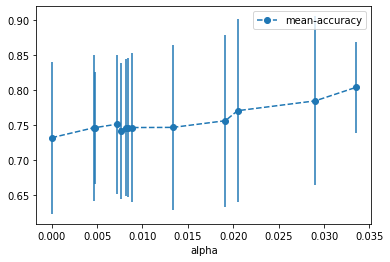

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# this is with pca
path = DecisionTreeClassifier().cost_complexity_pruning_path(pca_x_train,y_train) #determine values for alpha
ccp_alphas = path.ccp_alphas 
ccp_alphas = ccp_alphas[:-1] # we don't like the last one since it's just the root and so far away from the others
alphaResults = {}
for alpha in ccp_alphas:
  tree = DecisionTreeClassifier(ccp_alpha = alpha)
  scores = cross_val_score(tree,pca_x_train,y_train,cv=10)
  alphaResults[alpha] = [scores.mean(),scores.std()]
df = pd.DataFrame(alphaResults).T
df.reset_index(inplace=True)
df.columns = ['alpha','mean-accuracy','stdev']
df.plot(x='alpha',y='mean-accuracy',yerr='stdev',marker='o',linestyle='--')
best_alpha = df.loc[df['mean-accuracy'].argmax(),'alpha']
print(best_alpha)

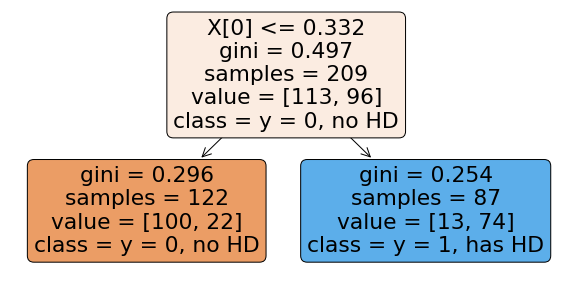

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

pruned_tree = DecisionTreeClassifier(ccp_alpha=best_alpha)
pruned_tree.fit(pca_x_train,y_train)
plt.figure(figsize=(10,5))
plot_tree(pruned_tree,filled=True,rounded=True,class_names=["y = 0, no HD","y = 1, has HD"]);

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.8666666666666667

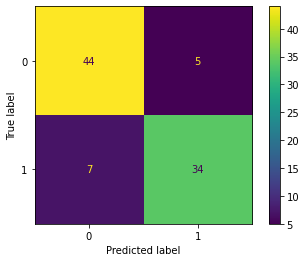

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pruned_tree,pca_x_test,y_test)
accuracy_score(y_test,pruned_tree.predict(pca_x_test))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.7444444444444445

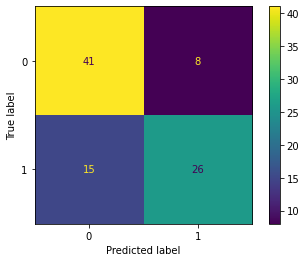

In [ ]:
# this is without pca
path = DecisionTreeClassifier().cost_complexity_pruning_path(x_train,y_train) #determine values for alpha
ccp_alphas = path.ccp_alphas 
ccp_alphas = ccp_alphas[:-1] # we don't like the last one since it's just the root and so far away from the others
alphaResults = {}
for alpha in ccp_alphas:
  tree = DecisionTreeClassifier(ccp_alpha = alpha)
  scores = cross_val_score(tree,x_train,y_train,cv=10)
  alphaResults[alpha] = [scores.mean(),scores.std()]
df = pd.DataFrame(alphaResults).T
df.reset_index(inplace=True)
df.columns = ['alpha','mean-accuracy','stdev']
best_alpha = df.loc[df['mean-accuracy'].argmax(),'alpha']
pruned_tree = DecisionTreeClassifier(ccp_alpha=best_alpha)
pruned_tree.fit(x_train,y_train)
plot_confusion_matrix(pruned_tree,x_test,y_test)
accuracy_score(y_test,pruned_tree.predict(x_test))

In [ ]:
# now we need to build many models
from tqdm.auto import tqdm
import numpy as np

def with_pca(X_encoded,y,random_state):
  scaled_data = preprocessing.scale(X_encoded)
  scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
  x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.15, random_state = random_state)
  pca = PCA()
  pca.fit(x_train)
  pca_x_train = pca.transform(x_train)
  pca_x_test = pca.transform(x_test)
  path = DecisionTreeClassifier().cost_complexity_pruning_path(pca_x_train,y_train)
  ccp_alphas = path.ccp_alphas 
  ccp_alphas = ccp_alphas[:-1]
  alphaResults = {}
  for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(ccp_alpha = alpha)
    scores = cross_val_score(tree,pca_x_train,y_train,cv=10)
    alphaResults[alpha] = [scores.mean(),scores.std()]
  df = pd.DataFrame(alphaResults).T
  df.reset_index(inplace=True)
  df.columns = ['alpha','mean-accuracy','stdev']
  best_alpha = df.loc[df['mean-accuracy'].argmax(),'alpha']
  pruned_tree = DecisionTreeClassifier(ccp_alpha=best_alpha)
  pruned_tree.fit(pca_x_train,y_train)
  return accuracy_score(y_test,pruned_tree.predict(pca_x_test)),pruned_tree.tree_.node_count

def without_pca(X_encoded,y,random_state):
  x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size = 0.15, random_state = random_state)
  path = DecisionTreeClassifier().cost_complexity_pruning_path(x_train,y_train)
  ccp_alphas = path.ccp_alphas 
  ccp_alphas = ccp_alphas[:-1]
  alphaResults = {}
  for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(ccp_alpha = alpha)
    scores = cross_val_score(tree,x_train,y_train,cv=10)
    alphaResults[alpha] = [scores.mean(),scores.std()]
  df = pd.DataFrame(alphaResults).T
  df.reset_index(inplace=True)
  df.columns = ['alpha','mean-accuracy','stdev']
  best_alpha = df.loc[df['mean-accuracy'].argmax(),'alpha']
  pruned_tree = DecisionTreeClassifier(ccp_alpha=best_alpha)
  pruned_tree.fit(x_train,y_train)
  return accuracy_score(y_test,pruned_tree.predict(x_test)),pruned_tree.tree_.node_count

acc_1 = []
node_1 = []
acc_2 = []
node_2 = []
for i in tqdm(range(100)):
  acc1,node1 = with_pca(X_encoded,y,i)
  acc_1.append(acc1)
  node_1.append(node1)
  acc2,node2 = without_pca(X_encoded,y,i)
  acc_2.append(acc2)
  node_2.append(node2)
print(f'Accuracy with pca is {np.mean(acc_1)}+-{np.std(acc_1)}; Average # of nodes is {np.mean(node_1)}.')
print(f'Accuracy without pca is {np.mean(acc_2)}+-{np.std(acc_2)}; Average # of nodes is {np.mean(node_2)}.')

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy with pca is 0.8084444444444442+-0.06002304084348581; Average # of nodes is 8.14.
Accuracy without pca is 0.7706666666666666+-0.057596296177213804; Average # of nodes is 18.78.


In [ ]:
acc_1 = []
node_1 = []
acc_2 = []
node_2 = []
for i in tqdm(range(20)):
  acc1,node1 = with_pca(X_encoded,y,i)
  acc_1.append(acc1)
  node_1.append(node1)
  acc2,node2 = without_pca(X_encoded,y,i)
  acc_2.append(acc2)
  node_2.append(node2)
print(f'Accuracy with pca is {np.mean(acc_1)}+-{np.std(acc_1)}; Average # of nodes is {np.mean(node_1)}.')
print(f'Accuracy without pca is {np.mean(acc_2)}+-{np.std(acc_2)}; Average # of nodes is {np.mean(node_2)}.')

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy with pca is 0.8055555555555557+-0.04120110270608702; Average # of nodes is 10.1.
Accuracy without pca is 0.7638888888888891+-0.03331017714204729; Average # of nodes is 24.4.


take-away is that PCA is awesome and that you really do need 100 models, not just 20.

# Lesson 3: SVD vs PCA SVD

In [ ]:
import numpy as np

def SVD(x_train,y_train,x_test):
  x_train = np.pad(x_train,[(0,0),(0,1)],constant_values=1)
  x_test = np.pad(x_test,[(0,0),(0,1)],constant_values=1)
  U,S,VT = np.linalg.svd(x_train,full_matrices=False)
  S = np.diag(S)
  x_train_inv = VT.T @ np.linalg.inv(S) @ U.T
  x_fit = x_train_inv @ y_train
  y_predicted_test = x_test @ x_fit
  y_predicted_test_2 = [int(row > 0.5) for row in y_predicted_test]
  y_predicted_train = x_train @ x_fit
  y_predicted_train_2 = [int(row > 0.5) for row in y_predicted_train]
  return y_predicted_train_2, y_predicted_test_2

def with_PCA(X,y,random_state = 1):
  scaled_data = preprocessing.scale(X_encoded)
  scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
  x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.15, random_state = random_state)
  pca = PCA()
  pca.fit(x_train)
  pca_x_train = pca.transform(x_train)
  pca_x_test = pca.transform(x_test)
  y_train_pred,y_test_pred = SVD(pca_x_train,y_train,pca_x_test)
  return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)

def without_PCA(X,y,random_state = 1):
  scaled_data = preprocessing.scale(X_encoded)
  scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
  x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.15, random_state = random_state)
  y_train_pred,y_test_pred = SVD(x_train,y_train,x_test)
  return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)

acc_pca_train = []
acc_pca_test = []
acc_nopca_train = []
acc_nopca_test = []
for i in tqdm(range(100)):
  acc1, acc2 = with_PCA(X_encoded,y,i)
  acc_pca_train.append(acc1)
  acc_pca_test.append(acc2)
  acc1, acc2 = without_PCA(X_encoded,y,i)
  acc_nopca_train.append(acc1)
  acc_nopca_test.append(acc2)
print(f'Accuracy on test with pca is {np.mean(acc_pca_test)}+-{np.std(acc_pca_test)}; Accuracy on train with pca is {np.mean(acc_pca_train)}+-{np.std(acc_pca_train)}')
print(f'Accuracy on test without pca is {np.mean(acc_nopca_test)}+-{np.std(acc_nopca_test)}; Accuracy on train without pca is {np.mean(acc_nopca_train)}+-{np.std(acc_nopca_train)}')

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on test with pca is 0.7686666666666667+-0.10461428271583258; Accuracy on train with pca is 0.7791338582677164+-0.0881248008903343
Accuracy on test without pca is 0.8191111111111111+-0.06037087025469023; Accuracy on train without pca is 0.8509055118110236+-0.022954173994901406


In [ ]:
# that's funny ... isn't PCA + linear fit the same as SVD??? 
# Don't forget padding for SVD!! It's really important (allows a constant term).

takeaway: don't do PCA with SVD. SVD by itself is awesome!

# Lesson 4: Logistic Regression vs PCA Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

def Logistic(x_train,y_train,x_test):
  model = LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear',C=1)
  model.fit(x_train,y_train)
  return model.predict(x_train), model.predict(x_test)

def with_PCA(X,y,random_state = 1):
  scaled_data = preprocessing.scale(X_encoded)
  scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
  x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.3, random_state = random_state)
  pca = PCA()
  pca.fit(x_train)
  pca_x_train = pca.transform(x_train)
  pca_x_test = pca.transform(x_test)
  y_train_pred,y_test_pred = Logistic(pca_x_train,y_train,pca_x_test)
  return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)

def without_PCA(X,y,random_state = 1):
  scaled_data = preprocessing.scale(X_encoded)
  scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
  x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.3, random_state = random_state)
  y_train_pred,y_test_pred = SVD(x_train,y_train,x_test)
  return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)

acc_pca_train = []
acc_pca_test = []
acc_nopca_train = []
acc_nopca_test = []
for i in tqdm(range(100)):
  acc1, acc2 = with_PCA(X_encoded,y,i)
  acc_pca_train.append(acc1)
  acc_pca_test.append(acc2)
  acc1, acc2 = without_PCA(X_encoded,y,i)
  acc_nopca_train.append(acc1)
  acc_nopca_test.append(acc2)
print(f'Accuracy on test with pca is {np.mean(acc_pca_test)}+-{np.std(acc_pca_test)}; Accuracy on train with pca is {np.mean(acc_pca_train)}+-{np.std(acc_pca_train)}')
print(f'Accuracy on test without pca is {np.mean(acc_nopca_test)}+-{np.std(acc_nopca_test)}; Accuracy on train without pca is {np.mean(acc_nopca_train)}+-{np.std(acc_nopca_train)}')


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on test with pca is 0.8346666666666668+-0.03699449408483095; Accuracy on train with pca is 0.8835885167464113+-0.015101057593154405
Accuracy on test without pca is 0.8135555555555556+-0.04150204516751457; Accuracy on train without pca is 0.8449282296650716+-0.03022389987298083


In [ ]:
from sklearn.linear_model import LogisticRegression

def Logistic(x_train,y_train,x_test):
  model = LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear',C=100000)
  model.fit(x_train,y_train)
  return model.predict(x_train), model.predict(x_test)

def with_PCA(X,y,random_state = 1):
  scaled_data = preprocessing.scale(X_encoded)
  scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
  x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.15, random_state = random_state)
  pca = PCA()
  pca.fit(x_train)
  pca_x_train = pca.transform(x_train)
  pca_x_test = pca.transform(x_test)
  y_train_pred,y_test_pred = Logistic(pca_x_train,y_train,pca_x_test)
  return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)

def without_PCA(X,y,random_state = 1):
  scaled_data = preprocessing.scale(X_encoded)
  scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
  x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.15, random_state = random_state)
  y_train_pred,y_test_pred = SVD(x_train,y_train,x_test)
  return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)

acc_pca_train = []
acc_pca_test = []
acc_nopca_train = []
acc_nopca_test = []
for i in tqdm(range(100)):
  acc1, acc2 = with_PCA(X_encoded,y,i)
  acc_pca_train.append(acc1)
  acc_pca_test.append(acc2)
  acc1, acc2 = without_PCA(X_encoded,y,i)
  acc_nopca_train.append(acc1)
  acc_nopca_test.append(acc2)
print(f'Accuracy on test with pca is {np.mean(acc_pca_test)}+-{np.std(acc_pca_test)}; Accuracy on train with pca is {np.mean(acc_pca_train)}+-{np.std(acc_pca_train)}')
print(f'Accuracy on test without pca is {np.mean(acc_nopca_test)}+-{np.std(acc_nopca_test)}; Accuracy on train without pca is {np.mean(acc_nopca_train)}+-{np.std(acc_nopca_train)}')


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on test with pca is 0.8333333333333333+-0.05704665623552639; Accuracy on train with pca is 0.8819291338582677+-0.01203842763185788
Accuracy on test without pca is 0.8191111111111111+-0.06037087025469023; Accuracy on train without pca is 0.8509055118110236+-0.022954173994901406


In [ ]:
# this shows that we don't really need the C parameter so we don't need to regularize it. It's only 0.5% better.
# let's do GridsearchCV (note this uses the function comparison defined next):
def Logistic(x_train,y_train,x_test):
  parameters = [{'C':[0.001,0.01,0.1,1,10]}]
  optimal_params = GridSearchCV(LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear'),parameters,cv=30,scoring='accuracy',verbose=0)
  optimal_params.fit(x_train,y_train)
  C = optimal_params.best_params_['C']
  clf = LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear',C=C)
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

comparison(X_encoded,y,Logistic)

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on test with pca is 0.8337777777777778+-0.035063258530339585; Accuracy on train with pca is 0.8705741626794256+-0.019286214236294102
Accuracy on test without pca is 0.834+-0.03491860022932346; Accuracy on train without pca is 0.870717703349282+-0.01848129093196767


Interesting: by giving it a range on the C values, PCA and non-PCA perform equally well and no worse (or better) than before! That means that it just gets the system out of a local minimum? I guess it makes sense because PCA plus linear is just another linear combination (if one can find it).

# For future use: comparing PCA + estimator to just estimator

In [ ]:
def comparison(X,y,estimator):
  def with_PCA(X,y,random_state = 1):
    scaled_data = preprocessing.scale(X_encoded)
    scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
    x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.15, random_state = random_state)
    pca = PCA()
    pca.fit(x_train)
    pca_x_train = pca.transform(x_train)
    pca_x_test = pca.transform(x_test)
    y_train_pred,y_test_pred = estimator(pca_x_train,y_train,pca_x_test)
    return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)

  def without_PCA(X,y,random_state = 1):
    scaled_data = preprocessing.scale(X_encoded)
    scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
    x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.15, random_state = random_state)
    y_train_pred,y_test_pred = estimator(x_train,y_train,x_test)
    return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)

  acc_pca_train = []
  acc_pca_test = []
  acc_nopca_train = []
  acc_nopca_test = []
  for i in tqdm(range(100)):
    acc1, acc2 = with_PCA(X_encoded,y,i)
    acc_pca_train.append(acc1)
    acc_pca_test.append(acc2)
    acc1, acc2 = without_PCA(X_encoded,y,i)
    acc_nopca_train.append(acc1)
    acc_nopca_test.append(acc2)
  print(f'Accuracy on test with pca is {np.mean(acc_pca_test)}+-{np.std(acc_pca_test)}; Accuracy on train with pca is {np.mean(acc_pca_train)}+-{np.std(acc_pca_train)}')
  print(f'Accuracy on test without pca is {np.mean(acc_nopca_test)}+-{np.std(acc_nopca_test)}; Accuracy on train without pca is {np.mean(acc_nopca_train)}+-{np.std(acc_nopca_train)}')

# Lesson 5: SVM vs PCA SVM

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

def SupportVectorMachines(x_train,y_train,x_test):
  parameters = [{'C':[0.001,0.01,0.1,1,10,100,1000,10000,100000], 'gamma':['scale',0.0001,0.001,0.01,0.1,1,10,100]},]
  optimal_params = GridSearchCV(svm.SVC(kernel='rbf'),parameters,cv=30,scoring='accuracy',verbose=0)
  optimal_params.fit(x_train,y_train)
  C = optimal_params.best_params_['C']
  gamma = optimal_params.best_params_['gamma']
  clf = svm.SVC(kernel='rbf', gamma=gamma, C=C)
  clf.fit(x_train, y_train)
  print(C)
  print(gamma)
  return clf.predict(x_train), clf.predict(x_test)

comparison(X_encoded,y,SupportVectorMachines)

  0%|          | 0/100 [00:00<?, ?it/s]

1
0.001
1
0.001


KeyboardInterrupt: ignored

In [ ]:
def SupportVectorMachines(x_train,y_train,x_test):
  parameters = [{'C':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10], 'gamma':['scale',0.0001,0.001,0.01]},]
  optimal_params = GridSearchCV(svm.SVC(kernel='rbf'),parameters,cv=30,scoring='accuracy',verbose=0)
  optimal_params.fit(x_train,y_train)
  C = optimal_params.best_params_['C']
  gamma = optimal_params.best_params_['gamma']
  clf = svm.SVC(kernel='rbf', gamma=gamma, C=C)
  clf.fit(x_train, y_train)
  print(C)
  print(gamma)
  return clf.predict(x_train), clf.predict(x_test)

comparison(X_encoded,y,SupportVectorMachines)

  0%|          | 0/100 [00:00<?, ?it/s]

0.4
0.01
0.4
0.01


KeyboardInterrupt: ignored

In [ ]:
def SupportVectorMachines(x_train,y_train,x_test):
  parameters = [{'C':[0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55], 'gamma':['scale',0.001,0.002,0.005,0.01,0.02,0.05,0.1]},]
  optimal_params = GridSearchCV(svm.SVC(kernel='rbf'),parameters,cv=30,scoring='accuracy',verbose=0)
  optimal_params.fit(x_train,y_train)
  C = optimal_params.best_params_['C']
  gamma = optimal_params.best_params_['gamma']
  clf = svm.SVC(kernel='rbf', gamma=gamma, C=C)
  clf.fit(x_train, y_train)
  print(C)
  print(gamma)
  return clf.predict(x_train), clf.predict(x_test)

comparison(X_encoded,y,SupportVectorMachines)

  0%|          | 0/100 [00:00<?, ?it/s]

0.5
0.002
0.5
0.002
0.4
0.002
0.4
0.002
0.4
0.002
0.4
0.002
0.35
0.002
0.35
0.002
0.45
scale
0.45
scale
0.25
0.005
0.25
0.005
0.35
0.002
0.35
0.002
0.4
0.002
0.4
0.002
0.45
0.01
0.45
0.01
0.35
0.002
0.35
0.002
0.45
0.002
0.45
0.002
0.25
0.005
0.25
0.005
0.55
0.05
0.55
0.05
0.4
0.002
0.4
0.002
0.4
0.05
0.4
0.05
0.35
0.002
0.35
0.002
0.45
0.002
0.45
0.002
0.35
0.002
0.35
0.002
0.35
0.005


KeyboardInterrupt: ignored

In [ ]:
def SupportVectorMachines(x_train,y_train,x_test):
  parameters = [{'C':[0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55], 'gamma':['scale',0.001,0.002,0.003,0.004,0.005,0.01,0.02,0.05]},]
  optimal_params = GridSearchCV(svm.SVC(kernel='rbf'),parameters,cv=30,scoring='accuracy',verbose=0)
  optimal_params.fit(x_train,y_train)
  C = optimal_params.best_params_['C']
  gamma = optimal_params.best_params_['gamma']
  clf = svm.SVC(kernel='rbf', gamma=gamma, C=C)
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

comparison(X_encoded,y,SupportVectorMachines)
# note you CANNOT print the average C or gamma unless you vow never to use that information anywhere.

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on test with pca is 0.8444444444444444+-0.03370166864022911; Accuracy on train with pca is 0.8652153110047845+-0.015855379345456225
Accuracy on test without pca is 0.8444444444444444+-0.03370166864022911; Accuracy on train without pca is 0.8652153110047845+-0.015855379345456225


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm

def SupportVectorMachines(x_train,y_train,x_test):
  parameters = [{'svc__C':[0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55], 'svc__gamma':['scale',0.001,0.002,0.003,0.004,0.005,0.01,0.02,0.05]},]
  optimal_params = RandomizedSearchCV(
      make_pipeline(
          StandardScaler(),
          svm.SVC(kernel='rbf')
      ),
      parameters,
      cv=30,
      scoring='accuracy',
      verbose=0,
      )
  optimal_params.fit(x_train,y_train)
  C = optimal_params.best_params_['svc__C']
  gamma = optimal_params.best_params_['svc__gamma']
  clf = make_pipeline(
          StandardScaler(),
          svm.SVC(kernel='rbf', gamma=gamma, C=C)
          )
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.95, test_size=.05, random_state=1)

acc_train = []
acc_test = []
for i in tqdm(range(10)):
  A_train, A_test, b_train, b_test = train_test_split(X_train, y_train, train_size=0.95, test_size=.05, random_state=i)
  b_train_pred, b_test_pred = SupportVectorMachines(A_train,b_train,A_test)
  acc_train.append(accuracy_score(b_train,b_train_pred))
  acc_test.append(accuracy_score(b_test,b_test_pred))


  0%|          | 0/10 [00:00<?, ?it/s]

0.45
0.003
0.25
0.004
0.35
0.002
0.55
0.002
0.5
0.003
0.3
0.003
0.35
0.002
0.5
0.002
0.55
0.004
0.4
0.002


In [ ]:
print(f'{np.mean(acc_test)}=-{np.std(acc_test)}')

0.6393333333333333=-0.13923441464746503


I forgot to scale it, but it's a lot faster!

In [ ]:
from sklearn import svm

def SupportVectorMachines(x_train,y_train,x_test):
  clf = svm.SVC(kernel='rbf', gamma=0.002, C=0.35)
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

comparison(X_encoded,y,SupportVectorMachines)

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on test with pca is 0.8488888888888888+-0.05258737584977436; Accuracy on train with pca is 0.8602755905511813+-0.010198218374172802
Accuracy on test without pca is 0.8488888888888888+-0.05258737584977436; Accuracy on train without pca is 0.8602755905511813+-0.010198218374172802


# Lesson 6: Random Forest vs PCA Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def RandomForest(x_train,y_train,x_test):
  parameters = [{'n_estimators':[10,50,100,150,200], 'max_depth':[None], 'min_samples_split':[2]},]
  optimal_params = GridSearchCV(RandomForestClassifier(),parameters,cv=30,scoring='accuracy',verbose=0)
  optimal_params.fit(x_train,y_train)
  n_estimators = optimal_params.best_params_['n_estimators']
  max_depth = optimal_params.best_params_['max_depth']
  min_samples_split = optimal_params.best_params_['min_samples_split']
  clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_samples_split)
  clf.fit(x_train, y_train)
  print(n_estimators)
  print(max_depth)
  print(min_samples_split)
  return clf.predict(x_train), clf.predict(x_test)

comparison(X_encoded,y,RandomForest)

  0%|          | 0/100 [00:00<?, ?it/s]

150
None
2
150
None
2
50
None
2
100
None
2
200
None
2
150
None
2
200
None
2
100
None
2
200
None
2
10
None
2
50
None
2
150
None
2
100
None
2
50
None
2
100
None
2
10
None
2
150
None
2
150
None
2
50
None
2
150
None
2


KeyboardInterrupt: ignored

In [ ]:
def RandomForest(x_train,y_train,x_test):
  parameters = [{'n_estimators':[100], 'max_depth':[None,2,3,4,5,6,7,8,9], 'min_samples_split':[2]},]
  optimal_params = GridSearchCV(RandomForestClassifier(),parameters,cv=30,scoring='accuracy',verbose=0)
  optimal_params.fit(x_train,y_train)
  n_estimators = optimal_params.best_params_['n_estimators']
  max_depth = optimal_params.best_params_['max_depth']
  min_samples_split = optimal_params.best_params_['min_samples_split']
  print(max_depth)
  clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_samples_split)
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

comparison(X_encoded,y,RandomForest)

  0%|          | 0/100 [00:00<?, ?it/s]

3
3
2
2
None
7
8
4
None
2
7
7
9
3
8
8
3
3
3
3


KeyboardInterrupt: ignored

values for the PCA case seem to be between 2 and 7 or 8.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def RandomForest(x_train,y_train,x_test):
  parameters = [{'n_estimators':[10,50,100,150,200], 'max_depth':[2,3,4,5,6,7], 'min_samples_split':[2]},]
  optimal_params = GridSearchCV(RandomForestClassifier(),parameters,cv=30,scoring='accuracy',verbose=0)
  optimal_params.fit(x_train,y_train)
  n_estimators = optimal_params.best_params_['n_estimators']
  max_depth = optimal_params.best_params_['max_depth']
  min_samples_split = optimal_params.best_params_['min_samples_split']
  print(n_estimators)
  print(max_depth)
  clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_samples_split)
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

evaluate_with_PCA(X_encoded,y,RandomForest)

  0%|          | 0/100 [00:00<?, ?it/s]

100
5
100
4
100
2
150
4
200
6


KeyboardInterrupt: ignored

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def RandomForest(x_train,y_train,x_test):
  parameters = [{'n_estimators':[100], 'max_depth':[2,3,4,5,6,7], 'min_samples_split':[2]},]
  optimal_params = GridSearchCV(RandomForestClassifier(),parameters,cv=30,scoring='accuracy',verbose=0)
  optimal_params.fit(x_train,y_train)
  n_estimators = optimal_params.best_params_['n_estimators']
  max_depth = optimal_params.best_params_['max_depth']
  min_samples_split = optimal_params.best_params_['min_samples_split']
  clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_samples_split)
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

evaluate_with_PCA(X_encoded,y,RandomForest)

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on test with pca is 0.8258888888888888+-0.03288795043706155; Accuracy on train with pca is 0.9455980861244018+-0.043719884604049936


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def RandomForest(x_train,y_train,x_test):
  clf = RandomForestClassifier(n_estimators=100,max_depth=4,min_samples_split=2)
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

evaluate_with_PCA(X_encoded,y,RandomForest)

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on test with pca is 0.8297777777777778+-0.052795435642594694; Accuracy on train with pca is 0.9305905511811023+-0.009410272424667309


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def RandomForest(x_train,y_train,x_test):
  parameters = [{'n_estimators':[10,50,100,150,200], 'max_depth':[4], 'min_samples_split':[2]},]
  optimal_params = GridSearchCV(RandomForestClassifier(),parameters,cv=30,scoring='accuracy',verbose=0)
  optimal_params.fit(x_train,y_train)
  n_estimators = optimal_params.best_params_['n_estimators']
  max_depth = optimal_params.best_params_['max_depth']
  min_samples_split = optimal_params.best_params_['min_samples_split']
  clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_samples_split)
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

evaluate_with_PCA(X_encoded,y,RandomForest)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

I'm probably not allowed to do it this way, that would be overfitting to the test data. You can simplify if it doesn't change performance but you can't add new features this way.

# For future use

In [ ]:
def evaluate_with_PCA(X,y,estimator):
  def with_PCA(X,y,random_state = 1):
    scaled_data = preprocessing.scale(X_encoded)
    scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
    x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.15, random_state = random_state)
    pca = PCA()
    pca.fit(x_train)
    pca_x_train = pca.transform(x_train)
    pca_x_test = pca.transform(x_test)
    y_train_pred,y_test_pred = estimator(pca_x_train,y_train,pca_x_test)
    return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)

  acc_pca_train = []
  acc_pca_test = []
  for i in tqdm(range(100)):
    acc1, acc2 = with_PCA(X_encoded,y,i)
    acc_pca_train.append(acc1)
    acc_pca_test.append(acc2)
  print(f'Accuracy on test with pca is {np.mean(acc_pca_test)}+-{np.std(acc_pca_test)}; Accuracy on train with pca is {np.mean(acc_pca_train)}+-{np.std(acc_pca_train)}')

# Lesson 7: Apart from PCA, we can also add Kmeans clusters as columns

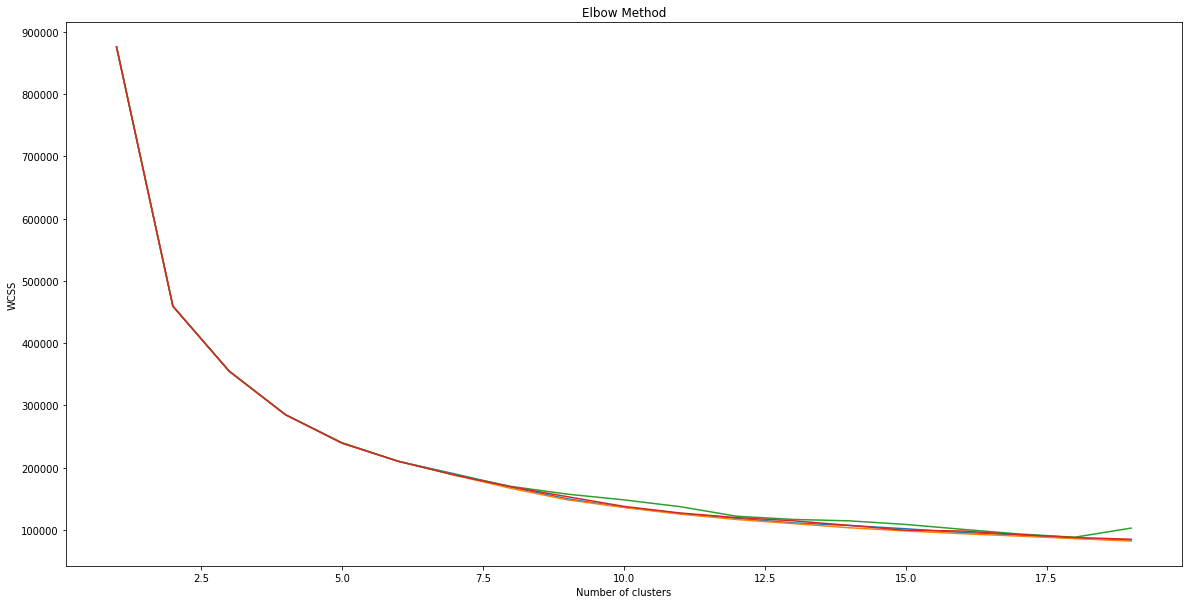

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


x_train, x_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y,test_size = 0.3, random_state = 1)

fig = plt.figure(figsize=(20,10))
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10)
    kmeans.fit(x_train)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=100)
    kmeans.fit(x_train)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 20), wcss)
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='random', max_iter=1000, n_init=10)
    kmeans.fit(x_train)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 20), wcss)
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='random', max_iter=1000, n_init=100)
    kmeans.fit(x_train)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 20), wcss)
plt.show()

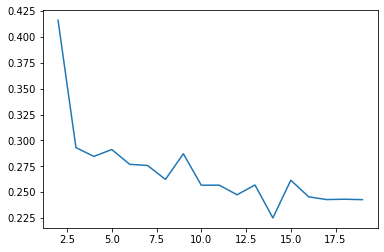

In [ ]:
from sklearn.metrics import silhouette_score
scores = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10)
    kmeans.fit(x_train)
    scores.append(silhouette_score(x_train,kmeans.labels_))

plt.plot(np.arange(2,20,1),scores)

looks like it should be 2 clusters.

let's do BIC, but let's first use these two clusters to do logistic regression better.

In [ ]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=1000, n_init=10)
kmeans.fit(x_train)
x_train['kmeans'] = kmeans.predict(x_train)
x_test['kmeans'] = kmeans.predict(x_test)

In [ ]:
def evaluate_with_kmeans_and_PCA(X,y,estimator):
  def with_PCA(X,y,random_state = 1):
    scaled_data = preprocessing.scale(X_encoded)
    scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
    x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.3, random_state = random_state)
    kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=1000, n_init=10)
    kmeans.fit(x_train)
    x_train['kmeans'] = kmeans.predict(x_train)
    x_test['kmeans'] = kmeans.predict(x_test)
    pca = PCA()
    pca.fit(x_train)
    pca_x_train = pca.transform(x_train)
    pca_x_test = pca.transform(x_test)
    y_train_pred,y_test_pred = estimator(pca_x_train,y_train,pca_x_test)
    return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)

  acc_pca_train = []
  acc_pca_test = []
  for i in tqdm(range(100)):
    acc1, acc2 = with_PCA(X_encoded,y,i)
    acc_pca_train.append(acc1)
    acc_pca_test.append(acc2)
  print(f'Accuracy on test with pca is {np.mean(acc_pca_test)}+-{np.std(acc_pca_test)}; Accuracy on train with pca is {np.mean(acc_pca_train)}+-{np.std(acc_pca_train)}')

def Logistic(x_train,y_train,x_test):
  parameters = [{'C':[0.001,0.01,0.1,1,10]}]
  optimal_params = GridSearchCV(LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear'),parameters,cv=30,scoring='accuracy',verbose=0)
  optimal_params.fit(x_train,y_train)
  C = optimal_params.best_params_['C']
  clf = LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear',C=C)
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

evaluate_with_kmeans_and_PCA(X_encoded,y,Logistic)

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on test with pca is 0.8360000000000001+-0.03742053308407425; Accuracy on train with pca is 0.8686124401913875+-0.020134617123558626


No different than without kmeans.

In [ ]:
# taking out pca

def evaluate_with_kmeans_and_PCA(X,y,estimator):
  def with_PCA(X,y,random_state = 1):
    scaled_data = preprocessing.scale(X_encoded)
    scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
    x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.3, random_state = random_state)
    kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=1000, n_init=10)
    kmeans.fit(x_train)
    x_train['kmeans'] = kmeans.predict(x_train)
    x_test['kmeans'] = kmeans.predict(x_test)
    y_train_pred,y_test_pred = estimator(x_train,y_train,x_test)
    return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)

  acc_pca_train = []
  acc_pca_test = []
  for i in tqdm(range(100)):
    acc1, acc2 = with_PCA(X_encoded,y,i)
    acc_pca_train.append(acc1)
    acc_pca_test.append(acc2)
  print(f'Accuracy on test with pca is {np.mean(acc_pca_test)}+-{np.std(acc_pca_test)}; Accuracy on train with pca is {np.mean(acc_pca_train)}+-{np.std(acc_pca_train)}')

def Logistic(x_train,y_train,x_test):
  parameters = [{'C':[0.001,0.01,0.1,1,10]}]
  optimal_params = GridSearchCV(LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear'),parameters,cv=30,scoring='accuracy',verbose=0)
  optimal_params.fit(x_train,y_train)
  C = optimal_params.best_params_['C']
  clf = LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear',C=C)
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

evaluate_with_kmeans_and_PCA(X_encoded,y,Logistic)

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on test with pca is 0.8353333333333335+-0.03656146524335069; Accuracy on train with pca is 0.8698086124401911+-0.01898617407430251


In [ ]:
# taking out pca

def evaluate_with_kmeans_and_PCA(X,y,estimator):
  def with_PCA(X,y,random_state = 1):
    scaled_data = preprocessing.scale(X_encoded)
    scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
    x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.3, random_state = random_state)
    kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=1000, n_init=10)
    kmeans.fit(x_train)
    x_train['kmeans'] = kmeans.predict(x_train)
    x_test['kmeans'] = kmeans.predict(x_test)
    y_train_pred,y_test_pred = estimator(x_train,y_train,x_test)
    return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)

  acc_pca_train = []
  acc_pca_test = []
  for i in tqdm(range(100)):
    acc1, acc2 = with_PCA(X_encoded,y,i)
    acc_pca_train.append(acc1)
    acc_pca_test.append(acc2)
  print(f'Accuracy on test with pca is {np.mean(acc_pca_test)}+-{np.std(acc_pca_test)}; Accuracy on train with pca is {np.mean(acc_pca_train)}+-{np.std(acc_pca_train)}')

def Logistic(x_train,y_train,x_test):
  parameters = [{'C':[0.001,0.01,0.1,1,10]}]
  optimal_params = GridSearchCV(LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear'),parameters,cv=30,scoring='accuracy',verbose=0)
  optimal_params.fit(x_train,y_train)
  C = optimal_params.best_params_['C']
  clf = LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear',C=C)
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

evaluate_with_kmeans_and_PCA(X_encoded,y,Logistic)

In [ ]:
from sklearn import svm

def SupportVectorMachines(x_train,y_train,x_test):
  clf = svm.SVC(kernel='rbf', gamma=0.002, C=0.35)
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

evaluate_with_kmeans_and_PCA(X_encoded,y,SupportVectorMachines)

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on test with pca is 0.848111111111111+-0.03095416763260094; Accuracy on train with pca is 0.8604306220095692+-0.014178431044028248


still the same, kmeans isn't helping. now let's do BIC.

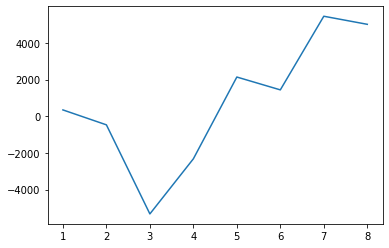

In [ ]:
from sklearn.mixture import GaussianMixture

bic = []
xx = []
for i in range(8):
  gmm = GaussianMixture(n_components=i+1)
  gmm.fit(x_train)
  xx.append(i+1)
  bic.append(gmm.bic(x_train))
plt.plot(xx,bic)

There are very clearly three clusters.

In [ ]:
# taking out pca

def evaluate_with_gmm_and_PCA(X,y,estimator):
  def with_PCA(X,y,random_state = 1):
    scaled_data = preprocessing.scale(X_encoded)
    scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
    x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.3, random_state = random_state)
    gmm = GaussianMixture(n_components=3)
    gmm.fit(x_train)
    x_train['gmm'] = gmm.predict(x_train)
    x_test['gmm'] = gmm.predict(x_test)
    pca = PCA()
    pca.fit(x_train)
    pca_x_train = pca.transform(x_train)
    pca_x_test = pca.transform(x_test)
    y_train_pred,y_test_pred = estimator(pca_x_train,y_train,pca_x_test)
    return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)

  acc_pca_train = []
  acc_pca_test = []
  for i in tqdm(range(100)):
    acc1, acc2 = with_PCA(X_encoded,y,i)
    acc_pca_train.append(acc1)
    acc_pca_test.append(acc2)
  print(f'Accuracy on test with pca is {np.mean(acc_pca_test)}+-{np.std(acc_pca_test)}; Accuracy on train with pca is {np.mean(acc_pca_train)}+-{np.std(acc_pca_train)}')

def Logistic(x_train,y_train,x_test):
  parameters = [{'C':[0.001,0.01,0.1,1,10]}]
  optimal_params = GridSearchCV(LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear'),parameters,cv=30,scoring='accuracy',verbose=0)
  optimal_params.fit(x_train,y_train)
  C = optimal_params.best_params_['C']
  clf = LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear',C=C)
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

evaluate_with_gmm_and_PCA(X_encoded,y,Logistic)

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on test with pca is 0.8342222222222224+-0.035440090293338694; Accuracy on train with pca is 0.8699521531100477+-0.019321851459421977


In [ ]:
from sklearn import svm

def SupportVectorMachines(x_train,y_train,x_test):
  clf = svm.SVC(kernel='rbf', gamma=0.002, C=0.35)
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

evaluate_with_gmm_and_PCA(X_encoded,y,SupportVectorMachines)

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on test with pca is 0.8463333333333333+-0.03059310823706768; Accuracy on train with pca is 0.8574162679425836+-0.015430158369949376


Doesn't look like PCA, KNN or GMM actually does anything for SVM or Logistic Regression.

Anyway, we can look at these clusters to see what they found.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y,test_size = 0.3, random_state = 1)
gmm = GaussianMixture(n_components=3)
gmm.fit(x_train)
x_train['gmm'] = gmm.predict(x_train)
print(np.sum(y[x_train.loc[x_train['gmm']==0].index])/len(y[x_train.loc[x_train['gmm']==0].index]))
print(np.sum(y[x_train.loc[x_train['gmm']==1].index])/len(y[x_train.loc[x_train['gmm']==1].index]))
print(np.sum(y[x_train.loc[x_train['gmm']==2].index])/len(y[x_train.loc[x_train['gmm']==2].index]))

0.4431818181818182
0.375
0.4778761061946903


Doesn't look like these clusters have any relevance to the target variable.

In [ ]:
np.sum(y)/len(y)

0.45819397993311034

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y,test_size = 0.3, random_state = 1)
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=1000, n_init=10)
kmeans.fit(x_train)
x_train['kmeans'] = kmeans.predict(x_train)
print(np.sum(y[x_train.loc[x_train['kmeans']==0].index])/len(y[x_train.loc[x_train['kmeans']==0].index]))
print(np.sum(y[x_train.loc[x_train['kmeans']==1].index])/len(y[x_train.loc[x_train['kmeans']==1].index]))

0.4166666666666667
0.5324675324675324


# Lesson 8: Let's do KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def evaluate_knn(X,y):
  def knn(X,y,random_state):
    scaled_data = preprocessing.scale(X_encoded)
    scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
    x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.15, random_state = random_state)
    parameters = [{'n_neighbors':[6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],'weights':["uniform","distance"]}]
    optimal_params = GridSearchCV(KNeighborsClassifier(),parameters,cv=30,scoring='accuracy',verbose=0)
    optimal_params.fit(x_train,y_train)
    n_neighbors = optimal_params.best_params_['n_neighbors']
    weights = optimal_params.best_params_['weights']
    print(n_neighbors)
    print(weights)
    return None
  # acc_pca_train = []
  # acc_pca_test = []
  for i in tqdm(range(100)):
    knn(X_encoded,y,i)
  # we want to find good ranges for the parameters first

  #   acc_pca_train.append(acc1)
  #   acc_pca_test.append(acc2)
  # print(f'Accuracy on test with pca is {np.mean(acc_pca_test)}+-{np.std(acc_pca_test)}; Accuracy on train with pca is {np.mean(acc_pca_train)}+-{np.std(acc_pca_train)}')
evaluate_knn(X,y)



  0%|          | 0/100 [00:00<?, ?it/s]

16
uniform
16
uniform
16
distance
9
distance
19
distance
15
uniform
14
uniform
18
uniform
8
distance
17
uniform


KeyboardInterrupt: ignored

Let's see if 8 and 20 neighbors actually make a difference.

In [ ]:
scaled_data = preprocessing.scale(X_encoded)
scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.3, random_state = 1)
knn = KNeighborsClassifier(n_neighbors=8,weights='distance')
knn.fit(x_train,y_train)
print(accuracy_score(y_test,knn.predict(x_test)))
knn = KNeighborsClassifier(n_neighbors=20,weights='distance')
knn.fit(x_train,y_train)
print(accuracy_score(y_test,knn.predict(x_test)))

0.8
0.8333333333333334


In [ ]:
knn = KNeighborsClassifier(n_neighbors=8,weights='distance')
knn.fit(x_train,y_train)
print(accuracy_score(y_test,knn.predict(x_test)))
knn = KNeighborsClassifier(n_neighbors=8,weights='uniform')
knn.fit(x_train,y_train)
print(accuracy_score(y_test,knn.predict(x_test)))

0.8
0.8222222222222222


so all important stuff, good to know.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def evaluate_knn(X,y):
  def knn(X,y,random_state):
    scaled_data = preprocessing.scale(X_encoded)
    scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
    x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.3, random_state = random_state)
    parameters = [{'n_neighbors':[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34],'weights':["uniform","distance"]}]
    optimal_params = GridSearchCV(KNeighborsClassifier(),parameters,cv=30,scoring='accuracy',verbose=0)
    optimal_params.fit(x_train,y_train)
    n_neighbors = optimal_params.best_params_['n_neighbors']
    weights = optimal_params.best_params_['weights']
    print(n_neighbors)
    print(weights)
    return None
  # acc_pca_train = []
  # acc_pca_test = []
  for i in tqdm(range(100)):
    knn(X_encoded,y,i)
  # we want to find good ranges for the parameters first

  #   acc_pca_train.append(acc1)
  #   acc_pca_test.append(acc2)
  # print(f'Accuracy on test with pca is {np.mean(acc_pca_test)}+-{np.std(acc_pca_test)}; Accuracy on train with pca is {np.mean(acc_pca_train)}+-{np.std(acc_pca_train)}')
evaluate_knn(X,y)



  0%|          | 0/100 [00:00<?, ?it/s]

20
distance
30
uniform
16
uniform
8
distance
26
distance
16
uniform
14
uniform
34
distance
32
uniform
16
distance
12
uniform
6
distance
12
distance
12
uniform
12
uniform
14
distance
16
uniform
16
uniform
14
distance
32
uniform
26
uniform
8
distance
34
distance
32
uniform
26
distance
22
distance
30
distance
8
uniform
24
distance
16
uniform
30
distance
2
distance
12
uniform


KeyboardInterrupt: ignored

I think I am happy with my range. Let's get the accuracy. Or first let's check that PCA doesn't do anything here.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def evaluate_knn(X,y):
  def knn(X,y,random_state):
    scaled_data = preprocessing.scale(X_encoded)
    scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
    x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.3, random_state = random_state)
    pca = PCA()
    pca.fit(x_train)
    pca_x_train = pca.transform(x_train)
    pca_x_test = pca.transform(x_test)
    parameters = [{'n_neighbors':[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34],'weights':["uniform","distance"]}]
    optimal_params = GridSearchCV(KNeighborsClassifier(),parameters,cv=30,scoring='accuracy',verbose=0)
    optimal_params.fit(pca_x_train,y_train)
    n_neighbors = optimal_params.best_params_['n_neighbors']
    weights = optimal_params.best_params_['weights']
    print(n_neighbors)
    print(weights)

    return None
  # acc_pca_train = []
  # acc_pca_test = []
  for i in tqdm(range(100)):
    knn(X_encoded,y,i)
  # we want to find good ranges for the parameters first

  #   acc_pca_train.append(acc1)
  #   acc_pca_test.append(acc2)
  # print(f'Accuracy on test with pca is {np.mean(acc_pca_test)}+-{np.std(acc_pca_test)}; Accuracy on train with pca is {np.mean(acc_pca_train)}+-{np.std(acc_pca_train)}')
evaluate_knn(X,y)



  0%|          | 0/100 [00:00<?, ?it/s]

20
distance
30
uniform
16
uniform
8
distance
26
distance
16
uniform


KeyboardInterrupt: ignored

It doesn't.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def evaluate_knn(X,y):
  def knn(X,y,random_state):
    scaled_data = preprocessing.scale(X_encoded)
    scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
    x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.3, random_state = random_state)
    parameters = [{'n_neighbors':[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34],'weights':["uniform","distance"]}]
    optimal_params = GridSearchCV(KNeighborsClassifier(),parameters,cv=30,scoring='accuracy',verbose=0)
    optimal_params.fit(x_train,y_train)
    n_neighbors = optimal_params.best_params_['n_neighbors']
    weights = optimal_params.best_params_['weights']
    knn = KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights)
    knn.fit(x_train,y_train)
    y_train_pred = knn.predict(x_train)
    y_test_pred = knn.predict(x_test)
    return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)
  acc_train = []
  acc_test = []
  for i in tqdm(range(100)):
    acc1, acc2 = knn(X_encoded,y,i)
    acc_train.append(acc1)
    acc_test.append(acc2)
  print(f'Accuracy on test is {np.mean(acc_test)}+-{np.std(acc_test)}; Accuracy on train is {np.mean(acc_train)}+-{np.std(acc_train)}')
evaluate_knn(X,y)

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on test is 0.8316666666666667+-0.03546429259667695; Accuracy on train is 0.9320095693779904+-0.0692617240597202


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def evaluate_knn(X,y):
  def knn(X,y,random_state):
    scaled_data = preprocessing.scale(X_encoded)
    scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
    x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.15, random_state = random_state)
    parameters = [{'n_neighbors':[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34]}]
    optimal_params = GridSearchCV(KNeighborsClassifier(),parameters,cv=30,scoring='accuracy',verbose=0)
    optimal_params.fit(x_train,y_train)
    n_neighbors = optimal_params.best_params_['n_neighbors']
    weights = "uniform"
    knn = KNeighborsClassifier(n_neighbors=n_neighbors,weights="uniform")
    knn.fit(x_train,y_train)
    y_train_pred = knn.predict(x_train)
    y_test_pred = knn.predict(x_test)
    return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)
  acc_train = []
  acc_test = []
  for i in tqdm(range(100)):
    acc1, acc2 = knn(X_encoded,y,i)
    acc_train.append(acc1)
    acc_test.append(acc2)
  print(f'Accuracy on test is {np.mean(acc_test)}+-{np.std(acc_test)}; Accuracy on train is {np.mean(acc_train)}+-{np.std(acc_train)}')
evaluate_knn(X,y)

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on test is 0.8320000000000001+-0.053177550261852516; Accuracy on train is 0.8600393700787403+-0.013014476122886292


# Lesson 9: Gradient Boosting Trees???

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

x_train, x_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y,test_size = 0.3, random_state = 1)
A_train, A_test, b_train, b_test = train_test_split(x_train, y_train, stratify=y_train,test_size = 0.3, random_state = 1)

gbc = GradientBoostingClassifier()
gbc.fit(A_train,b_train)
print(accuracy_score(b_train,gbc.predict(A_train)))
print(accuracy_score(b_test,gbc.predict(A_test)))

1.0
0.7936507936507936


out of the box it's just ok.

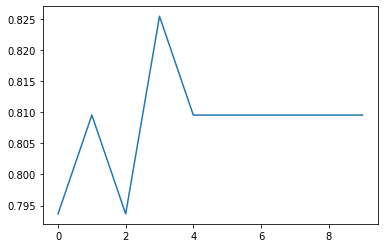

In [ ]:
acc = []
for i in range(10):
  gbc = GradientBoostingClassifier(max_depth=3,n_estimators=100*(i+1))
  gbc.fit(A_train,b_train)
  acc.append(accuracy_score(b_test,gbc.predict(A_test)))
plt.plot(acc)

ok, I get 400. Let's look at other variables.

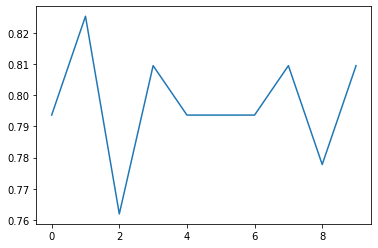

In [ ]:
acc = []
for i in range(10):
  gbc = GradientBoostingClassifier(max_depth=i+2,n_estimators=400)
  gbc.fit(A_train,b_train)
  acc.append(accuracy_score(b_test,gbc.predict(A_test)))
plt.plot(acc)

Maybe 3 but it varies a lot...

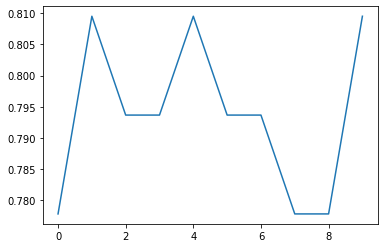

In [ ]:
acc = []
for i in range(10):
  gbc = GradientBoostingClassifier(max_depth=3,n_estimators=400,learning_rate=0.03*(1+i))
  gbc.fit(A_train,b_train)
  acc.append(accuracy_score(b_test,gbc.predict(A_test)))
plt.plot(acc)

In [ ]:
gbc = GradientBoostingClassifier(max_depth=5,n_estimators=400,learning_rate=0.1)
gbc.fit(A_train,b_train)
accuracy_score(b_test,gbc.predict(A_test))


0.8095238095238095

0.1 seems fine, regular loss seems fine.

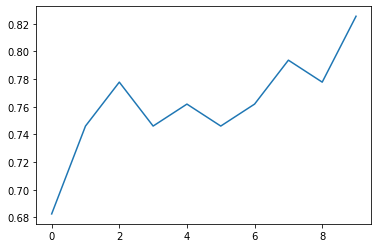

In [ ]:
acc = []
for i in range(10):
  gbc = GradientBoostingClassifier(max_depth=3,n_estimators=400,subsample=0.1*(1+i))
  gbc.fit(A_train,b_train)
  acc.append(accuracy_score(b_test,gbc.predict(A_test)))
plt.plot(acc)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:475: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: C

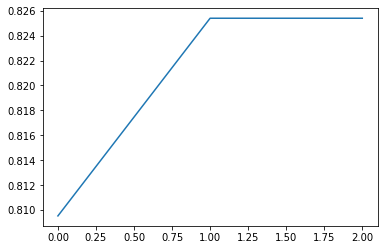

In [ ]:
criterion = ['friedman_mse', 'squared_error', 'mse']
acc = []
for i in criterion:
  gbc = GradientBoostingClassifier(max_depth=3,n_estimators=400,criterion=i)
  gbc.fit(A_train,b_train)
  acc.append(accuracy_score(b_test,gbc.predict(A_test)))
plt.plot(acc)

Looks like I will be using squared-error.

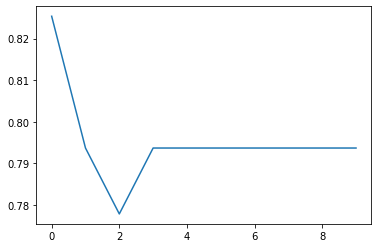

In [ ]:
acc = []
for i in range(10):
  gbc = GradientBoostingClassifier(max_depth=3,n_estimators=400,criterion='squared_error',min_samples_split=2+i)
  gbc.fit(A_train,b_train)
  acc.append(accuracy_score(b_test,gbc.predict(A_test)))
plt.plot(acc)

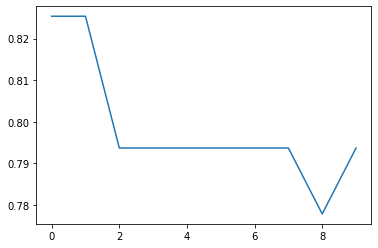

In [ ]:
acc = []
for i in range(10):
  gbc = GradientBoostingClassifier(max_depth=3,n_estimators=400,criterion='squared_error',min_samples_leaf=1+i)
  gbc.fit(A_train,b_train)
  acc.append(accuracy_score(b_test,gbc.predict(A_test)))
plt.plot(acc)

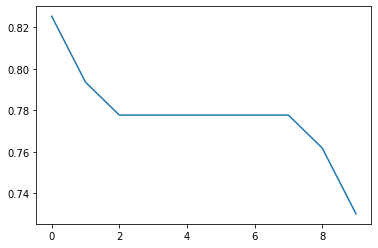

In [ ]:
acc = []
for i in range(10):
  gbc = GradientBoostingClassifier(max_depth=3,n_estimators=400,criterion='squared_error',min_weight_fraction_leaf=0.05*i)
  gbc.fit(A_train,b_train)
  acc.append(accuracy_score(b_test,gbc.predict(A_test)))
plt.plot(acc)

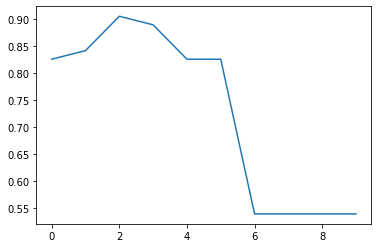

In [ ]:
acc = []
for i in range(10):
  gbc = GradientBoostingClassifier(max_depth=3,n_estimators=400,criterion='squared_error',min_impurity_decrease=i*0.01)
  gbc.fit(A_train,b_train)
  acc.append(accuracy_score(b_test,gbc.predict(A_test)))
plt.plot(acc)

This could be very interesting!

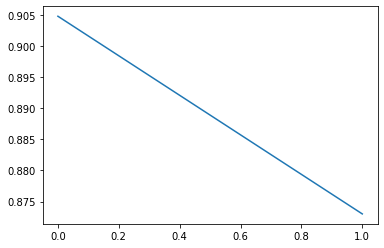

In [ ]:
max_features = ['auto', 'log2']
acc = []
for i in max_features:
  gbc = GradientBoostingClassifier(max_depth=3,n_estimators=400,criterion='squared_error',min_impurity_decrease=0.02, max_features=i)
  gbc.fit(A_train,b_train)
  acc.append(accuracy_score(b_test,gbc.predict(A_test)))
plt.plot(acc)

auto is best

we are finally done. let's evaluate it on the test data.

In [ ]:
gbc = GradientBoostingClassifier(max_depth=3,n_estimators=400,criterion='squared_error',min_impurity_decrease=0.02)
gbc.fit(x_train,y_train)
accuracy_score(y_test,gbc.predict(x_test))

0.8111111111111111

The ranges that I have found to be meaningful are n_estimators:[100,200,300,400,500,600], max_depth:[2,3,4,5,6], criterion:['friedman_mse', 'squared_error'],min_impurity_decrease=[0.01,0.02,0.03,0.04,0.05]. These are 300 overall choices.

I guess now I'm supposed to find ranges of parameters. I guess I will do it one at a time.

In [ ]:
# taking out pca

def evaluate_with_PCA(X,y,estimator):
  def with_PCA(X,y,random_state = 1):
    scaled_data = preprocessing.scale(X_encoded)
    scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
    x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.3, random_state = random_state)
    pca = PCA()
    pca.fit(x_train)
    pca_x_train = pca.transform(x_train)
    pca_x_test = pca.transform(x_test)
    y_train_pred,y_test_pred = estimator(pca_x_train,y_train,pca_x_test)
    return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)

  acc_pca_train = []
  acc_pca_test = []
  for i in tqdm(range(100)):
    acc1, acc2 = with_PCA(X_encoded,y,i)
    acc_pca_train.append(acc1)
    acc_pca_test.append(acc2)
  #print(f'Accuracy on test with pca is {np.mean(acc_pca_test)}+-{np.std(acc_pca_test)}; Accuracy on train with pca is {np.mean(acc_pca_train)}+-{np.std(acc_pca_train)}')

def GBoost(x_train,y_train,x_test):
  parameters = [{'n_estimators':[100,200,300,400,500,600]}]
  optimal_params = GridSearchCV(GradientBoostingClassifier(),parameters,cv=30,scoring='accuracy',verbose=0)
  optimal_params.fit(x_train,y_train)
  n_estimators = optimal_params.best_params_['n_estimators']
  print(n_estimators)
  clf = GradientBoostingClassifier()
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

evaluate_with_PCA(X_encoded,y,GBoost)

  0%|          | 0/100 [00:00<?, ?it/s]

500
400
100


KeyboardInterrupt: ignored

I don't have time to evaluate all these parameters anyway. Look at this: 2:40 hours for just one parameter. In the end, I can only vary a single parameter that I find most impactful. The others will have to stay default.

In [ ]:

def evaluate_with_PCA(X,y,estimator):
  def with_PCA(X,y,random_state = 1):
    scaled_data = preprocessing.scale(X_encoded)
    scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
    x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.3, random_state = random_state)
    pca = PCA()
    pca.fit(x_train)
    pca_x_train = pca.transform(x_train)
    pca_x_test = pca.transform(x_test)
    y_train_pred,y_test_pred = estimator(pca_x_train,y_train,pca_x_test)
    return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)

  acc_pca_train = []
  acc_pca_test = []
  for i in tqdm(range(100)):
    acc1, acc2 = with_PCA(X_encoded,y,i)
    acc_pca_train.append(acc1)
    acc_pca_test.append(acc2)
  #print(f'Accuracy on test with pca is {np.mean(acc_pca_test)}+-{np.std(acc_pca_test)}; Accuracy on train with pca is {np.mean(acc_pca_train)}+-{np.std(acc_pca_train)}')

def GBoost(x_train,y_train,x_test):
  parameters = [{'min_impurity_decrease':[0.01,0.02,0.03,0.04,0.05]}]
  optimal_params = GridSearchCV(GradientBoostingClassifier(),parameters,cv=30,scoring='accuracy',verbose=0)
  optimal_params.fit(x_train,y_train)
  min_impurity_decrease = optimal_params.best_params_['min_impurity_decrease']
  print(min_impurity_decrease)
  clf = GradientBoostingClassifier()
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

evaluate_with_PCA(X_encoded,y,GBoost)

  0%|          | 0/100 [00:00<?, ?it/s]

0.01
0.01
0.05
0.01
0.04
0.01
0.03
0.05
0.02


KeyboardInterrupt: ignored

Or I could greatly decrease cv.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

def evaluate_with_PCA(X,y,estimator):
  def with_PCA(X,y,random_state = 1):
    scaled_data = preprocessing.scale(X_encoded)
    scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
    x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.3, random_state = random_state)
    pca = PCA()
    pca.fit(x_train)
    pca_x_train = pca.transform(x_train)
    pca_x_test = pca.transform(x_test)
    y_train_pred,y_test_pred = estimator(pca_x_train,y_train,pca_x_test)
    return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)

  acc_pca_train = []
  acc_pca_test = []
  for i in tqdm(range(100)):
    acc1, acc2 = with_PCA(X_encoded,y,i)
    acc_pca_train.append(acc1)
    acc_pca_test.append(acc2)
  print(f'Accuracy on test with pca is {np.mean(acc_pca_test)}+-{np.std(acc_pca_test)}; Accuracy on train with pca is {np.mean(acc_pca_train)}+-{np.std(acc_pca_train)}')

def GBoost(x_train,y_train,x_test):
  parameters = [{'n_estimators':[100,300,500],'min_impurity_decrease':[0.01,0.03,0.05],'max_depth':[2,4,6],'criterion':['friedman_mse', 'squared_error']}]
  optimal_params = GridSearchCV(GradientBoostingClassifier(),parameters,cv=5,scoring='accuracy',verbose=0)
  optimal_params.fit(x_train,y_train)
  min_impurity_decrease = optimal_params.best_params_['min_impurity_decrease']
  n_estimators = optimal_params.best_params_['n_estimators']
  max_depth = optimal_params.best_params_['max_depth']
  criterion = optimal_params.best_params_['criterion']
  clf = GradientBoostingClassifier()
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

evaluate_with_PCA(X_encoded,y,GBoost)

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on test with pca is 0.8126666666666666+-0.03600480077729004; Accuracy on train with pca is 1.0+-0.0


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

def evaluate_with_PCA(X,y,estimator):
  def with_PCA(X,y,random_state = 1):
    scaled_data = preprocessing.scale(X_encoded)
    scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
    x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.15, random_state = random_state)
    pca = PCA()
    pca.fit(x_train)
    pca_x_train = pca.transform(x_train)
    pca_x_test = pca.transform(x_test)
    y_train_pred,y_test_pred = estimator(pca_x_train,y_train,pca_x_test)
    return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)

  acc_pca_train = []
  acc_pca_test = []
  for i in tqdm(range(100)):
    acc1, acc2 = with_PCA(X_encoded,y,i)
    acc_pca_train.append(acc1)
    acc_pca_test.append(acc2)
  print(f'Accuracy on test with pca is {np.mean(acc_pca_test)}+-{np.std(acc_pca_test)}; Accuracy on train with pca is {np.mean(acc_pca_train)}+-{np.std(acc_pca_train)}')

def GBoost(x_train,y_train,x_test):
  clf = GradientBoostingClassifier()
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

evaluate_with_PCA(X_encoded,y,GBoost)

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on test with pca is 0.812+-0.053372208054310366; Accuracy on train with pca is 0.9999606299212599+-0.0003917273374435504


# Lesson 10: impact of size of train_test_split

## First thoughts

In [4]:
from sklearn.linear_model import LogisticRegression

def change_test_size(test_size,nr_models):
  def Logistic(x_train,y_train,x_test):
    model = LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear')
    model.fit(x_train,y_train)
    return model.predict(x_train), model.predict(x_test)

  def with_PCA(X,y,test_size,random_state = 1):
    scaled_data = preprocessing.scale(X_encoded)
    scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
    x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = test_size, random_state = random_state)
    pca = PCA()
    pca.fit(x_train)
    pca_x_train = pca.transform(x_train)
    pca_x_test = pca.transform(x_test)
    y_train_pred,y_test_pred = Logistic(pca_x_train,y_train,pca_x_test)
    return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)

  acc_pca_train = []
  acc_pca_test = []
  acc_nopca_train = []
  acc_nopca_test = []
  for i in tqdm(range(nr_models)):
    acc1, acc2 = with_PCA(X_encoded,y,test_size,i)
    acc_pca_train.append(acc1)
    acc_pca_test.append(acc2)
  return np.mean(acc_pca_test), np.std(acc_pca_test)

test_sizes_100=[]
means_100 = []
stds_100 = []
for i in range(50):
  print(i)
  mean,std = change_test_size(test_size=(50-i)/100,nr_models=100)
  means_100.append(mean)
  stds_100.append(std)
  test_sizes_100.append((50-i)/100)

test_sizes_200=[]
means_200 = []
stds_200 = []
for i in range(50):
  print(i)
  mean,std = change_test_size(test_size=(50-i)/100,nr_models=200)
  means_200.append(mean)
  stds_200.append(std)
  test_sizes_200.append((50-i)/100)

0


  0%|          | 0/100 [00:00<?, ?it/s]

1


  0%|          | 0/100 [00:00<?, ?it/s]

2


  0%|          | 0/100 [00:00<?, ?it/s]

3


  0%|          | 0/100 [00:00<?, ?it/s]

4


  0%|          | 0/100 [00:00<?, ?it/s]

5


  0%|          | 0/100 [00:00<?, ?it/s]

6


  0%|          | 0/100 [00:00<?, ?it/s]

7


  0%|          | 0/100 [00:00<?, ?it/s]

8


  0%|          | 0/100 [00:00<?, ?it/s]

9


  0%|          | 0/100 [00:00<?, ?it/s]

10


  0%|          | 0/100 [00:00<?, ?it/s]

11


  0%|          | 0/100 [00:00<?, ?it/s]

12


  0%|          | 0/100 [00:00<?, ?it/s]

13


  0%|          | 0/100 [00:00<?, ?it/s]

14


  0%|          | 0/100 [00:00<?, ?it/s]

15


  0%|          | 0/100 [00:00<?, ?it/s]

16


  0%|          | 0/100 [00:00<?, ?it/s]

17


  0%|          | 0/100 [00:00<?, ?it/s]

18


  0%|          | 0/100 [00:00<?, ?it/s]

19


  0%|          | 0/100 [00:00<?, ?it/s]

20


  0%|          | 0/100 [00:00<?, ?it/s]

21


  0%|          | 0/100 [00:00<?, ?it/s]

22


  0%|          | 0/100 [00:00<?, ?it/s]

23


  0%|          | 0/100 [00:00<?, ?it/s]

24


  0%|          | 0/100 [00:00<?, ?it/s]

25


  0%|          | 0/100 [00:00<?, ?it/s]

26


  0%|          | 0/100 [00:00<?, ?it/s]

27


  0%|          | 0/100 [00:00<?, ?it/s]

28


  0%|          | 0/100 [00:00<?, ?it/s]

29


  0%|          | 0/100 [00:00<?, ?it/s]

30


  0%|          | 0/100 [00:00<?, ?it/s]

31


  0%|          | 0/100 [00:00<?, ?it/s]

32


  0%|          | 0/100 [00:00<?, ?it/s]

33


  0%|          | 0/100 [00:00<?, ?it/s]

34


  0%|          | 0/100 [00:00<?, ?it/s]

35


  0%|          | 0/100 [00:00<?, ?it/s]

36


  0%|          | 0/100 [00:00<?, ?it/s]

37


  0%|          | 0/100 [00:00<?, ?it/s]

38


  0%|          | 0/100 [00:00<?, ?it/s]

39


  0%|          | 0/100 [00:00<?, ?it/s]

40


  0%|          | 0/100 [00:00<?, ?it/s]

41


  0%|          | 0/100 [00:00<?, ?it/s]

42


  0%|          | 0/100 [00:00<?, ?it/s]

43


  0%|          | 0/100 [00:00<?, ?it/s]

44


  0%|          | 0/100 [00:00<?, ?it/s]

45


  0%|          | 0/100 [00:00<?, ?it/s]

46


  0%|          | 0/100 [00:00<?, ?it/s]

47


  0%|          | 0/100 [00:00<?, ?it/s]

48


  0%|          | 0/100 [00:00<?, ?it/s]

49


  0%|          | 0/100 [00:00<?, ?it/s]

0


  0%|          | 0/200 [00:00<?, ?it/s]

1


  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

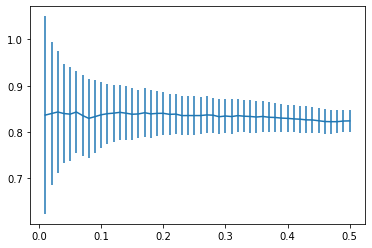

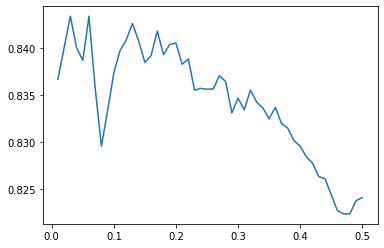

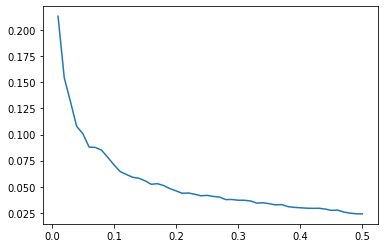

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

plt.errorbar(x=test_sizes,y=means,yerr=stds)
plt.show()
plt.plot(test_sizes,means)
plt.show()
plt.plot(test_sizes,stds)
plt.show()
plt.tight_layout()

The best train_test_split is 0.125 - 0.15, not 0.3!

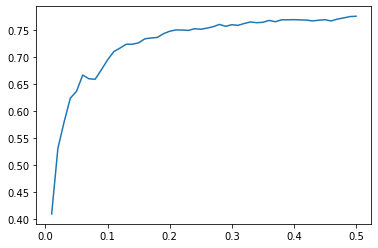

In [ ]:
plt.plot(test_sizes,[i - 2*j for i,j in zip(means,stds)])

In [ ]:
0.15*100

15.0

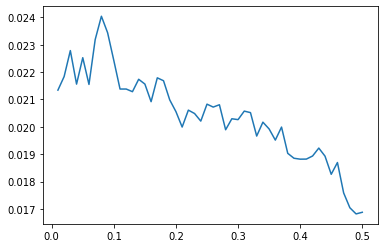

In [ ]:
plt.plot(test_sizes,[j*np.sqrt(k) for i,j,k in zip(means,stds,test_sizes)])

This is the error of the mean. Looks like we want to stay away from below 0.1 and the difference between 0.3 and 0.2 is actually almost nothing. Anything from 0.15 to 0.2 is fine.

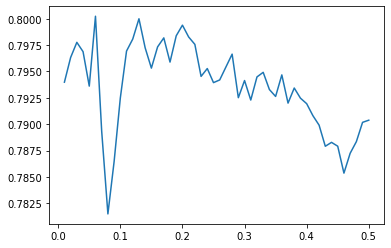

In [ ]:
plt.plot(test_sizes,[i-2*j*np.sqrt(k) for i,j,k in zip(means,stds,test_sizes)])

This is the 95% lower bound of the accuracy. If we want this to be as high as possible, we choose between 0.15 and 0.2.

### What if we compare 20/50/100/200 models? how many do you need?

In [ ]:
test_sizes_2_full=[]
means_2_full = []
stds_2_full = []
for i in range(98):
  print(i)
  mean,std = change_test_size(test_size=(99-i)/100,nr_models=2)
  means_2_full.append(mean)
  stds_2_full.append(std)
  test_sizes_2_full.append((99-i)/100)

0


  0%|          | 0/2 [00:00<?, ?it/s]

1


  0%|          | 0/2 [00:00<?, ?it/s]

2


  0%|          | 0/2 [00:00<?, ?it/s]

3


  0%|          | 0/2 [00:00<?, ?it/s]

4


  0%|          | 0/2 [00:00<?, ?it/s]

5


  0%|          | 0/2 [00:00<?, ?it/s]

6


  0%|          | 0/2 [00:00<?, ?it/s]

7


  0%|          | 0/2 [00:00<?, ?it/s]

8


  0%|          | 0/2 [00:00<?, ?it/s]

9


  0%|          | 0/2 [00:00<?, ?it/s]

10


  0%|          | 0/2 [00:00<?, ?it/s]

11


  0%|          | 0/2 [00:00<?, ?it/s]

12


  0%|          | 0/2 [00:00<?, ?it/s]

13


  0%|          | 0/2 [00:00<?, ?it/s]

14


  0%|          | 0/2 [00:00<?, ?it/s]

15


  0%|          | 0/2 [00:00<?, ?it/s]

16


  0%|          | 0/2 [00:00<?, ?it/s]

17


  0%|          | 0/2 [00:00<?, ?it/s]

18


  0%|          | 0/2 [00:00<?, ?it/s]

19


  0%|          | 0/2 [00:00<?, ?it/s]

20


  0%|          | 0/2 [00:00<?, ?it/s]

21


  0%|          | 0/2 [00:00<?, ?it/s]

22


  0%|          | 0/2 [00:00<?, ?it/s]

23


  0%|          | 0/2 [00:00<?, ?it/s]

24


  0%|          | 0/2 [00:00<?, ?it/s]

25


  0%|          | 0/2 [00:00<?, ?it/s]

26


  0%|          | 0/2 [00:00<?, ?it/s]

27


  0%|          | 0/2 [00:00<?, ?it/s]

28


  0%|          | 0/2 [00:00<?, ?it/s]

29


  0%|          | 0/2 [00:00<?, ?it/s]

30


  0%|          | 0/2 [00:00<?, ?it/s]

31


  0%|          | 0/2 [00:00<?, ?it/s]

32


  0%|          | 0/2 [00:00<?, ?it/s]

33


  0%|          | 0/2 [00:00<?, ?it/s]

34


  0%|          | 0/2 [00:00<?, ?it/s]

35


  0%|          | 0/2 [00:00<?, ?it/s]

36


  0%|          | 0/2 [00:00<?, ?it/s]

37


  0%|          | 0/2 [00:00<?, ?it/s]

38


  0%|          | 0/2 [00:00<?, ?it/s]

39


  0%|          | 0/2 [00:00<?, ?it/s]

40


  0%|          | 0/2 [00:00<?, ?it/s]

41


  0%|          | 0/2 [00:00<?, ?it/s]

42


  0%|          | 0/2 [00:00<?, ?it/s]

43


  0%|          | 0/2 [00:00<?, ?it/s]

44


  0%|          | 0/2 [00:00<?, ?it/s]

45


  0%|          | 0/2 [00:00<?, ?it/s]

46


  0%|          | 0/2 [00:00<?, ?it/s]

47


  0%|          | 0/2 [00:00<?, ?it/s]

48


  0%|          | 0/2 [00:00<?, ?it/s]

49


  0%|          | 0/2 [00:00<?, ?it/s]

50


  0%|          | 0/2 [00:00<?, ?it/s]

51


  0%|          | 0/2 [00:00<?, ?it/s]

52


  0%|          | 0/2 [00:00<?, ?it/s]

53


  0%|          | 0/2 [00:00<?, ?it/s]

54


  0%|          | 0/2 [00:00<?, ?it/s]

55


  0%|          | 0/2 [00:00<?, ?it/s]

56


  0%|          | 0/2 [00:00<?, ?it/s]

57


  0%|          | 0/2 [00:00<?, ?it/s]

58


  0%|          | 0/2 [00:00<?, ?it/s]

59


  0%|          | 0/2 [00:00<?, ?it/s]

60


  0%|          | 0/2 [00:00<?, ?it/s]

61


  0%|          | 0/2 [00:00<?, ?it/s]

62


  0%|          | 0/2 [00:00<?, ?it/s]

63


  0%|          | 0/2 [00:00<?, ?it/s]

64


  0%|          | 0/2 [00:00<?, ?it/s]

65


  0%|          | 0/2 [00:00<?, ?it/s]

66


  0%|          | 0/2 [00:00<?, ?it/s]

67


  0%|          | 0/2 [00:00<?, ?it/s]

68


  0%|          | 0/2 [00:00<?, ?it/s]

69


  0%|          | 0/2 [00:00<?, ?it/s]

70


  0%|          | 0/2 [00:00<?, ?it/s]

71


  0%|          | 0/2 [00:00<?, ?it/s]

72


  0%|          | 0/2 [00:00<?, ?it/s]

73


  0%|          | 0/2 [00:00<?, ?it/s]

74


  0%|          | 0/2 [00:00<?, ?it/s]

75


  0%|          | 0/2 [00:00<?, ?it/s]

76


  0%|          | 0/2 [00:00<?, ?it/s]

77


  0%|          | 0/2 [00:00<?, ?it/s]

78


  0%|          | 0/2 [00:00<?, ?it/s]

79


  0%|          | 0/2 [00:00<?, ?it/s]

80


  0%|          | 0/2 [00:00<?, ?it/s]

81


  0%|          | 0/2 [00:00<?, ?it/s]

82


  0%|          | 0/2 [00:00<?, ?it/s]

83


  0%|          | 0/2 [00:00<?, ?it/s]

84


  0%|          | 0/2 [00:00<?, ?it/s]

85


  0%|          | 0/2 [00:00<?, ?it/s]

86


  0%|          | 0/2 [00:00<?, ?it/s]

87


  0%|          | 0/2 [00:00<?, ?it/s]

88


  0%|          | 0/2 [00:00<?, ?it/s]

89


  0%|          | 0/2 [00:00<?, ?it/s]

90


  0%|          | 0/2 [00:00<?, ?it/s]

91


  0%|          | 0/2 [00:00<?, ?it/s]

92


  0%|          | 0/2 [00:00<?, ?it/s]

93


  0%|          | 0/2 [00:00<?, ?it/s]

94


  0%|          | 0/2 [00:00<?, ?it/s]

95


  0%|          | 0/2 [00:00<?, ?it/s]

96


  0%|          | 0/2 [00:00<?, ?it/s]

97


  0%|          | 0/2 [00:00<?, ?it/s]

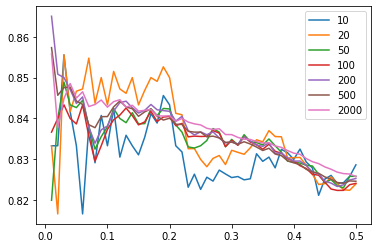

In [ ]:
plt.plot(test_sizes_10,[i for i,j,k in zip(means_10,stds_10,test_sizes_10)],label='10')
plt.plot(test_sizes_20,[i for i,j,k in zip(means_20,stds_20,test_sizes_20)],label='20')
plt.plot(test_sizes_50,[i for i,j,k in zip(means_50,stds_50,test_sizes_50)],label='50')
plt.plot(test_sizes_100,[i for i,j,k in zip(means_100,stds_100,test_sizes_100)],label='100')
plt.plot(test_sizes_200,[i for i,j,k in zip(means_200,stds_200,test_sizes_200)],label='200')
plt.plot(test_sizes_500,[i for i,j,k in zip(means_500,stds_500,test_sizes_500)],label='500')
plt.plot(test_sizes_2000,[i for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)],label='2000')

plt.legend()
plt.show()

## Nadeau and Bengio

### Didn't need to do this

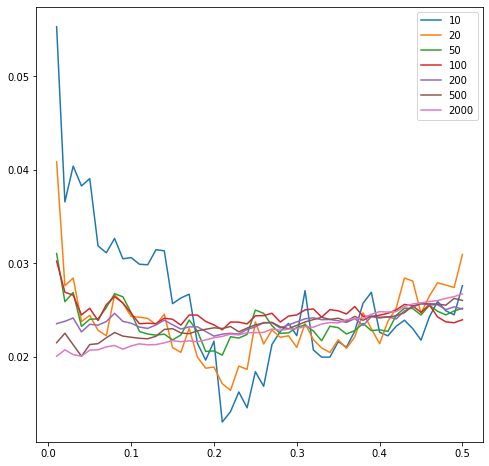

In [ ]:
# this is the error of the mean
# Here we use Nadeau and Bengio https://link.springer.com/content/pdf/10.1023/A:1024068626366.pdf
plt.figure(figsize=(8,8))
plt.plot(test_sizes_10,[j*np.sqrt(1/10+k/(1-k)) for i,j,k in zip(means_10,stds_10,test_sizes_10)],label='10')
plt.plot(test_sizes_20,[j*np.sqrt(1/20+k/(1-k)) for i,j,k in zip(means_20,stds_20,test_sizes_20)],label='20')
plt.plot(test_sizes_50,[j*np.sqrt(1/50+k/(1-k)) for i,j,k in zip(means_50,stds_50,test_sizes_50)],label='50')
plt.plot(test_sizes_100,[j*np.sqrt(1/100+k/(1-k)) for i,j,k in zip(means_100,stds_100,test_sizes_100)],label='100')
plt.plot(test_sizes_200,[j*np.sqrt(1/200+k/(1-k)) for i,j,k in zip(means_200,stds_200,test_sizes_200)],label='200')
plt.plot(test_sizes_500,[j*np.sqrt(1/500+k/(1-k)) for i,j,k in zip(means_500,stds_500,test_sizes_500)],label='500')
plt.plot(test_sizes_2000,[j*np.sqrt(1/2000+k/(1-k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)],label='2000')
plt.legend()
plt.show()

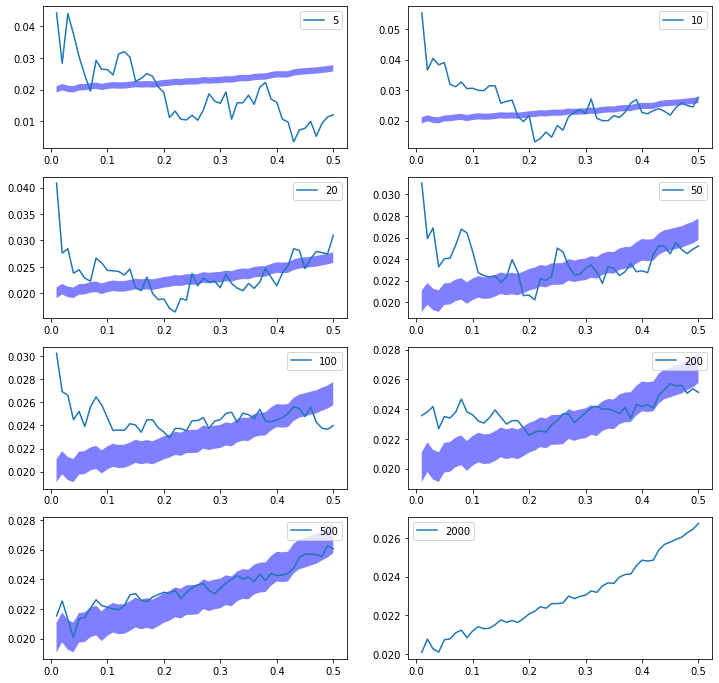

In [ ]:
error = 0.001
fig = plt.figure(figsize=(12,12))
plt.subplot(421)
plt.plot(test_sizes_5,[j*np.sqrt(1/10+k/(1-k)) for i,j,k in zip(means_5,stds_5,test_sizes_5)],label='5')
plt.fill_between(test_sizes_2000, 
                 [j*np.sqrt(1/2000+k/(1-k))-error for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)], 
                 [j*np.sqrt(1/2000+k/(1-k))+error for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)],
                 facecolor='blue', alpha=0.5)
plt.legend()
plt.subplot(422)
plt.plot(test_sizes_10,[j*np.sqrt(1/10+k/(1-k)) for i,j,k in zip(means_10,stds_10,test_sizes_10)],label='10')
plt.fill_between(test_sizes_2000, 
                 [j*np.sqrt(1/2000+k/(1-k))-error for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)], 
                 [j*np.sqrt(1/2000+k/(1-k))+error for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)],
                 facecolor='blue', alpha=0.5)
plt.legend()
plt.subplot(423)
plt.plot(test_sizes_20,[j*np.sqrt(1/20+k/(1-k)) for i,j,k in zip(means_20,stds_20,test_sizes_20)],label='20')
plt.fill_between(test_sizes_2000, 
                 [j*np.sqrt(1/2000+k/(1-k))-error for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)], 
                 [j*np.sqrt(1/2000+k/(1-k))+error for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)],
                 facecolor='blue', alpha=0.5)
plt.legend()
plt.subplot(424)
plt.plot(test_sizes_50,[j*np.sqrt(1/50+k/(1-k)) for i,j,k in zip(means_50,stds_50,test_sizes_50)],label='50')
plt.fill_between(test_sizes_2000, 
                 [j*np.sqrt(1/2000+k/(1-k))-error for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)], 
                 [j*np.sqrt(1/2000+k/(1-k))+error for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)],
                 facecolor='blue', alpha=0.5)
plt.legend()
plt.subplot(425)
plt.plot(test_sizes_100,[j*np.sqrt(1/100+k/(1-k)) for i,j,k in zip(means_100,stds_100,test_sizes_100)],label='100')
plt.fill_between(test_sizes_2000, 
                 [j*np.sqrt(1/2000+k/(1-k))-error for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)], 
                 [j*np.sqrt(1/2000+k/(1-k))+error for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)],
                 facecolor='blue', alpha=0.5)
plt.legend()
plt.subplot(426)
plt.plot(test_sizes_200,[j*np.sqrt(1/200+k/(1-k)) for i,j,k in zip(means_200,stds_200,test_sizes_200)],label='200')
plt.fill_between(test_sizes_2000, 
                 [j*np.sqrt(1/2000+k/(1-k))-error for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)], 
                 [j*np.sqrt(1/2000+k/(1-k))+error for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)],
                 facecolor='blue', alpha=0.5)
plt.legend()
plt.subplot(427)
plt.plot(test_sizes_500,[j*np.sqrt(1/500+k/(1-k)) for i,j,k in zip(means_500,stds_500,test_sizes_500)],label='500')
plt.fill_between(test_sizes_2000, 
                 [j*np.sqrt(1/2000+k/(1-k))-error for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)], 
                 [j*np.sqrt(1/2000+k/(1-k))+error for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)],
                 facecolor='blue', alpha=0.5)
plt.legend()
plt.subplot(428)
plt.plot(test_sizes_2000,[j*np.sqrt(1/2000+k/(1-k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)],label='2000')
plt.legend()
plt.show()

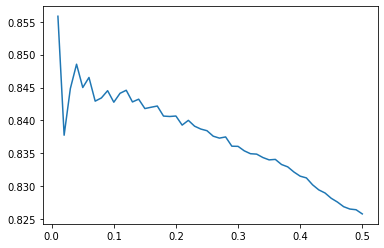

In [ ]:
# looking at if we can trust the first 0 - 0.1 of the test_size
plt.plot(test_sizes_2000,[i for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)],label='2000')

(0.0, 0.1)

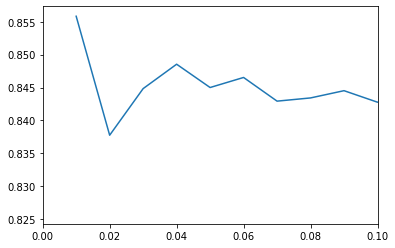

In [ ]:
# looking at if we can trust the first 0 - 0.1 of the test_size
plt.plot(test_sizes_2000,[i for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)],label='2000')
plt.xlim((0,0.1))

we cannot trust 2000 models beyond 0.04.

In [ ]:
unc_5 = [j*np.sqrt(1/5+k/(1-k)) for i,j,k in zip(means_5,stds_5,test_sizes_5)]
unc_10 = [j*np.sqrt(1/10+k/(1-k)) for i,j,k in zip(means_10,stds_10,test_sizes_10)]
unc_20 = [j*np.sqrt(1/20+k/(1-k)) for i,j,k in zip(means_20,stds_20,test_sizes_20)]
unc_50 = [j*np.sqrt(1/50+k/(1-k)) for i,j,k in zip(means_50,stds_50,test_sizes_50)]
unc_100 = [j*np.sqrt(1/100+k/(1-k)) for i,j,k in zip(means_100,stds_100,test_sizes_100)]
unc_200 = [j*np.sqrt(1/200+k/(1-k)) for i,j,k in zip(means_200,stds_200,test_sizes_200)]
unc_500 = [j*np.sqrt(1/500+k/(1-k)) for i,j,k in zip(means_500,stds_500,test_sizes_500)]
unc_2000 = [j*np.sqrt(1/2000+k/(1-k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]

def find_bound(unc_nr_models,unc_standard):
  bound = 100.
  test_fraction = 1.
  for error in np.arange(0.03,0.,-0.0001):
    if np.abs(unc_nr_models[0] - unc_standard[0]) > error:
      break
    for i in range(48):
      test_size = (50.-i)/100.
      if np.abs(unc_nr_models[i] - unc_standard[i]) > error:
        if unc_standard[i] + error < bound:
          bound = unc_standard[i] + error
          test_fraction = test_size
        break
  return test_fraction,bound


print(find_bound(unc_5,unc_2000))
print(find_bound(unc_10,unc_2000))
print(find_bound(unc_20,unc_2000))
print(find_bound(unc_50,unc_2000))
print(find_bound(unc_100,unc_2000))
print(find_bound(unc_200,unc_2000))
print(find_bound(unc_500,unc_2000))

(0.49, 0.04065854957278597)
(0.26, 0.02664136478634406)
(0.03, 0.026263600171295604)
(0.1, 0.023690508880273388)
(0.1, 0.024090508880273385)
(0.14, 0.02321991719632064)
(0.14, 0.022819917196320642)


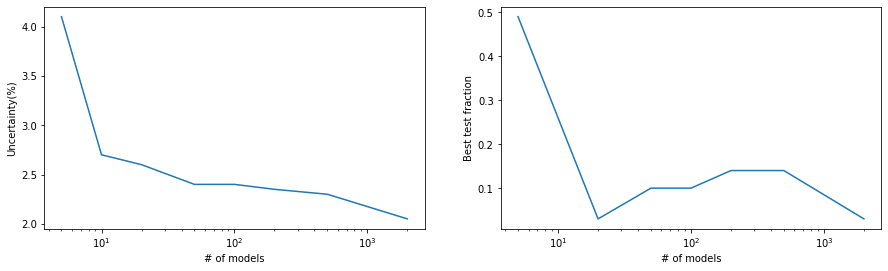

In [ ]:
plt.figure(figsize=(15,9))
plt.subplot(221)
plt.plot([5,10,20,50,100,200,500,2000],[4.1,2.7,2.6,2.4,2.4,2.35,2.3,2.05])
plt.xscale('log')
plt.ylabel('Uncertainty(%)')
plt.xlabel('# of models')
plt.subplot(222)
plt.plot([5,10,20,50,100,200,500,2000],[0.49,0.26,0.03,0.1,0.1,0.14,0.14,0.03])
plt.xscale('log')
plt.ylabel('Best test fraction')
plt.xlabel('# of models')
plt.show()

Table of # of models/ min test_size for reliability/ expected uncertainty/ 95% error bound based on minimum error of the accuracy (not best accuracy):

*   5 models: 0.49 / 4.1% / 8.2%
*   10 models: 0.26 / 2.7% / 5.4%
*   20 models: 0.03 / 2.6% / 5.2%
*   50 models: 0.1 / 2.4% / 4.8%
*   100 models: 0.1 / 2.4% / 4.8%
*   200 models: 0.14 / 2.35% / 4.7%
*   500 models: 0.14 / 2.3% / 4.4%
*   2000 models: 0 / 2.05% / 4.1%



now we look at accuracy - 2*error:

In [ ]:
def highest_lower_bound(unc_nr_models,unc_standard,standard):
  lower_bound = 0.
  test_fraction = 1.
  error_at_bound = 0.
  for error in np.arange(0.03,0.,-0.0001):
    if np.abs(unc_nr_models[0] - unc_standard[0]) > error:
      break
    for i in range(48):
      test_size = (50.-i)/100.
      if np.abs(unc_nr_models[i] - unc_standard[i]) > error:
        new_lower_bound = standard[i] - 2*(error+unc_standard[i])
        if new_lower_bound > lower_bound:
          lower_bound = new_lower_bound
          test_fraction = test_size
          error_at_bound = error+unc_standard[i]
        break
  print(f'highest lower bound of accuracy is {lower_bound:.4f} at {test_fraction} with uncertainty of {100*error_at_bound:.2f}%')

highest_lower_bound(unc_5,unc_2000,means_2000)
highest_lower_bound(unc_10,unc_2000,means_2000)
highest_lower_bound(unc_20,unc_2000,means_2000)
highest_lower_bound(unc_50,unc_2000,means_2000)
highest_lower_bound(unc_100,unc_2000,means_2000)
highest_lower_bound(unc_200,unc_2000,means_2000)
highest_lower_bound(unc_500,unc_2000,means_2000)

highest lower bound of accuracy is 0.7649 at 0.04 with uncertainty of 4.18%
highest lower bound of accuracy is 0.7843 at 0.26 with uncertainty of 2.66%
highest lower bound of accuracy is 0.7923 at 0.03 with uncertainty of 2.63%
highest lower bound of accuracy is 0.7956 at 0.09 with uncertainty of 2.44%
highest lower bound of accuracy is 0.7958 at 0.09 with uncertainty of 2.43%
highest lower bound of accuracy is 0.7978 at 0.09 with uncertainty of 2.33%
highest lower bound of accuracy is 0.7976 at 0.14 with uncertainty of 2.28%


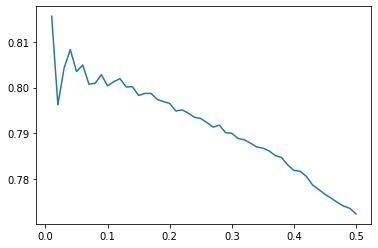

In [ ]:
plt.plot(test_sizes_2000,[i-2*j for i,j in zip(means_2000,unc_2000)],label='2000')

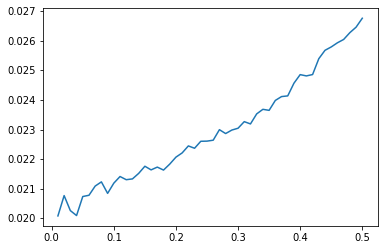

In [ ]:
plt.plot(test_sizes_2000,[j for i,j in zip(means_2000,unc_2000)],label='2000')

In [ ]:
unc_2000[-3]-unc_2000[-2]

-0.0005066621111267898

In [ ]:
np.max([i-2*(j+0.0004) for i,j in zip(means_2000,unc_2000)][:-6])

0.8020278407045209

In [ ]:
def lower_bound_at_10(unc_nr_models,unc_standard,standard):
  lower_bound = 0.
  test_fraction = 1.
  error_at_bound = 0.
  for error in np.arange(0.03,0.,-0.0001):
    if np.abs(unc_nr_models[0] - unc_standard[0]) > error:
      break
    for i in range(48):
      test_size = (50.-i)/100.
      if test_size == 0.1:
        test_fraction = test_size
        error_at_bound = error+unc_standard[i]
        break
      if np.abs(unc_nr_models[i] - unc_standard[i]) > error:
        new_lower_bound = standard[i] - 2*(error+unc_standard[i])
        if new_lower_bound > lower_bound:
          lower_bound = new_lower_bound
          test_fraction = test_size
          error_at_bound = error+unc_standard[i]
        break
  print(f'highest lower bound of accuracy is {lower_bound:.4f} at {test_fraction} with uncertainty of {100*error_at_bound:.2f}%')

lower_bound_at_10(unc_5,unc_2000,means_2000)
lower_bound_at_10(unc_10,unc_2000,means_2000)
lower_bound_at_10(unc_20,unc_2000,means_2000)
lower_bound_at_10(unc_50,unc_2000,means_2000)
lower_bound_at_10(unc_100,unc_2000,means_2000)
lower_bound_at_10(unc_200,unc_2000,means_2000)
lower_bound_at_10(unc_500,unc_2000,means_2000)

highest lower bound of accuracy is 0.7451 at 0.49 with uncertainty of 4.07%
highest lower bound of accuracy is 0.7843 at 0.26 with uncertainty of 2.66%
highest lower bound of accuracy is 0.7867 at 0.22 with uncertainty of 2.66%
highest lower bound of accuracy is 0.7890 at 0.25 with uncertainty of 2.47%
highest lower bound of accuracy is 0.7918 at 0.18 with uncertainty of 2.44%
highest lower bound of accuracy is 0.7968 at 0.14 with uncertainty of 2.32%
highest lower bound of accuracy is 0.7976 at 0.14 with uncertainty of 2.28%


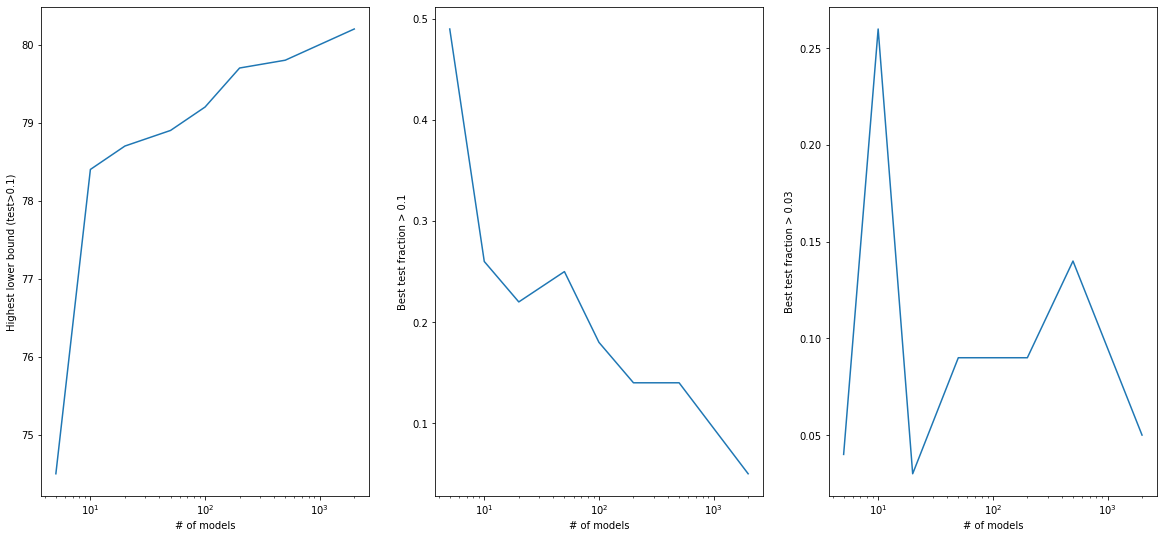

In [ ]:
plt.figure(figsize=(20,9))
plt.subplot(131)
plt.plot([5,10,20,50,100,200,500,2000],[74.5,78.4,78.7,78.9,79.2,79.7,79.8,80.2])
plt.xscale('log')
plt.ylabel('Highest lower bound (test>0.1)')
plt.xlabel('# of models')
ax1 = plt.subplot(132)
#color = 'tab:red'
ax1.plot([5,10,20,50,100,200,500,2000],[0.49,0.26,0.22,0.25,0.18,0.14,0.14,0.05])#, color=color)
plt.xscale('log')
plt.ylabel('Best test fraction > 0.1')#, color=color)
#ax1.tick_params(axis ='y', labelcolor = color)
plt.xlabel('# of models')
# ax2 = ax1.twinx()
#plt.subplot(133)
#ax2.plot([5,10,20,50,100,200,500,2000],[0.49*5,0.26*10,0.22*20,0.25*50,0.18*100,0.14*200,0.14*500,0.05*2000],color=color,label="total test size")
# ax2.tick_params(axis ='y', labelcolor = color)
#ax2.legend(loc='upper center')
plt.subplot(133)
plt.plot([5,10,20,50,100,200,500,2000],[0.04,0.26,0.03,0.09,0.09,0.09,0.14,0.05])
plt.xscale('log')
plt.ylabel('Best test fraction > 0.03')
plt.xlabel('# of models')
plt.show()

Take-away:  Once we restrict to > 0.1 test_fraction and remove the randomness in the 'control model', we get more varied and seemingly sensible answers. Basically it's a line fit on the log scale. For 100 models, we get about 18% test_fraction being best. 

Aside: maximizing mean - 1* error instead of mean - 2* error doesn't change any results so maximizing the certain lower bound and the probable lower bound gives the same results.

In [ ]:
unc_2_full

NameError: ignored

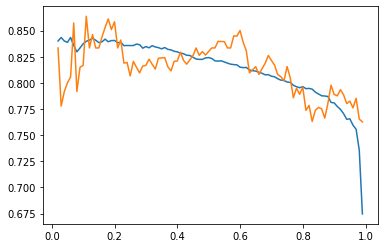

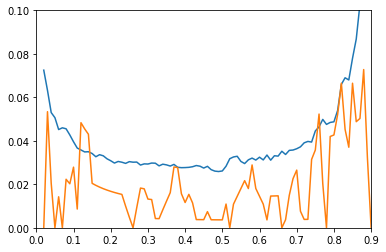

In [ ]:
unc_2_full = [j*np.sqrt(1/5+k/(1-k)) for i,j,k in zip(means_2_full,stds_2_full,test_sizes_2_full)]
unc_100_full = [j*np.sqrt(1/5+k/(1-k)) for i,j,k in zip(means_100_full,stds_100_full,test_sizes_100_full)]

plt.plot(test_sizes_100_full,[i for i,j in zip(means_100_full,unc_100_full)],label='100')
plt.plot(test_sizes_100_full,[i for i,j in zip(means_2_full,unc_2_full)],label='100')
plt.show()
plt.plot(test_sizes_100_full,[j for i,j in zip(means_100_full,unc_100_full)],label='100')
plt.plot(test_sizes_100_full,[j for i,j in zip(means_2_full,unc_2_full)],label='100')
plt.xlim([0,0.9])
plt.ylim([0,0.1])
plt.show()


This shows that you shouldn't have less than 50% training data because the model gets better with more training data and the uncertainty is no better for one side of 0.5 than the other.

I don't need to do any of this:

### Final answer to finding optimal train-test-split

In [8]:
varying_test_sizes = pd.read_csv('varying_test_sizes.csv')
means_2000,stds_2000,test_sizes_2000 = varying_test_sizes['means_2000'],varying_test_sizes['stds_2000'],varying_test_sizes['test_sizes_2000']

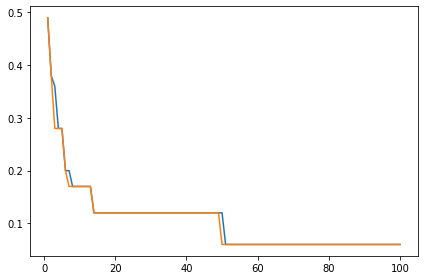

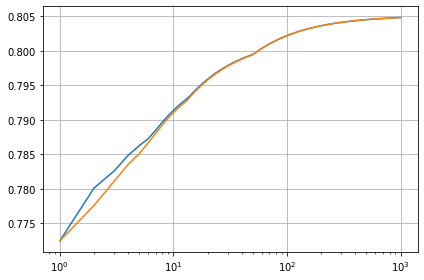

In [ ]:
import matplotlib.pyplot as plt

def guaranteed_accuracy(nr_models,means_2000,stds_2000,test_sizes_2000):
  means_2000 = means_2000[:-5]
  stds_2000 = stds_2000[:-5]
  test_sizes_2000 = test_sizes_2000[:-5]
  if nr_models > 1:
    #stds = [i*nr_models/(nr_models-1) for i in stds_2000] # don't need this because we are comparing to population mean, not sample mean
    loss = [i - 2*j*np.sqrt(1/nr_models+k/(nr_models/(nr_models-1)-k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]
  else:
    loss = [i - 2*j for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]
  return np.max(loss),(50-np.argmax(loss))/100

def probable_accuracy(nr_models,means_2000,stds_2000,test_sizes_2000):
  means_2000 = means_2000[:-5]
  stds_2000 = stds_2000[:-5]
  test_sizes_2000 = test_sizes_2000[:-5]
  #if nr_models > 1:
  loss = [i - 2*j*np.sqrt(1/nr_models+(nr_models-1)/nr_models*k/(1-k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]
  #else:
  #  loss = [i - j for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]
  return np.max(loss),(50-np.argmax(loss))/100

#   not enforcing scaling error of mean to training examples
#   loss = [i - 2*j*np.sqrt(1/nr_models+k/(nr_models/(nr_models-1))) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]

#   unique # of elements
#   loss = [i - 2*j*np.sqrt(k/(1-(1-k)**nr_models)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]


#   unique # of elements less than training examples
#   loss = [i - 2*j*np.sqrt(k/np.min([1-k,1-(1-k)**nr_models])) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]

x = np.linspace(1,100,100)
y = [guaranteed_accuracy(i,means_2000,stds_2000,test_sizes_2000)[1] for i in x]
plt.plot(x,y)

y = [probable_accuracy(i,means_2000,stds_2000,test_sizes_2000)[1] for i in x]
plt.plot(x,y)

plt.tight_layout()
plt.show()
x = np.linspace(1,1000,1000)
y = [guaranteed_accuracy(i,means_2000,stds_2000,test_sizes_2000)[0] for i in x]
plt.plot(x,y)

y = [probable_accuracy(i,means_2000,stds_2000,test_sizes_2000)[0] for i in x]
plt.plot(x,y)

plt.xscale('log')
plt.grid()
plt.tight_layout()
plt.show()

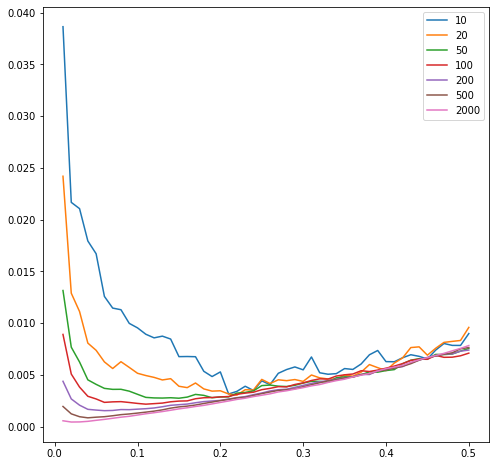

In [ ]:
# here we find the difference between accounting and not accounting for training set correlations according to N and B
plt.figure(figsize=(8,8))
plt.plot(test_sizes_10,[j*(np.sqrt(1/10+k/(1-k))-np.sqrt(k)) for i,j,k in zip(means_10,stds_10,test_sizes_10)],label='10')
plt.plot(test_sizes_20,[j*(np.sqrt(1/20+k/(1-k))-np.sqrt(k)) for i,j,k in zip(means_20,stds_20,test_sizes_20)],label='20')
plt.plot(test_sizes_50,[j*(np.sqrt(1/50+k/(1-k))-np.sqrt(k)) for i,j,k in zip(means_50,stds_50,test_sizes_50)],label='50')
plt.plot(test_sizes_100,[j*(np.sqrt(1/100+k/(1-k))-np.sqrt(k)) for i,j,k in zip(means_100,stds_100,test_sizes_100)],label='100')
plt.plot(test_sizes_200,[j*(np.sqrt(1/200+k/(1-k))-np.sqrt(k)) for i,j,k in zip(means_200,stds_200,test_sizes_200)],label='200')
plt.plot(test_sizes_500,[j*(np.sqrt(1/500+k/(1-k))-np.sqrt(k)) for i,j,k in zip(means_500,stds_500,test_sizes_500)],label='500')
plt.plot(test_sizes_2000,[j*(np.sqrt(1/2000+k/(1-k))-np.sqrt(k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)],label='2000')
plt.legend()
plt.show()

It's significant for all values of split!

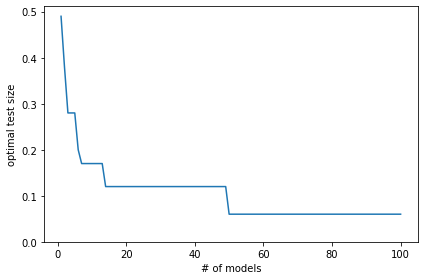

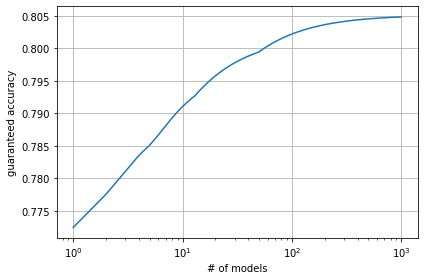

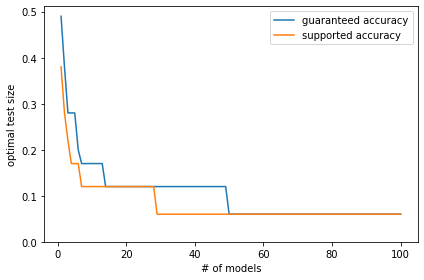

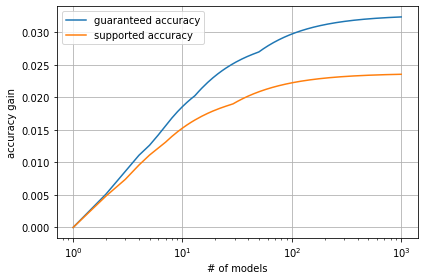

In [ ]:
def guaranteed_accuracy(nr_models,means_2000,stds_2000,test_sizes_2000):
  means_2000 = means_2000[:-5] # test size < 5% is too uncertain even for 2000 models
  stds_2000 = stds_2000[:-5]
  test_sizes_2000 = test_sizes_2000[:-5]
  loss = [i - 2*j*np.sqrt(1/nr_models+(nr_models-1)/nr_models*k/(1-k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]
  return np.max(loss),(50-np.argmax(loss))/100

def supported_accuracy(nr_models,means_2000,stds_2000,test_sizes_2000):
  means_2000 = means_2000[:-5] # test size < 5% is too uncertain even for 2000 models
  stds_2000 = stds_2000[:-5]
  test_sizes_2000 = test_sizes_2000[:-5]
  loss = [i - j*np.sqrt(1/nr_models+(nr_models-1)/nr_models*k/(1-k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]
  return np.max(loss),(50-np.argmax(loss))/100

x = np.linspace(1,100,100)
y = [guaranteed_accuracy(i,means_2000,stds_2000,test_sizes_2000)[1] for i in x]
plt.plot(x,y)
plt.ylim(bottom = 0.0)
plt.xlabel('# of models')
plt.ylabel('optimal test size')
plt.tight_layout()
plt.show()
x = np.linspace(1,1000,1000)
y = [guaranteed_accuracy(i,means_2000,stds_2000,test_sizes_2000)[0] for i in x]
plt.plot(x,y)
plt.xscale('log')
plt.xlabel('# of models')
plt.ylabel('guaranteed accuracy')
plt.grid()
plt.tight_layout()
plt.show()
x = np.linspace(1,100,100)
y = [guaranteed_accuracy(i,means_2000,stds_2000,test_sizes_2000)[1] for i in x]
plt.plot(x,y, label = 'guaranteed accuracy')
x = np.linspace(1,100,100)
y = [supported_accuracy(i,means_2000,stds_2000,test_sizes_2000)[1] for i in x]
plt.plot(x,y, label = 'supported accuracy')
plt.ylim(bottom = 0.0)
plt.xlabel('# of models')
plt.ylabel('optimal test size')
plt.legend()
plt.tight_layout()
plt.show()
x = np.linspace(1,1000,1000)
y_0 = guaranteed_accuracy(1,means_2000,stds_2000,test_sizes_2000)[0]
y = [guaranteed_accuracy(i,means_2000,stds_2000,test_sizes_2000)[0]- y_0 for i in x]
plt.plot(x,y, label = 'guaranteed accuracy')
y_0 = supported_accuracy(1,means_2000,stds_2000,test_sizes_2000)[0]
y = [supported_accuracy(i,means_2000,stds_2000,test_sizes_2000)[0]- y_0 for i in x]
plt.plot(x,y, label = 'supported accuracy')
plt.xscale('log')
plt.xlabel('# of models')
plt.ylabel('accuracy gain')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Let's also look at how this compares to cross validation (but here, we don't have a NB formula).

We could use `1/t + t`, thereby ignoring the `1/t` in the denominator which presumably comes from correlations in the test set.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from tqdm.auto import tqdm

pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(),
    LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear')
)

X_val = X_encoded.copy().values
y_val = y.copy().values

folds_cv=[]
means_cv = []
stds_cv = []
old_folds = 0
for pts_per_split in tqdm(range(2,int(len(y_val)/2))):
  folds = int(np.round(len(y_val)/pts_per_split))
  if folds != old_folds:
    print(folds)
    means = []
    stds = []
    for i in range(int(10*len(y)/folds)):
      kf = StratifiedKFold(n_splits=folds, shuffle = True, random_state=i)
      acc = []
      for train_index, test_index in kf.split(X_val,y_val):
        X_train, X_test = X_val[train_index], X_val[test_index]
        y_train, y_test = y_val[train_index], y_val[test_index]
        pipe_lr.fit(X_train,y_train)
        acc.append(pipe_lr.score(X_test,y_test))
      means.append(np.mean(acc))
      stds.append(np.std(acc,ddof=1))
    means_cv.append(np.mean(means))
    stds_cv.append(np.mean(stds))
    folds_cv.append(folds)
    old_folds = folds

  0%|          | 0/147 [00:00<?, ?it/s]

150


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 137 members, which is less than n_splits=150.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 137 members, which is less than n_splits=150.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 137 members, which is less than n_splits=150.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 137 members, which is less than n_splits=150.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 137 members, which is less than n_splits=150.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/s

100
75
60
50
43
37
33
30
27
25
23
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2


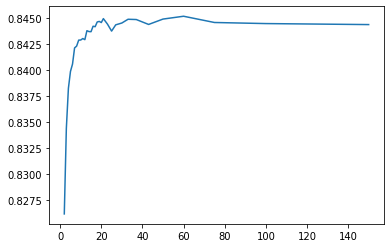

In [ ]:
plt.plot(folds_cv,means_cv)

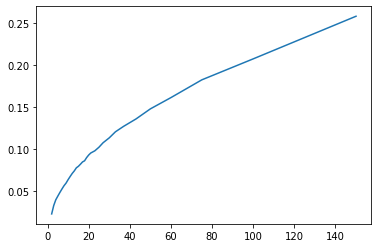

In [ ]:
plt.plot(folds_cv,[std for fold,std in zip(folds_cv,stds_cv)])

t = 1/fold, 1/J = 1/fold

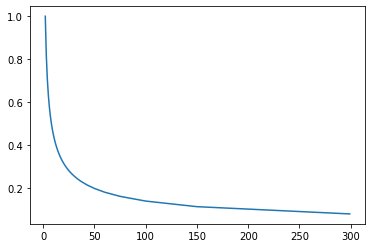

In [ ]:
plt.plot(folds_cv,[np.sqrt(2/fold) for fold,std in zip(folds_cv,stds_cv)])

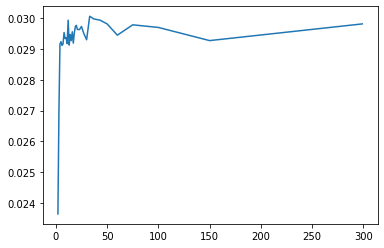

In [ ]:
plt.plot(folds_cv,[np.sqrt(2/fold)*std for fold,std in zip(folds_cv,stds_cv)])

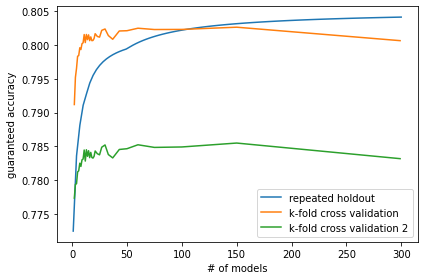

In [ ]:
def guaranteed_accuracy(nr_models,means_2000,stds_2000,test_sizes_2000):
  means_2000 = means_2000[:-5] # test size < 5% is too uncertain even for 2000 models
  stds_2000 = stds_2000[:-5]
  test_sizes_2000 = test_sizes_2000[:-5]
  loss = [i - 2*j*np.sqrt(1/nr_models+(nr_models-1)/nr_models*k/(1-k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]
  return np.max(loss),(50-np.argmax(loss))/100

# 22% correction for leave-one-out case is not included for simplicity
def guaranteed_accuracy_cv_1(mean,std,fold):
  return mean - 2*std*np.sqrt(1/fold)

def guaranteed_accuracy_cv_2(mean,std,fold):
  return mean - 2*std*np.sqrt(2/fold)

def supported_accuracy_cv_2(mean,std,fold):
  return mean - std*np.sqrt(2/fold)

x = np.linspace(1,300,100)
y = [guaranteed_accuracy(i,means_2000,stds_2000,test_sizes_2000)[0] for i in x]
plt.plot(x,y,label='repeated holdout')
y = [guaranteed_accuracy_cv_1(i,j,k) for i,j,k in zip(means_cv, stds_cv, folds_cv)]
plt.plot(folds_cv,y, label = 'k-fold cross validation')
y = [guaranteed_accuracy_cv_2(i,j,k) for i,j,k in zip(means_cv, stds_cv, folds_cv)]
plt.plot(folds_cv,y, label = 'k-fold cross validation 2')
plt.xlabel('# of models')
plt.ylabel('guaranteed accuracy')
plt.tight_layout()
plt.legend()
plt.show()

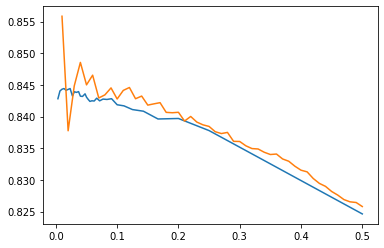

In [ ]:
plt.plot([1/i for i in folds_cv],means_cv)
plt.plot(test_sizes_2000,means_2000)

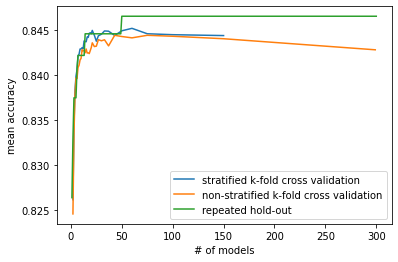

In [ ]:
plt.plot(folds_cv,means_cv,label = 'stratified k-fold cross validation')
plt.plot(folds_cv_no_strat,means_cv_no_strat,label = 'non-stratified k-fold cross validation')
nr_models_ = np.linspace(1,300,300)
test_sizes_ = [guaranteed_accuracy(i,means_2000,stds_2000,test_sizes_2000)[1] for i in nr_models_]
indices_ = [(np.abs(test_sizes_2000 - i)).argmin() for i in test_sizes_]
means_ = [means_2000[i] for i in indices_]
plt.plot(nr_models_,means_,label='repeated hold-out')
plt.xlabel('# of models')
plt.ylabel('mean accuracy')
plt.legend()

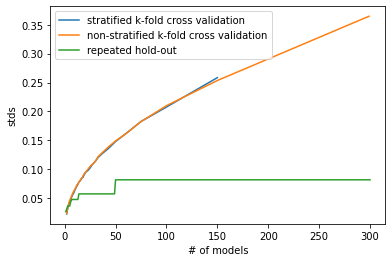

In [ ]:
def guaranteed_accuracy(nr_models,means_2000,stds_2000,test_sizes_2000):
  means_2000 = means_2000[:-5] # test size < 5% is too uncertain even for 2000 models
  stds_2000 = stds_2000[:-5]
  test_sizes_2000 = test_sizes_2000[:-5]
  loss = [i - 2*j*np.sqrt(1/nr_models+(nr_models-1)/nr_models*k/(1-k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]
  return np.max(loss),(50-np.argmax(loss))/100

plt.plot(folds_cv,stds_cv,label = 'stratified k-fold cross validation')
plt.plot(folds_cv_no_strat,stds_cv_no_strat,label = 'non-stratified k-fold cross validation')
nr_models_ = np.linspace(1,300,300)
test_sizes_ = [guaranteed_accuracy(i,means_2000,stds_2000,test_sizes_2000)[1] for i in nr_models_]
indices_ = [(np.abs(test_sizes_2000 - i)).argmin() for i in test_sizes_]
stds_ = [stds_2000[i] for nr,i in zip(nr_models_,indices_)]
plt.plot(nr_models_,stds_,label='repeated hold-out')
plt.xlabel('# of models')
plt.ylabel('stds')
plt.legend()

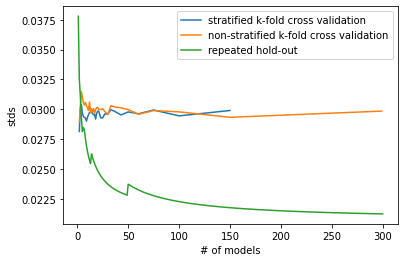

In [ ]:
def guaranteed_accuracy(nr_models,means_2000,stds_2000,test_sizes_2000):
  means_2000 = means_2000[:-5] # test size < 5% is too uncertain even for 2000 models
  stds_2000 = stds_2000[:-5]
  test_sizes_2000 = test_sizes_2000[:-5]
  loss = [i - 2*j*np.sqrt(1/nr_models+(nr_models-1)/nr_models*k/(1-k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]
  return np.max(loss),(50-np.argmax(loss))/100

plt.plot(folds_cv,[i*np.sqrt(1/(j) + 1/(j)/(1-1/(j))) for i,j in zip(stds_cv,folds_cv)],label = 'stratified k-fold cross validation')
plt.plot(folds_cv_no_strat,[i*np.sqrt(1/(j) + 1/(j)/(1-1/(j))) for i,j in zip(stds_cv_no_strat,folds_cv_no_strat)],label = 'non-stratified k-fold cross validation')
nr_models_ = np.linspace(1,300,300)
test_sizes_ = [guaranteed_accuracy(i,means_2000,stds_2000,test_sizes_2000)[1] for i in nr_models_]
indices_ = [(np.abs(test_sizes_2000 - i)).argmin() for i in test_sizes_]
stds_ = [stds_2000[i]*np.sqrt(1/(nr) + test_sizes_2000[i]/(1-test_sizes_2000[i])) for nr,i in zip(nr_models_,indices_)]
plt.plot(nr_models_,stds_,label='repeated hold-out')
plt.xlabel('# of models')
plt.ylabel('stds')
plt.legend()

This shows that you cannot use the standard deviation from the k-fold part itself and plug it into the NB formula.

In [ ]:
guaranteed_accuracy(1,means_2000,stds_2000,test_sizes_2000)[0]

0.7724495712106012

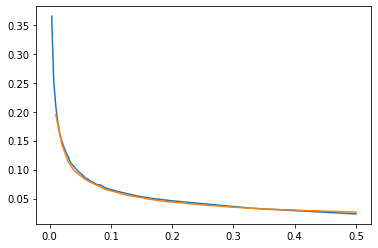

In [ ]:
plt.plot([1/i for i in folds_cv],stds_cv)
plt.plot(test_sizes_2000,stds_2000)

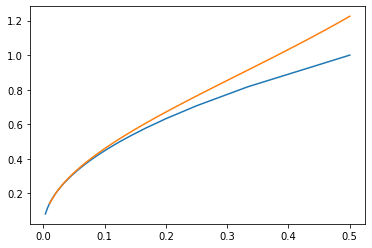

In [ ]:
plt.plot([1/i for i in folds_cv],[np.sqrt(2/i) for i in folds_cv])
plt.plot(test_sizes_2000,[np.sqrt(j + j/(1-j)) for j in test_sizes_2000])

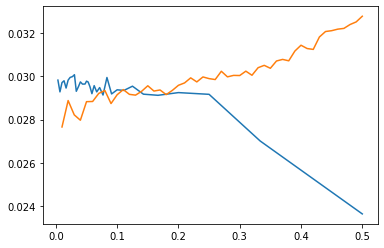

In [ ]:
plt.plot([1/i for i in folds_cv],[std*np.sqrt(2/fold) for fold,std in zip(folds_cv,stds_cv)])
plt.plot(test_sizes_2000,[std*np.sqrt(t + t/(1-t)) for t,std in zip(test_sizes_2000,stds_2000)])

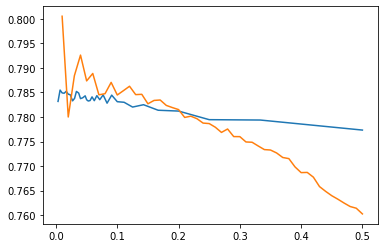

In [ ]:
plt.plot([1/i for i in folds_cv],[mean - 2*std*np.sqrt(2/fold) for fold,std,mean in zip(folds_cv,stds_cv,means_cv)])
plt.plot(test_sizes_2000,[mean - 2*std*np.sqrt(t + t/(1-t)) for t,std,mean in zip(test_sizes_2000,stds_2000,means_2000)])

In [ ]:
to_log = pd.DataFrame(list(zip(means_cv,stds_cv,folds_cv)),columns = ['means_cv','stds_cv','folds_cv'])
to_log.to_csv('varying_folds_cv.csv')

In [60]:
varying_folds_cv = pd.read_csv('varying_folds_cv.csv')
means_cv_no_strat,stds_cv_no_strat,folds_cv_no_strat = varying_folds_cv['means_cv'],varying_folds_cv['stds_cv'],varying_folds_cv['folds_cv']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from tqdm.auto import tqdm

pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(),
    LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear')
)

X_val = X_encoded.copy().values
y_val = y.copy().values

folds = len(y_val)
means = []
stds = []
kf = KFold(n_splits=folds, shuffle = True, random_state=1)
acc = []
for train_index, test_index in kf.split(X_val):
  X_train, X_test = X_val[train_index], X_val[test_index]
  y_train, y_test = y_val[train_index], y_val[test_index]
  pipe_lr.fit(X_train,y_train)
  acc.append(pipe_lr.score(X_test,y_test))
print(np.mean(acc))
print(np.std(acc,ddof=1))

0.842809364548495
0.36459060488958833


In [ ]:
np.std(acc,ddof=1)*np.sqrt(1/len(y))

0.021084819086225264

In [ ]:
stds_2000[-5:]

45    0.089972
46    0.097866
47    0.114303
48    0.143643
49    0.195062
Name: stds_2000, dtype: float64

In [ ]:
stds_2000[-5:]*np.sqrt(1/2000+0.05/(1-0.05))

45    0.020739
46    0.022558
47    0.026347
48    0.033110
49    0.044962
Name: stds_2000, dtype: float64

In [ ]:
max_guaranteed = np.mean(acc) - 2*np.std(acc,ddof=1)*np.sqrt(1/len(y))
max_supported = np.mean(acc) - np.std(acc,ddof=1)*np.sqrt(1/len(y))

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from tqdm.auto import tqdm

pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(),
    LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear')
)

acc = []
for i in tqdm(y.index):
  for j in y.index:
    if i != j:
      test_index = [i,j]
      train_index = set(y.index) - set(test_index)
      x_test = X_encoded.loc[test_index]
      x_train = X_encoded.loc[train_index]
      y_test = y.loc[test_index]
      y_train = y.loc[train_index]
      pipe_lr.fit(x_train,y_train)
      acc.append(pipe_lr.score(x_test,y_test))      
print(np.mean(acc))
print(np.std(acc,ddof=1))

  0%|          | 0/299 [00:00<?, ?it/s]

0.8435388655697964
0.2558454628784861


Text(0, 0.5, 'mean accuracy')

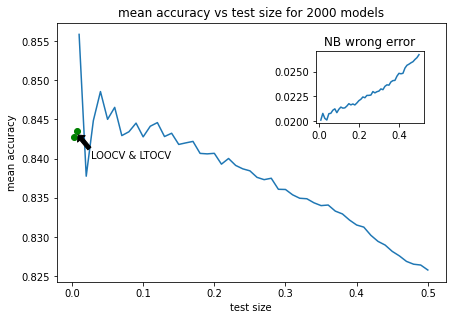

In [4]:
fig = plt.figure()
outside = fig.add_axes([0.1,0.1,0.9,0.9])
inside = fig.add_axes([0.7,0.65,0.25,0.25])
outside.plot(test_sizes_2000,means_2000)
outside.plot(1/len(y),0.842809364548495,'go')
outside.plot(2/len(y),0.8435388655697964,'go')
outside.annotate('LOOCV & LTOCV', xy=(2/len(y)+0.002, 0.843), 
            xytext=(8/len(y), 0.84),
             arrowprops = dict(headlength=5,headwidth=10,color='k')
            )
inside.plot(test_sizes_2000,[j*np.sqrt(1/2000+(2000-1)/2000*k/(1-k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)])
inside.set_title('NB wrong error')
outside.set_title('mean accuracy vs test size for 2000 models')
outside.set_xlabel('test size')
outside.set_ylabel('mean accuracy')

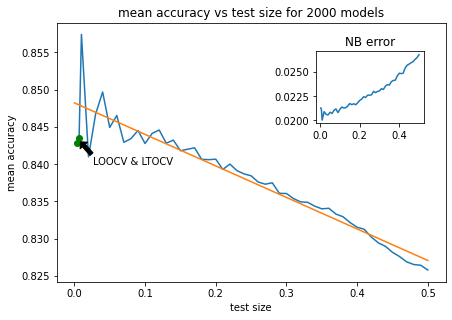

In [66]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(test_sizes_2000.values.reshape(-1,1), means_2000.values.reshape(-1,1))
xx = np.linspace(0.0,0.5,100)
yy = lr.predict(xx.reshape(-1,1))
fig = plt.figure()
outside = fig.add_axes([0.1,0.1,0.9,0.9])
inside = fig.add_axes([0.7,0.65,0.25,0.25])
outside.plot(test_sizes_2000,means_2000)
outside.plot(1/len(y),0.842809364548495,'go')
outside.plot(2/len(y),0.8435388655697964,'go')
outside.annotate('LOOCV & LTOCV', xy=(2/len(y)+0.002, 0.843), 
            xytext=(8/len(y), 0.84),
             arrowprops = dict(headlength=5,headwidth=10,color='k')
            )
inside.plot(test_sizes_2000,[j*np.sqrt(1/20000+(20000-1)/20000*k/(1-k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)])
inside.set_title('NB error')
outside.set_title('mean accuracy vs test size for 2000 models')
outside.set_xlabel('test size')
outside.set_ylabel('mean accuracy')
outside.plot(xx,yy)

In [15]:
lr.predict([[test_sizes_2000.loc[0]]])

array([[0.82695978]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


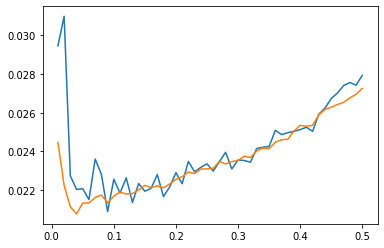

In [109]:
residues = pd.Series(index = test_sizes_2000.index)
for i in test_sizes_2000.index:
  y_line = lr.predict([[test_sizes_2000.loc[i]]])
  residues.loc[i] = means_2000.loc[i] - y_line
plt.plot(test_sizes_2000,[l+j*np.sqrt(1/2000+k/(1-k)+1/60000/k) for i,j,k,l in zip(means_2000,stds_2000,test_sizes_2000,residues.apply(np.abs).rolling(1).mean())])
plt.plot(test_sizes_2000,[0.0005+j*np.sqrt(1/20000+k/(1-k)+1/20000*(1-k)/k) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)])

In [113]:
from sklearn.linear_model import LogisticRegression

def change_test_size(test_size,nr_models):
  def Logistic(x_train,y_train,x_test):
    model = LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear')
    model.fit(x_train,y_train)
    return model.predict(x_train), model.predict(x_test)

  def with_PCA(X,y,test_size,random_state = 1):
    scaled_data = preprocessing.scale(X_encoded)
    scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
    x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, stratify=y,test_size = test_size, random_state = random_state)
    pca = PCA()
    pca.fit(x_train)
    pca_x_train = pca.transform(x_train)
    pca_x_test = pca.transform(x_test)
    y_train_pred,y_test_pred = Logistic(pca_x_train,y_train,pca_x_test)
    return accuracy_score(y_train,y_train_pred), accuracy_score(y_test,y_test_pred)

  acc_pca_train = []
  acc_pca_test = []
  acc_nopca_train = []
  acc_nopca_test = []
  for i in tqdm(range(nr_models)):
    acc1, acc2 = with_PCA(X_encoded,y,test_size,i)
    acc_pca_train.append(acc1)
    acc_pca_test.append(acc2)
  return np.mean(acc_pca_test), np.std(acc_pca_test)

test_sizes_bias=[]
means_bias = []
stds_bias = []
for i in range(1,6):
  test_size = i/100
  print(test_size)
  mean,std = change_test_size(test_size=test_size,nr_models=20000)
  means_bias.append(mean)
  stds_bias.append(std)
  test_sizes_bias.append(test_size)

0.01


  0%|          | 0/20000 [00:00<?, ?it/s]

0.02


  0%|          | 0/20000 [00:00<?, ?it/s]

0.03


  0%|          | 0/20000 [00:00<?, ?it/s]

0.04


  0%|          | 0/20000 [00:00<?, ?it/s]

0.05


  0%|          | 0/20000 [00:00<?, ?it/s]

In [119]:
for i in zip(test_sizes_bias,means_bias,stds_bias):
  print(i)

(0.01, 0.8574166666666666, 0.19876841284380284)
(0.02, 0.8409833333333334, 0.146087225656455)
(0.03, 0.8467111111111113, 0.11714209162222446)
(0.04, 0.8496791666666667, 0.1006567040289529)
(0.05, 0.8449233333333334, 0.09078365436575024)


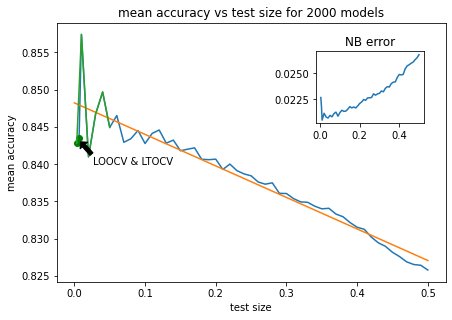

In [63]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(test_sizes_2000.values.reshape(-1,1), means_2000.values.reshape(-1,1))
xx = np.linspace(0.0,0.5,100)
yy = lr.predict(xx.reshape(-1,1))
fig = plt.figure()
outside = fig.add_axes([0.1,0.1,0.9,0.9])
inside = fig.add_axes([0.7,0.65,0.25,0.25])
outside.plot(test_sizes_2000,means_2000)
outside.plot(1/len(y),0.842809364548495,'go')
outside.plot(2/len(y),0.8435388655697964,'go')
outside.annotate('LOOCV & LTOCV', xy=(2/len(y)+0.002, 0.843), 
            xytext=(8/len(y), 0.84),
             arrowprops = dict(headlength=5,headwidth=10,color='k')
            )
inside.plot(test_sizes_2000,[j*np.sqrt(1/2000+(2000-1)/2000*k/(1-k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)])
inside.set_title('NB wrong error')
outside.set_title('mean accuracy vs test size for 2000 models')
outside.set_xlabel('test size')
outside.set_ylabel('mean accuracy')
outside.plot(xx,yy)
outside.plot(test_sizes_bias,means_bias)

The conclusion is that the points are starting to diverge because of random bias, not variance (meaning it doesn't average to zero).

In [4]:
a00,b00,c00 = (1/len(y), 0.842809364548495, 0.36459060488958833)
a0,b0,c0 = (0.01, 0.8574166666666666, 0.19876841284380284)
a1,b1,c1 = (0.02, 0.8409833333333334, 0.146087225656455)
a2,b2,c2 = (0.03, 0.8467111111111113, 0.11714209162222446)
a3,b3,c3 = (0.04, 0.8496791666666667, 0.1006567040289529)
a4,b4,c4 = (0.05, 0.8449233333333334, 0.09078365436575024)

test_sizes_bias = pd.Series([a00,a0,a1,a2,a3,a4])
means_bias = pd.Series([b00,b0,b1,b2,b3,b4])
stds_bias = pd.Series([c00,c0,c1,c2,c3,c4])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


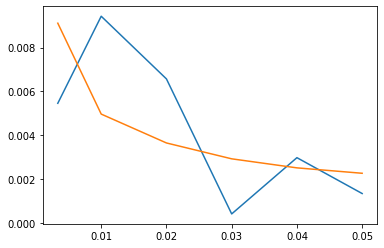

In [215]:
residues_bias = pd.Series(index = test_sizes_bias.index)
for i in test_sizes_bias.index:
  y_line = lr.predict([[test_sizes_bias.loc[i]]])
  residues_bias.loc[i] = means_bias.loc[i] - y_line
#plt.plot(test_sizes_bias,residues)
plt.plot(test_sizes_bias,residues_bias.apply(np.abs))
plt.plot(test_sizes_bias,[j/40 for i,j,k,l in zip(means_bias,stds_bias,test_sizes_bias,residues_bias.apply(np.abs).rolling(1).mean())])

#plt.plot(test_sizes_bias,[j*np.sqrt(1/20000+k/(1-k)+(0.008*(1-k/0.05)))-0.02 for i,j,k,l in zip(means_bias,stds_bias,test_sizes_bias,residues.apply(np.abs).rolling(1).mean())])
#plt.plot(test_sizes_bias,[0.0005+j*np.sqrt(1/20000+k/(1-k)+1/20000*(1-k)/k) for i,j,k in zip(means_bias,stds_bias,test_sizes_bias)])

In [212]:
1600/300

5.333333333333333

In [236]:
test_sizes_2000[25]

0.25

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


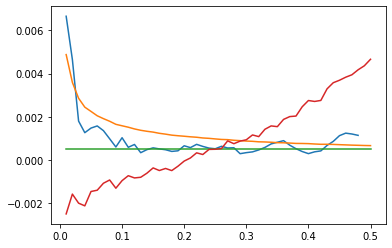

In [242]:
residues = pd.Series(index = test_sizes_2000.index)
for i in test_sizes_2000.index:
  y_line = lr.predict([[test_sizes_2000.loc[i]]])
  residues.loc[i] = means_2000.loc[i] - y_line
plt.plot(test_sizes_2000,residues.apply(np.abs).rolling(3).mean())
nb_error_at_pt_two_five = stds_2000[25]*np.sqrt(0.25/(1-0.25))
res_at_pt_two_five = 0.0005
plt.plot(test_sizes_2000,[j/40 for j in stds_2000])
plt.plot(test_sizes_2000,[res_at_pt_two_five for j in stds_2000])
plt.plot(test_sizes_2000,[res_at_pt_two_five + j*np.sqrt(k/(1-k)) - nb_error_at_pt_two_five for j,k in zip(stds_2000,test_sizes_2000)])


The NB error is just doing a great job at predicting on the whole population due to impact of the train set. It doesn't take into account the test set.

It vanishes so quickly, it's looking more and more like an exponential to me.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


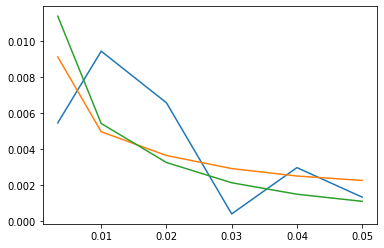

In [287]:
residues_bias = pd.Series(index = test_sizes_bias.index)
for i in test_sizes_bias.index:
  y_line = lr.predict([[test_sizes_bias.loc[i]]])
  residues_bias.loc[i] = means_bias.loc[i] - y_line
plt.plot(test_sizes_bias,residues_bias.apply(np.abs))
plt.plot(test_sizes_bias,[j/40 for i,j,k,l in zip(means_bias,stds_bias,test_sizes_bias,residues_bias.apply(np.abs).rolling(1).mean())])
plt.plot(test_sizes_bias,[j/30*np.exp(-k/0.05) for i,j,k,l in zip(means_bias,stds_bias,test_sizes_bias,residues_bias.apply(np.abs).rolling(1).mean())])
#plt.plot(test_sizes_bias,[j*np.sqrt(1/20000+k/(1-k)+(0.008*(1-k/0.05)))-0.02 for i,j,k,l in zip(means_bias,stds_bias,test_sizes_bias,residues.apply(np.abs).rolling(1).mean())])
#plt.plot(test_sizes_bias,[0.0005+j*np.sqrt(1/20000+k/(1-k)+1/20000*(1-k)/k) for i,j,k in zip(means_bias,stds_bias,test_sizes_bias)])

Actually, an exponential might not work so well but if the first point is an outlier, then it might.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


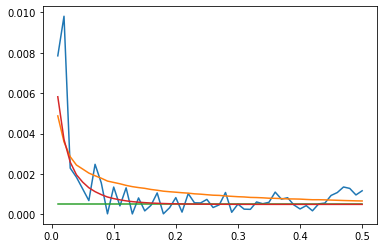

In [288]:
residues = pd.Series(index = test_sizes_2000.index)
for i in test_sizes_2000.index:
  y_line = lr.predict([[test_sizes_2000.loc[i]]])
  residues.loc[i] = means_2000.loc[i] - y_line
plt.plot(test_sizes_2000,residues.apply(np.abs))
plt.plot(test_sizes_2000,[j/40 for j in stds_2000])
plt.plot(test_sizes_2000,[res_at_pt_two_five for j in stds_2000])
plt.plot(test_sizes_2000,[res_at_pt_two_five + j/30*np.exp(-k/0.05) for j,k in zip(stds_2000, test_sizes_2000)])

This seems to work very well. Here `res_at_pt_two_five` is just the base flutter (variance) due to only having 2000 models.

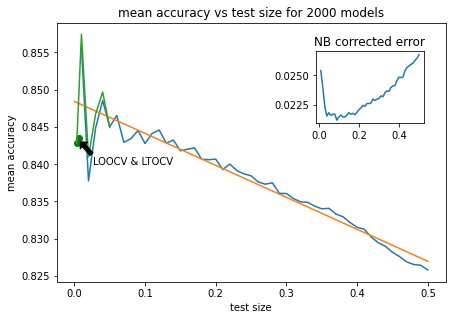

In [280]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(test_sizes_2000.values.reshape(-1,1), means_2000.values.reshape(-1,1))
xx = np.linspace(0.0,0.5,100)
yy = lr.predict(xx.reshape(-1,1))
fig = plt.figure()
outside = fig.add_axes([0.1,0.1,0.9,0.9])
inside = fig.add_axes([0.7,0.65,0.25,0.25])
outside.plot(test_sizes_2000,means_2000)
outside.plot(1/len(y),0.842809364548495,'go')
outside.plot(2/len(y),0.8435388655697964,'go')
outside.annotate('LOOCV & LTOCV', xy=(2/len(y)+0.002, 0.843), 
            xytext=(8/len(y), 0.84),
             arrowprops = dict(headlength=5,headwidth=10,color='k')
            )
inside.plot(test_sizes_2000,[j*(np.sqrt(1/2000+(2000-1)/2000*k/(1-k))+1/30*np.exp(-k/0.05)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)])
#inside.plot(test_sizes_2000,[j*(np.sqrt(1/160+(2000-1)/2000*k/(1-k))) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)])
inside.set_title('NB corrected error')
outside.set_title('mean accuracy vs test size for 2000 models')
outside.set_xlabel('test size')
outside.set_ylabel('mean accuracy')
outside.plot(xx,yy)
outside.plot(test_sizes_bias,means_bias)

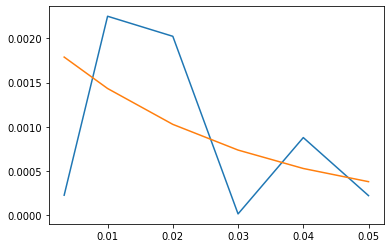

In [308]:
plt.plot(test_sizes_bias,[(i/j)**2 for i,j,k in zip(residues_bias.apply(np.abs),stds_bias,test_sizes_bias)]) # this is what goes inside the square root
plt.plot(test_sizes_bias,[0.002*np.exp(-i/0.03) for i in test_sizes_bias])

That seems to work pretty well.

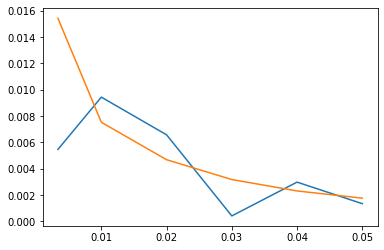

In [298]:
plt.plot(test_sizes_bias,residues_bias.apply(np.abs))
plt.plot(test_sizes_bias,[j*np.sqrt(0.002*np.exp(-k/0.03)) for j,k in zip(stds_bias,test_sizes_bias)])

This works if we assume the LOO thing is an outlier.

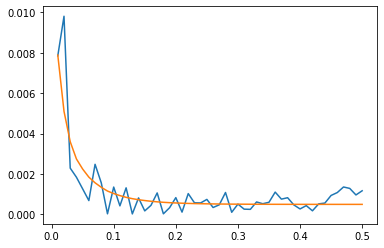

In [299]:
plt.plot(test_sizes_2000,residues.apply(np.abs))
plt.plot(test_sizes_2000,[res_at_pt_two_five + j*np.sqrt(0.002*np.exp(-k/0.03)) for j,k in zip(stds_2000, test_sizes_2000)])

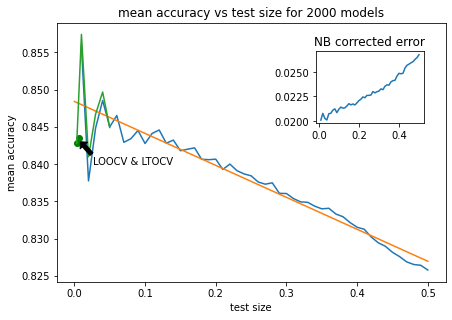

In [304]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(test_sizes_2000.values.reshape(-1,1), means_2000.values.reshape(-1,1))
xx = np.linspace(0.0,0.5,100)
yy = lr.predict(xx.reshape(-1,1))
fig = plt.figure()
outside = fig.add_axes([0.1,0.1,0.9,0.9])
inside = fig.add_axes([0.7,0.65,0.25,0.25])
outside.plot(test_sizes_2000,means_2000)
outside.plot(1/len(y),0.842809364548495,'go')
outside.plot(2/len(y),0.8435388655697964,'go')
outside.annotate('LOOCV & LTOCV', xy=(2/len(y)+0.002, 0.843), 
            xytext=(8/len(y), 0.84),
             arrowprops = dict(headlength=5,headwidth=10,color='k')
            )
inside.plot(test_sizes_2000,[j*np.sqrt(1/2000+k/(1-k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)])
inside.set_title('NB corrected error')
outside.set_title('mean accuracy vs test size for 2000 models')
outside.set_xlabel('test size')
outside.set_ylabel('mean accuracy')
outside.plot(xx,yy)
outside.plot(test_sizes_bias,means_bias)

This is obviously wrong.

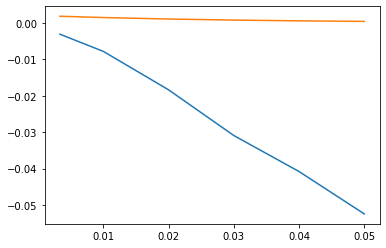

In [315]:
plt.plot(test_sizes_bias,[(i/j)**2 - k/(1-k) for i,j,k in zip(residues_bias.apply(np.abs),stds_bias,test_sizes_bias)]) # this is what goes inside the square root
plt.plot(test_sizes_bias,[0.002*np.exp(-i/0.03) for i in test_sizes_bias])

You can just see the scale difference. While we are still improving our model's performance by 0.05 (arb. units) within this range, the test set bias only has a scale of 0.002, a factor of 25 less.

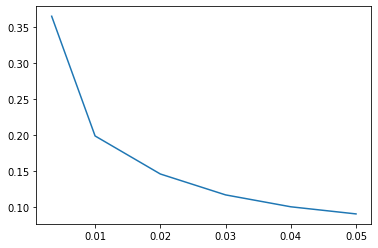

In [312]:
plt.plot(test_sizes_bias,stds_bias)

I have a function that describes the test-set bias. I have another function that describes the training set variance. I want to put them together. First function:

In [ ]:
[j*np.sqrt(0.002*np.exp(-k/0.03)) for j,k in zip(stds_2000, test_sizes_2000)]

Second function:

In [ ]:
[j*np.sqrt(1/2000+k/(1-k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]

I presumably need to add them as squares.

In [ ]:
[np.sqrt(j**2*(0.002*np.exp(-k/0.03) + 1/2000+(2000-1)/2000*k/(1-k)))]

But that doesn't work because one is much larger than the other.

In [ ]:
[j*(np.sqrt(0.002*np.exp(-k/0.03))+np.sqrt(1/2000+k/(1-k))) for j,k in zip(stds_2000, test_sizes_2000)]

How do I put them under one square root? I factor out the larger one.

In [ ]:
[j*np.sqrt(1/2000+k/(1-k))*(1 + np.sqrt(0.002*np.exp(-k/0.03)/(1/2000+k/(1-k)))) for j,k in zip(stds_2000, test_sizes_2000)]

But 1 + sqrt(small) = sqrt(1+2*sqrt(small)).

In [ ]:
[j*np.sqrt(1/2000+k/(1-k)+2*np.sqrt(0.002*np.exp(-k/0.03)*(1/2000+k/(1-k))))]

So the new term has exp(-k/#)*sqrt(k) behavior.

Let's look at the residues of 100 and 200 models and compare the NB.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()


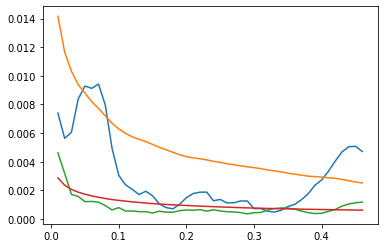

In [39]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(test_sizes_2000.values.reshape(-1,1), means_2000.values.reshape(-1,1))

test_sizes_100 = pd.Series(test_sizes_100)
means_100 = pd.Series(means_100)
stds_100 = pd.Series(stds_100)

residues_100 = pd.Series(index = test_sizes_100.index)
for i in test_sizes_100.index:
  y_line = lr.predict([[test_sizes_100.loc[i]]])
  residues_100.loc[i] = means_100.loc[i] - y_line
plt.plot(test_sizes_100,residues_100.apply(np.abs).rolling(5).mean())
plt.plot(test_sizes_100,pd.Series([j*np.sqrt(1/100) for j,k in zip(stds_100,test_sizes_100)]).rolling(5).mean())
residues_2000 = pd.Series(index = test_sizes_2000.index)
for i in test_sizes_2000.index:
  y_line = lr.predict([[test_sizes_2000.loc[i]]])
  residues_2000.loc[i] = means_2000.loc[i] - y_line
plt.plot(test_sizes_2000,residues_2000.apply(np.abs).rolling(5).mean())
plt.plot(test_sizes_2000,pd.Series([j*np.sqrt(1/2000) for j,k in zip(stds_2000,test_sizes_2000)]).rolling(5).mean())

This is just the variance part. Actually, it is not halfway bad.

In [17]:
a00,b00,c00 = (1/len(y), 0.842809364548495, 0.36459060488958833)
a01,b01,c01 = (2/len(y), 0.8435388655697964, 0.2558454628784861)

a0,b0,c0 = (0.01, 0.8574166666666666, 0.19876841284380284)
a1,b1,c1 = (0.02, 0.8409833333333334, 0.146087225656455)
a2,b2,c2 = (0.03, 0.8467111111111113, 0.11714209162222446)
a3,b3,c3 = (0.04, 0.8496791666666667, 0.1006567040289529)
a4,b4,c4 = (0.05, 0.8449233333333334, 0.09078365436575024)

test_sizes_2000.loc[45:49] = [a4,a3,a2,a1,a0]
means_2000.loc[45:49] = [b4,b3,b2,b1,b0]
stds_2000.loc[45:49] = [c4,c3,c2,c1,c0]

test_sizes_2000.loc[50] = a01
means_2000.loc[50] = b01
stds_2000.loc[50] = c01

test_sizes_2000.loc[51] = a00
means_2000.loc[51] = b00
stds_2000.loc[51] = c00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()


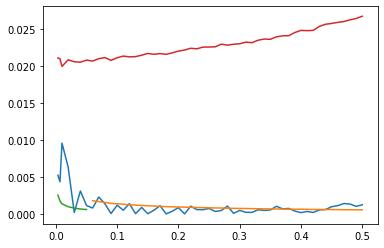

In [22]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(test_sizes_2000.values.reshape(-1,1), means_2000.values.reshape(-1,1))

# test_sizes_100 = pd.Series(test_sizes_100)
# means_100 = pd.Series(means_100)
# stds_100 = pd.Series(stds_100)

# residues_100 = pd.Series(index = test_sizes_100.index)
# for i in test_sizes_100.index:
#   y_line = lr.predict([[test_sizes_100.loc[i]]])
#   residues_100.loc[i] = means_100.loc[i] - y_line
# plt.plot(test_sizes_100,residues_100.apply(np.abs).rolling(1).mean())
# plt.plot(test_sizes_100,pd.Series([j*np.sqrt(1/100) for j,k in zip(stds_100,test_sizes_100)]).rolling(5).mean())
residues_2000 = pd.Series(index = test_sizes_2000.index)
for i in test_sizes_2000.index:
  y_line = lr.predict([[test_sizes_2000.loc[i]]])
  residues_2000.loc[i] = means_2000.loc[i] - y_line
plt.plot(test_sizes_2000,residues_2000.apply(np.abs).rolling(1).mean())
plt.plot(test_sizes_2000[:45],pd.Series([j*np.sqrt(1/2000) for j,k in zip(stds_2000[:45],test_sizes_2000[:45])]).rolling(1).mean())
plt.plot(test_sizes_2000[45:],pd.Series([j*np.sqrt(1/20000) for j,k in zip(stds_2000[45:],test_sizes_2000[45:])]).rolling(1).mean())
plt.plot(test_sizes_2000,pd.Series([j*np.sqrt(k/(1-k)) for j,k in zip(stds_2000,test_sizes_2000)]).rolling(1).mean())

It's fine that the red line doesn't come up to the green line because it concerns variance. However, the spike in the green line is about bias. Nobody ever said the accuracies have to be on a straight line and at the end, you see why.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


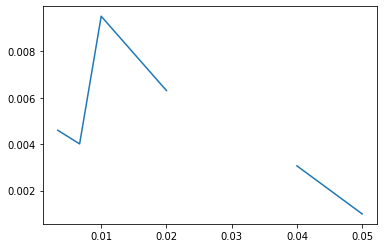

In [31]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(test_sizes_2000.values.reshape(-1,1), means_2000.values.reshape(-1,1))

residues_bias = pd.Series(index = test_sizes_bias.index)
for i in test_sizes_bias.index:
  y_line = lr.predict([[test_sizes_bias.loc[i]]])
  residues_bias.loc[i] = means_bias.loc[i] - y_line
plt.plot(test_sizes_2000[45:],pd.Series([np.sqrt(l**2 - j**2/20000) for j,l in zip(stds_2000[45:],residues_2000[45:])]))

These four measurements are a measure of the bias which is between 0.0045 and 0.009, I believe. I don't know how to extract it from the third and fourth points, though. Maybe I shouldn't.

In [53]:
[np.sqrt(l**2 - j**2/20000) for j,l in zip(stds_2000[45:],residues_2000[45:])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


[0.0009958506120405584,
 0.003066365352297332,
 nan,
 0.006310207104698567,
 0.009512736831180665,
 0.0040129548921123154,
 0.004599698747543721]

In [54]:
[np.sqrt(l**2) for j,l in zip(stds_2000[45:],residues_2000[45:])]

[0.0011848215209480095,
 0.0031478858106780416,
 0.00024329574658443764,
 0.006394199526069566,
 0.009616007805556492,
 0.0044018918671298035,
 0.005272906601376803]

In [33]:
(0.004599698747543721+0.0040129548921123154)/2

0.004306326819828018

or maybe I should:

In [40]:
abc = [0.006310207104698567,
 0.009512736831180665,
 0.0040129548921123154,
 0.004599698747543721]
np.mean(abc)

0.006108899393883817

or even don't consider variance. 

In [55]:
abc = [0.006394199526069566,
 0.009616007805556492,
 0.0044018918671298035,
 0.005272906601376803]
np.mean(abc)

0.006421251450033166

In [36]:
0.004306326819828018/(np.array(stds_2000)[-1]*np.sqrt(1/len(y)))

0.20423826271487178

In [41]:
0.006108899393883817/(np.array(stds_2000)[-1]*np.sqrt(1/len(y)))

0.28972975148147073

In [56]:
0.006421251450033166/(np.array(stds_2000)[-1]*np.sqrt(1/len(y)))

0.30454382481413733

In [58]:
(np.array(stds_2000)[-1]*np.sqrt(1/len(y)))

0.021084819086225264

This is the correction factor for the bias.

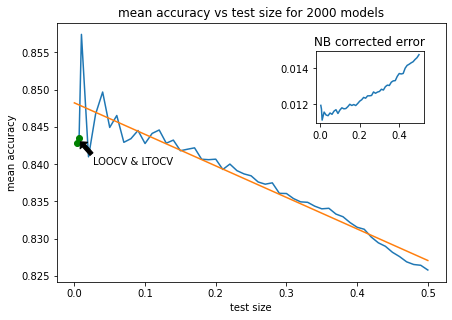

In [57]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(test_sizes_2000.values.reshape(-1,1), means_2000.values.reshape(-1,1))
xx = np.linspace(0.0,0.5,100)
yy = lr.predict(xx.reshape(-1,1))
fig = plt.figure()
outside = fig.add_axes([0.1,0.1,0.9,0.9])
inside = fig.add_axes([0.7,0.65,0.25,0.25])
outside.plot(test_sizes_2000,means_2000)
outside.plot(1/len(y),0.842809364548495,'go')
outside.plot(2/len(y),0.8435388655697964,'go')
outside.annotate('LOOCV & LTOCV', xy=(2/len(y)+0.002, 0.843), 
            xytext=(8/len(y), 0.84),
             arrowprops = dict(headlength=5,headwidth=10,color='k')
            )
#inside.plot(test_sizes_2000,[j*(np.sqrt(1/2000+0.28972975148147073*k/(1-k))) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)])
inside.plot(test_sizes_2000,[j*(np.sqrt(1/20000+0.30454382481413733*k/(1-k))) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)])
#inside.plot(test_sizes_2000,[j*np.sqrt(1/20000) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)])
#inside.plot(test_sizes_2000,[j*(np.sqrt(0.28972975148147073*k/(1-k))) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)])
inside.set_title('NB corrected error')
outside.set_title('mean accuracy vs test size for 2000 models')
outside.set_xlabel('test size')
outside.set_ylabel('mean accuracy')
outside.plot(xx,yy)
#outside.plot(test_sizes_bias,means_bias)

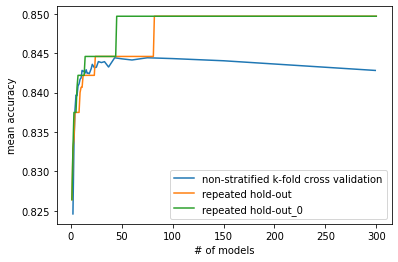

In [62]:
def guaranteed_accuracy_0(nr_models,means_2000,stds_2000,test_sizes_2000):
  means_2000 = means_2000[:-5] # test size < 5% is too uncertain even for 2000 models
  stds_2000 = stds_2000[:-5]
  test_sizes_2000 = test_sizes_2000[:-5]
  loss = [i - 2*j*np.sqrt(1/nr_models+(nr_models-1)/nr_models*k/(1-k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]
  return np.max(loss),(50-np.argmax(loss))/100

def guaranteed_accuracy(nr_models,means_2000,stds_2000,test_sizes_2000):
  means_2000 = means_2000[:-5] # test size < 5% is too uncertain even for 2000 models
  stds_2000 = stds_2000[:-5]
  test_sizes_2000 = test_sizes_2000[:-5]
  loss = [i - 2*j*np.sqrt(1/nr_models+0.30454382481413733*(nr_models-1)/nr_models*k/(1-k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]
  return np.max(loss),(50-np.argmax(loss))/100

#plt.plot(folds_cv,means_cv,label = 'stratified k-fold cross validation')
plt.plot(folds_cv_no_strat,means_cv_no_strat,label = 'non-stratified k-fold cross validation')
nr_models_ = np.linspace(1,300,300)
test_sizes_ = [guaranteed_accuracy(i,means_2000,stds_2000,test_sizes_2000)[1] for i in nr_models_]
indices_ = [(np.abs(test_sizes_2000 - i)).argmin() for i in test_sizes_]
means_ = [means_2000[i] for i in indices_]
plt.plot(nr_models_,means_,label='repeated hold-out')
nr_models_ = np.linspace(1,300,300)
test_sizes_ = [guaranteed_accuracy_0(i,means_2000,stds_2000,test_sizes_2000)[1] for i in nr_models_]
indices_ = [(np.abs(test_sizes_2000 - i)).argmin() for i in test_sizes_]
means_ = [means_2000[i] for i in indices_]
plt.plot(nr_models_,means_,label='repeated hold-out_0')
plt.xlabel('# of models')
plt.ylabel('mean accuracy')
plt.legend()

The original repeated holdout was better. So I don't want to do this.

# Lesson 11: ensemble techniques and trying out hyperopt

In [ ]:
!pip install scikit_optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 5.3 MB/s 


In [ ]:
from sklearn import svm
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.50, test_size=.50, random_state=0)

opt = BayesSearchCV(
    svm.SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3,
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))

val. score: 0.7850340136054422
test score: 0.8266666666666667
best params: OrderedDict([('C', 0.36830463781014416), ('degree', 8), ('gamma', 9.52618754581272e-05), ('kernel', 'linear')])


BayesCV took 6 minutes for 100 evals. 6 seconds per eval.

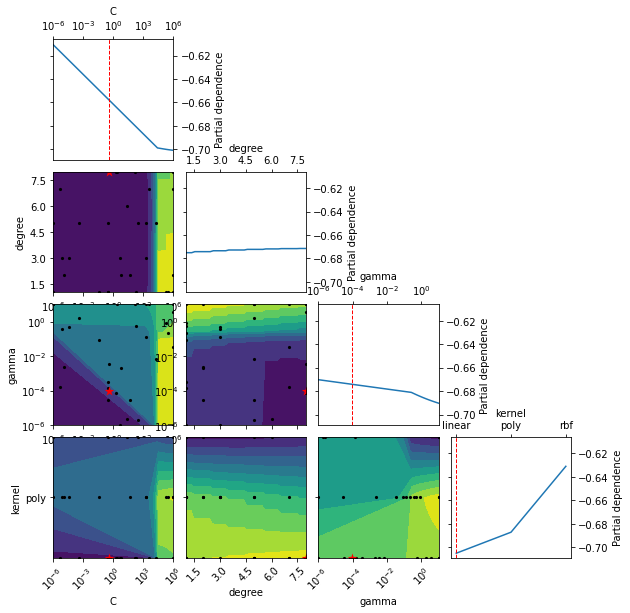

In [ ]:
from skopt.plots import plot_objective, plot_histogram

_ = plot_objective(opt.optimizer_results_[0],
                   dimensions=["C", "degree", "gamma", "kernel"],
                   n_minimum_search=int(1e8))
plt.show()

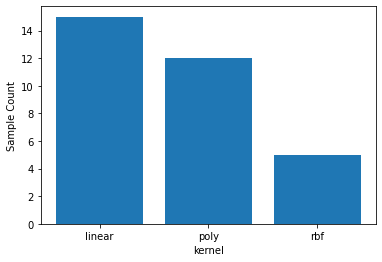

In [ ]:
_ = plot_histogram(opt.optimizer_results_[0], 3)
plt.show()

In [ ]:
RandomizedSearchCV()

In [ ]:
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils.fixes import loguniform
from scipy.stats import randint

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.50, test_size=.50, random_state=0)

opt = RandomizedSearchCV(
    svm.SVC(),
    {
        'C': loguniform(1e-6, 1e+6),
        'gamma': loguniform(1e-6, 1e+1),
        'degree': randint(1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3,
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))

val. score: 0.8115646258503402
test score: 0.78
best params: {'C': 25540.927521005873, 'degree': 1, 'gamma': 1.2508690065182446e-06, 'kernel': 'poly'}


RandomizedSearchCV ran in under 4 minutes (50% faster than Bayes). It's val score is higher but test is lower.

*first* evaluate a default parameter model

In [ ]:
from sklearn import svm

scaled_data = preprocessing.scale(X_encoded)
scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)

X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, train_size=0.83, test_size=.17, random_state=0)

clf = svm.SVC()

train_accuracies = []
test_accuracies = []
for i in range(100):
  A_train, A_test, b_train, b_test = train_test_split(X_train, y_train, train_size=0.95, test_size=.05, random_state=i)
  clf = svm.SVC()
  clf.fit(A_train, b_train)
  train_accuracies.append(accuracy_score(b_train,clf.predict(A_train)))
  test_accuracies.append(accuracy_score(b_test,clf.predict(A_test)))
print(f'Accuracy on test is {np.mean(test_accuracies)}+-{np.std(test_accuracies)}; Accuracy on train is {np.mean(train_accuracies)}+-{np.std(train_accuracies)}')

Accuracy on test is 0.8261538461538461+-0.10966328238274915; Accuracy on train is 0.9324255319148937+-0.005080786912884876


In [ ]:
!pip install git+https://github.com/hyperopt/hyperopt-sklearn

from hpsklearn import HyperoptEstimator, svc

estim = HyperoptEstimator(classifier=svc("mySVC"))
estim.fit(X_train, y_train)

print(estim.score(X_test, y_test))
print(estim.best_model())

100%|██████████| 10/10 [00:00<00:00, 14.67trial/s, best loss: 0.16000000000000003]


0it [00:00, ?it/s]

0.8431372549019608
{'learner': SVC(C=1.0995539951265443, coef0=0.6520135002776921,
    decision_function_shape='ovo', degree=1, kernel='linear', random_state=0,
    shrinking=False, tol=0.0001169559757370885), 'preprocs': (PCA(n_components=8, whiten=True),), 'ex_preprocs': ()}


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
from hpsklearn import HyperoptEstimator, any_classifier, any_preprocessing
from hyperopt import tpe
estim = HyperoptEstimator(classifier=any_classifier("my_clf"),
                          preprocessing=any_preprocessing("my_pre"),
                          algo=tpe.suggest,
                          max_evals=100,
                          trial_timeout=120)
estim.fit(X_train, y_train)


 96%|█████████▌| 23/24 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:656: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:657: RuntimeWarning: overflow encountered in exp
  + estimator_weight * incorrect * (sample_weight > 0)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:486: UserWarning: Sample weights have reached infinite values, at iteration 15, causing overflow. Iterations stopped. T

100%|██████████| 100/100 [00:00<00:00,  1.94trial/s, best loss: 0.14]


In [ ]:
print(estim.score(X_test, y_test))
print(estim.best_model())

0.7647058823529411
{'learner': SGDClassifier(alpha=0.010418107568945012, eta0=0.00038791562056663905,
              l1_ratio=1.1445244706602284e-07, loss='log', max_iter=1242,
              n_iter_no_change=6, n_jobs=1, power_t=0.9686781784928236,
              random_state=0, tol=2.1638934888097498e-05), 'preprocs': (Normalizer(norm='l1'),), 'ex_preprocs': ()}


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
estim = HyperoptEstimator(classifier=svc("mySVC"))
estim.fit(X_train, y_train)

print(estim.score(X_test, y_test))
print(estim.best_model())

In [ ]:
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

scaled_data = preprocessing.scale(X_encoded)
scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)

X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, train_size=0.5, test_size=.5, random_state=0)


clf1 = LogisticRegression()
clf1 = clf1.fit(X_train, y_train)
print(accuracy_score(y_test,clf1.predict(X_test)))
clf2 = SVC()
clf2 = clf2.fit(X_train, y_train)
print(accuracy_score(y_test,clf2.predict(X_test)))
clf3 = KNeighborsClassifier()
clf3 = clf3.fit(X_train, y_train)
print(accuracy_score(y_test,clf3.predict(X_test)))
clf4 = RandomForestClassifier()
clf4 = clf4.fit(X_train, y_train)
print(accuracy_score(y_test,clf4.predict(X_test)))

eclf1 = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('knn', clf3),('rf', clf4)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
print(accuracy_score(y_test,eclf1.predict(X_test)))

0.8333333333333334
0.8133333333333334
0.82
0.8066666666666666
0.84


Voting Classifiers are really good!

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        #maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

In [ ]:
mv_clf = MajorityVoteClassifier(classifiers=[estim1, estim2, estim3,estim4])

In [ ]:
accuracy_score(y_train,mv_clf.predict(X_train))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


0.8926174496644296

First iteration of voting using sgd_classifier and hyperopt svc.

In [ ]:
!pip install git+https://github.com/hyperopt/hyperopt-sklearn

from hpsklearn import HyperoptEstimator, random_forest_classifier, svc, sgd_classifier, k_neighbors_classifier, pca, any_preprocessing
from hyperopt import tpe

def all_functions(train_acc,test_acc,X_train, X_test, y_train, y_test,max_evals):
  estim1 = HyperoptEstimator(classifier=sgd_classifier("sgd_classifier"),
                            preprocessing=any_preprocessing("my_pre"),
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trial_timeout=10,
                             verbose=0)
  estim1.fit(X_train, y_train,)
  train_acc['log'].append(estim1.score(X_train,y_train))
  test_acc['log'].append(estim1.score(X_test,y_test))

  estim2 = HyperoptEstimator(classifier=svc("svc"),
                            preprocessing=any_preprocessing("my_pre"),
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trial_timeout=10,
                             verbose=0)
  estim2.fit(X_train, y_train)
  train_acc['svc'].append(estim2.score(X_train,y_train))
  test_acc['svc'].append(estim2.score(X_test,y_test))
  estim3 = HyperoptEstimator(classifier=k_neighbors_classifier("k_neighbors_classifier"),
                            preprocessing=any_preprocessing("my_pre"),
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trial_timeout=10,
                             verbose=0)
  estim3.fit(X_train, y_train)
  train_acc['knn'].append(estim3.score(X_train,y_train))
  test_acc['knn'].append(estim3.score(X_test,y_test))
  estim4 = HyperoptEstimator(classifier=random_forest_classifier("random_forest_classifier"),
                            preprocessing=any_preprocessing("my_pre"),
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trial_timeout=10,
                             verbose=0)
  estim4.fit(X_train, y_train)
  train_acc['rf'].append(estim4.score(X_train,y_train))
  test_acc['rf'].append(estim4.score(X_test,y_test))
  mv_clf = MajorityVoteClassifier(classifiers=[estim1, estim2, estim3,estim4])
  train_acc['ensemble'].append(accuracy_score(y_train,mv_clf.predict(X_train)))
  test_acc['ensemble'].append(accuracy_score(y_test,mv_clf.predict(X_test)))
  return train_acc, test_acc

train_acc = {'log':[],'svc':[],'knn':[],'rf':[],'ensemble':[]}
test_acc = {'log':[],'svc':[],'knn':[],'rf':[],'ensemble':[]}
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.95, test_size=.05, random_state=1)
for i in tqdm(range(100)):
  A_train, A_test, b_train, b_test = train_test_split(X_train, y_train, train_size=0.95, test_size=.05, random_state=i)
  train_acc, test_acc = all_functions(train_acc,test_acc,A_train, A_test, b_train, b_test,max_evals=10,)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hyperopt/hyperopt-sklearn to /tmp/pip-req-build-dh33favg
  Running command git clone -q https://github.com/hyperopt/hyperopt-sklearn /tmp/pip-req-build-dh33favg
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  4.57trial/s, best loss: 0.16666666666666663]

100%|██████████| 2/2 [00:00<00:00,  5.37trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00,  6.07trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00, 12.22trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  5.24trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00,  7.75trial/s, best loss: 0.11111111111111116]

100%|██████████| 7/7 [00:00<00:00,  6.14trial/s, best loss: 0.11111111111111116]

100%|██████████| 8/8 [00:00<00:00,  7.70trial/s, best loss: 0.11111111111111116]

100%|██████████| 9/9 [00:00<00:00,  8.02trial/s, best loss: 0.11111111111111116]

100%|██████████| 10/10 [00:00<00:00,  1.64trial/s, best loss: 0.11111111111111116]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  6.43trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:00<00:00, 16.53trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00, 12.85trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00, 13.69trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00, 12.00trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00, 10.78trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00,  6.78trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00,  5.04trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00,  4.76trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00,  4.62trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.81trial/s, best loss: 0.16666666666666663]

100%|██████████| 2/2 [00:00<00:00, 13.53trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00,  7.52trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00,  5.96trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00,  5.50trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00,  6.43trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00,  8.01trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00, 12.99trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00,  6.92trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00, 12.47trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:10<00:00, 10.09s/trial, best loss=?]


AllTrialsFailed: ignored

In [ ]:
{a:np.mean(b) for a,b in test_acc.items()}

{'ensemble': 0.8313333333333333,
 'knn': 0.8206666666666667,
 'log': 0.806,
 'rf': 0.8079999999999999,
 'svc': 0.8213333333333332}

In [ ]:
{a:np.std(b) for a,b in test_acc.items()}

{'ensemble': 0.10130482054999493,
 'knn': 0.12099403107408052,
 'log': 0.11039122348367293,
 'rf': 0.10636624360095538,
 'svc': 0.10016874651196239}

In [ ]:
{a:np.mean(b) for a,b in train_acc.items()}

{'ensemble': 0.8977112676056339,
 'knn': 0.9383450704225352,
 'log': 0.8380633802816901,
 'rf': 0.9040492957746479,
 'svc': 0.885774647887324}

In [ ]:
{a:np.mean(b) for a,b in test_acc.items()}

{'ensemble': 0.8513333333333334,
 'knn': 0.8433333333333332,
 'log': 0.8220000000000001,
 'rf': 0.8353333333333332,
 'svc': 0.838}

In [ ]:
{a:np.std(b) for a,b in test_acc.items()}

{'ensemble': 0.07766309004640207,
 'knn': 0.08452481555403978,
 'log': 0.09045809342820946,
 'rf': 0.07743384273042377,
 'svc': 0.0828680343142705}

In [ ]:
0.0904*np.sqrt(1/100+0.05/(100/(100-1)-0.05))

0.022523546643300897

success! again 2%.

Now we did it for max_evals = 20 and get much lower values.

In [ ]:
{a:np.mean(b) for a,b in test_acc.items()}

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'ensemble': nan,
 'knn': 0.8171821305841924,
 'log': 0.82,
 'rf': 0.8219931271477663,
 'svc': 0.8281786941580757}

ok, so the second time I forgot to initialize the voting class but it's interesting that all the values are so low.

In [ ]:
{a:np.std(b) for a,b in test_acc.items()}

{'ensemble': 0.08900105156932946,
 'knn': 0.08004692022690485,
 'log': 0.097477062829046,
 'rf': 0.08009788929938996,
 'svc': 0.09299270758763122}

In [ ]:
{a:np.mean(b) for a,b in train_acc.items()}

{'ensemble': 0.9014084507042252,
 'knn': 0.9470052639066722,
 'log': 0.8433802816901407,
 'rf': 0.9119362640489401,
 'svc': 0.8798548868971405}

In [ ]:
{a:np.std(b) for a,b in train_acc.items()}

{'ensemble': 0.02868446455469891,
 'knn': 0.06688057746651234,
 'log': 0.039176329140535794,
 'rf': 0.05733288745793398,
 'svc': 0.04720712066899821}

The standard deviations on this run are significantly higher.

Also the log is not a real logistic regression.

In [ ]:
  X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.95, test_size=.05, random_state=1)
  estim1 = HyperoptEstimator(classifier=sgd_classifier("sgd_classifier"),
                            preprocessing=[pca("pca"),],
                            algo=tpe.suggest,
                            max_evals=10,
                            trial_timeout=10,
                              )
  estim1.fit(X_train, y_train,)

100%|██████████| 10/10 [00:00<00:00,  4.94trial/s, best loss: 0.08771929824561409]


In [ ]:
estim1.best_model()

{'ex_preprocs': (),
 'learner': SGDClassifier(alpha=0.0020633970889497727, eta0=0.0006252717680457331,
               l1_ratio=0.20703974597858008, learning_rate='constant',
               loss='modified_huber', max_iter=1094, n_iter_no_change=4,
               n_jobs=1, penalty='elasticnet', power_t=0.5957674393661597,
               random_state=2, tol=0.00021592350959425262),
 'preprocs': (PCA(n_components=12, whiten=True),)}

I recommend not evaluating to test right away, instead a sandbox should be used first.

Seems like hyperopt is good at fitting random forest, knn, not so good at the other stuff.

Oh no! I forgot to scale my data. That's why log is so bad.

In [ ]:
#!pip install git+https://github.com/hyperopt/hyperopt-sklearn
from hpsklearn import HyperoptEstimator, random_forest_classifier, svc, sgd_classifier, k_neighbors_classifier, pca, any_preprocessing
from hyperopt import tpe

scaled_data = preprocessing.scale(X_encoded)
scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, train_size=0.10, test_size=.90, random_state=1)


estim3 = HyperoptEstimator(classifier=k_neighbors_classifier("k_neighbors_classifier"),
                            preprocessing=any_preprocessing("my_pre"),
                            algo=tpe.suggest,
                           max_evals=10,
                          trial_timeout=10,
                            verbose=0)
estim3.fit(X_train,y_train)
estim3.best_model()

100%|██████████| 10/10 [00:00<00:00, 12.54trial/s, best loss: 0.0]


{'ex_preprocs': (),
 'learner': KNeighborsClassifier(algorithm='brute', leaf_size=23, n_jobs=1, n_neighbors=3,
                      p=4.879769828243383, weights='distance'),
 'preprocs': (MinMaxScaler(feature_range=(0.0, 1.0)),)}

In [ ]:
estim1 = HyperoptEstimator(classifier=sgd_classifier("sgd_classifier"),
                          preprocessing=any_preprocessing("my_pre"),
                          algo=tpe.suggest,
                          max_evals=10,
                          trial_timeout=10,
                          verbose=0)
estim1.fit(A_train, b_train)

100%|██████████| 10/10 [00:00<00:00, 13.96trial/s, best loss: 0.20588235294117652]


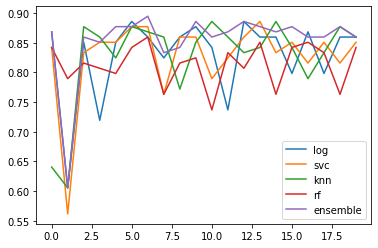

In [ ]:
for a,b in test_acc.items():
  plt.plot(b,label=a)
plt.legend()
plt.show()

you can't really tell much which max_evals is better from a single ~50/50 split.

now doing max_evals = 5.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.95, test_size=.05, random_state=1)

train_acc = {'log':[],'svc':[],'knn':[],'rf':[],'ensemble':[]}
test_acc = {'log':[],'svc':[],'knn':[],'rf':[],'ensemble':[]}

for i in tqdm(range(100)):
  A_train, A_test, b_train, b_test = train_test_split(X_train, y_train, train_size=0.95, test_size=.05, random_state=i)
  try:
    train_acc, test_acc = all_functions(train_acc,test_acc,A_train, A_test, b_train, b_test,max_evals=5)
  except:
    continue

  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 13.69trial/s, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:00<00:00, 10.19trial/s, best loss: 0.11111111111111116]

100%|██████████| 3/3 [00:00<00:00, 13.29trial/s, best loss: 0.11111111111111116]

100%|██████████| 4/4 [00:00<00:00, 12.02trial/s, best loss: 0.11111111111111116]

100%|██████████| 5/5 [00:00<00:00,  2.07trial/s, best loss: 0.11111111111111116]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.58trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:00<00:00, 14.29trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00, 15.00trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00, 12.91trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00, 15.90trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  8.18trial/s, best loss: 0.2962962962962963]

100%|██████████| 2/2 [00:00<00:00, 14.10trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00, 15.08trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00,  7.11trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 14.67trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  6.84trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:00<00:00,  5.57trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:03<00:00,  3.68s/trial, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00,  2.00trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:08<00:00,  8.11s/trial, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/

100%|██████████| 1/1 [00:00<00:00, 12.89trial/s, best loss: 0.37037037037037035]

100%|██████████| 2/2 [00:00<00:00, 14.06trial/s, best loss: 0.37037037037037035]

100%|██████████| 3/3 [00:00<00:00, 11.89trial/s, best loss: 0.37037037037037035]

100%|██████████| 4/4 [00:00<00:00, 14.26trial/s, best loss: 0.33333333333333337]

100%|██████████| 5/5 [00:00<00:00, 12.89trial/s, best loss: 0.2592592592592593]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 13.80trial/s, best loss: 0.5740740740740741]

100%|██████████| 2/2 [00:00<00:00, 13.20trial/s, best loss: 0.5740740740740741]

100%|██████████| 3/3 [00:00<00:00, 13.80trial/s, best loss: 0.20370370370370372]

100%|██████████| 4/4 [00:00<00:00, 15.96trial/s, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00,  1.48trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 10.25trial/s, best loss: 0.35185185185185186]

100%|██████████| 2/2 [00:00<00:00, 17.15trial/s, best loss: 0.35185185185185186]

100%|██████████| 3/3 [00:00<00:00, 15.59trial/s, best loss: 0.35185185185185186]

100%|██████████| 4/4 [00:00<00:00, 13.06trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00, 14.21trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.75trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00,  6.47trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00,  1.48trial/s, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:03<00:00,  3.22s/trial, best loss: 0.2407407407407407]

100%|██████████| 5/5 [00:00<00:00,  4.84trial/s, best loss: 0.2407407407407407]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/loc


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 13.83trial/s, best loss: 0.2777777777777778]

100%|██████████| 2/2 [00:00<00:00, 12.62trial/s, best loss: 0.2777777777777778]

100%|██████████| 3/3 [00:00<00:00, 13.64trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00, 13.15trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00, 13.02trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.36trial/s, best loss: 0.14814814814814814]

100%|██████████| 2/2 [00:00<00:00, 11.92trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00, 14.56trial/s, best loss: 0.11111111111111116]

100%|██████████| 4/4 [00:00<00:00, 13.00trial/s, best loss: 0.11111111111111116]

100%|██████████| 5/5 [00:00<00:00, 11.19trial/s, best loss: 0.11111111111111116]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 15.04trial/s, best loss: 0.2222222222222222]

100%|██████████| 2/2 [00:00<00:00,  2.45trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00, 14.81trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00, 15.75trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00, 16.29trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.63trial/s, best loss: 0.16666666666666663]

100%|██████████| 2/2 [00:00<00:00,  1.79trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00,  3.85trial/s, best loss: 0.16666666666666663]

 75%|███████▌  | 3/4 [00:03<?, ?trial/s, best loss=?]

Process Process-100:

Traceback (most recent call last):

  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 822, in dispatch_one_batch
    tasks = self._ready_batches.get(block=False)

  File "/usr/lib/python3.7/queue.py", line 167, in get
    raise Empty

_queue.Empty


During handling of the above exception, another exception occurred:


Traceback (most recent call last):



  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()

  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)

  File "/usr/local/lib/python3.7/dist-packages/hpsklearn/estimator/_cost_fn.py", line 199, in _cost_fn
    learner.fit(XEXfit, yfit)

  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)

  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1046, in __call__
    while self.dispatch_one_batch(iterator):

  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 823, in dispatch_one_batch
    except queue.Empty:

KeyboardInterrupt

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/b


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.83trial/s, best loss: 0.12962962962962965]

100%|██████████| 2/2 [00:00<00:00,  6.97trial/s, best loss: 0.12962962962962965]

 67%|██████▋   | 2/3 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.01trial/s, best loss: 0.35185185185185186]

100%|██████████| 2/2 [00:00<00:00,  5.97trial/s, best loss: 0.2592592592592593]

100%|██████████| 3/3 [00:00<00:00,  7.26trial/s, best loss: 0.2592592592592593]

100%|██████████| 4/4 [00:00<00:00,  8.84trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 14.22trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  7.94trial/s, best loss: 0.31481481481481477]

100%|██████████| 2/2 [00:00<00:00,  7.89trial/s, best loss: 0.31481481481481477]

100%|██████████| 3/3 [00:00<00:00, 10.88trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00,  8.42trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00,  7.95trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.77trial/s, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:01<00:00,  1.74s/trial, best loss: 0.12962962962962965]

100%|██████████| 3/3 [00:00<00:00,  2.23trial/s, best loss: 0.12962962962962965]

 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

Process Process-116:



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

Traceback (most recent call last):

  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()

  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)

  File "/usr/local/lib/python3.7/dist-packages/hpsklearn/estimator/_cost_fn.py", line 199, in _cost_fn
    learner.fit(XEXfit, yfit)



  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 441, in fit
    for i in range(n_more_estimators)

  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 441, in <listcomp>
    for i in range(n_more_estimators)

  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_base.py", line 171, in _make_estimator
    _set_random_states(estimator, random_state)

  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_base.py", line 81, in _set_random_states
    estimator.set_params(**to_set)

  File "/usr/local/lib/python3.7/dist-packages/sklearn/base.py", line 239, in set_params
    valid_params = self.get_params(deep=True)

  File "/usr/local/lib/python3.7/dist-packages/sklearn/base.py", line 209, in get_params
    for key in self._get_param_names():

  File "/usr/local/lib/python3.7/dist-packages/sklearn/base.py", line 174, in _get_param_names
    init_signature = inspect.signature(init)

  File "/usr/lib/python3.


100%|██████████| 1/1 [00:00<00:00,  3.83trial/s, best loss: 0.4444444444444444]

100%|██████████| 2/2 [00:00<00:00,  8.99trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00,  7.66trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00, 13.03trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 10.37trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 13.10trial/s, best loss: 0.42592592592592593]

100%|██████████| 2/2 [00:00<00:00,  7.59trial/s, best loss: 0.42592592592592593]

100%|██████████| 3/3 [00:00<00:00,  1.85trial/s, best loss: 0.42592592592592593]

100%|██████████| 4/4 [00:01<00:00,  1.91s/trial, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 10.61trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 14.93trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00, 10.41trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00, 14.03trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00,  7.57trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00, 15.85trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  3.92trial/s, best loss: 0.2962962962962963]

100%|██████████| 2/2 [00:00<00:00,  1.35trial/s, best loss: 0.2592592592592593]

100%|██████████| 3/3 [00:00<00:00,  3.80trial/s, best loss: 0.18518518518518523]

 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

In [ ]:
{a:np.mean(b) for a,b in test_acc.items()}

{'ensemble': 0.8413333333333334,
 'knn': 0.818,
 'log': 0.8186666666666668,
 'rf': 0.8233333333333333,
 'svc': 0.83}

In [ ]:
{a:np.std(b) for a,b in test_acc.items()}

{'ensemble': 0.0983327683599589,
 'knn': 0.09373959201485312,
 'log': 0.1062826420446914,
 'rf': 0.11289129481250734,
 'svc': 0.10214368964029708}

###interesting, 1% improvement when *not* stratifying y. this is also true for logistic regression:

In [ ]:
log = LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear')

acc_train = []
acc_test = []
for i in tqdm(range(1000)):
  A_train, A_test, b_train, b_test = train_test_split(X_encoded, y, train_size=0.95, test_size=.05, random_state=i)
  log.fit(A_train,b_train)
  acc_train.append(accuracy_score(b_train,log.predict(A_train)))
  acc_test.append(accuracy_score(b_test,log.predict(A_test)))

print(f'without stratifying, we get {np.mean(acc_test)} accuracy +- {np.std(acc_test)}')

acc_train = []
acc_test = []
for i in tqdm(range(1000)):
  A_train, A_test, b_train, b_test = train_test_split(X_encoded, y, train_size=0.95, test_size=.05, random_state=i, stratify = y)
  log.fit(A_train,b_train)
  acc_train.append(accuracy_score(b_train,log.predict(A_train)))
  acc_test.append(accuracy_score(b_test,log.predict(A_test)))
  
print(f'with stratifying, we get {np.mean(acc_test)} accuracy +- {np.std(acc_test)}')


  0%|          | 0/1000 [00:00<?, ?it/s]

without stratifying, we get 0.8569333333333335 accuracy +- 0.08492307630372847


  0%|          | 0/1000 [00:00<?, ?it/s]

with stratifying, we get 0.8548666666666668 accuracy +- 0.09027540578080438


Somehow, I'm not able to reproduce the 1%. It looks more like 0.2% to me. There is a 0.5% decrease in the standard deviation.

In [ ]:
{a:np.std(b) for a,b in test_acc.items()}

{'ensemble': 0.09595734401438977,
 'knn': 0.1131623445108216,
 'log': 0.12022817057347635,
 'rf': 0.10001252522067001,
 'svc': 0.09207861646189737}

In [ ]:
{a:np.mean(b) for a,b in test_acc.items()}

{'ensemble': 0.8336633663366337,
 'knn': 0.8066006600660065,
 'log': 0.8006472491909384,
 'rf': 0.8171617161716171,
 'svc': 0.8191419141914191}

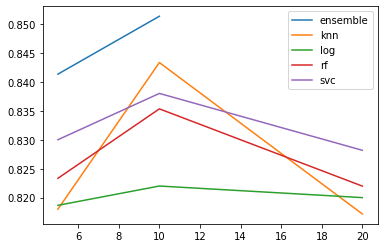

In [ ]:
import matplotlib.pyplot as plt

abc_5 = {'ensemble': 0.8413333333333334,
 'knn': 0.818,
 'log': 0.8186666666666668,
 'rf': 0.8233333333333333,
 'svc': 0.83}

abc_10 = {'ensemble': 0.8513333333333334,
 'knn': 0.8433333333333332,
 'log': 0.8220000000000001,
 'rf': 0.8353333333333332,
 'svc': 0.838}

abc_20 = {'ensemble': np.nan,
 'knn': 0.8171821305841924,
 'log': 0.82,
 'rf': 0.8219931271477663,
 'svc': 0.8281786941580757}

for i in abc_5.keys():
  plt.plot([5,10,20],[abc_5[i],abc_10[i],abc_20[i]],label=i)
plt.legend()
plt.show()

max_evals = 10 is clearly better. note we don't use svc and log with hyperopt anymore, and for the other two, 10 is clearly better.

having a look at bagging.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

acc_train = []
acc_test = []
for i in tqdm(range(100)):
  A_train, A_test, b_train, b_test = train_test_split(X_train, y_train, stratify=y_train, train_size=0.95, test_size=.05, random_state=i+25)
  bag.fit(A_train,b_train)
  acc_train.append(accuracy_score(b_train,bag.predict(A_train)))
  acc_test.append(accuracy_score(b_test,bag.predict(A_test)))


  0%|          | 0/100 [00:00<?, ?it/s]

seeing if splitting y_train to b_test with random seed i causes overlap with y_test using seed i. It does not.

In [ ]:
  A_train, A_test, b_train, b_test = train_test_split(X_train, y_train, stratify=y_train, train_size=0.95, test_size=.05, random_state=2)

In [ ]:
b_test.index.to_numpy()

array([204,  98, 114, 186, 286,  37, 197, 273, 148,  95, 249,  82,  62,
       274,  32])

In [ ]:
_,_,_,abc = train_test_split(X_encoded, y, stratify=y, train_size=0.95, test_size=.05, random_state=2)

In [ ]:
abc.index.to_numpy()

array([187, 158, 173,  95,  13,  76,  25, 205, 135,  79, 132,  81, 194,
        35,  24])

Great, I was worried that the test sets would be the same because the same random seed was used.

In [ ]:
np.mean(acc_test)

0.8086666666666664

Ok, so default bagging gives us 81%.

now adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

acc_train = []
acc_test = []
for i in tqdm(range(100)):
  A_train, A_test, b_train, b_test = train_test_split(X_train, y_train, stratify=y_train, train_size=0.95, test_size=.05, random_state=i)
  ada.fit(A_train,b_train)
  acc_train.append(accuracy_score(b_train,ada.predict(A_train)))
  acc_test.append(accuracy_score(b_test,ada.predict(A_test)))


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
np.mean(acc_test)

0.8066666666666668

Interesting, the exact same score as bagging.

In [ ]:
np.mean(acc_train)

0.9061338289962825

In [ ]:
np.std(acc_test)

0.09955456348712055

The random forest takes about 70+% of the ensemble learning time. Worth it?

Now we try bagging and XGBoost from Hyperopt:

In [ ]:
from hpsklearn import HyperoptEstimator, random_forest_classifier, svc, sgd_classifier, k_neighbors_classifier, pca, bagging_classifier, xgboost_classification
from hpsklearn import HyperoptEstimator, any_classifier, any_preprocessing
from hyperopt import tpe
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm

def all_functions(train_acc,test_acc,X_train, X_test, y_train, y_test,max_evals):
  
  estim1 = HyperoptEstimator(classifier=bagging_classifier("bagging_classifier"),
                            preprocessing=any_preprocessing("my_pre"),
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trial_timeout=10,
                             verbose=0)
  estim1.fit(X_train, y_train)

  train_acc['bag'].append(estim1.score(X_train,y_train))
  test_acc['bag'].append(estim1.score(X_test,y_test))

  estim2 = HyperoptEstimator(classifier=xgboost_classification("xgboost_classification"),
                            preprocessing=any_preprocessing("my_pre"),
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trial_timeout=10,
                             verbose=0)
  estim2.fit(X_train, y_train)


  train_acc['xg'].append(estim2.score(X_train,y_train))
  test_acc['xg'].append(estim2.score(X_test,y_test))

  return train_acc, test_acc

train_acc = {'bag':[],'xg':[]}
test_acc = {'bag':[],'xg':[]}
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.95, test_size=.05, random_state=1)
for i in tqdm(range(100)):
  A_train, A_test, b_train, b_test = train_test_split(X_train, y_train, train_size=0.95, test_size=.05, random_state=i)
  try:
    train_acc, test_acc = all_functions(train_acc,test_acc,A_train, A_test, b_train, b_test,max_evals=10,)
  except:
    continue

  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00,  2.88trial/s, best loss: 0.2592592592592593]

100%|██████████| 2/2 [00:00<00:00,  6.76trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00,  6.35trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00,  6.25trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00,  6.69trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00,  7.17trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00,  7.24trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00,  7.12trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00,  6.51trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00,  3.66trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.01s/trial, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:02<00:00,  2.47s/trial, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:03<00:00,  3.10s/trial, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:01<00:00,  1.74s/trial, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00,  1.02trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00,  1.68trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:01<00:00,  1.71s/trial, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:03<00:00,  3.20s/trial, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00,  2.41trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:01<00:00,  1.49s/trial, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.87trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00,  6.18trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00,  6.02trial/s, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:00<00:00,  4.49trial/s, best loss: 0.2407407407407407]

100%|██████████| 5/5 [00:00<00:00,  5.36trial/s, best loss: 0.2407407407407407]

100%|██████████| 6/6 [00:00<00:00,  4.13trial/s, best loss: 0.2407407407407407]

100%|██████████| 7/7 [00:00<00:00,  5.22trial/s, best loss: 0.2407407407407407]

100%|██████████| 8/8 [00:00<00:00,  4.76trial/s, best loss: 0.2407407407407407]

100%|██████████| 9/9 [00:00<00:00,  3.62trial/s, best loss: 0.2407407407407407]

100%|██████████| 10/10 [00:00<00:00,  4.88trial/s, best loss: 0.2407407407407407]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.06s/trial, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:01<00:00,  1.02s/trial, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:01<00:00,  1.61s/trial, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:01<00:00,  1.71s/trial, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  1.15trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00,  1.58trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:01<00:00,  1.37s/trial, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00,  1.69trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00,  1.51trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  1.72trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  4.16trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00,  3.94trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00,  4.61trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00,  3.94trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00,  5.26trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00,  6.19trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00,  5.61trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00,  2.08trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00,  4.33trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00,  4.43trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.05trial/s, best loss: 0.42592592592592593]

100%|██████████| 2/2 [00:01<00:00,  1.47s/trial, best loss: 0.42592592592592593]

100%|██████████| 3/3 [00:01<00:00,  1.10s/trial, best loss: 0.42592592592592593]

100%|██████████| 4/4 [00:00<00:00,  3.49trial/s, best loss: 0.42592592592592593]

100%|██████████| 5/5 [00:00<00:00,  1.31trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:01<00:00,  1.25s/trial, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:01<00:00,  1.54s/trial, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00,  1.06trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00,  2.62trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:01<00:00,  1.47s/trial, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  6.29trial/s, best loss: 0.2962962962962963]

100%|██████████| 2/2 [00:00<00:00,  6.62trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00,  7.92trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00,  7.27trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  8.25trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00,  7.73trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00,  6.62trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00,  8.22trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00,  7.61trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00,  7.51trial/s, best loss: 0.14814814814814814]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.06s/trial, best loss: 0.16666666666666663]

100%|██████████| 2/2 [00:00<00:00,  5.25trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:01<00:00,  1.41s/trial, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00,  2.55trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00,  2.29trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00,  1.07trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00,  2.72trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00,  1.38trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:01<00:00,  1.22s/trial, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00,  1.88trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  7.55trial/s, best loss: 0.2222222222222222]

100%|██████████| 2/2 [00:00<00:00,  6.52trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00,  7.44trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00,  4.83trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  6.75trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00,  8.35trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  5.98trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00,  8.70trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00,  9.97trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  8.60trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.08trial/s, best loss: 0.2777777777777778]

100%|██████████| 2/2 [00:01<00:00,  1.12s/trial, best loss: 0.2777777777777778]

100%|██████████| 3/3 [00:00<00:00,  1.14trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00,  1.54trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  2.88trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00,  1.80trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  4.70trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:01<00:00,  1.06s/trial, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00,  4.51trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00,  1.03trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  6.99trial/s, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:00<00:00,  9.98trial/s, best loss: 0.20370370370370372]

100%|██████████| 3/3 [00:00<00:00, 10.13trial/s, best loss: 0.20370370370370372]

100%|██████████| 4/4 [00:00<00:00,  7.16trial/s, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00,  6.95trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00,  7.87trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00,  7.39trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00,  6.69trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00,  8.31trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00,  7.21trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  3.72trial/s, best loss: 0.2962962962962963]

100%|██████████| 2/2 [00:00<00:00,  4.87trial/s, best loss: 0.2592592592592593]

100%|██████████| 3/3 [00:02<00:00,  2.71s/trial, best loss: 0.2592592592592593]

100%|██████████| 4/4 [00:00<00:00,  1.10trial/s, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:01<00:00,  1.40s/trial, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00,  1.59trial/s, best loss: 0.2222222222222222]

100%|██████████| 7/7 [00:00<00:00,  4.83trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:00<00:00,  2.13trial/s, best loss: 0.2222222222222222]

100%|██████████| 9/9 [00:01<00:00,  1.09s/trial, best loss: 0.2222222222222222]

100%|██████████| 10/10 [00:01<00:00,  1.43s/trial, best loss: 0.2222222222222222]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  6.86trial/s, best loss: 0.31481481481481477]

100%|██████████| 2/2 [00:00<00:00,  6.78trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00,  8.38trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00,  7.13trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  7.16trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00,  8.19trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  7.53trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00,  6.86trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00,  7.07trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  8.31trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.37s/trial, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:00<00:00,  1.11trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00,  1.18trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00,  2.22trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:02<00:00,  2.73s/trial, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:01<00:00,  1.92s/trial, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  1.02trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00,  2.16trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00,  1.61trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  1.79trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  6.83trial/s, best loss: 0.2777777777777778]

100%|██████████| 2/2 [00:00<00:00,  8.30trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00,  7.00trial/s, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:00<00:00,  6.38trial/s, best loss: 0.2407407407407407]

100%|██████████| 5/5 [00:00<00:00,  6.92trial/s, best loss: 0.2407407407407407]

100%|██████████| 6/6 [00:00<00:00,  6.73trial/s, best loss: 0.2407407407407407]

100%|██████████| 7/7 [00:00<00:00,  7.80trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:00<00:00,  7.62trial/s, best loss: 0.2222222222222222]

100%|██████████| 9/9 [00:00<00:00,  3.18trial/s, best loss: 0.2222222222222222]

100%|██████████| 10/10 [00:00<00:00,  7.50trial/s, best loss: 0.2222222222222222]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.80s/trial, best loss: 0.2962962962962963]

100%|██████████| 2/2 [00:01<00:00,  1.28s/trial, best loss: 0.2592592592592593]

100%|██████████| 3/3 [00:00<00:00,  5.19trial/s, best loss: 0.2592592592592593]

100%|██████████| 4/4 [00:00<00:00,  2.80trial/s, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00,  1.94trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00,  2.25trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00,  1.61trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00,  5.23trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00,  4.04trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00,  1.31trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.47trial/s, best loss: 0.2592592592592593]

100%|██████████| 2/2 [00:00<00:00, 14.35trial/s, best loss: 0.20370370370370372]

100%|██████████| 3/3 [00:00<00:00, 10.38trial/s, best loss: 0.20370370370370372]

100%|██████████| 4/4 [00:00<00:00,  8.83trial/s, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00, 12.93trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00,  9.03trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00, 14.29trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00, 14.68trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00, 12.57trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00, 14.06trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.48trial/s, best loss: 0.35185185185185186]

100%|██████████| 2/2 [00:00<00:00,  6.73trial/s, best loss: 0.31481481481481477]

100%|██████████| 3/3 [00:00<00:00,  1.64trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00,  2.44trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00,  2.70trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00,  1.81trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00,  1.61trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00,  3.01trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00,  7.72trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00,  4.48trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 13.41trial/s, best loss: 0.16666666666666663]

100%|██████████| 2/2 [00:00<00:00, 14.13trial/s, best loss: 0.12962962962962965]

100%|██████████| 3/3 [00:00<00:00, 10.99trial/s, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00, 12.25trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00, 12.90trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00, 10.97trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00, 12.12trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00, 10.89trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00, 11.20trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00, 11.50trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  4.15trial/s, best loss: 0.2222222222222222]

100%|██████████| 2/2 [00:01<00:00,  1.07s/trial, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00,  2.44trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00,  1.26trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00,  4.64trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:01<00:00,  1.05s/trial, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00,  2.09trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00,  5.84trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00,  1.50trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00,  1.89trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.49trial/s, best loss: 0.33333333333333337]

100%|██████████| 2/2 [00:00<00:00, 12.19trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00, 11.50trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00, 14.95trial/s, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00, 11.72trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00, 10.24trial/s, best loss: 0.2222222222222222]

100%|██████████| 7/7 [00:00<00:00, 12.90trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:00<00:00, 14.71trial/s, best loss: 0.2222222222222222]

100%|██████████| 9/9 [00:00<00:00, 12.58trial/s, best loss: 0.2222222222222222]

100%|██████████| 10/10 [00:00<00:00, 11.59trial/s, best loss: 0.2222222222222222]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  7.11trial/s, best loss: 0.2222222222222222]

100%|██████████| 2/2 [00:00<00:00,  3.08trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00,  1.13trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00,  2.48trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  2.39trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00,  4.19trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  1.48trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00,  3.53trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:01<00:00,  1.01s/trial, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  2.59trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.50trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:00<00:00, 13.76trial/s, best loss: 0.11111111111111116]

100%|██████████| 3/3 [00:00<00:00, 14.31trial/s, best loss: 0.11111111111111116]

100%|██████████| 4/4 [00:00<00:00, 12.74trial/s, best loss: 0.11111111111111116]

100%|██████████| 5/5 [00:00<00:00, 13.91trial/s, best loss: 0.11111111111111116]

100%|██████████| 6/6 [00:00<00:00,  8.62trial/s, best loss: 0.11111111111111116]

100%|██████████| 7/7 [00:00<00:00, 14.45trial/s, best loss: 0.11111111111111116]

100%|██████████| 8/8 [00:00<00:00, 13.73trial/s, best loss: 0.11111111111111116]

100%|██████████| 9/9 [00:00<00:00, 13.21trial/s, best loss: 0.11111111111111116]

100%|██████████| 10/10 [00:00<00:00, 13.33trial/s, best loss: 0.11111111111111116]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.72trial/s, best loss: 0.38888888888888884]

100%|██████████| 2/2 [00:00<00:00,  6.74trial/s, best loss: 0.38888888888888884]

100%|██████████| 3/3 [00:00<00:00,  2.79trial/s, best loss: 0.11111111111111116]

100%|██████████| 4/4 [00:00<00:00,  3.93trial/s, best loss: 0.11111111111111116]

100%|██████████| 5/5 [00:00<00:00,  1.02trial/s, best loss: 0.11111111111111116]

100%|██████████| 6/6 [00:00<00:00,  3.59trial/s, best loss: 0.11111111111111116]

100%|██████████| 7/7 [00:00<00:00,  1.73trial/s, best loss: 0.11111111111111116]

100%|██████████| 8/8 [00:02<00:00,  2.66s/trial, best loss: 0.11111111111111116]

100%|██████████| 9/9 [00:00<00:00,  1.26trial/s, best loss: 0.11111111111111116]

100%|██████████| 10/10 [00:00<00:00,  1.57trial/s, best loss: 0.11111111111111116]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.59trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:00<00:00, 13.24trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00, 12.39trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00, 13.57trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00, 12.26trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00, 11.65trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00, 11.50trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00, 13.11trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00, 12.39trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00,  4.60trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.25trial/s, best loss: 0.2222222222222222]

100%|██████████| 2/2 [00:00<00:00,  3.09trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00,  7.82trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:01<00:00,  1.03s/trial, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00,  3.19trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00,  1.74trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00,  1.01trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00,  2.68trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00,  4.23trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00,  5.61trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  4.41trial/s, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:00<00:00, 14.26trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00, 13.18trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00, 11.09trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00, 11.25trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00, 10.82trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00, 12.24trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00, 12.27trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00, 11.65trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00, 13.73trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.57s/trial, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:01<00:00,  1.10s/trial, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00,  2.36trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00,  1.37trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00,  1.13trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00,  5.34trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:01<00:00,  1.16s/trial, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00,  2.60trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00,  5.42trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00, 10.10trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.31trial/s, best loss: 0.2222222222222222]

100%|██████████| 2/2 [00:00<00:00, 13.58trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00, 11.90trial/s, best loss: 0.20370370370370372]

100%|██████████| 4/4 [00:00<00:00,  8.83trial/s, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00, 13.70trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00, 13.28trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00, 11.24trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00, 12.81trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00, 13.04trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00, 11.96trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.28trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:00<00:00,  5.05trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00, 10.94trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00,  1.36trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  1.55trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00,  7.62trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  2.67trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00,  1.24trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00,  2.38trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  3.59trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.51trial/s, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:00<00:00, 13.36trial/s, best loss: 0.20370370370370372]

100%|██████████| 3/3 [00:00<00:00, 12.05trial/s, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00, 13.00trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00, 10.37trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00, 12.16trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00, 14.43trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00, 11.24trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00, 12.65trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00, 12.64trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.56trial/s, best loss: 0.4629629629629629]

100%|██████████| 2/2 [00:00<00:00,  6.62trial/s, best loss: 0.2777777777777778]

100%|██████████| 3/3 [00:00<00:00,  1.77trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:01<00:00,  1.07s/trial, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00,  2.59trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00,  2.73trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00,  1.36trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00,  1.45trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:01<00:00,  1.27s/trial, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00,  7.27trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.48trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00, 10.85trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00, 13.81trial/s, best loss: 0.20370370370370372]

100%|██████████| 4/4 [00:00<00:00, 13.18trial/s, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00, 11.42trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00, 14.21trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00, 13.46trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00, 13.22trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00, 13.66trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00, 12.98trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.70trial/s, best loss: 0.2777777777777778]

100%|██████████| 2/2 [00:00<00:00,  1.58trial/s, best loss: 0.2777777777777778]

100%|██████████| 3/3 [00:00<00:00,  1.33trial/s, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:02<00:00,  2.74s/trial, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00,  3.70trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:02<00:00,  2.31s/trial, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00,  2.04trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00,  1.23trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00,  2.36trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00,  1.58trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  4.47trial/s, best loss: 0.33333333333333337]

100%|██████████| 2/2 [00:00<00:00, 11.75trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00, 10.95trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00, 12.80trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 12.61trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00, 10.33trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00, 13.51trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00, 10.85trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00,  9.00trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00, 13.07trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  7.80trial/s, best loss: 0.4629629629629629]

100%|██████████| 2/2 [00:00<00:00,  2.99trial/s, best loss: 0.4629629629629629]

100%|██████████| 3/3 [00:00<00:00, 12.68trial/s, best loss: 0.4629629629629629]

100%|██████████| 4/4 [00:00<00:00, 11.08trial/s, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00,  3.85trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:01<00:00,  1.24s/trial, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  1.67trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00,  1.24trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:01<00:00,  1.11s/trial, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00,  6.60trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.25trial/s, best loss: 0.4629629629629629]

100%|██████████| 2/2 [00:00<00:00, 10.64trial/s, best loss: 0.2592592592592593]

100%|██████████| 3/3 [00:00<00:00, 12.94trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00, 10.19trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00, 12.06trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00, 12.47trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00, 11.52trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00, 13.31trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00, 10.72trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00, 12.36trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.20trial/s, best loss: 0.4814814814814815]

100%|██████████| 2/2 [00:00<00:00,  1.63trial/s, best loss: 0.4814814814814815]

100%|██████████| 3/3 [00:00<00:00,  7.24trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00,  3.84trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00,  1.74trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00,  1.77trial/s, best loss: 0.09259259259259256]

100%|██████████| 7/7 [00:00<00:00,  1.37trial/s, best loss: 0.09259259259259256]

100%|██████████| 8/8 [00:00<00:00,  2.08trial/s, best loss: 0.09259259259259256]

100%|██████████| 9/9 [00:00<00:00,  3.95trial/s, best loss: 0.09259259259259256]

100%|██████████| 10/10 [00:00<00:00,  2.73trial/s, best loss: 0.09259259259259256]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.37trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:00<00:00, 11.50trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00, 12.91trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00, 12.49trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00, 12.36trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00,  8.70trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00,  8.25trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00, 13.73trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00, 12.37trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00, 13.33trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.83trial/s, best loss: 0.31481481481481477]

100%|██████████| 2/2 [00:00<00:00,  1.07trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00,  4.30trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00,  1.08trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00,  3.38trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00,  1.03trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00,  2.17trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:01<00:00,  1.26s/trial, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00,  2.43trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:01<00:00,  1.61s/trial, best loss: 0.09259259259259256]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.01trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00, 13.32trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00, 11.63trial/s, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:00<00:00, 12.15trial/s, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00, 11.85trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00, 12.42trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00, 12.33trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00,  4.28trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00, 11.03trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00, 11.98trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.44s/trial, best loss: 0.2222222222222222]

100%|██████████| 2/2 [00:00<00:00, 11.12trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00,  1.53trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00,  1.39trial/s, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00,  1.21trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00, 12.09trial/s, best loss: 0.2222222222222222]

100%|██████████| 7/7 [00:00<00:00,  2.98trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:00<00:00,  2.09trial/s, best loss: 0.2222222222222222]

100%|██████████| 9/9 [00:00<00:00,  1.38trial/s, best loss: 0.2222222222222222]

100%|██████████| 10/10 [00:00<00:00,  1.04trial/s, best loss: 0.2222222222222222]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 10.74trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00, 11.10trial/s, best loss: 0.20370370370370372]

100%|██████████| 3/3 [00:00<00:00, 11.14trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00, 11.78trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00, 11.98trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00, 12.62trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00, 12.53trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00, 10.38trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00, 13.62trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00, 11.43trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.23trial/s, best loss: 0.37037037037037035]

100%|██████████| 2/2 [00:00<00:00,  2.92trial/s, best loss: 0.37037037037037035]

100%|██████████| 3/3 [00:00<00:00,  5.02trial/s, best loss: 0.37037037037037035]

100%|██████████| 4/4 [00:00<00:00,  1.42trial/s, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00,  1.43trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00,  8.59trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00,  1.69trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00,  7.89trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00,  1.53trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00,  5.95trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 13.54trial/s, best loss: 0.2777777777777778]

100%|██████████| 2/2 [00:00<00:00,  4.55trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00, 14.03trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00,  8.86trial/s, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00, 12.10trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00,  8.32trial/s, best loss: 0.2222222222222222]

100%|██████████| 7/7 [00:00<00:00, 12.86trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:00<00:00, 13.11trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00, 11.94trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00, 13.08trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.71trial/s, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:00<00:00,  1.66trial/s, best loss: 0.20370370370370372]

100%|██████████| 3/3 [00:00<00:00,  1.77trial/s, best loss: 0.20370370370370372]

100%|██████████| 4/4 [00:00<00:00,  1.16trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  1.89trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00,  1.31trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  5.33trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00,  1.94trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00,  2.24trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  2.45trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 10.83trial/s, best loss: 0.2222222222222222]

100%|██████████| 2/2 [00:00<00:00, 12.31trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00, 12.60trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00, 12.79trial/s, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00, 11.90trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00, 11.84trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00, 14.02trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00,  8.99trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00, 12.25trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00, 12.67trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.96trial/s, best loss: 0.38888888888888884]

100%|██████████| 2/2 [00:00<00:00,  1.14trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00,  1.23trial/s, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00,  2.76trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00,  1.15trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00,  2.13trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00,  2.70trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00,  2.64trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00,  3.37trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00,  1.15trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.09trial/s, best loss: 0.38888888888888884]

100%|██████████| 2/2 [00:00<00:00, 12.24trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00, 11.85trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00, 12.66trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 12.57trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00, 10.24trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00, 13.31trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00, 12.92trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00, 11.83trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00, 11.28trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  4.78trial/s, best loss: 0.16666666666666663]

100%|██████████| 2/2 [00:00<00:00,  1.80trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00,  3.31trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00,  4.77trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00,  2.59trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00,  1.72trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00,  1.23trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00,  1.53trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00,  5.77trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00,  1.62trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.52trial/s, best loss: 0.2222222222222222]

100%|██████████| 2/2 [00:00<00:00, 13.23trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00, 10.90trial/s, best loss: 0.20370370370370372]

100%|██████████| 4/4 [00:00<00:00, 11.16trial/s, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00, 13.00trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00, 11.87trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00, 12.66trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00, 11.92trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00, 11.73trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00, 13.09trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.05trial/s, best loss: 0.2962962962962963]

100%|██████████| 2/2 [00:00<00:00,  1.39trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00,  1.36trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00,  2.80trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00,  1.81trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:01<00:00,  1.92s/trial, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00,  1.18trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00,  1.39trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00,  4.43trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00,  1.48trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 13.22trial/s, best loss: 0.2222222222222222]

100%|██████████| 2/2 [00:00<00:00, 13.06trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00, 12.44trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00, 12.14trial/s, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00, 11.75trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00, 11.82trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00, 10.78trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00, 10.16trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00, 12.56trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00, 10.14trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.10trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00,  2.96trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00,  2.85trial/s, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:00<00:00,  1.25trial/s, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00,  1.84trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00,  4.58trial/s, best loss: 0.2222222222222222]

100%|██████████| 7/7 [00:00<00:00,  2.81trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:00<00:00,  1.06trial/s, best loss: 0.2222222222222222]

100%|██████████| 9/9 [00:00<00:00,  3.40trial/s, best loss: 0.2222222222222222]

100%|██████████| 10/10 [00:02<00:00,  2.03s/trial, best loss: 0.2222222222222222]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 10.50trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:00<00:00, 12.71trial/s, best loss: 0.12962962962962965]

100%|██████████| 3/3 [00:00<00:00, 13.66trial/s, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00, 10.28trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00, 12.01trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00, 12.98trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00, 12.47trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00,  9.96trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00, 12.72trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00, 11.56trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.76trial/s, best loss: 0.11111111111111116]

100%|██████████| 2/2 [00:00<00:00,  1.68trial/s, best loss: 0.11111111111111116]

100%|██████████| 3/3 [00:00<00:00,  6.39trial/s, best loss: 0.11111111111111116]

100%|██████████| 4/4 [00:00<00:00,  1.14trial/s, best loss: 0.11111111111111116]

100%|██████████| 5/5 [00:00<00:00,  1.38trial/s, best loss: 0.11111111111111116]

100%|██████████| 6/6 [00:00<00:00,  1.63trial/s, best loss: 0.11111111111111116]

100%|██████████| 7/7 [00:01<00:00,  1.50s/trial, best loss: 0.11111111111111116]

100%|██████████| 8/8 [00:00<00:00,  1.56trial/s, best loss: 0.11111111111111116]

100%|██████████| 9/9 [00:00<00:00,  8.83trial/s, best loss: 0.11111111111111116]

100%|██████████| 10/10 [00:01<00:00,  1.01s/trial, best loss: 0.11111111111111116]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.16trial/s, best loss: 0.2777777777777778]

100%|██████████| 2/2 [00:00<00:00, 12.75trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00, 11.86trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00, 11.97trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00, 13.52trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00, 13.95trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00, 12.93trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00, 12.60trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00, 10.77trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00, 12.10trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.68trial/s, best loss: 0.16666666666666663]

100%|██████████| 2/2 [00:00<00:00,  1.26trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00,  1.54trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00,  1.66trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  1.11trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00,  2.09trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  1.37trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00,  1.82trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:01<00:00,  1.09s/trial, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  1.84trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.28trial/s, best loss: 0.37037037037037035]

100%|██████████| 2/2 [00:00<00:00, 11.62trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00, 14.32trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00, 12.99trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 10.20trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00, 11.42trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  8.52trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00,  4.63trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00, 12.91trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00, 13.34trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.19trial/s, best loss: 0.37037037037037035]

100%|██████████| 2/2 [00:00<00:00,  2.68trial/s, best loss: 0.37037037037037035]

100%|██████████| 3/3 [00:00<00:00,  1.97trial/s, best loss: 0.37037037037037035]

100%|██████████| 4/4 [00:00<00:00,  2.69trial/s, best loss: 0.37037037037037035]

100%|██████████| 5/5 [00:01<00:00,  1.18s/trial, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00,  1.16trial/s, best loss: 0.2222222222222222]

100%|██████████| 7/7 [00:00<00:00,  2.02trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:01<00:00,  1.00s/trial, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00,  2.40trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00,  1.62trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.00trial/s, best loss: 0.2777777777777778]

100%|██████████| 2/2 [00:00<00:00, 12.63trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00, 12.55trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00, 11.41trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00, 11.83trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00, 14.53trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00, 13.03trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00, 12.58trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00, 13.89trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00, 11.30trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.12trial/s, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:00<00:00,  1.79trial/s, best loss: 0.12962962962962965]

100%|██████████| 3/3 [00:01<00:00,  1.38s/trial, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00,  1.98trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00,  1.35trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00,  5.42trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00,  2.79trial/s, best loss: 0.11111111111111116]

100%|██████████| 8/8 [00:00<00:00,  1.77trial/s, best loss: 0.11111111111111116]

100%|██████████| 9/9 [00:00<00:00,  1.78trial/s, best loss: 0.11111111111111116]

100%|██████████| 10/10 [00:00<00:00,  1.19trial/s, best loss: 0.11111111111111116]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 13.95trial/s, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:00<00:00, 11.89trial/s, best loss: 0.20370370370370372]

100%|██████████| 3/3 [00:00<00:00, 11.00trial/s, best loss: 0.20370370370370372]

100%|██████████| 4/4 [00:00<00:00, 10.41trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00, 12.30trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00, 11.94trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00, 12.37trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00, 12.80trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00, 12.25trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00, 12.88trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  3.18trial/s, best loss: 0.2962962962962963]

100%|██████████| 2/2 [00:00<00:00,  2.54trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00,  1.05trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00,  1.48trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:01<00:00,  1.01s/trial, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00,  5.11trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00,  1.53trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00,  7.07trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00,  1.48trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00,  1.99trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  3.95trial/s, best loss: 0.2592592592592593]

100%|██████████| 2/2 [00:00<00:00, 12.27trial/s, best loss: 0.2592592592592593]

100%|██████████| 3/3 [00:00<00:00, 13.67trial/s, best loss: 0.2592592592592593]

100%|██████████| 4/4 [00:00<00:00, 12.54trial/s, best loss: 0.2592592592592593]

100%|██████████| 5/5 [00:00<00:00,  8.64trial/s, best loss: 0.2592592592592593]

100%|██████████| 6/6 [00:00<00:00, 14.29trial/s, best loss: 0.2407407407407407]

100%|██████████| 7/7 [00:00<00:00, 14.29trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00, 13.32trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00, 10.50trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00, 13.73trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.02trial/s, best loss: 0.12962962962962965]

100%|██████████| 2/2 [00:01<00:00,  1.66s/trial, best loss: 0.12962962962962965]

100%|██████████| 3/3 [00:01<00:00,  1.63s/trial, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00,  1.65trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:01<00:00,  1.17s/trial, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00,  1.63trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00,  3.11trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:01<00:00,  1.70s/trial, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:01<00:00,  1.04s/trial, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00,  1.48trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.80trial/s, best loss: 0.2962962962962963]

100%|██████████| 2/2 [00:00<00:00, 11.24trial/s, best loss: 0.2592592592592593]

100%|██████████| 3/3 [00:00<00:00, 13.81trial/s, best loss: 0.20370370370370372]

100%|██████████| 4/4 [00:00<00:00, 12.32trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 10.74trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00, 11.72trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00, 13.03trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00, 10.68trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00, 12.24trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00, 12.13trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.66trial/s, best loss: 0.35185185185185186]

100%|██████████| 2/2 [00:00<00:00,  2.64trial/s, best loss: 0.35185185185185186]

100%|██████████| 3/3 [00:00<00:00,  7.66trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00,  1.73trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00,  3.27trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00,  2.14trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00,  4.91trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:01<00:00,  1.20s/trial, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00,  1.45trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:01<00:00,  1.13s/trial, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.05trial/s, best loss: 0.2962962962962963]

100%|██████████| 2/2 [00:00<00:00, 12.76trial/s, best loss: 0.2777777777777778]

100%|██████████| 3/3 [00:00<00:00,  8.61trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00, 11.78trial/s, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00,  4.52trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00, 11.72trial/s, best loss: 0.2222222222222222]

100%|██████████| 7/7 [00:00<00:00, 13.14trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:00<00:00, 12.11trial/s, best loss: 0.2222222222222222]

100%|██████████| 9/9 [00:00<00:00, 11.17trial/s, best loss: 0.2222222222222222]

100%|██████████| 10/10 [00:00<00:00, 10.13trial/s, best loss: 0.2222222222222222]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.74trial/s, best loss: 0.38888888888888884]

100%|██████████| 2/2 [00:00<00:00,  4.90trial/s, best loss: 0.38888888888888884]

100%|██████████| 3/3 [00:00<00:00,  5.65trial/s, best loss: 0.38888888888888884]

100%|██████████| 4/4 [00:00<00:00,  2.58trial/s, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00,  1.14trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00, 10.19trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:01<00:00,  1.21s/trial, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00,  4.20trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00, 10.50trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00,  3.94trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  8.79trial/s, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:00<00:00, 12.46trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00, 12.62trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00, 11.92trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00, 12.95trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00, 12.20trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00, 12.33trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00, 12.90trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00,  4.19trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00, 11.18trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.64trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00,  1.57trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00,  1.29trial/s, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:00<00:00,  1.93trial/s, best loss: 0.2407407407407407]

100%|██████████| 5/5 [00:00<00:00,  1.94trial/s, best loss: 0.2407407407407407]

100%|██████████| 6/6 [00:00<00:00,  1.94trial/s, best loss: 0.11111111111111116]

100%|██████████| 7/7 [00:01<00:00,  1.23s/trial, best loss: 0.11111111111111116]

100%|██████████| 8/8 [00:00<00:00,  1.78trial/s, best loss: 0.11111111111111116]

100%|██████████| 9/9 [00:00<00:00,  2.17trial/s, best loss: 0.11111111111111116]

100%|██████████| 10/10 [00:01<00:00,  1.93s/trial, best loss: 0.11111111111111116]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  4.27trial/s, best loss: 0.2592592592592593]

100%|██████████| 2/2 [00:00<00:00, 11.41trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00, 11.90trial/s, best loss: 0.20370370370370372]

100%|██████████| 4/4 [00:00<00:00, 11.09trial/s, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00, 11.74trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00, 13.55trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00, 12.09trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00, 10.46trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00, 12.65trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00, 12.71trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.48trial/s, best loss: 0.5185185185185186]

100%|██████████| 2/2 [00:00<00:00,  1.54trial/s, best loss: 0.12962962962962965]

100%|██████████| 3/3 [00:00<00:00,  6.54trial/s, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00,  2.18trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00,  1.66trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00,  8.33trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00,  1.37trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00,  1.32trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00,  1.49trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:01<00:00,  1.05s/trial, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 10.75trial/s, best loss: 0.2222222222222222]

100%|██████████| 2/2 [00:00<00:00, 12.75trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00, 11.41trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00, 12.83trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 11.98trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00, 12.17trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00, 12.50trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00, 11.94trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00, 12.67trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  8.19trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.55s/trial, best loss: 0.16666666666666663]

100%|██████████| 2/2 [00:00<00:00,  1.48trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00,  1.17trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00,  1.89trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00,  5.70trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00,  1.61trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00,  2.18trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:01<00:00,  1.19s/trial, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00,  3.02trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:01<00:00,  1.55s/trial, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.63trial/s, best loss: 0.2962962962962963]

100%|██████████| 2/2 [00:00<00:00, 12.94trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00, 11.16trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00, 12.16trial/s, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00, 14.26trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00, 13.57trial/s, best loss: 0.2222222222222222]

100%|██████████| 7/7 [00:00<00:00, 13.58trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:00<00:00, 11.07trial/s, best loss: 0.2222222222222222]

100%|██████████| 9/9 [00:00<00:00, 10.80trial/s, best loss: 0.2222222222222222]

100%|██████████| 10/10 [00:00<00:00, 12.14trial/s, best loss: 0.2222222222222222]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  3.45trial/s, best loss: 0.35185185185185186]

100%|██████████| 2/2 [00:00<00:00,  3.76trial/s, best loss: 0.31481481481481477]

100%|██████████| 3/3 [00:00<00:00,  1.42trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00,  2.04trial/s, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00,  1.94trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00,  1.74trial/s, best loss: 0.2222222222222222]

100%|██████████| 7/7 [00:00<00:00,  4.09trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:00<00:00,  6.66trial/s, best loss: 0.2222222222222222]

100%|██████████| 9/9 [00:00<00:00,  1.81trial/s, best loss: 0.2222222222222222]

100%|██████████| 10/10 [00:00<00:00,  1.60trial/s, best loss: 0.2222222222222222]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.68trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:00<00:00, 10.72trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00, 12.71trial/s, best loss: 0.07407407407407407]

100%|██████████| 4/4 [00:00<00:00,  8.33trial/s, best loss: 0.07407407407407407]

100%|██████████| 5/5 [00:00<00:00, 10.02trial/s, best loss: 0.07407407407407407]

100%|██████████| 6/6 [00:00<00:00, 10.19trial/s, best loss: 0.07407407407407407]

100%|██████████| 7/7 [00:00<00:00, 12.16trial/s, best loss: 0.07407407407407407]

100%|██████████| 8/8 [00:00<00:00,  4.71trial/s, best loss: 0.07407407407407407]

100%|██████████| 9/9 [00:00<00:00, 11.03trial/s, best loss: 0.07407407407407407]

100%|██████████| 10/10 [00:00<00:00, 12.23trial/s, best loss: 0.07407407407407407]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.54trial/s, best loss: 0.4629629629629629]

100%|██████████| 2/2 [00:00<00:00,  5.73trial/s, best loss: 0.2962962962962963]

100%|██████████| 3/3 [00:00<00:00,  1.40trial/s, best loss: 0.20370370370370372]

100%|██████████| 4/4 [00:00<00:00,  1.32trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00,  1.36trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00,  5.04trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00,  5.16trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00,  3.30trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00,  2.44trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  1.22trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.64trial/s, best loss: 0.2222222222222222]

100%|██████████| 2/2 [00:00<00:00, 13.28trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00, 11.24trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00, 10.64trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 11.58trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00, 12.10trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00, 13.19trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00, 13.45trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00, 12.31trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00, 12.49trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.08trial/s, best loss: 0.14814814814814814]

100%|██████████| 2/2 [00:00<00:00,  1.01trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00,  1.28trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00,  3.76trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00,  7.95trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00,  1.63trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00,  2.20trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00,  7.77trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00,  2.46trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00,  1.05trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.99trial/s, best loss: 0.2962962962962963]

100%|██████████| 2/2 [00:00<00:00, 13.76trial/s, best loss: 0.2962962962962963]

100%|██████████| 3/3 [00:00<00:00, 15.05trial/s, best loss: 0.2592592592592593]

100%|██████████| 4/4 [00:00<00:00, 15.45trial/s, best loss: 0.2592592592592593]

100%|██████████| 5/5 [00:00<00:00, 14.07trial/s, best loss: 0.2592592592592593]

100%|██████████| 6/6 [00:00<00:00, 13.31trial/s, best loss: 0.2592592592592593]

100%|██████████| 7/7 [00:00<00:00, 13.44trial/s, best loss: 0.2592592592592593]

100%|██████████| 8/8 [00:00<00:00, 10.85trial/s, best loss: 0.2592592592592593]

100%|██████████| 9/9 [00:00<00:00, 14.89trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00, 14.16trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.93trial/s, best loss: 0.2592592592592593]

100%|██████████| 2/2 [00:00<00:00,  1.43trial/s, best loss: 0.2592592592592593]

100%|██████████| 3/3 [00:00<00:00,  2.00trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00,  1.82trial/s, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00,  1.40trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00,  1.30trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00,  1.57trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00,  2.43trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00,  1.76trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00,  1.48trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.17trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:00<00:00,  5.85trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00, 13.78trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00, 13.89trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00, 13.96trial/s, best loss: 0.11111111111111116]

100%|██████████| 6/6 [00:00<00:00, 13.50trial/s, best loss: 0.11111111111111116]

100%|██████████| 7/7 [00:00<00:00, 11.40trial/s, best loss: 0.11111111111111116]

100%|██████████| 8/8 [00:00<00:00, 15.19trial/s, best loss: 0.11111111111111116]

100%|██████████| 9/9 [00:00<00:00, 13.12trial/s, best loss: 0.11111111111111116]

100%|██████████| 10/10 [00:00<00:00, 12.41trial/s, best loss: 0.11111111111111116]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.17trial/s, best loss: 0.4814814814814815]

100%|██████████| 2/2 [00:00<00:00,  6.14trial/s, best loss: 0.12962962962962965]

100%|██████████| 3/3 [00:01<00:00,  1.47s/trial, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00,  2.62trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00,  1.22trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00,  1.52trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00,  1.60trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:01<00:00,  1.06s/trial, best loss: 0.07407407407407407]

100%|██████████| 9/9 [00:00<00:00,  1.95trial/s, best loss: 0.07407407407407407]

100%|██████████| 10/10 [00:01<00:00,  1.12s/trial, best loss: 0.07407407407407407]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.47trial/s, best loss: 0.2222222222222222]

100%|██████████| 2/2 [00:00<00:00, 13.68trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00, 14.44trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00,  5.16trial/s, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00, 13.09trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00, 13.57trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00, 12.35trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00, 15.00trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00, 13.45trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00, 14.84trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.09trial/s, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:02<00:00,  2.04s/trial, best loss: 0.20370370370370372]

100%|██████████| 3/3 [00:00<00:00,  1.28trial/s, best loss: 0.09259259259259256]

100%|██████████| 4/4 [00:00<00:00,  7.18trial/s, best loss: 0.09259259259259256]

100%|██████████| 5/5 [00:00<00:00,  2.84trial/s, best loss: 0.09259259259259256]

100%|██████████| 6/6 [00:00<00:00,  2.29trial/s, best loss: 0.09259259259259256]

100%|██████████| 7/7 [00:00<00:00,  6.71trial/s, best loss: 0.09259259259259256]

100%|██████████| 8/8 [00:00<00:00,  2.68trial/s, best loss: 0.09259259259259256]

100%|██████████| 9/9 [00:00<00:00,  1.08trial/s, best loss: 0.09259259259259256]

100%|██████████| 10/10 [00:00<00:00,  1.40trial/s, best loss: 0.09259259259259256]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.90trial/s, best loss: 0.14814814814814814]

100%|██████████| 2/2 [00:00<00:00, 12.87trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00, 11.19trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00, 12.44trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00, 12.64trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00, 11.36trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00, 14.75trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00, 11.55trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00, 14.60trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00, 12.51trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  3.47trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:00<00:00,  1.96trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:01<00:00,  1.22s/trial, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00,  1.49trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00,  4.83trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00,  1.11trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00,  3.52trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00,  1.72trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00,  1.49trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00,  3.85trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.49trial/s, best loss: 0.12962962962962965]

100%|██████████| 2/2 [00:00<00:00, 13.47trial/s, best loss: 0.12962962962962965]

100%|██████████| 3/3 [00:00<00:00, 11.68trial/s, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00, 11.97trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00, 14.60trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00, 13.19trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00, 15.22trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00, 12.78trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00, 12.30trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00, 13.56trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.02trial/s, best loss: 0.16666666666666663]

100%|██████████| 2/2 [00:00<00:00,  5.61trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00,  1.73trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:02<00:00,  2.18s/trial, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00,  3.71trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00,  1.70trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00,  1.89trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00,  1.84trial/s, best loss: 0.09259259259259256]

100%|██████████| 9/9 [00:00<00:00,  5.69trial/s, best loss: 0.09259259259259256]

100%|██████████| 10/10 [00:00<00:00,  3.03trial/s, best loss: 0.09259259259259256]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  7.95trial/s, best loss: 0.2222222222222222]

100%|██████████| 2/2 [00:00<00:00, 13.88trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00, 13.47trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00, 12.86trial/s, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00, 14.61trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00, 14.25trial/s, best loss: 0.2222222222222222]

100%|██████████| 7/7 [00:00<00:00, 10.82trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:00<00:00, 13.11trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00, 14.70trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  9.99trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.42trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00,  7.24trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00,  1.69trial/s, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:00<00:00,  6.86trial/s, best loss: 0.2407407407407407]

100%|██████████| 5/5 [00:00<00:00,  2.77trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00,  1.45trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  2.66trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00,  1.37trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00,  2.46trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  2.23trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.59trial/s, best loss: 0.537037037037037]

100%|██████████| 2/2 [00:00<00:00, 12.25trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00, 13.26trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00, 14.18trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 14.25trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00, 12.26trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00, 13.40trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00, 10.20trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00, 12.14trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00, 13.12trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.15trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00,  6.70trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:01<00:00,  1.44s/trial, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00,  3.19trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:01<00:00,  1.11s/trial, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00,  5.58trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00,  2.60trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00,  3.42trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00,  2.32trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00,  4.22trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.19trial/s, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:00<00:00, 14.05trial/s, best loss: 0.12962962962962965]

100%|██████████| 3/3 [00:00<00:00, 15.12trial/s, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00, 13.02trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00, 13.99trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00, 14.03trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00, 12.29trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00, 13.57trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00, 13.67trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00, 14.39trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.00trial/s, best loss: 0.16666666666666663]

100%|██████████| 2/2 [00:00<00:00,  1.03trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00,  2.25trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00,  1.68trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:01<00:00,  1.07s/trial, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00,  2.98trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00,  5.47trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00,  1.47trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00,  1.68trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00,  3.23trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.65trial/s, best loss: 0.2962962962962963]

100%|██████████| 2/2 [00:00<00:00,  9.15trial/s, best loss: 0.2962962962962963]

100%|██████████| 3/3 [00:00<00:00, 12.90trial/s, best loss: 0.2962962962962963]

100%|██████████| 4/4 [00:00<00:00, 11.25trial/s, best loss: 0.2962962962962963]

100%|██████████| 5/5 [00:00<00:00, 15.31trial/s, best loss: 0.2962962962962963]

100%|██████████| 6/6 [00:00<00:00, 10.91trial/s, best loss: 0.2962962962962963]

100%|██████████| 7/7 [00:00<00:00, 13.25trial/s, best loss: 0.2962962962962963]

100%|██████████| 8/8 [00:00<00:00,  5.59trial/s, best loss: 0.2962962962962963]

100%|██████████| 9/9 [00:00<00:00, 13.94trial/s, best loss: 0.2962962962962963]

100%|██████████| 10/10 [00:00<00:00, 13.00trial/s, best loss: 0.2962962962962963]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.16trial/s, best loss: 0.37037037037037035]

100%|██████████| 2/2 [00:00<00:00,  1.48trial/s, best loss: 0.2962962962962963]

100%|██████████| 3/3 [00:00<00:00, 12.67trial/s, best loss: 0.2962962962962963]

100%|██████████| 4/4 [00:00<00:00,  3.65trial/s, best loss: 0.2962962962962963]

100%|██████████| 5/5 [00:00<00:00,  2.26trial/s, best loss: 0.2962962962962963]

100%|██████████| 6/6 [00:00<00:00,  2.62trial/s, best loss: 0.2962962962962963]

100%|██████████| 7/7 [00:00<00:00,  1.29trial/s, best loss: 0.2962962962962963]

100%|██████████| 8/8 [00:00<00:00,  3.88trial/s, best loss: 0.2962962962962963]

100%|██████████| 9/9 [00:00<00:00,  1.77trial/s, best loss: 0.2962962962962963]

100%|██████████| 10/10 [00:00<00:00,  3.68trial/s, best loss: 0.2962962962962963]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.85trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:00<00:00, 11.60trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00, 14.72trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00, 12.30trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 11.92trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00, 13.52trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00, 13.90trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00, 13.53trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00, 12.11trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00, 11.28trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.30trial/s, best loss: 0.14814814814814814]

100%|██████████| 2/2 [00:00<00:00,  1.67trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00,  2.17trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00,  1.40trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00,  5.17trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:01<00:00,  1.33s/trial, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00,  1.38trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00,  1.68trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00,  2.93trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00,  4.38trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  9.42trial/s, best loss: 0.35185185185185186]

100%|██████████| 2/2 [00:00<00:00,  5.59trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00, 13.42trial/s, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:00<00:00, 12.99trial/s, best loss: 0.2407407407407407]

100%|██████████| 5/5 [00:00<00:00, 12.58trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00, 12.92trial/s, best loss: 0.2222222222222222]

100%|██████████| 7/7 [00:00<00:00, 12.32trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:00<00:00, 11.48trial/s, best loss: 0.2222222222222222]

100%|██████████| 9/9 [00:00<00:00, 14.84trial/s, best loss: 0.2222222222222222]

100%|██████████| 10/10 [00:00<00:00, 11.06trial/s, best loss: 0.2222222222222222]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.98trial/s, best loss: 0.537037037037037]

100%|██████████| 2/2 [00:00<00:00,  1.36trial/s, best loss: 0.2962962962962963]

100%|██████████| 3/3 [00:00<00:00,  4.36trial/s, best loss: 0.2962962962962963]

100%|██████████| 4/4 [00:00<00:00,  3.32trial/s, best loss: 0.2777777777777778]

100%|██████████| 5/5 [00:00<00:00,  3.18trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:01<00:00,  1.11s/trial, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00,  1.43trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00,  1.82trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00,  4.61trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00,  1.17trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 10.77trial/s, best loss: 0.2777777777777778]

100%|██████████| 2/2 [00:00<00:00, 14.38trial/s, best loss: 0.2777777777777778]

100%|██████████| 3/3 [00:00<00:00, 15.04trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00, 12.98trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00, 11.29trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00, 10.19trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00, 13.97trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00, 14.77trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00, 14.44trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00, 11.95trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.75trial/s, best loss: 0.42592592592592593]

100%|██████████| 2/2 [00:00<00:00, 12.19trial/s, best loss: 0.42592592592592593]

100%|██████████| 3/3 [00:00<00:00,  1.35trial/s, best loss: 0.42592592592592593]

100%|██████████| 4/4 [00:00<00:00,  1.29trial/s, best loss: 0.2407407407407407]

100%|██████████| 5/5 [00:00<00:00,  1.83trial/s, best loss: 0.2407407407407407]

100%|██████████| 6/6 [00:00<00:00,  5.28trial/s, best loss: 0.2407407407407407]

100%|██████████| 7/7 [00:00<00:00,  1.18trial/s, best loss: 0.2407407407407407]

100%|██████████| 8/8 [00:00<00:00,  6.57trial/s, best loss: 0.2407407407407407]

100%|██████████| 9/9 [00:01<00:00,  1.13s/trial, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00,  2.55trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.67trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00, 13.86trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00, 14.24trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00, 12.31trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 12.37trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00, 12.85trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00, 13.76trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00, 14.84trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00, 11.14trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00, 12.15trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.04trial/s, best loss: 0.16666666666666663]

100%|██████████| 2/2 [00:00<00:00,  1.18trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00,  1.04trial/s, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00,  2.52trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00,  6.45trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00,  1.16trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00,  2.23trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00,  3.23trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:01<00:00,  1.11s/trial, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00,  1.96trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 13.50trial/s, best loss: 0.2592592592592593]

100%|██████████| 2/2 [00:00<00:00,  8.86trial/s, best loss: 0.2592592592592593]

100%|██████████| 3/3 [00:00<00:00, 14.87trial/s, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:00<00:00, 13.65trial/s, best loss: 0.2407407407407407]

100%|██████████| 5/5 [00:00<00:00,  8.16trial/s, best loss: 0.2407407407407407]

100%|██████████| 6/6 [00:00<00:00, 13.61trial/s, best loss: 0.2407407407407407]

100%|██████████| 7/7 [00:00<00:00, 13.56trial/s, best loss: 0.2407407407407407]

100%|██████████| 8/8 [00:00<00:00, 12.84trial/s, best loss: 0.2222222222222222]

100%|██████████| 9/9 [00:00<00:00, 12.43trial/s, best loss: 0.2222222222222222]

100%|██████████| 10/10 [00:00<00:00, 13.72trial/s, best loss: 0.2222222222222222]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.16trial/s, best loss: 0.4444444444444444]

100%|██████████| 2/2 [00:00<00:00,  1.74trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00,  1.88trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00,  4.74trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  1.20trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00,  5.05trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  2.19trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00,  1.12trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00,  2.67trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  5.58trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.52trial/s, best loss: 0.33333333333333337]

100%|██████████| 2/2 [00:00<00:00,  5.96trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00, 13.76trial/s, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:00<00:00, 14.86trial/s, best loss: 0.2407407407407407]

100%|██████████| 5/5 [00:00<00:00, 11.18trial/s, best loss: 0.2407407407407407]

100%|██████████| 6/6 [00:00<00:00, 13.54trial/s, best loss: 0.2407407407407407]

100%|██████████| 7/7 [00:00<00:00, 12.10trial/s, best loss: 0.2407407407407407]

100%|██████████| 8/8 [00:00<00:00, 12.68trial/s, best loss: 0.2407407407407407]

100%|██████████| 9/9 [00:00<00:00, 13.65trial/s, best loss: 0.2407407407407407]

100%|██████████| 10/10 [00:00<00:00, 12.43trial/s, best loss: 0.2407407407407407]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  4.56trial/s, best loss: 0.42592592592592593]

100%|██████████| 2/2 [00:00<00:00,  1.16trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00,  2.71trial/s, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:00<00:00, 11.04trial/s, best loss: 0.2407407407407407]

100%|██████████| 5/5 [00:00<00:00,  2.01trial/s, best loss: 0.2407407407407407]

100%|██████████| 6/6 [00:01<00:00,  1.74s/trial, best loss: 0.2407407407407407]

100%|██████████| 7/7 [00:00<00:00,  1.01trial/s, best loss: 0.2407407407407407]

100%|██████████| 8/8 [00:00<00:00,  7.15trial/s, best loss: 0.2407407407407407]

100%|██████████| 9/9 [00:00<00:00,  7.26trial/s, best loss: 0.2407407407407407]

100%|██████████| 10/10 [00:00<00:00,  6.90trial/s, best loss: 0.2407407407407407]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 13.04trial/s, best loss: 0.2777777777777778]

100%|██████████| 2/2 [00:00<00:00, 12.99trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00, 11.18trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00, 14.49trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  7.86trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00, 11.02trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00, 13.49trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00, 12.38trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00, 14.92trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00, 12.47trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.24s/trial, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:00<00:00,  2.16trial/s, best loss: 0.20370370370370372]

100%|██████████| 3/3 [00:00<00:00,  3.73trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:01<00:00,  1.59s/trial, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  5.56trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00,  1.82trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  2.05trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00, 10.59trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00,  1.36trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  3.43trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00,  9.98trial/s, best loss: 0.2777777777777778]

100%|██████████| 2/2 [00:00<00:00, 12.42trial/s, best loss: 0.20370370370370372]

100%|██████████| 3/3 [00:00<00:00, 11.23trial/s, best loss: 0.20370370370370372]

100%|██████████| 4/4 [00:00<00:00,  5.69trial/s, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00, 12.06trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00, 12.82trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00, 11.12trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00, 14.04trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00, 12.39trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00, 12.69trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  6.88trial/s, best loss: 0.2777777777777778]

100%|██████████| 2/2 [00:00<00:00,  1.55trial/s, best loss: 0.2777777777777778]

100%|██████████| 3/3 [00:01<00:00,  1.49s/trial, best loss: 0.2592592592592593]

100%|██████████| 4/4 [00:01<00:00,  1.19s/trial, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00,  1.60trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00,  2.00trial/s, best loss: 0.2222222222222222]

100%|██████████| 7/7 [00:00<00:00,  1.88trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:00<00:00,  2.36trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00,  3.26trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00,  2.47trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.11trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:00<00:00, 11.87trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00, 12.18trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00, 11.26trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00, 13.40trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00, 13.11trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00, 11.02trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00, 13.40trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00, 13.64trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00, 13.36trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.41trial/s, best loss: 0.16666666666666663]

100%|██████████| 2/2 [00:00<00:00,  2.33trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00,  5.25trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:01<00:00,  1.23s/trial, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:01<00:00,  1.50s/trial, best loss: 0.11111111111111116]

100%|██████████| 6/6 [00:00<00:00,  1.88trial/s, best loss: 0.11111111111111116]

100%|██████████| 7/7 [00:00<00:00,  1.87trial/s, best loss: 0.11111111111111116]

100%|██████████| 8/8 [00:00<00:00,  2.15trial/s, best loss: 0.11111111111111116]

100%|██████████| 9/9 [00:00<00:00,  1.84trial/s, best loss: 0.11111111111111116]

100%|██████████| 10/10 [00:00<00:00,  1.34trial/s, best loss: 0.11111111111111116]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.25trial/s, best loss: 0.2592592592592593]

100%|██████████| 2/2 [00:00<00:00, 12.87trial/s, best loss: 0.2592592592592593]

100%|██████████| 3/3 [00:00<00:00, 13.04trial/s, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:00<00:00, 13.22trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00, 13.59trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00, 12.74trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00,  9.07trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00, 12.52trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00, 10.70trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00, 12.91trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.65trial/s, best loss: 0.16666666666666663]

100%|██████████| 2/2 [00:00<00:00,  2.03trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00,  2.55trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00,  1.35trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  5.61trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00,  4.08trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  1.59trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00,  3.01trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:01<00:00,  1.11s/trial, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  2.02trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.43trial/s, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:00<00:00, 13.79trial/s, best loss: 0.12962962962962965]

100%|██████████| 3/3 [00:00<00:00, 13.65trial/s, best loss: 0.09259259259259256]

100%|██████████| 4/4 [00:00<00:00, 12.13trial/s, best loss: 0.09259259259259256]

100%|██████████| 5/5 [00:00<00:00, 12.77trial/s, best loss: 0.09259259259259256]

100%|██████████| 6/6 [00:00<00:00, 12.07trial/s, best loss: 0.09259259259259256]

100%|██████████| 7/7 [00:00<00:00, 13.23trial/s, best loss: 0.09259259259259256]

100%|██████████| 8/8 [00:00<00:00, 10.95trial/s, best loss: 0.09259259259259256]

100%|██████████| 9/9 [00:00<00:00, 13.87trial/s, best loss: 0.09259259259259256]

100%|██████████| 10/10 [00:00<00:00, 11.58trial/s, best loss: 0.09259259259259256]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  4.52trial/s, best loss: 0.42592592592592593]

100%|██████████| 2/2 [00:00<00:00,  4.25trial/s, best loss: 0.12962962962962965]

100%|██████████| 3/3 [00:00<00:00,  1.02trial/s, best loss: 0.09259259259259256]

100%|██████████| 4/4 [00:00<00:00,  4.03trial/s, best loss: 0.09259259259259256]

100%|██████████| 5/5 [00:00<00:00,  6.50trial/s, best loss: 0.09259259259259256]

100%|██████████| 6/6 [00:00<00:00,  2.44trial/s, best loss: 0.09259259259259256]

100%|██████████| 7/7 [00:00<00:00,  1.39trial/s, best loss: 0.09259259259259256]

100%|██████████| 8/8 [00:00<00:00,  6.33trial/s, best loss: 0.09259259259259256]

100%|██████████| 9/9 [00:00<00:00,  1.57trial/s, best loss: 0.09259259259259256]

100%|██████████| 10/10 [00:00<00:00,  2.41trial/s, best loss: 0.09259259259259256]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 14.24trial/s, best loss: 0.2777777777777778]

100%|██████████| 2/2 [00:00<00:00, 12.12trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00, 13.11trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00, 13.61trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 13.59trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00, 12.61trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00, 14.12trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00, 11.45trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00, 14.86trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00, 13.57trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.22trial/s, best loss: 0.5]

100%|██████████| 2/2 [00:00<00:00,  3.57trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:01<00:00,  1.00s/trial, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00,  1.82trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:01<00:00,  1.84s/trial, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00,  2.36trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00,  1.03trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00, 10.22trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00,  1.69trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00,  1.26trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.31trial/s, best loss: 0.14814814814814814]

100%|██████████| 2/2 [00:00<00:00,  5.32trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00, 12.87trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00, 12.85trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00, 13.03trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00, 13.22trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00, 14.20trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00, 10.87trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00, 12.39trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00, 13.46trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.47trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:01<00:00,  1.19s/trial, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00,  1.88trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00,  1.71trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  2.22trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00,  2.28trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  1.56trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00,  2.22trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00,  1.74trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  2.30trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.73trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00, 14.08trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00, 12.80trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00,  5.85trial/s, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00, 13.01trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00, 13.44trial/s, best loss: 0.2222222222222222]

100%|██████████| 7/7 [00:00<00:00, 11.58trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00, 13.16trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00, 13.36trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00, 12.95trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.85trial/s, best loss: 0.4629629629629629]

100%|██████████| 2/2 [00:00<00:00,  3.18trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00,  3.58trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00,  1.74trial/s, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00,  1.54trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00,  1.21trial/s, best loss: 0.2222222222222222]

100%|██████████| 7/7 [00:01<00:00,  1.56s/trial, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00,  1.48trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00,  5.73trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00,  2.10trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 13.41trial/s, best loss: 0.14814814814814814]

100%|██████████| 2/2 [00:00<00:00, 13.41trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00, 10.91trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00, 13.17trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00, 13.73trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00, 11.74trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00, 11.84trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00, 13.51trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00, 11.90trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00, 12.39trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  3.91trial/s, best loss: 0.12962962962962965]

100%|██████████| 2/2 [00:00<00:00,  6.75trial/s, best loss: 0.12962962962962965]

100%|██████████| 3/3 [00:00<00:00,  1.79trial/s, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00,  2.70trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00, 10.36trial/s, best loss: 0.09259259259259256]

100%|██████████| 6/6 [00:00<00:00,  3.21trial/s, best loss: 0.09259259259259256]

100%|██████████| 7/7 [00:00<00:00,  2.69trial/s, best loss: 0.09259259259259256]

100%|██████████| 8/8 [00:00<00:00,  4.08trial/s, best loss: 0.09259259259259256]

100%|██████████| 9/9 [00:00<00:00,  1.65trial/s, best loss: 0.09259259259259256]

100%|██████████| 10/10 [00:00<00:00,  1.18trial/s, best loss: 0.09259259259259256]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.73trial/s, best loss: 0.2962962962962963]

100%|██████████| 2/2 [00:00<00:00, 15.10trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00, 13.40trial/s, best loss: 0.20370370370370372]

100%|██████████| 4/4 [00:00<00:00, 10.83trial/s, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00, 12.22trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00, 14.05trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00, 12.45trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00, 12.90trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00, 13.00trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00, 13.01trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  4.42trial/s, best loss: 0.5185185185185186]

100%|██████████| 2/2 [00:00<00:00,  7.66trial/s, best loss: 0.5185185185185186]

100%|██████████| 3/3 [00:01<00:00,  1.09s/trial, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:00<00:00,  5.49trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00,  1.66trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00,  1.22trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00,  5.48trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00,  1.70trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00,  3.53trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  1.77trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 13.60trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:00<00:00, 13.53trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00, 14.13trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00, 12.28trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00, 13.25trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00, 14.49trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00, 11.90trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00, 10.98trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00, 13.02trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00, 11.62trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.38trial/s, best loss: 0.14814814814814814]

100%|██████████| 2/2 [00:01<00:00,  1.26s/trial, best loss: 0.12962962962962965]

100%|██████████| 3/3 [00:00<00:00,  1.15trial/s, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00,  7.19trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00,  2.46trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00,  2.65trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00,  3.52trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:01<00:00,  1.05s/trial, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00,  7.39trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00,  1.68trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.04trial/s, best loss: 0.4444444444444444]

100%|██████████| 2/2 [00:00<00:00, 13.05trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00, 13.58trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00, 14.53trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00, 14.11trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00, 13.73trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00, 13.09trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00, 12.55trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00, 12.51trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00, 12.27trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.40s/trial, best loss: 0.11111111111111116]

100%|██████████| 2/2 [00:00<00:00,  1.10trial/s, best loss: 0.11111111111111116]

100%|██████████| 3/3 [00:00<00:00,  1.53trial/s, best loss: 0.05555555555555558]

100%|██████████| 4/4 [00:00<00:00,  2.71trial/s, best loss: 0.05555555555555558]

100%|██████████| 5/5 [00:00<00:00,  5.44trial/s, best loss: 0.05555555555555558]

100%|██████████| 6/6 [00:00<00:00,  1.45trial/s, best loss: 0.05555555555555558]

100%|██████████| 7/7 [00:01<00:00,  1.52s/trial, best loss: 0.05555555555555558]

100%|██████████| 8/8 [00:00<00:00,  1.68trial/s, best loss: 0.05555555555555558]

100%|██████████| 9/9 [00:00<00:00,  1.94trial/s, best loss: 0.05555555555555558]

100%|██████████| 10/10 [00:00<00:00,  1.44trial/s, best loss: 0.05555555555555558]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.27trial/s, best loss: 0.12962962962962965]

100%|██████████| 2/2 [00:00<00:00, 13.18trial/s, best loss: 0.12962962962962965]

100%|██████████| 3/3 [00:00<00:00, 14.34trial/s, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00, 11.56trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00, 13.44trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00, 14.30trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00, 12.47trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00, 12.19trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00, 11.86trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00, 13.75trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.08trial/s, best loss: 0.4814814814814815]

100%|██████████| 2/2 [00:00<00:00,  1.34trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00,  1.56trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:01<00:00,  1.26s/trial, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00,  2.03trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00,  1.33trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00,  3.35trial/s, best loss: 0.11111111111111116]

100%|██████████| 8/8 [00:00<00:00,  2.22trial/s, best loss: 0.11111111111111116]

100%|██████████| 9/9 [00:01<00:00,  1.06s/trial, best loss: 0.11111111111111116]

100%|██████████| 10/10 [00:00<00:00,  5.48trial/s, best loss: 0.11111111111111116]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  9.09trial/s, best loss: 0.16666666666666663]

100%|██████████| 2/2 [00:00<00:00,  9.00trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00,  7.25trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00,  8.73trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  6.95trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00,  8.68trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  8.29trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00, 10.57trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00,  4.67trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  8.73trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.26trial/s, best loss: 0.4629629629629629]

100%|██████████| 2/2 [00:01<00:00,  1.32s/trial, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00,  2.02trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00,  2.15trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  1.39trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00,  2.63trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00,  1.78trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00,  1.69trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00,  2.20trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00,  8.73trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.45trial/s, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:00<00:00, 12.55trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00, 12.16trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00, 14.50trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00, 13.22trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00, 13.46trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00, 13.45trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00, 13.55trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00, 14.03trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00, 13.23trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.36trial/s, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:00<00:00,  1.47trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00,  2.46trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00,  2.40trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00,  3.52trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00,  1.47trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:00<00:00,  1.47trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00,  2.34trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00,  2.97trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00,  1.54trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.75trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00, 15.25trial/s, best loss: 0.20370370370370372]

100%|██████████| 3/3 [00:00<00:00, 12.07trial/s, best loss: 0.20370370370370372]

100%|██████████| 4/4 [00:00<00:00, 11.79trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 12.54trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00, 14.09trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00, 14.12trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00, 10.81trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00, 14.08trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00, 10.91trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.58trial/s, best loss: 0.07407407407407407]

100%|██████████| 2/2 [00:00<00:00,  2.24trial/s, best loss: 0.07407407407407407]

100%|██████████| 3/3 [00:00<00:00,  4.61trial/s, best loss: 0.07407407407407407]

100%|██████████| 4/4 [00:00<00:00,  4.47trial/s, best loss: 0.07407407407407407]

100%|██████████| 5/5 [00:00<00:00,  8.84trial/s, best loss: 0.07407407407407407]

100%|██████████| 6/6 [00:00<00:00,  1.41trial/s, best loss: 0.07407407407407407]

100%|██████████| 7/7 [00:00<00:00,  2.48trial/s, best loss: 0.07407407407407407]

100%|██████████| 8/8 [00:00<00:00,  1.90trial/s, best loss: 0.07407407407407407]

100%|██████████| 9/9 [00:00<00:00,  4.38trial/s, best loss: 0.07407407407407407]

100%|██████████| 10/10 [00:00<00:00,  1.33trial/s, best loss: 0.07407407407407407]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 14.37trial/s, best loss: 0.2777777777777778]

100%|██████████| 2/2 [00:00<00:00, 14.14trial/s, best loss: 0.2777777777777778]

100%|██████████| 3/3 [00:00<00:00, 13.08trial/s, best loss: 0.2777777777777778]

100%|██████████| 4/4 [00:00<00:00, 14.08trial/s, best loss: 0.2592592592592593]

100%|██████████| 5/5 [00:00<00:00, 13.32trial/s, best loss: 0.2592592592592593]

100%|██████████| 6/6 [00:00<00:00, 10.77trial/s, best loss: 0.2407407407407407]

100%|██████████| 7/7 [00:00<00:00, 10.50trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00,  8.54trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00, 14.58trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00, 14.47trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.82trial/s, best loss: 0.11111111111111116]

100%|██████████| 2/2 [00:00<00:00,  2.36trial/s, best loss: 0.11111111111111116]

100%|██████████| 3/3 [00:00<00:00,  4.12trial/s, best loss: 0.11111111111111116]

100%|██████████| 4/4 [00:00<00:00,  2.33trial/s, best loss: 0.11111111111111116]

100%|██████████| 5/5 [00:00<00:00,  4.24trial/s, best loss: 0.11111111111111116]

100%|██████████| 6/6 [00:01<00:00,  1.08s/trial, best loss: 0.11111111111111116]

100%|██████████| 7/7 [00:00<00:00,  3.31trial/s, best loss: 0.11111111111111116]

100%|██████████| 8/8 [00:00<00:00,  4.00trial/s, best loss: 0.11111111111111116]

100%|██████████| 9/9 [00:00<00:00,  2.90trial/s, best loss: 0.11111111111111116]

100%|██████████| 10/10 [00:00<00:00,  1.36trial/s, best loss: 0.11111111111111116]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.99trial/s, best loss: 0.2962962962962963]

100%|██████████| 2/2 [00:00<00:00, 13.89trial/s, best loss: 0.2962962962962963]

100%|██████████| 3/3 [00:00<00:00, 12.49trial/s, best loss: 0.2962962962962963]

100%|██████████| 4/4 [00:00<00:00, 12.16trial/s, best loss: 0.2962962962962963]

100%|██████████| 5/5 [00:00<00:00, 12.47trial/s, best loss: 0.2592592592592593]

100%|██████████| 6/6 [00:00<00:00, 13.84trial/s, best loss: 0.2592592592592593]

100%|██████████| 7/7 [00:00<00:00, 14.93trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:00<00:00,  5.42trial/s, best loss: 0.2222222222222222]

100%|██████████| 9/9 [00:00<00:00, 10.95trial/s, best loss: 0.2222222222222222]

100%|██████████| 10/10 [00:00<00:00, 12.94trial/s, best loss: 0.2222222222222222]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.22trial/s, best loss: 0.37037037037037035]

100%|██████████| 2/2 [00:00<00:00,  1.58trial/s, best loss: 0.37037037037037035]

100%|██████████| 3/3 [00:01<00:00,  1.11s/trial, best loss: 0.2592592592592593]

100%|██████████| 4/4 [00:01<00:00,  1.25s/trial, best loss: 0.2592592592592593]

100%|██████████| 5/5 [00:00<00:00,  1.92trial/s, best loss: 0.2592592592592593]

100%|██████████| 6/6 [00:01<00:00,  1.18s/trial, best loss: 0.2592592592592593]

100%|██████████| 7/7 [00:00<00:00,  1.90trial/s, best loss: 0.2592592592592593]

100%|██████████| 8/8 [00:00<00:00,  2.00trial/s, best loss: 0.2407407407407407]

100%|██████████| 9/9 [00:01<00:00,  1.38s/trial, best loss: 0.2407407407407407]

100%|██████████| 10/10 [00:00<00:00, 12.08trial/s, best loss: 0.2407407407407407]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.43trial/s, best loss: 0.12962962962962965]

100%|██████████| 2/2 [00:00<00:00, 11.22trial/s, best loss: 0.12962962962962965]

100%|██████████| 3/3 [00:00<00:00, 12.92trial/s, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00, 13.32trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00, 13.70trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00, 11.59trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00, 13.87trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00, 14.48trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00, 13.95trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00, 10.62trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.33trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:00<00:00,  2.72trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00,  4.64trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00,  2.46trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00,  2.47trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00,  3.75trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00,  2.02trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00,  1.13trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00,  3.72trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00,  6.50trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.52trial/s, best loss: 0.12962962962962965]

100%|██████████| 2/2 [00:00<00:00, 12.65trial/s, best loss: 0.12962962962962965]

100%|██████████| 3/3 [00:00<00:00, 10.55trial/s, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00, 13.23trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00, 14.50trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00, 13.99trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00, 13.18trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00,  8.88trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00, 13.25trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00, 13.93trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 10.58trial/s, best loss: 0.42592592592592593]

100%|██████████| 2/2 [00:00<00:00,  2.30trial/s, best loss: 0.42592592592592593]

100%|██████████| 3/3 [00:00<00:00,  1.75trial/s, best loss: 0.42592592592592593]

100%|██████████| 4/4 [00:00<00:00,  3.58trial/s, best loss: 0.42592592592592593]

100%|██████████| 5/5 [00:00<00:00,  1.18trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00,  2.02trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00,  7.57trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00,  3.71trial/s, best loss: 0.11111111111111116]

100%|██████████| 9/9 [00:00<00:00,  2.31trial/s, best loss: 0.11111111111111116]

100%|██████████| 10/10 [00:00<00:00,  2.39trial/s, best loss: 0.11111111111111116]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.86trial/s, best loss: 0.2592592592592593]

100%|██████████| 2/2 [00:00<00:00, 12.98trial/s, best loss: 0.2592592592592593]

100%|██████████| 3/3 [00:00<00:00, 12.97trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00, 14.68trial/s, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00, 13.07trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00, 12.48trial/s, best loss: 0.2222222222222222]

100%|██████████| 7/7 [00:00<00:00, 14.16trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:00<00:00, 12.79trial/s, best loss: 0.2222222222222222]

100%|██████████| 9/9 [00:00<00:00, 13.54trial/s, best loss: 0.2222222222222222]

100%|██████████| 10/10 [00:00<00:00, 14.06trial/s, best loss: 0.2222222222222222]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.14trial/s, best loss: 0.4814814814814815]

100%|██████████| 2/2 [00:00<00:00,  2.67trial/s, best loss: 0.4814814814814815]

100%|██████████| 3/3 [00:00<00:00,  2.17trial/s, best loss: 0.2777777777777778]

100%|██████████| 4/4 [00:00<00:00,  1.72trial/s, best loss: 0.2777777777777778]

100%|██████████| 5/5 [00:00<00:00,  3.25trial/s, best loss: 0.2592592592592593]

100%|██████████| 6/6 [00:00<00:00,  3.32trial/s, best loss: 0.2592592592592593]

100%|██████████| 7/7 [00:00<00:00,  2.59trial/s, best loss: 0.2592592592592593]

100%|██████████| 8/8 [00:00<00:00,  1.80trial/s, best loss: 0.2592592592592593]

100%|██████████| 9/9 [00:00<00:00,  2.51trial/s, best loss: 0.2407407407407407]

100%|██████████| 10/10 [00:01<00:00,  1.67s/trial, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.23trial/s, best loss: 0.2777777777777778]

100%|██████████| 2/2 [00:00<00:00, 13.73trial/s, best loss: 0.07407407407407407]

100%|██████████| 3/3 [00:00<00:00, 11.77trial/s, best loss: 0.05555555555555558]

100%|██████████| 4/4 [00:00<00:00, 13.17trial/s, best loss: 0.05555555555555558]

100%|██████████| 5/5 [00:00<00:00, 13.53trial/s, best loss: 0.05555555555555558]

100%|██████████| 6/6 [00:00<00:00,  5.49trial/s, best loss: 0.05555555555555558]

100%|██████████| 7/7 [00:00<00:00, 13.73trial/s, best loss: 0.05555555555555558]

100%|██████████| 8/8 [00:00<00:00, 11.97trial/s, best loss: 0.05555555555555558]

100%|██████████| 9/9 [00:00<00:00, 13.23trial/s, best loss: 0.05555555555555558]

100%|██████████| 10/10 [00:00<00:00, 11.76trial/s, best loss: 0.05555555555555558]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  4.89trial/s, best loss: 0.31481481481481477]

100%|██████████| 2/2 [00:00<00:00,  9.09trial/s, best loss: 0.31481481481481477]

100%|██████████| 3/3 [00:00<00:00,  1.56trial/s, best loss: 0.31481481481481477]

100%|██████████| 4/4 [00:00<00:00,  4.70trial/s, best loss: 0.31481481481481477]

100%|██████████| 5/5 [00:00<00:00,  1.78trial/s, best loss: 0.11111111111111116]

100%|██████████| 6/6 [00:00<00:00,  2.95trial/s, best loss: 0.09259259259259256]

100%|██████████| 7/7 [00:00<00:00,  4.63trial/s, best loss: 0.09259259259259256]

100%|██████████| 8/8 [00:01<00:00,  1.33s/trial, best loss: 0.05555555555555558]

100%|██████████| 9/9 [00:00<00:00,  1.46trial/s, best loss: 0.05555555555555558]

100%|██████████| 10/10 [00:01<00:00,  1.42s/trial, best loss: 0.05555555555555558]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.22trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:00<00:00, 12.87trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00, 11.95trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00, 11.38trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00, 15.52trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00,  8.75trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00, 12.65trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00, 14.08trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00, 14.56trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00, 13.70trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  3.26trial/s, best loss: 0.2777777777777778]

100%|██████████| 2/2 [00:00<00:00,  1.76trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00,  5.75trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00,  1.46trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:01<00:00,  1.03s/trial, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00,  7.04trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  2.32trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00,  2.62trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00,  1.31trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:01<00:00,  1.29s/trial, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 10.90trial/s, best loss: 0.2592592592592593]

100%|██████████| 2/2 [00:00<00:00, 11.94trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00, 12.53trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00, 14.30trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00, 12.88trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00,  9.12trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00, 13.23trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00, 13.78trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00, 10.21trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00,  5.84trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.43trial/s, best loss: 0.40740740740740744]

100%|██████████| 2/2 [00:00<00:00,  4.42trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00,  1.10trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00,  3.60trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:01<00:00,  1.02s/trial, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00,  1.88trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00, 10.60trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00,  3.15trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:01<00:00,  1.17s/trial, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00,  9.26trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.90trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00,  9.30trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00, 11.80trial/s, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:00<00:00, 11.76trial/s, best loss: 0.2407407407407407]

100%|██████████| 5/5 [00:00<00:00, 11.61trial/s, best loss: 0.2407407407407407]

100%|██████████| 6/6 [00:00<00:00, 10.50trial/s, best loss: 0.2407407407407407]

100%|██████████| 7/7 [00:00<00:00, 14.85trial/s, best loss: 0.2407407407407407]

100%|██████████| 8/8 [00:00<00:00, 13.02trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00, 13.46trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00, 12.58trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.67trial/s, best loss: 0.14814814814814814]

100%|██████████| 2/2 [00:00<00:00,  1.07trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00,  2.06trial/s, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00,  1.89trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:01<00:00,  1.02s/trial, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00,  4.49trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:02<00:00,  2.38s/trial, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00,  2.10trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00, 10.33trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00,  1.61trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 10.77trial/s, best loss: 0.2592592592592593]

100%|██████████| 2/2 [00:00<00:00, 13.10trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00, 14.24trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00, 12.80trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00, 12.74trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00, 13.93trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00, 12.78trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00, 14.32trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00, 11.92trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00, 14.62trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.32trial/s, best loss: 0.14814814814814814]

100%|██████████| 2/2 [00:00<00:00,  1.11trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00,  1.07trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00,  1.73trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00,  1.96trial/s, best loss: 0.11111111111111116]

100%|██████████| 6/6 [00:01<00:00,  1.12s/trial, best loss: 0.11111111111111116]

100%|██████████| 7/7 [00:00<00:00,  1.58trial/s, best loss: 0.11111111111111116]

100%|██████████| 8/8 [00:00<00:00,  1.11trial/s, best loss: 0.11111111111111116]

100%|██████████| 9/9 [00:00<00:00,  3.36trial/s, best loss: 0.11111111111111116]

100%|██████████| 10/10 [00:00<00:00,  2.88trial/s, best loss: 0.11111111111111116]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.89trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:00<00:00, 11.07trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00, 13.90trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00, 13.88trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00, 13.42trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00, 11.78trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00,  7.33trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00, 13.10trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00, 14.44trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00, 12.60trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.33trial/s, best loss: 0.37037037037037035]

100%|██████████| 2/2 [00:00<00:00,  1.97trial/s, best loss: 0.37037037037037035]

100%|██████████| 3/3 [00:01<00:00,  1.01s/trial, best loss: 0.11111111111111116]

100%|██████████| 4/4 [00:00<00:00,  1.43trial/s, best loss: 0.11111111111111116]

100%|██████████| 5/5 [00:00<00:00,  1.72trial/s, best loss: 0.11111111111111116]

100%|██████████| 6/6 [00:00<00:00,  1.34trial/s, best loss: 0.11111111111111116]

100%|██████████| 7/7 [00:00<00:00,  4.21trial/s, best loss: 0.11111111111111116]

100%|██████████| 8/8 [00:00<00:00,  5.12trial/s, best loss: 0.11111111111111116]

100%|██████████| 9/9 [00:00<00:00,  3.49trial/s, best loss: 0.11111111111111116]

100%|██████████| 10/10 [00:00<00:00,  1.01trial/s, best loss: 0.11111111111111116]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.39trial/s, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:00<00:00, 14.10trial/s, best loss: 0.12962962962962965]

100%|██████████| 3/3 [00:00<00:00, 10.76trial/s, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00, 13.18trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00, 13.17trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00, 14.04trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00, 13.25trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00, 11.23trial/s, best loss: 0.07407407407407407]

100%|██████████| 9/9 [00:00<00:00, 12.92trial/s, best loss: 0.07407407407407407]

100%|██████████| 10/10 [00:00<00:00, 14.56trial/s, best loss: 0.07407407407407407]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.93trial/s, best loss: 0.4629629629629629]

100%|██████████| 2/2 [00:00<00:00,  2.92trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00,  1.80trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00,  2.58trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  7.13trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00, 10.81trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00,  6.86trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00,  3.07trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00,  2.26trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:01<00:00,  1.27s/trial, best loss: 0.11111111111111116]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 10.72trial/s, best loss: 0.2592592592592593]

100%|██████████| 2/2 [00:00<00:00, 13.08trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00, 13.48trial/s, best loss: 0.20370370370370372]

100%|██████████| 4/4 [00:00<00:00, 10.04trial/s, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00, 11.61trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00, 13.33trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00, 11.78trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00, 12.21trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00, 13.73trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00, 13.16trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.02trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00,  1.42trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00,  1.53trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00,  1.13trial/s, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00,  1.78trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00,  2.77trial/s, best loss: 0.2222222222222222]

100%|██████████| 7/7 [00:00<00:00,  3.05trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:00<00:00,  2.11trial/s, best loss: 0.2222222222222222]

100%|██████████| 9/9 [00:00<00:00,  3.49trial/s, best loss: 0.2222222222222222]

100%|██████████| 10/10 [00:00<00:00,  1.22trial/s, best loss: 0.2222222222222222]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.39trial/s, best loss: 0.16666666666666663]

100%|██████████| 2/2 [00:00<00:00, 12.48trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00, 15.26trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00, 13.39trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 10.97trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00, 12.74trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00, 13.21trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00, 11.52trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00, 12.35trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00, 14.34trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.90trial/s, best loss: 0.4444444444444444]

100%|██████████| 2/2 [00:00<00:00,  1.54trial/s, best loss: 0.20370370370370372]

100%|██████████| 3/3 [00:00<00:00,  2.64trial/s, best loss: 0.20370370370370372]

100%|██████████| 4/4 [00:00<00:00,  4.21trial/s, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00,  2.42trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00,  2.25trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00,  1.06trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00,  2.74trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:01<00:00,  1.38s/trial, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00, 11.95trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.53trial/s, best loss: 0.2777777777777778]

100%|██████████| 2/2 [00:00<00:00,  6.19trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00, 11.92trial/s, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:00<00:00, 11.96trial/s, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00, 12.73trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00, 11.52trial/s, best loss: 0.2222222222222222]

100%|██████████| 7/7 [00:00<00:00, 11.62trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:00<00:00, 12.04trial/s, best loss: 0.2222222222222222]

100%|██████████| 9/9 [00:00<00:00, 12.27trial/s, best loss: 0.2222222222222222]

100%|██████████| 10/10 [00:00<00:00, 12.50trial/s, best loss: 0.2222222222222222]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  3.25trial/s, best loss: 0.4444444444444444]

100%|██████████| 2/2 [00:00<00:00,  5.00trial/s, best loss: 0.2777777777777778]

100%|██████████| 3/3 [00:00<00:00,  2.95trial/s, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:00<00:00,  5.90trial/s, best loss: 0.2407407407407407]

100%|██████████| 5/5 [00:00<00:00,  1.40trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00,  1.26trial/s, best loss: 0.2222222222222222]

100%|██████████| 7/7 [00:00<00:00,  2.05trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:00<00:00,  3.50trial/s, best loss: 0.2222222222222222]

100%|██████████| 9/9 [00:00<00:00,  2.45trial/s, best loss: 0.2222222222222222]

100%|██████████| 10/10 [00:00<00:00,  3.14trial/s, best loss: 0.2222222222222222]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.89trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00, 11.17trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00, 12.61trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00, 12.31trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 10.29trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00, 13.82trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00, 10.39trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00, 14.26trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00, 13.19trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00, 12.33trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  8.78trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:01<00:00,  1.04s/trial, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00,  1.88trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00,  1.09trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00,  1.87trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00,  1.62trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00,  4.81trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00,  1.45trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00,  1.80trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00,  1.25trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.36trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00, 13.12trial/s, best loss: 0.20370370370370372]

100%|██████████| 3/3 [00:00<00:00, 10.69trial/s, best loss: 0.20370370370370372]

100%|██████████| 4/4 [00:00<00:00, 12.83trial/s, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00, 13.82trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00, 11.35trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00, 11.66trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00,  8.98trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00, 12.05trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00, 11.57trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.81trial/s, best loss: 0.5]

100%|██████████| 2/2 [00:00<00:00,  1.45trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:01<00:00,  1.31s/trial, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:01<00:00,  1.45s/trial, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00,  3.83trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00,  2.66trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00,  1.40trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:01<00:00,  1.11s/trial, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00,  4.70trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00,  1.71trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 10.94trial/s, best loss: 0.35185185185185186]

100%|██████████| 2/2 [00:00<00:00, 10.59trial/s, best loss: 0.33333333333333337]

100%|██████████| 3/3 [00:00<00:00, 13.16trial/s, best loss: 0.33333333333333337]

100%|██████████| 4/4 [00:00<00:00, 13.59trial/s, best loss: 0.2962962962962963]

100%|██████████| 5/5 [00:00<00:00,  9.99trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00, 11.10trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00, 12.10trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00, 13.16trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00, 12.22trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00, 12.05trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.71trial/s, best loss: 0.2777777777777778]

100%|██████████| 2/2 [00:00<00:00,  1.01trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00,  1.79trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00,  4.04trial/s, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00,  3.89trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00,  1.02trial/s, best loss: 0.2222222222222222]

100%|██████████| 7/7 [00:00<00:00,  1.86trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:00<00:00, 11.50trial/s, best loss: 0.2222222222222222]

100%|██████████| 9/9 [00:00<00:00,  4.83trial/s, best loss: 0.2222222222222222]

100%|██████████| 10/10 [00:01<00:00,  1.27s/trial, best loss: 0.2222222222222222]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 10.95trial/s, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:00<00:00,  5.54trial/s, best loss: 0.20370370370370372]

100%|██████████| 3/3 [00:00<00:00, 13.89trial/s, best loss: 0.20370370370370372]

100%|██████████| 4/4 [00:00<00:00, 13.51trial/s, best loss: 0.20370370370370372]

100%|██████████| 5/5 [00:00<00:00, 13.71trial/s, best loss: 0.20370370370370372]

100%|██████████| 6/6 [00:00<00:00, 11.74trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00, 12.20trial/s, best loss: 0.20370370370370372]

100%|██████████| 8/8 [00:00<00:00, 12.59trial/s, best loss: 0.20370370370370372]

100%|██████████| 9/9 [00:00<00:00, 13.37trial/s, best loss: 0.20370370370370372]

100%|██████████| 10/10 [00:00<00:00,  9.25trial/s, best loss: 0.20370370370370372]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.71trial/s, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:00<00:00,  2.52trial/s, best loss: 0.20370370370370372]

100%|██████████| 3/3 [00:00<00:00,  5.79trial/s, best loss: 0.20370370370370372]

100%|██████████| 4/4 [00:00<00:00,  1.10trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00,  1.37trial/s, best loss: 0.18518518518518523]

100%|██████████| 6/6 [00:00<00:00,  1.07trial/s, best loss: 0.18518518518518523]

100%|██████████| 7/7 [00:01<00:00,  1.85s/trial, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00, 10.53trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:01<00:00,  1.06s/trial, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00,  1.98trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.14trial/s, best loss: 0.16666666666666663]

100%|██████████| 2/2 [00:00<00:00, 12.78trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00, 13.05trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00, 12.98trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00, 12.32trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00, 12.29trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00, 13.11trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00, 12.34trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00, 13.34trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00, 14.95trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.48trial/s, best loss: 0.42592592592592593]

100%|██████████| 2/2 [00:00<00:00,  1.17trial/s, best loss: 0.2592592592592593]

100%|██████████| 3/3 [00:00<00:00,  7.30trial/s, best loss: 0.2592592592592593]

100%|██████████| 4/4 [00:00<00:00,  1.98trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:01<00:00,  1.14s/trial, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:01<00:00,  1.00s/trial, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00,  1.98trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00,  1.34trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00,  2.83trial/s, best loss: 0.11111111111111116]

100%|██████████| 10/10 [00:00<00:00,  1.65trial/s, best loss: 0.11111111111111116]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 13.60trial/s, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:00<00:00, 11.59trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00, 14.81trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00, 12.34trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 13.73trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00, 11.90trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  5.64trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00, 12.78trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00, 13.40trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00, 12.98trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.74trial/s, best loss: 0.2592592592592593]

100%|██████████| 2/2 [00:00<00:00,  3.91trial/s, best loss: 0.2592592592592593]

100%|██████████| 3/3 [00:00<00:00,  3.87trial/s, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:00<00:00,  7.55trial/s, best loss: 0.2407407407407407]

100%|██████████| 5/5 [00:00<00:00,  1.14trial/s, best loss: 0.2407407407407407]

100%|██████████| 6/6 [00:00<00:00,  5.68trial/s, best loss: 0.2407407407407407]

100%|██████████| 7/7 [00:00<00:00,  2.17trial/s, best loss: 0.2222222222222222]

100%|██████████| 8/8 [00:00<00:00,  1.62trial/s, best loss: 0.2222222222222222]

100%|██████████| 9/9 [00:00<00:00,  2.33trial/s, best loss: 0.2222222222222222]

100%|██████████| 10/10 [00:00<00:00,  1.10trial/s, best loss: 0.2222222222222222]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  8.01trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00, 13.25trial/s, best loss: 0.2407407407407407]

100%|██████████| 3/3 [00:00<00:00, 12.61trial/s, best loss: 0.2407407407407407]

100%|██████████| 4/4 [00:00<00:00, 13.06trial/s, best loss: 0.2222222222222222]

100%|██████████| 5/5 [00:00<00:00, 12.56trial/s, best loss: 0.2222222222222222]

100%|██████████| 6/6 [00:00<00:00, 11.35trial/s, best loss: 0.20370370370370372]

100%|██████████| 7/7 [00:00<00:00, 13.75trial/s, best loss: 0.18518518518518523]

100%|██████████| 8/8 [00:00<00:00, 11.46trial/s, best loss: 0.18518518518518523]

100%|██████████| 9/9 [00:00<00:00, 13.54trial/s, best loss: 0.18518518518518523]

100%|██████████| 10/10 [00:00<00:00,  5.48trial/s, best loss: 0.18518518518518523]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.39s/trial, best loss: 0.2222222222222222]

100%|██████████| 2/2 [00:00<00:00,  1.07trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00,  2.68trial/s, best loss: 0.2222222222222222]

100%|██████████| 4/4 [00:00<00:00,  8.77trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  2.35trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00,  1.46trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  1.35trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00,  7.61trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00,  2.07trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  5.01trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.19trial/s, best loss: 0.16666666666666663]

100%|██████████| 2/2 [00:00<00:00, 12.99trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00, 12.00trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00, 12.71trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 14.31trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00, 11.02trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00, 11.63trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00,  9.39trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00, 13.05trial/s, best loss: 0.14814814814814814]

100%|██████████| 10/10 [00:00<00:00, 12.87trial/s, best loss: 0.14814814814814814]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.58trial/s, best loss: 0.18518518518518523]

100%|██████████| 2/2 [00:00<00:00,  6.51trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:01<00:00,  1.13s/trial, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00,  1.10trial/s, best loss: 0.12962962962962965]

100%|██████████| 5/5 [00:00<00:00,  2.20trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00,  6.31trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:01<00:00,  1.09s/trial, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00,  3.26trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00,  7.01trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00,  1.92trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.40trial/s, best loss: 0.20370370370370372]

100%|██████████| 2/2 [00:00<00:00, 13.05trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00, 12.53trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00, 12.52trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00, 11.39trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00, 13.92trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00, 12.04trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00, 13.75trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00, 11.51trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00, 13.03trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  3.01trial/s, best loss: 0.05555555555555558]

100%|██████████| 2/2 [00:00<00:00,  3.51trial/s, best loss: 0.05555555555555558]

100%|██████████| 3/3 [00:00<00:00,  4.31trial/s, best loss: 0.05555555555555558]

100%|██████████| 4/4 [00:00<00:00,  1.61trial/s, best loss: 0.05555555555555558]

100%|██████████| 5/5 [00:00<00:00,  2.18trial/s, best loss: 0.05555555555555558]

100%|██████████| 6/6 [00:00<00:00,  1.75trial/s, best loss: 0.05555555555555558]

100%|██████████| 7/7 [00:00<00:00,  5.47trial/s, best loss: 0.05555555555555558]

100%|██████████| 8/8 [00:00<00:00,  1.04trial/s, best loss: 0.05555555555555558]

100%|██████████| 9/9 [00:00<00:00,  1.50trial/s, best loss: 0.05555555555555558]

100%|██████████| 10/10 [00:00<00:00,  1.97trial/s, best loss: 0.05555555555555558]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.66trial/s, best loss: 0.2407407407407407]

100%|██████████| 2/2 [00:00<00:00, 14.20trial/s, best loss: 0.16666666666666663]

100%|██████████| 3/3 [00:00<00:00, 12.77trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00, 11.07trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00, 13.41trial/s, best loss: 0.14814814814814814]

100%|██████████| 6/6 [00:00<00:00,  5.66trial/s, best loss: 0.14814814814814814]

100%|██████████| 7/7 [00:00<00:00,  8.89trial/s, best loss: 0.14814814814814814]

100%|██████████| 8/8 [00:00<00:00, 11.92trial/s, best loss: 0.14814814814814814]

100%|██████████| 9/9 [00:00<00:00, 13.45trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00, 13.52trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.83trial/s, best loss: 0.12962962962962965]

100%|██████████| 2/2 [00:00<00:00,  2.23trial/s, best loss: 0.12962962962962965]

100%|██████████| 3/3 [00:00<00:00,  2.57trial/s, best loss: 0.12962962962962965]

100%|██████████| 4/4 [00:00<00:00,  1.94trial/s, best loss: 0.11111111111111116]

100%|██████████| 5/5 [00:00<00:00,  1.30trial/s, best loss: 0.11111111111111116]

100%|██████████| 6/6 [00:00<00:00,  2.60trial/s, best loss: 0.11111111111111116]

100%|██████████| 7/7 [00:00<00:00,  1.05trial/s, best loss: 0.11111111111111116]

100%|██████████| 8/8 [00:00<00:00,  1.74trial/s, best loss: 0.11111111111111116]

100%|██████████| 9/9 [00:01<00:00,  1.72s/trial, best loss: 0.11111111111111116]

100%|██████████| 10/10 [00:00<00:00,  1.69trial/s, best loss: 0.11111111111111116]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 11.64trial/s, best loss: 0.2592592592592593]

100%|██████████| 2/2 [00:00<00:00,  7.59trial/s, best loss: 0.2222222222222222]

100%|██████████| 3/3 [00:00<00:00, 13.40trial/s, best loss: 0.18518518518518523]

100%|██████████| 4/4 [00:00<00:00, 14.39trial/s, best loss: 0.18518518518518523]

100%|██████████| 5/5 [00:00<00:00, 14.34trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00, 12.67trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00, 12.95trial/s, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00, 12.00trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:00<00:00, 12.59trial/s, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  5.83trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  7.55trial/s, best loss: 0.4444444444444444]

100%|██████████| 2/2 [00:00<00:00,  7.62trial/s, best loss: 0.4444444444444444]

100%|██████████| 3/3 [00:00<00:00,  1.40trial/s, best loss: 0.4444444444444444]

100%|██████████| 4/4 [00:00<00:00,  1.04trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  1.27trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00,  3.87trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:01<00:00,  1.70s/trial, best loss: 0.16666666666666663]

100%|██████████| 8/8 [00:00<00:00,  1.52trial/s, best loss: 0.16666666666666663]

100%|██████████| 9/9 [00:01<00:00,  1.61s/trial, best loss: 0.16666666666666663]

100%|██████████| 10/10 [00:00<00:00,  1.82trial/s, best loss: 0.16666666666666663]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.84trial/s, best loss: 0.14814814814814814]

100%|██████████| 2/2 [00:00<00:00,  3.47trial/s, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00,  5.07trial/s, best loss: 0.14814814814814814]

100%|██████████| 4/4 [00:00<00:00,  4.08trial/s, best loss: 0.14814814814814814]

100%|██████████| 5/5 [00:00<00:00,  4.05trial/s, best loss: 0.12962962962962965]

100%|██████████| 6/6 [00:00<00:00,  4.37trial/s, best loss: 0.12962962962962965]

100%|██████████| 7/7 [00:00<00:00,  6.76trial/s, best loss: 0.12962962962962965]

100%|██████████| 8/8 [00:00<00:00,  4.31trial/s, best loss: 0.12962962962962965]

100%|██████████| 9/9 [00:00<00:00,  5.36trial/s, best loss: 0.12962962962962965]

100%|██████████| 10/10 [00:00<00:00,  4.21trial/s, best loss: 0.12962962962962965]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.01s/trial, best loss: 0.4629629629629629]

100%|██████████| 2/2 [00:01<00:00,  1.32s/trial, best loss: 0.14814814814814814]

100%|██████████| 3/3 [00:00<00:00,  1.44trial/s, best loss: 0.09259259259259256]

100%|██████████| 4/4 [00:01<00:00,  1.01s/trial, best loss: 0.09259259259259256]

100%|██████████| 5/5 [00:00<00:00,  1.12trial/s, best loss: 0.09259259259259256]

100%|██████████| 6/6 [00:01<00:00,  1.57s/trial, best loss: 0.09259259259259256]

100%|██████████| 7/7 [00:00<00:00,  1.09trial/s, best loss: 0.09259259259259256]

100%|██████████| 8/8 [00:00<00:00,  1.10trial/s, best loss: 0.09259259259259256]

100%|██████████| 9/9 [00:01<00:00,  1.09s/trial, best loss: 0.09259259259259256]

100%|██████████| 10/10 [00:01<00:00,  1.75s/trial, best loss: 0.09259259259259256]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  4.89trial/s, best loss: 0.35185185185185186]

100%|██████████| 2/2 [00:00<00:00,  5.65trial/s, best loss: 0.18518518518518523]

100%|██████████| 3/3 [00:00<00:00,  4.40trial/s, best loss: 0.16666666666666663]

100%|██████████| 4/4 [00:00<00:00,  4.51trial/s, best loss: 0.16666666666666663]

100%|██████████| 5/5 [00:00<00:00,  6.17trial/s, best loss: 0.16666666666666663]

100%|██████████| 6/6 [00:00<00:00,  4.65trial/s, best loss: 0.16666666666666663]

100%|██████████| 7/7 [00:00<00:00,  6.17trial/s, best loss: 0.09259259259259256]

100%|██████████| 8/8 [00:00<00:00,  4.05trial/s, best loss: 0.09259259259259256]

100%|██████████| 9/9 [00:00<00:00,  6.94trial/s, best loss: 0.09259259259259256]

100%|██████████| 10/10 [00:00<00:00,  6.62trial/s, best loss: 0.09259259259259256]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.35trial/s, best loss: 0.09259259259259256]

100%|██████████| 2/2 [00:02<00:00,  2.70s/trial, best loss: 0.09259259259259256]

100%|██████████| 3/3 [00:02<00:00,  2.45s/trial, best loss: 0.09259259259259256]

100%|██████████| 4/4 [00:01<00:00,  1.52s/trial, best loss: 0.09259259259259256]

100%|██████████| 5/5 [00:02<00:00,  2.01s/trial, best loss: 0.09259259259259256]

100%|██████████| 6/6 [00:01<00:00,  1.12s/trial, best loss: 0.09259259259259256]

100%|██████████| 7/7 [00:00<00:00,  2.71trial/s, best loss: 0.09259259259259256]

100%|██████████| 8/8 [00:00<00:00,  1.30trial/s, best loss: 0.09259259259259256]

100%|██████████| 9/9 [00:01<00:00,  1.64s/trial, best loss: 0.09259259259259256]

100%|██████████| 10/10 [00:00<00:00,  1.64trial/s, best loss: 0.09259259259259256]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
{a:np.std(b) for a,b in test_acc.items()}

{'bag': 0.11435616875942171, 'xg': 0.0960462851384107}

In [ ]:
{a:np.mean(b) for a,b in test_acc.items()}

{'bag': 0.7839999999999999, 'xg': 0.8253333333333334}

both not up to par

Final Voting Classifier and 4 best classifiers evaluation (although I could have just used PCA trees instead of hyperopt and my KNN parameters instead of hyperopt -- so hyperopt isn't helping apart from a speed-up in the KNN fit):

In [ ]:
from hpsklearn import HyperoptEstimator, random_forest_classifier, svc, sgd_classifier, k_neighbors_classifier, pca
from hpsklearn import HyperoptEstimator, any_classifier, any_preprocessing
from hyperopt import tpe
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm

def SupportVectorMachines(x_train,y_train,x_test):
  parameters = [{'svc__C':[0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55], 'svc__gamma':['scale',0.001,0.002,0.003,0.004,0.005,0.01,0.02,0.05]},]
  optimal_params = RandomizedSearchCV(
      make_pipeline(
          StandardScaler(),
          svm.SVC(kernel='rbf')
      ),
      parameters,cv=30,scoring='accuracy',verbose=0)
  optimal_params.fit(x_train,y_train)
  C = optimal_params.best_params_['svc__C']
  gamma = optimal_params.best_params_['svc__gamma']
  return make_pipeline(
          StandardScaler(),
          svm.SVC(kernel='rbf', gamma=gamma, C=C)
          )

def all_functions(train_acc,test_acc,X_train, X_test, y_train, y_test,max_evals):
  
  pipeline_lr = make_pipeline(
      StandardScaler(),
      PCA(),
      LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear')
      )
  pipeline_lr.fit(X_train, y_train)
  train_acc['log'].append(pipeline_lr.score(X_train,y_train))
  test_acc['log'].append(pipeline_lr.score(X_test,y_test))


  estim2 = SupportVectorMachines(X_train, y_train,X_test)

  # estim2 = HyperoptEstimator(classifier=svc("svc"),
  #                           preprocessing=any_preprocessing("my_pre"),
  #                           algo=tpe.suggest,
  #                           max_evals=max_evals,
  #                           trial_timeout=10,
  #                            verbose=0)
  estim2.fit(X_train, y_train)
  train_acc['svc'].append(estim2.score(X_train,y_train))
  test_acc['svc'].append(estim2.score(X_test,y_test))
  
  estim3 = HyperoptEstimator(classifier=k_neighbors_classifier("k_neighbors_classifier"),
                            preprocessing=any_preprocessing("my_pre"),
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trial_timeout=10,
                             verbose=0)
  estim3.fit(X_train, y_train)
  train_acc['knn'].append(estim3.score(X_train,y_train))
  test_acc['knn'].append(estim3.score(X_test,y_test))
  estim4 = HyperoptEstimator(classifier=random_forest_classifier("random_forest_classifier"),
                            preprocessing=any_preprocessing("my_pre"),
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trial_timeout=10,
                             verbose=0)
  estim4.fit(X_train, y_train)
  train_acc['rf'].append(estim4.score(X_train,y_train))
  test_acc['rf'].append(estim4.score(X_test,y_test))
  mv_clf = MajorityVoteClassifier(classifiers=[pipeline_lr, estim2, estim3,estim4])
  train_acc['ensemble'].append(accuracy_score(y_train,mv_clf.predict(X_train)))
  test_acc['ensemble'].append(accuracy_score(y_test,mv_clf.predict(X_test)))
  return train_acc, test_acc

train_acc = {'log':[],'svc':[],'knn':[],'rf':[],'ensemble':[]}
test_acc = {'log':[],'svc':[],'knn':[],'rf':[],'ensemble':[]}
for i in tqdm(range(100)):
  X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.95, test_size=.05, random_state=i)
  try:
    train_acc, test_acc = all_functions(train_acc,test_acc,X_train, X_test, y_train, y_test, max_evals=10,)
  except:
    continue

  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 25.98trial/s, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00, 25.47trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00, 26.50trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 23.43trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00, 19.60trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00, 21.88trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00, 21.20trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00, 24.07trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00, 21.64trial/s, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00, 20.87trial/s, best loss: 0.17543859649122806]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  8.94trial/s, best loss: 0.14035087719298245]

100%|██████████| 2/2 [00:03<00:00,  3.18s/trial, best loss: 0.14035087719298245]

100%|██████████| 3/3 [00:00<00:00, 10.47trial/s, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:00<00:00,  3.16trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:02<00:00,  2.00s/trial, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00, 12.20trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00,  7.30trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00,  5.56trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00,  5.18trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:03<00:00,  3.17s/trial, best loss: 0.14035087719298245]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature name


100%|██████████| 1/1 [00:00<00:00, 17.75trial/s, best loss: 0.22807017543859653]

100%|██████████| 2/2 [00:00<00:00, 23.06trial/s, best loss: 0.1228070175438597]

100%|██████████| 3/3 [00:00<00:00, 23.00trial/s, best loss: 0.1228070175438597]

100%|██████████| 4/4 [00:00<00:00, 23.87trial/s, best loss: 0.1228070175438597]

100%|██████████| 5/5 [00:00<00:00, 15.13trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:00<00:00, 22.76trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00, 21.69trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00, 21.43trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00, 17.81trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00, 18.54trial/s, best loss: 0.1228070175438597]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  3.13trial/s, best loss: 0.2807017543859649]

100%|██████████| 2/2 [00:00<00:00,  4.86trial/s, best loss: 0.24561403508771928]

100%|██████████| 3/3 [00:00<00:00,  5.43trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00,  4.84trial/s, best loss: 0.1228070175438597]

100%|██████████| 5/5 [00:00<00:00,  9.90trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:00<00:00,  1.21trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00,  3.83trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00,  4.82trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:02<00:00,  2.63s/trial, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00,  4.86trial/s, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na


100%|██████████| 1/1 [00:00<00:00, 25.65trial/s, best loss: 0.21052631578947367]

100%|██████████| 2/2 [00:00<00:00, 17.90trial/s, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00, 19.68trial/s, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00, 25.22trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00, 16.83trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00, 20.91trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00, 20.16trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00, 18.90trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00, 21.06trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00, 20.78trial/s, best loss: 0.14035087719298245]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:02<00:00,  2.05s/trial, best loss: 0.17543859649122806]

100%|██████████| 2/2 [00:00<00:00,  8.48trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00,  4.53trial/s, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:02<00:00,  2.81s/trial, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00,  2.92trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00,  1.24trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00,  1.19trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00,  1.84trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00, 15.77trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00,  7.00trial/s, best loss: 0.14035087719298245]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, b


100%|██████████| 1/1 [00:00<00:00, 12.66trial/s, best loss: 0.33333333333333337]

100%|██████████| 2/2 [00:00<00:00, 21.65trial/s, best loss: 0.26315789473684215]

100%|██████████| 3/3 [00:00<00:00, 16.54trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00, 14.83trial/s, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00, 11.75trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:00<00:00, 14.07trial/s, best loss: 0.21052631578947367]

100%|██████████| 7/7 [00:00<00:00,  4.95trial/s, best loss: 0.21052631578947367]

100%|██████████| 8/8 [00:00<00:00, 14.98trial/s, best loss: 0.21052631578947367]

100%|██████████| 9/9 [00:00<00:00, 15.53trial/s, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:00<00:00, 11.70trial/s, best loss: 0.19298245614035092]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:04<00:00,  4.49s/trial, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00,  4.20trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:05<00:00,  5.71s/trial, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00,  3.21trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00,  1.45trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00,  4.02trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00,  1.94trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:04<00:00,  4.23s/trial, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00,  1.70trial/s, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00,  7.73trial/s, best loss: 0.17543859649122806]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib


100%|██████████| 1/1 [00:00<00:00,  8.41trial/s, best loss: 0.42105263157894735]

100%|██████████| 2/2 [00:00<00:00, 17.13trial/s, best loss: 0.4035087719298246]

100%|██████████| 3/3 [00:00<00:00, 15.60trial/s, best loss: 0.22807017543859653]

100%|██████████| 4/4 [00:00<00:00, 12.02trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00, 13.17trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:00<00:00, 12.05trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00, 15.57trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00, 11.08trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00, 14.76trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00, 17.00trial/s, best loss: 0.1228070175438597]



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00,  4.46trial/s, best loss: 0.26315789473684215]

100%|██████████| 2/2 [00:00<00:00,  6.81trial/s, best loss: 0.24561403508771928]

100%|██████████| 3/3 [00:01<00:00,  1.65s/trial, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:07<00:00,  7.55s/trial, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00,  1.97trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:00<00:00,  2.90trial/s, best loss: 0.21052631578947367]

100%|██████████| 7/7 [00:04<00:00,  4.56s/trial, best loss: 0.21052631578947367]

100%|██████████| 8/8 [00:00<00:00,  6.89trial/s, best loss: 0.21052631578947367]

100%|██████████| 9/9 [00:01<00:00,  1.53s/trial, best loss: 0.21052631578947367]

100%|██████████| 10/10 [00:00<00:00,  4.21trial/s, best loss: 0.19298245614035092]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid featur


100%|██████████| 1/1 [00:00<00:00, 21.27trial/s, best loss: 0.26315789473684215]

100%|██████████| 2/2 [00:00<00:00, 21.23trial/s, best loss: 0.26315789473684215]

100%|██████████| 3/3 [00:00<00:00, 23.62trial/s, best loss: 0.26315789473684215]

100%|██████████| 4/4 [00:00<00:00, 18.22trial/s, best loss: 0.1228070175438597]

100%|██████████| 5/5 [00:00<00:00, 16.01trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:00<00:00, 22.11trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00, 22.70trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:00<00:00, 22.61trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00, 27.56trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 23.30trial/s, best loss: 0.10526315789473684]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  7.18trial/s, best loss: 0.17543859649122806]

100%|██████████| 2/2 [00:01<00:00,  1.01s/trial, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00,  5.24trial/s, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:00<00:00,  5.03trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00,  1.65trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:03<00:00,  3.11s/trial, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00,  3.55trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:04<00:00,  4.33s/trial, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:02<00:00,  2.63s/trial, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00,  7.58trial/s, best loss: 0.14035087719298245]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00, 16.48trial/s, best loss: 0.17543859649122806]

100%|██████████| 2/2 [00:00<00:00, 16.13trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00, 14.35trial/s, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00, 15.18trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00, 16.99trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00, 13.31trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00, 15.60trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00, 16.04trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00, 14.41trial/s, best loss: 0.08771929824561409]

100%|██████████| 10/10 [00:00<00:00, 14.94trial/s, best loss: 0.08771929824561409]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:02<00:00,  2.06s/trial, best loss: 0.1578947368421053]

100%|██████████| 2/2 [00:00<00:00,  1.91trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:00<00:00,  8.45trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:07<00:00,  7.95s/trial, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00,  4.45trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00,  3.02trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:01<00:00,  1.33s/trial, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00,  9.13trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:06<00:00,  6.82s/trial, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00,  1.14trial/s, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na


100%|██████████| 1/1 [00:00<00:00,  4.36trial/s, best loss: 0.38596491228070173]

100%|██████████| 2/2 [00:00<00:00, 14.89trial/s, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00, 14.79trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00, 14.88trial/s, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00, 11.24trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:00<00:00, 13.85trial/s, best loss: 0.21052631578947367]

100%|██████████| 7/7 [00:00<00:00, 17.01trial/s, best loss: 0.21052631578947367]

100%|██████████| 8/8 [00:00<00:00, 16.17trial/s, best loss: 0.21052631578947367]

100%|██████████| 9/9 [00:00<00:00, 14.54trial/s, best loss: 0.21052631578947367]

100%|██████████| 10/10 [00:00<00:00, 14.05trial/s, best loss: 0.21052631578947367]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  4.89trial/s, best loss: 0.4385964912280702]

100%|██████████| 2/2 [00:08<00:00,  8.23s/trial, best loss: 0.2807017543859649]

100%|██████████| 3/3 [00:00<00:00,  6.25trial/s, best loss: 0.2807017543859649]

100%|██████████| 4/4 [00:00<00:00,  6.50trial/s, best loss: 0.24561403508771928]

100%|██████████| 5/5 [00:00<00:00,  8.85trial/s, best loss: 0.24561403508771928]

100%|██████████| 6/6 [00:06<00:00,  6.90s/trial, best loss: 0.24561403508771928]

100%|██████████| 7/7 [00:00<00:00,  3.01trial/s, best loss: 0.24561403508771928]

100%|██████████| 8/8 [00:00<00:00,  9.07trial/s, best loss: 0.24561403508771928]

100%|██████████| 9/9 [00:00<00:00,  4.50trial/s, best loss: 0.24561403508771928]

100%|██████████| 10/10 [00:00<00:00,  7.23trial/s, best loss: 0.24561403508771928]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, b


100%|██████████| 1/1 [00:00<00:00, 16.14trial/s, best loss: 0.14035087719298245]

100%|██████████| 2/2 [00:00<00:00, 15.72trial/s, best loss: 0.1228070175438597]

100%|██████████| 3/3 [00:00<00:00, 14.89trial/s, best loss: 0.1228070175438597]

100%|██████████| 4/4 [00:00<00:00, 16.75trial/s, best loss: 0.1228070175438597]

100%|██████████| 5/5 [00:00<00:00, 12.99trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:00<00:00, 15.45trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00, 14.68trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00, 15.42trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00, 13.04trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00, 15.44trial/s, best loss: 0.1228070175438597]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.91trial/s, best loss: 0.14035087719298245]

100%|██████████| 2/2 [00:04<00:00,  4.01s/trial, best loss: 0.14035087719298245]

100%|██████████| 3/3 [00:04<00:00,  4.03s/trial, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:00<00:00,  2.61trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00,  2.49trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:03<00:00,  3.34s/trial, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00,  1.52trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:01<00:00,  1.84s/trial, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00,  1.32trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:01<00:00,  1.18s/trial, best loss: 0.14035087719298245]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na


100%|██████████| 1/1 [00:00<00:00, 16.55trial/s, best loss: 0.29824561403508776]

100%|██████████| 2/2 [00:00<00:00, 13.59trial/s, best loss: 0.29824561403508776]

100%|██████████| 3/3 [00:00<00:00, 14.07trial/s, best loss: 0.29824561403508776]

100%|██████████| 4/4 [00:00<00:00, 13.51trial/s, best loss: 0.29824561403508776]

100%|██████████| 5/5 [00:00<00:00, 14.52trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00, 14.01trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00, 10.87trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00, 15.34trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00, 16.15trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00, 16.25trial/s, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:09<00:00,  9.21s/trial, best loss: 0.22807017543859653]

100%|██████████| 2/2 [00:00<00:00,  1.05trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:05<00:00,  5.12s/trial, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:02<00:00,  2.51s/trial, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00,  8.42trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:04<00:00,  4.06s/trial, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00,  4.13trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00,  2.58trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00,  2.62trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:03<00:00,  3.29s/trial, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid 


100%|██████████| 1/1 [00:00<00:00, 14.82trial/s, best loss: 0.3157894736842105]

100%|██████████| 2/2 [00:00<00:00,  6.22trial/s, best loss: 0.24561403508771928]

100%|██████████| 3/3 [00:00<00:00,  5.49trial/s, best loss: 0.24561403508771928]

100%|██████████| 4/4 [00:00<00:00,  6.39trial/s, best loss: 0.24561403508771928]

100%|██████████| 5/5 [00:00<00:00,  5.30trial/s, best loss: 0.24561403508771928]

100%|██████████| 6/6 [00:00<00:00,  7.50trial/s, best loss: 0.24561403508771928]

100%|██████████| 7/7 [00:00<00:00, 13.76trial/s, best loss: 0.24561403508771928]

100%|██████████| 8/8 [00:00<00:00, 12.32trial/s, best loss: 0.24561403508771928]

100%|██████████| 9/9 [00:00<00:00, 11.64trial/s, best loss: 0.24561403508771928]

100%|██████████| 10/10 [00:00<00:00, 11.42trial/s, best loss: 0.24561403508771928]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  6.08trial/s, best loss: 0.26315789473684215]

100%|██████████| 2/2 [00:00<00:00,  5.14trial/s, best loss: 0.26315789473684215]

100%|██████████| 3/3 [00:00<00:00,  8.59trial/s, best loss: 0.26315789473684215]

100%|██████████| 4/4 [00:00<00:00,  5.93trial/s, best loss: 0.26315789473684215]

100%|██████████| 5/5 [00:03<00:00,  3.19s/trial, best loss: 0.24561403508771928]

100%|██████████| 6/6 [00:00<00:00,  4.84trial/s, best loss: 0.24561403508771928]

100%|██████████| 7/7 [00:02<00:00,  2.48s/trial, best loss: 0.24561403508771928]

100%|██████████| 8/8 [00:00<00:00,  2.23trial/s, best loss: 0.21052631578947367]

100%|██████████| 9/9 [00:00<00:00,  1.02trial/s, best loss: 0.21052631578947367]

100%|██████████| 10/10 [00:00<00:00,  2.65trial/s, best loss: 0.21052631578947367]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/py


100%|██████████| 1/1 [00:00<00:00, 12.45trial/s, best loss: 0.1228070175438597]

100%|██████████| 2/2 [00:00<00:00,  7.86trial/s, best loss: 0.1228070175438597]

100%|██████████| 3/3 [00:00<00:00, 11.35trial/s, best loss: 0.1228070175438597]

100%|██████████| 4/4 [00:00<00:00,  7.98trial/s, best loss: 0.10526315789473684]

100%|██████████| 5/5 [00:00<00:00, 10.67trial/s, best loss: 0.10526315789473684]

100%|██████████| 6/6 [00:00<00:00, 14.35trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:00<00:00, 14.02trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:00<00:00, 16.43trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00, 25.20trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 23.66trial/s, best loss: 0.10526315789473684]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.50s/trial, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00,  4.77trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00,  3.21trial/s, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:07<00:00,  7.10s/trial, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00,  4.21trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00,  1.15trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00,  2.09trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:03<00:00,  3.96s/trial, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00,  1.93trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00,  3.61trial/s, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na


100%|██████████| 1/1 [00:00<00:00, 15.24trial/s, best loss: 0.1578947368421053]

100%|██████████| 2/2 [00:00<00:00, 12.98trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:00<00:00, 15.24trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00, 14.01trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00,  4.17trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00, 17.70trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:00<00:00, 13.80trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:00<00:00, 11.46trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00, 14.30trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 14.71trial/s, best loss: 0.10526315789473684]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:04<00:00,  4.09s/trial, best loss: 0.17543859649122806]

100%|██████████| 2/2 [00:02<00:00,  2.08s/trial, best loss: 0.14035087719298245]

100%|██████████| 3/3 [00:00<00:00,  1.74trial/s, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:00<00:00,  7.74trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00,  2.73trial/s, best loss: 0.10526315789473684]

100%|██████████| 6/6 [00:00<00:00,  2.68trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:00<00:00,  3.92trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:00<00:00,  6.45trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00,  1.57trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00,  3.43trial/s, best loss: 0.10526315789473684]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na


100%|██████████| 1/1 [00:00<00:00, 12.35trial/s, best loss: 0.22807017543859653]

100%|██████████| 2/2 [00:00<00:00,  4.75trial/s, best loss: 0.22807017543859653]

100%|██████████| 3/3 [00:00<00:00, 20.84trial/s, best loss: 0.22807017543859653]

100%|██████████| 4/4 [00:00<00:00, 21.19trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00, 14.47trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:00<00:00, 16.74trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00,  7.52trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00, 15.20trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00, 16.54trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00, 11.58trial/s, best loss: 0.14035087719298245]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.61trial/s, best loss: 0.26315789473684215]

100%|██████████| 2/2 [00:04<00:00,  4.89s/trial, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:02<00:00,  2.35s/trial, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 10.00trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00,  8.16trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:09<00:00,  9.64s/trial, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:01<00:00,  1.89s/trial, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00,  3.58trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00,  9.99trial/s, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:01<00:00,  1.45s/trial, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid featur


100%|██████████| 1/1 [00:00<00:00, 12.42trial/s, best loss: 0.4385964912280702]

100%|██████████| 2/2 [00:00<00:00, 13.50trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00, 12.27trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 11.58trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00, 15.93trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00, 16.07trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00, 14.82trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00, 13.20trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00, 16.09trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00, 10.62trial/s, best loss: 0.14035087719298245]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  8.02trial/s, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00,  3.37trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00, 13.61trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:01<00:00,  1.96s/trial, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00,  5.09trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:02<00:00,  2.37s/trial, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:01<00:00,  1.38s/trial, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:00<00:00,  4.50trial/s, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:00<00:00,  1.32trial/s, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:00<00:00,  1.05trial/s, best loss: 0.19298245614035092]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00, 18.65trial/s, best loss: 0.21052631578947367]

100%|██████████| 2/2 [00:00<00:00, 19.44trial/s, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00, 24.85trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00, 21.97trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00, 19.25trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00, 12.13trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:00<00:00, 11.83trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:00<00:00, 15.23trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00, 14.02trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 15.73trial/s, best loss: 0.10526315789473684]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:04<00:00,  4.73s/trial, best loss: 0.21052631578947367]

100%|██████████| 2/2 [00:00<00:00,  3.04trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:06<00:00,  6.36s/trial, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00,  2.60trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:02<00:00,  2.66s/trial, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00,  1.46trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00,  5.38trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00,  1.83trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:02<00:00,  2.57s/trial, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:01<00:00,  1.81s/trial, best loss: 0.10526315789473684]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na


100%|██████████| 1/1 [00:00<00:00, 14.43trial/s, best loss: 0.14035087719298245]

100%|██████████| 2/2 [00:00<00:00, 15.33trial/s, best loss: 0.14035087719298245]

100%|██████████| 3/3 [00:00<00:00, 12.75trial/s, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:00<00:00, 11.32trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00, 14.95trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00, 14.67trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00, 13.43trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00, 15.40trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00,  3.97trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00, 11.37trial/s, best loss: 0.14035087719298245]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.33s/trial, best loss: 0.1578947368421053]

100%|██████████| 2/2 [00:02<00:00,  2.39s/trial, best loss: 0.14035087719298245]

100%|██████████| 3/3 [00:08<00:00,  8.21s/trial, best loss: 0.1228070175438597]

100%|██████████| 4/4 [00:00<00:00,  7.43trial/s, best loss: 0.1228070175438597]

100%|██████████| 5/5 [00:00<00:00,  5.42trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:02<00:00,  2.68s/trial, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00, 11.03trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00,  1.99trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:05<00:00,  5.25s/trial, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00,  3.00trial/s, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, b


100%|██████████| 1/1 [00:00<00:00,  4.98trial/s, best loss: 0.21052631578947367]

100%|██████████| 2/2 [00:00<00:00,  5.09trial/s, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00,  6.60trial/s, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:00<00:00, 10.37trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00, 21.34trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00, 17.17trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00, 20.58trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00, 21.41trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00, 15.05trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00, 21.31trial/s, best loss: 0.14035087719298245]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:08<00:00,  8.93s/trial, best loss: 0.21052631578947367]

100%|██████████| 2/2 [00:10<00:00, 10.27s/trial, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00,  2.00trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:03<00:00,  3.60s/trial, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00,  5.34trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00,  4.99trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00,  1.11trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:03<00:00,  3.44s/trial, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00,  3.14trial/s, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00,  3.17trial/s, best loss: 0.14035087719298245]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00, 16.41trial/s, best loss: 0.3157894736842105]

100%|██████████| 2/2 [00:00<00:00, 16.66trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00, 10.96trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 12.59trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00,  8.66trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00, 11.43trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00, 15.06trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00, 16.35trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00, 15.65trial/s, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00, 10.74trial/s, best loss: 0.17543859649122806]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.70trial/s, best loss: 0.1228070175438597]

100%|██████████| 2/2 [00:00<00:00,  7.08trial/s, best loss: 0.1228070175438597]

100%|██████████| 3/3 [00:04<00:00,  4.38s/trial, best loss: 0.1228070175438597]

100%|██████████| 4/4 [00:00<00:00,  2.24trial/s, best loss: 0.1228070175438597]

100%|██████████| 5/5 [00:00<00:00,  5.31trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:10<00:00, 10.08s/trial, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:01<00:00,  1.07s/trial, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00,  2.43trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00,  5.30trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00,  5.38trial/s, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na


100%|██████████| 1/1 [00:00<00:00, 14.46trial/s, best loss: 0.42105263157894735]

100%|██████████| 2/2 [00:00<00:00, 14.84trial/s, best loss: 0.38596491228070173]

100%|██████████| 3/3 [00:00<00:00, 15.45trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 14.26trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00, 16.37trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00, 11.70trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00, 15.38trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00, 16.38trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00, 11.86trial/s, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00, 13.94trial/s, best loss: 0.1578947368421053]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:04<00:00,  4.82s/trial, best loss: 0.21052631578947367]

100%|██████████| 2/2 [00:01<00:00,  1.23s/trial, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00,  4.78trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:03<00:00,  3.81s/trial, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00,  5.58trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:01<00:00,  1.65s/trial, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:00<00:00,  2.37trial/s, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:02<00:00,  2.01s/trial, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:10<00:00, 10.19s/trial, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:01<00:00,  1.49s/trial, best loss: 0.19298245614035092]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00,  6.17trial/s, best loss: 0.1578947368421053]

100%|██████████| 2/2 [00:00<00:00,  5.88trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:00<00:00,  7.91trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00, 14.88trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00, 15.70trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00, 14.29trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00, 14.47trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00, 13.38trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00, 15.27trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00, 15.18trial/s, best loss: 0.1578947368421053]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.35trial/s, best loss: 0.22807017543859653]

100%|██████████| 2/2 [00:06<00:00,  6.85s/trial, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00,  1.09trial/s, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00,  7.61trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00,  1.77trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00,  6.71trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00,  2.29trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00,  7.67trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00,  2.02trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00,  2.90trial/s, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature name


100%|██████████| 1/1 [00:00<00:00, 14.17trial/s, best loss: 0.2807017543859649]

100%|██████████| 2/2 [00:00<00:00, 16.97trial/s, best loss: 0.14035087719298245]

100%|██████████| 3/3 [00:00<00:00, 13.75trial/s, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:00<00:00, 12.39trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00, 12.11trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00, 13.34trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00, 14.32trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00, 13.86trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00, 11.91trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00,  8.14trial/s, best loss: 0.14035087719298245]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:05<00:00,  5.71s/trial, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00,  1.00trial/s, best loss: 0.14035087719298245]

100%|██████████| 3/3 [00:00<00:00,  6.87trial/s, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:00<00:00,  1.10trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00,  1.77trial/s, best loss: 0.10526315789473684]

100%|██████████| 6/6 [00:00<00:00,  5.21trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:02<00:00,  2.10s/trial, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:00<00:00,  8.44trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00,  6.25trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00,  4.15trial/s, best loss: 0.10526315789473684]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, b


100%|██████████| 1/1 [00:00<00:00, 13.10trial/s, best loss: 0.3157894736842105]

100%|██████████| 2/2 [00:00<00:00, 11.85trial/s, best loss: 0.3157894736842105]

100%|██████████| 3/3 [00:00<00:00, 14.38trial/s, best loss: 0.1228070175438597]

100%|██████████| 4/4 [00:00<00:00, 16.33trial/s, best loss: 0.10526315789473684]

100%|██████████| 5/5 [00:00<00:00, 12.74trial/s, best loss: 0.10526315789473684]

100%|██████████| 6/6 [00:00<00:00,  8.00trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:00<00:00, 12.38trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:00<00:00,  4.55trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00,  8.41trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 11.91trial/s, best loss: 0.10526315789473684]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.68trial/s, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:01<00:00,  1.58s/trial, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00,  2.84trial/s, best loss: 0.10526315789473684]

100%|██████████| 4/4 [00:00<00:00,  2.08trial/s, best loss: 0.10526315789473684]

100%|██████████| 5/5 [00:09<00:00,  9.93s/trial, best loss: 0.10526315789473684]

100%|██████████| 6/6 [00:05<00:00,  5.31s/trial, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:00<00:00,  6.01trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:04<00:00,  4.23s/trial, best loss: 0.08771929824561409]

100%|██████████| 9/9 [00:00<00:00,  2.22trial/s, best loss: 0.07017543859649122]

100%|██████████| 10/10 [00:00<00:00,  6.30trial/s, best loss: 0.07017543859649122]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid featur


100%|██████████| 1/1 [00:00<00:00, 19.51trial/s, best loss: 0.38596491228070173]

100%|██████████| 2/2 [00:00<00:00, 20.55trial/s, best loss: 0.38596491228070173]

100%|██████████| 3/3 [00:00<00:00, 20.50trial/s, best loss: 0.33333333333333337]

100%|██████████| 4/4 [00:00<00:00, 20.16trial/s, best loss: 0.2807017543859649]

100%|██████████| 5/5 [00:00<00:00, 19.89trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:00<00:00, 21.27trial/s, best loss: 0.21052631578947367]

100%|██████████| 7/7 [00:00<00:00,  6.20trial/s, best loss: 0.21052631578947367]

100%|██████████| 8/8 [00:00<00:00, 23.33trial/s, best loss: 0.21052631578947367]

100%|██████████| 9/9 [00:00<00:00, 23.08trial/s, best loss: 0.21052631578947367]

100%|██████████| 10/10 [00:00<00:00, 20.66trial/s, best loss: 0.21052631578947367]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:02<00:00,  2.12s/trial, best loss: 0.368421052631579]

100%|██████████| 2/2 [00:00<00:00, 13.86trial/s, best loss: 0.22807017543859653]

100%|██████████| 3/3 [00:00<00:00,  7.92trial/s, best loss: 0.22807017543859653]

100%|██████████| 4/4 [00:00<00:00, 12.07trial/s, best loss: 0.22807017543859653]

100%|██████████| 5/5 [00:00<00:00,  8.24trial/s, best loss: 0.22807017543859653]

100%|██████████| 6/6 [00:00<00:00,  2.48trial/s, best loss: 0.22807017543859653]

100%|██████████| 7/7 [00:00<00:00,  1.85trial/s, best loss: 0.22807017543859653]

100%|██████████| 8/8 [00:00<00:00, 10.12trial/s, best loss: 0.22807017543859653]

100%|██████████| 9/9 [00:00<00:00,  7.02trial/s, best loss: 0.22807017543859653]

100%|██████████| 10/10 [00:00<00:00,  7.43trial/s, best loss: 0.22807017543859653]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid 


100%|██████████| 1/1 [00:00<00:00, 20.21trial/s, best loss: 0.1578947368421053]

100%|██████████| 2/2 [00:00<00:00, 19.83trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:00<00:00, 15.49trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00, 13.42trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00, 19.71trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00, 17.56trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00, 20.31trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00, 21.79trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00, 16.69trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00, 17.72trial/s, best loss: 0.1578947368421053]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 10.97trial/s, best loss: 0.38596491228070173]

100%|██████████| 2/2 [00:00<00:00,  7.79trial/s, best loss: 0.24561403508771928]

100%|██████████| 3/3 [00:03<00:00,  3.18s/trial, best loss: 0.24561403508771928]

100%|██████████| 4/4 [00:00<00:00,  6.12trial/s, best loss: 0.24561403508771928]

100%|██████████| 5/5 [00:00<00:00, 11.41trial/s, best loss: 0.24561403508771928]

100%|██████████| 6/6 [00:00<00:00,  1.29trial/s, best loss: 0.24561403508771928]

100%|██████████| 7/7 [00:00<00:00,  1.57trial/s, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:03<00:00,  3.73s/trial, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:00<00:00,  9.07trial/s, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:05<00:00,  5.15s/trial, best loss: 0.19298245614035092]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid featur


100%|██████████| 1/1 [00:00<00:00, 21.92trial/s, best loss: 0.22807017543859653]

100%|██████████| 2/2 [00:00<00:00, 12.28trial/s, best loss: 0.22807017543859653]

100%|██████████| 3/3 [00:00<00:00, 20.61trial/s, best loss: 0.22807017543859653]

100%|██████████| 4/4 [00:00<00:00, 18.84trial/s, best loss: 0.22807017543859653]

100%|██████████| 5/5 [00:00<00:00, 22.63trial/s, best loss: 0.22807017543859653]

100%|██████████| 6/6 [00:00<00:00, 15.65trial/s, best loss: 0.21052631578947367]

100%|██████████| 7/7 [00:00<00:00, 19.05trial/s, best loss: 0.21052631578947367]

100%|██████████| 8/8 [00:00<00:00, 21.15trial/s, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:00<00:00, 11.09trial/s, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:00<00:00, 10.43trial/s, best loss: 0.19298245614035092]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  7.06trial/s, best loss: 0.24561403508771928]

100%|██████████| 2/2 [00:00<00:00,  4.31trial/s, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00,  6.55trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:01<00:00,  1.86s/trial, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00, 11.15trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:06<00:00,  6.26s/trial, best loss: 0.21052631578947367]

100%|██████████| 7/7 [00:00<00:00,  1.37trial/s, best loss: 0.21052631578947367]

100%|██████████| 8/8 [00:00<00:00,  8.76trial/s, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:03<00:00,  3.62s/trial, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:01<00:00,  1.46s/trial, best loss: 0.19298245614035092]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00, 13.78trial/s, best loss: 0.4736842105263158]

100%|██████████| 2/2 [00:00<00:00, 14.62trial/s, best loss: 0.4736842105263158]

100%|██████████| 3/3 [00:00<00:00, 14.16trial/s, best loss: 0.45614035087719296]

100%|██████████| 4/4 [00:00<00:00,  6.98trial/s, best loss: 0.45614035087719296]

100%|██████████| 5/5 [00:00<00:00, 11.48trial/s, best loss: 0.45614035087719296]

100%|██████████| 6/6 [00:00<00:00,  8.88trial/s, best loss: 0.42105263157894735]

100%|██████████| 7/7 [00:00<00:00,  3.19trial/s, best loss: 0.42105263157894735]

100%|██████████| 8/8 [00:00<00:00,  8.71trial/s, best loss: 0.21052631578947367]

100%|██████████| 9/9 [00:00<00:00, 13.83trial/s, best loss: 0.21052631578947367]

100%|██████████| 10/10 [00:00<00:00, 10.87trial/s, best loss: 0.21052631578947367]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.83s/trial, best loss: 0.21052631578947367]

100%|██████████| 2/2 [00:00<00:00,  3.17trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:03<00:00,  3.22s/trial, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:04<00:00,  4.53s/trial, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:01<00:00,  1.41s/trial, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00,  5.02trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:02<00:00,  2.57s/trial, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:08<00:00,  8.42s/trial, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:04<00:00,  4.71s/trial, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00,  7.51trial/s, best loss: 0.17543859649122806]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature name


100%|██████████| 1/1 [00:00<00:00, 16.46trial/s, best loss: 0.14035087719298245]

100%|██████████| 2/2 [00:00<00:00, 13.32trial/s, best loss: 0.14035087719298245]

100%|██████████| 3/3 [00:00<00:00, 10.57trial/s, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:00<00:00,  4.87trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00, 10.24trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00, 11.15trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00, 14.84trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00, 12.66trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00, 15.88trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 12.67trial/s, best loss: 0.10526315789473684]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  3.27trial/s, best loss: 0.2807017543859649]

100%|██████████| 2/2 [00:00<00:00,  1.48trial/s, best loss: 0.26315789473684215]

100%|██████████| 3/3 [00:00<00:00,  8.63trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00,  3.71trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00, 15.17trial/s, best loss: 0.10526315789473684]

100%|██████████| 6/6 [00:00<00:00,  1.02trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:00<00:00,  2.15trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:07<00:00,  7.28s/trial, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00,  3.84trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 11.06trial/s, best loss: 0.10526315789473684]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00,  7.80trial/s, best loss: 0.38596491228070173]

100%|██████████| 2/2 [00:00<00:00, 10.27trial/s, best loss: 0.2807017543859649]

100%|██████████| 3/3 [00:00<00:00, 12.03trial/s, best loss: 0.2807017543859649]

100%|██████████| 4/4 [00:00<00:00,  7.17trial/s, best loss: 0.2807017543859649]

100%|██████████| 5/5 [00:00<00:00, 13.83trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00, 22.62trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00, 16.54trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00, 20.89trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00,  9.91trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00,  7.59trial/s, best loss: 0.1578947368421053]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:10<00:00, 10.10s/trial, best loss=?]

100%|██████████| 1/1 [00:00<00:00, 11.48trial/s, best loss: 0.21052631578947367]

100%|██████████| 2/2 [00:00<00:00, 12.54trial/s, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00, 15.21trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00, 16.55trial/s, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00, 12.88trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:00<00:00,  6.64trial/s, best loss: 0.21052631578947367]

100%|██████████| 7/7 [00:00<00:00,  3.99trial/s, best loss: 0.21052631578947367]

100%|██████████| 8/8 [00:00<00:00,  4.00trial/s, best loss: 0.21052631578947367]

100%|██████████| 9/9 [00:00<00:00,  4.48trial/s, best loss: 0.21052631578947367]

100%|██████████| 10/10 [00:00<00:00,  7.97trial/s, best loss: 0.21052631578947367]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.32s/trial, best loss: 0.24561403508771928]

100%|██████████| 2/2 [00:00<00:00,  2.24trial/s, best loss: 0.24561403508771928]

100%|██████████| 3/3 [00:04<00:00,  4.39s/trial, best loss: 0.24561403508771928]

100%|██████████| 4/4 [00:00<00:00,  1.03trial/s, best loss: 0.24561403508771928]

100%|██████████| 5/5 [00:00<00:00,  1.83trial/s, best loss: 0.24561403508771928]

100%|██████████| 6/6 [00:04<00:00,  4.46s/trial, best loss: 0.22807017543859653]

100%|██████████| 7/7 [00:00<00:00,  5.65trial/s, best loss: 0.22807017543859653]

100%|██████████| 8/8 [00:02<00:00,  2.94s/trial, best loss: 0.21052631578947367]

100%|██████████| 9/9 [00:00<00:00,  2.44trial/s, best loss: 0.21052631578947367]

100%|██████████| 10/10 [00:00<00:00,  3.64trial/s, best loss: 0.21052631578947367]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid featur


100%|██████████| 1/1 [00:00<00:00,  8.14trial/s, best loss: 0.1578947368421053]

100%|██████████| 2/2 [00:00<00:00, 14.04trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:00<00:00, 10.85trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00, 13.88trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00, 14.67trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00, 12.47trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00, 15.30trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00, 12.63trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00, 12.29trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00, 11.96trial/s, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.71trial/s, best loss: 0.1578947368421053]

100%|██████████| 2/2 [00:00<00:00,  1.36trial/s, best loss: 0.14035087719298245]

100%|██████████| 3/3 [00:10<00:00, 10.07s/trial, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:00<00:00,  4.54trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:01<00:00,  1.20s/trial, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:01<00:00,  1.76s/trial, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:04<00:00,  4.29s/trial, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:03<00:00,  3.25s/trial, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00,  6.33trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00,  3.60trial/s, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid 


100%|██████████| 1/1 [00:00<00:00, 21.07trial/s, best loss: 0.4035087719298246]

100%|██████████| 2/2 [00:00<00:00, 22.46trial/s, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00,  6.51trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00, 19.08trial/s, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00, 13.47trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:00<00:00, 17.42trial/s, best loss: 0.21052631578947367]

100%|██████████| 7/7 [00:00<00:00, 19.93trial/s, best loss: 0.21052631578947367]

100%|██████████| 8/8 [00:00<00:00, 20.69trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00, 22.13trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00, 21.14trial/s, best loss: 0.1228070175438597]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.11s/trial, best loss: 0.17543859649122806]

100%|██████████| 2/2 [00:04<00:00,  4.42s/trial, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00, 11.74trial/s, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00,  5.04trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00,  8.50trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:00<00:00, 13.56trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:01<00:00,  1.37s/trial, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00,  6.84trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00,  7.28trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00,  3.61trial/s, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00,  7.27trial/s, best loss: 0.368421052631579]

100%|██████████| 2/2 [00:00<00:00, 18.83trial/s, best loss: 0.368421052631579]

100%|██████████| 3/3 [00:00<00:00, 22.55trial/s, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00, 16.61trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00, 20.65trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00, 19.73trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00, 16.20trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00, 14.00trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00, 22.82trial/s, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00, 17.73trial/s, best loss: 0.17543859649122806]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  9.30trial/s, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00,  7.59trial/s, best loss: 0.14035087719298245]

100%|██████████| 3/3 [00:00<00:00,  3.03trial/s, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:00<00:00, 11.25trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00,  1.21trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:00<00:00, 11.91trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:04<00:00,  4.78s/trial, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00,  1.42trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:01<00:00,  1.24s/trial, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00,  1.64trial/s, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature name


100%|██████████| 1/1 [00:00<00:00,  5.05trial/s, best loss: 0.4385964912280702]

100%|██████████| 2/2 [00:00<00:00, 13.37trial/s, best loss: 0.368421052631579]

100%|██████████| 3/3 [00:00<00:00, 20.79trial/s, best loss: 0.24561403508771928]

100%|██████████| 4/4 [00:00<00:00, 19.25trial/s, best loss: 0.24561403508771928]

100%|██████████| 5/5 [00:00<00:00, 19.27trial/s, best loss: 0.24561403508771928]

100%|██████████| 6/6 [00:00<00:00, 23.37trial/s, best loss: 0.24561403508771928]

100%|██████████| 7/7 [00:00<00:00, 22.05trial/s, best loss: 0.22807017543859653]

100%|██████████| 8/8 [00:00<00:00, 17.76trial/s, best loss: 0.22807017543859653]

100%|██████████| 9/9 [00:00<00:00, 16.00trial/s, best loss: 0.22807017543859653]

100%|██████████| 10/10 [00:00<00:00, 20.37trial/s, best loss: 0.22807017543859653]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  8.16trial/s, best loss: 0.21052631578947367]

100%|██████████| 2/2 [00:00<00:00,  1.73trial/s, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00,  7.01trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:01<00:00,  1.59s/trial, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00,  5.75trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:01<00:00,  1.33s/trial, best loss: 0.21052631578947367]

100%|██████████| 7/7 [00:01<00:00,  1.07s/trial, best loss: 0.21052631578947367]

100%|██████████| 8/8 [00:00<00:00,  3.06trial/s, best loss: 0.21052631578947367]

100%|██████████| 9/9 [00:00<00:00,  5.84trial/s, best loss: 0.21052631578947367]

100%|██████████| 10/10 [00:00<00:00,  1.28trial/s, best loss: 0.21052631578947367]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na


100%|██████████| 1/1 [00:00<00:00, 19.20trial/s, best loss: 0.38596491228070173]

100%|██████████| 2/2 [00:00<00:00, 17.14trial/s, best loss: 0.38596491228070173]

100%|██████████| 3/3 [00:00<00:00, 19.02trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00, 22.55trial/s, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00, 17.97trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:00<00:00, 20.00trial/s, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:00<00:00, 22.32trial/s, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:00<00:00, 20.23trial/s, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:00<00:00, 22.63trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00, 21.81trial/s, best loss: 0.14035087719298245]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  8.25trial/s, best loss: 0.38596491228070173]

100%|██████████| 2/2 [00:00<00:00,  1.03trial/s, best loss: 0.22807017543859653]

100%|██████████| 3/3 [00:00<00:00, 10.11trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00, 10.57trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00, 13.14trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:01<00:00,  1.63s/trial, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:02<00:00,  2.95s/trial, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00,  2.40trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00,  2.24trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00, 15.01trial/s, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00, 21.27trial/s, best loss: 0.4035087719298246]

100%|██████████| 2/2 [00:00<00:00, 14.70trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00, 20.53trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 19.33trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00, 19.18trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:00<00:00, 22.19trial/s, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:00<00:00, 22.29trial/s, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:00<00:00, 18.09trial/s, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:00<00:00, 17.90trial/s, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:00<00:00, 18.48trial/s, best loss: 0.19298245614035092]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  4.08trial/s, best loss: 0.22807017543859653]

100%|██████████| 2/2 [00:01<00:00,  1.07s/trial, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:02<00:00,  2.27s/trial, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00,  2.88trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00, 13.87trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:03<00:00,  3.90s/trial, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:00<00:00,  4.37trial/s, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:00<00:00,  1.81trial/s, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:02<00:00,  2.08s/trial, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:00<00:00, 11.20trial/s, best loss: 0.19298245614035092]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00, 20.95trial/s, best loss: 0.29824561403508776]

100%|██████████| 2/2 [00:00<00:00, 18.76trial/s, best loss: 0.29824561403508776]

100%|██████████| 3/3 [00:00<00:00, 18.65trial/s, best loss: 0.29824561403508776]

100%|██████████| 4/4 [00:00<00:00, 21.99trial/s, best loss: 0.2807017543859649]

100%|██████████| 5/5 [00:00<00:00, 18.64trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00, 17.64trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00, 21.83trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00, 21.46trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00, 21.61trial/s, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00, 21.49trial/s, best loss: 0.17543859649122806]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:02<00:00,  2.15s/trial, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:02<00:00,  2.99s/trial, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:04<00:00,  4.98s/trial, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:01<00:00,  1.82s/trial, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:03<00:00,  3.23s/trial, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:01<00:00,  1.05s/trial, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:00<00:00,  8.07trial/s, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:03<00:00,  3.86s/trial, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:00<00:00,  3.13trial/s, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:00<00:00,  6.40trial/s, best loss: 0.19298245614035092]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature name


100%|██████████| 1/1 [00:00<00:00, 24.89trial/s, best loss: 0.3508771929824561]

100%|██████████| 2/2 [00:00<00:00, 19.80trial/s, best loss: 0.29824561403508776]

100%|██████████| 3/3 [00:00<00:00, 16.34trial/s, best loss: 0.29824561403508776]

100%|██████████| 4/4 [00:00<00:00, 17.81trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00, 16.84trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00, 15.17trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00, 19.98trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00, 20.98trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00, 16.32trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00, 14.71trial/s, best loss: 0.1578947368421053]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.51trial/s, best loss: 0.17543859649122806]

100%|██████████| 2/2 [00:00<00:00,  1.26trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:01<00:00,  1.06s/trial, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:03<00:00,  3.46s/trial, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00, 11.69trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:01<00:00,  1.75s/trial, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:01<00:00,  1.05s/trial, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00,  6.33trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:01<00:00,  1.03s/trial, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00,  1.55trial/s, best loss: 0.14035087719298245]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid featur


100%|██████████| 1/1 [00:00<00:00, 20.89trial/s, best loss: 0.1228070175438597]

100%|██████████| 2/2 [00:00<00:00, 17.75trial/s, best loss: 0.1228070175438597]

100%|██████████| 3/3 [00:00<00:00, 20.70trial/s, best loss: 0.1228070175438597]

100%|██████████| 4/4 [00:00<00:00, 21.06trial/s, best loss: 0.1228070175438597]

100%|██████████| 5/5 [00:00<00:00, 20.89trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:00<00:00,  6.92trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00, 17.98trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00, 22.19trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00, 20.85trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00, 20.70trial/s, best loss: 0.1228070175438597]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.58s/trial, best loss: 0.08771929824561409]

100%|██████████| 2/2 [00:01<00:00,  1.02s/trial, best loss: 0.08771929824561409]

100%|██████████| 3/3 [00:00<00:00,  7.40trial/s, best loss: 0.08771929824561409]

100%|██████████| 4/4 [00:00<00:00,  1.84trial/s, best loss: 0.08771929824561409]

100%|██████████| 5/5 [00:03<00:00,  3.19s/trial, best loss: 0.08771929824561409]

100%|██████████| 6/6 [00:00<00:00,  4.43trial/s, best loss: 0.08771929824561409]

100%|██████████| 7/7 [00:02<00:00,  2.81s/trial, best loss: 0.08771929824561409]

100%|██████████| 8/8 [00:00<00:00,  2.98trial/s, best loss: 0.08771929824561409]

100%|██████████| 9/9 [00:02<00:00,  2.22s/trial, best loss: 0.08771929824561409]

100%|██████████| 10/10 [00:00<00:00, 14.14trial/s, best loss: 0.08771929824561409]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, b


100%|██████████| 1/1 [00:00<00:00, 19.08trial/s, best loss: 0.368421052631579]

100%|██████████| 2/2 [00:00<00:00, 22.91trial/s, best loss: 0.24561403508771928]

100%|██████████| 3/3 [00:00<00:00, 18.66trial/s, best loss: 0.24561403508771928]

100%|██████████| 4/4 [00:00<00:00, 18.29trial/s, best loss: 0.24561403508771928]

100%|██████████| 5/5 [00:00<00:00, 18.95trial/s, best loss: 0.24561403508771928]

100%|██████████| 6/6 [00:00<00:00, 22.28trial/s, best loss: 0.24561403508771928]

100%|██████████| 7/7 [00:00<00:00, 20.85trial/s, best loss: 0.21052631578947367]

100%|██████████| 8/8 [00:00<00:00, 22.00trial/s, best loss: 0.21052631578947367]

100%|██████████| 9/9 [00:00<00:00, 22.59trial/s, best loss: 0.21052631578947367]

100%|██████████| 10/10 [00:00<00:00, 21.97trial/s, best loss: 0.19298245614035092]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  6.07trial/s, best loss: 0.42105263157894735]

100%|██████████| 2/2 [00:00<00:00, 10.07trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00,  8.33trial/s, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:01<00:00,  1.12s/trial, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:01<00:00,  1.36s/trial, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00,  1.13trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:01<00:00,  1.18s/trial, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00, 13.25trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00,  1.88trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00,  2.31trial/s, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na


100%|██████████| 1/1 [00:00<00:00, 23.22trial/s, best loss: 0.2807017543859649]

100%|██████████| 2/2 [00:00<00:00, 20.89trial/s, best loss: 0.2807017543859649]

100%|██████████| 3/3 [00:00<00:00, 19.66trial/s, best loss: 0.2807017543859649]

100%|██████████| 4/4 [00:00<00:00,  7.20trial/s, best loss: 0.22807017543859653]

100%|██████████| 5/5 [00:00<00:00, 22.34trial/s, best loss: 0.22807017543859653]

100%|██████████| 6/6 [00:00<00:00, 22.14trial/s, best loss: 0.22807017543859653]

100%|██████████| 7/7 [00:00<00:00, 21.33trial/s, best loss: 0.22807017543859653]

100%|██████████| 8/8 [00:00<00:00, 21.73trial/s, best loss: 0.22807017543859653]

100%|██████████| 9/9 [00:00<00:00, 20.49trial/s, best loss: 0.22807017543859653]

100%|██████████| 10/10 [00:00<00:00, 19.58trial/s, best loss: 0.22807017543859653]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:03<00:00,  3.27s/trial, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00, 13.75trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00,  2.91trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00,  2.94trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00,  5.83trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:02<00:00,  2.54s/trial, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:00<00:00,  3.39trial/s, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:00<00:00,  5.69trial/s, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:04<00:00,  4.79s/trial, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:01<00:00,  1.44s/trial, best loss: 0.17543859649122806]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid 


100%|██████████| 1/1 [00:00<00:00,  6.90trial/s, best loss: 0.24561403508771928]

100%|██████████| 2/2 [00:00<00:00, 20.24trial/s, best loss: 0.24561403508771928]

100%|██████████| 3/3 [00:00<00:00, 22.84trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 20.06trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00, 17.23trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00, 21.98trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:00<00:00, 20.22trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:00<00:00, 20.84trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00, 17.36trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 20.02trial/s, best loss: 0.10526315789473684]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  7.80trial/s, best loss: 0.22807017543859653]

100%|██████████| 2/2 [00:06<00:00,  6.51s/trial, best loss: 0.22807017543859653]

100%|██████████| 3/3 [00:00<00:00, 11.35trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00,  4.16trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00, 12.61trial/s, best loss: 0.08771929824561409]

100%|██████████| 6/6 [00:00<00:00,  5.55trial/s, best loss: 0.08771929824561409]

100%|██████████| 7/7 [00:02<00:00,  2.67s/trial, best loss: 0.08771929824561409]

100%|██████████| 8/8 [00:00<00:00, 14.47trial/s, best loss: 0.08771929824561409]

100%|██████████| 9/9 [00:00<00:00,  6.75trial/s, best loss: 0.08771929824561409]

100%|██████████| 10/10 [00:00<00:00,  4.20trial/s, best loss: 0.08771929824561409]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00, 19.79trial/s, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00, 16.04trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00, 21.44trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 20.75trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00, 21.83trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:00<00:00, 22.75trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00, 19.07trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00, 14.63trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00, 16.71trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00, 17.99trial/s, best loss: 0.14035087719298245]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.42trial/s, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00,  2.33trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00,  7.28trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:01<00:00,  1.54s/trial, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00, 13.88trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00,  1.93trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00, 14.88trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00, 12.60trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00,  7.79trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00,  7.05trial/s, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, b


100%|██████████| 1/1 [00:00<00:00, 21.31trial/s, best loss: 0.3508771929824561]

100%|██████████| 2/2 [00:00<00:00, 21.71trial/s, best loss: 0.33333333333333337]

100%|██████████| 3/3 [00:00<00:00, 22.28trial/s, best loss: 0.24561403508771928]

100%|██████████| 4/4 [00:00<00:00, 20.82trial/s, best loss: 0.24561403508771928]

100%|██████████| 5/5 [00:00<00:00, 21.55trial/s, best loss: 0.24561403508771928]

100%|██████████| 6/6 [00:00<00:00, 20.25trial/s, best loss: 0.24561403508771928]

100%|██████████| 7/7 [00:00<00:00, 15.95trial/s, best loss: 0.24561403508771928]

100%|██████████| 8/8 [00:00<00:00, 20.53trial/s, best loss: 0.24561403508771928]

100%|██████████| 9/9 [00:00<00:00, 15.45trial/s, best loss: 0.24561403508771928]

100%|██████████| 10/10 [00:00<00:00, 14.94trial/s, best loss: 0.24561403508771928]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  3.18trial/s, best loss: 0.3157894736842105]

100%|██████████| 2/2 [00:00<00:00,  4.09trial/s, best loss: 0.2807017543859649]

100%|██████████| 3/3 [00:00<00:00,  5.40trial/s, best loss: 0.2807017543859649]

100%|██████████| 4/4 [00:02<00:00,  2.11s/trial, best loss: 0.24561403508771928]

100%|██████████| 5/5 [00:03<00:00,  3.64s/trial, best loss: 0.24561403508771928]

100%|██████████| 6/6 [00:00<00:00,  4.04trial/s, best loss: 0.24561403508771928]

100%|██████████| 7/7 [00:00<00:00,  2.39trial/s, best loss: 0.24561403508771928]

100%|██████████| 8/8 [00:00<00:00,  1.89trial/s, best loss: 0.24561403508771928]

100%|██████████| 9/9 [00:02<00:00,  2.06s/trial, best loss: 0.24561403508771928]

100%|██████████| 10/10 [00:01<00:00,  1.58s/trial, best loss: 0.24561403508771928]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00, 16.06trial/s, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00, 18.94trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00, 20.32trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 19.72trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00, 20.55trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00, 18.42trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00, 20.22trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00, 15.92trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00,  6.69trial/s, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00, 22.40trial/s, best loss: 0.17543859649122806]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:02<00:00,  2.28s/trial, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00, 12.36trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:00<00:00,  1.94trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:03<00:00,  3.50s/trial, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00,  9.05trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00,  4.37trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00,  2.66trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:02<00:00,  2.07s/trial, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00,  5.99trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00,  6.39trial/s, best loss: 0.10526315789473684]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na


100%|██████████| 1/1 [00:00<00:00, 21.39trial/s, best loss: 0.3508771929824561]

100%|██████████| 2/2 [00:00<00:00, 17.76trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00, 21.33trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 22.03trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00, 18.44trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:00<00:00, 17.72trial/s, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:00<00:00,  6.48trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00, 20.24trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00, 16.00trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00, 14.93trial/s, best loss: 0.14035087719298245]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.72trial/s, best loss: 0.2807017543859649]

100%|██████████| 2/2 [00:00<00:00,  8.01trial/s, best loss: 0.2807017543859649]

100%|██████████| 3/3 [00:00<00:00,  5.12trial/s, best loss: 0.26315789473684215]

100%|██████████| 4/4 [00:02<00:00,  2.40s/trial, best loss: 0.26315789473684215]

100%|██████████| 5/5 [00:00<00:00,  3.15trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:02<00:00,  2.51s/trial, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:01<00:00,  1.25s/trial, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00,  3.12trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00, 13.08trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00,  1.44trial/s, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, b


100%|██████████| 1/1 [00:00<00:00, 20.29trial/s, best loss: 0.29824561403508776]

100%|██████████| 2/2 [00:00<00:00, 20.11trial/s, best loss: 0.29824561403508776]

100%|██████████| 3/3 [00:00<00:00, 19.32trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00, 22.44trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00, 23.26trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00, 14.84trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00, 20.10trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00, 19.71trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00, 12.80trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00, 18.29trial/s, best loss: 0.1578947368421053]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  7.34trial/s, best loss: 0.2807017543859649]

100%|██████████| 2/2 [00:00<00:00,  7.78trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:01<00:00,  1.07s/trial, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:00<00:00,  3.04trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00,  5.00trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:02<00:00,  2.28s/trial, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:02<00:00,  2.86s/trial, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00,  4.94trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00, 10.33trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:01<00:00,  1.17s/trial, best loss: 0.14035087719298245]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00, 19.04trial/s, best loss: 0.3508771929824561]

100%|██████████| 2/2 [00:00<00:00, 19.04trial/s, best loss: 0.3157894736842105]

100%|██████████| 3/3 [00:00<00:00, 16.99trial/s, best loss: 0.3157894736842105]

100%|██████████| 4/4 [00:00<00:00,  6.95trial/s, best loss: 0.3157894736842105]

100%|██████████| 5/5 [00:00<00:00, 17.71trial/s, best loss: 0.29824561403508776]

100%|██████████| 6/6 [00:00<00:00, 16.66trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00, 20.88trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00, 19.22trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00, 15.14trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 14.02trial/s, best loss: 0.10526315789473684]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:02<00:00,  2.54s/trial, best loss: 0.21052631578947367]

100%|██████████| 2/2 [00:00<00:00,  6.22trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:00<00:00,  1.92trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:01<00:00,  1.20s/trial, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00,  1.81trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00,  2.38trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00,  6.43trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:07<00:00,  7.09s/trial, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:01<00:00,  1.72s/trial, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00, 11.29trial/s, best loss: 0.14035087719298245]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00, 23.23trial/s, best loss: 0.22807017543859653]

100%|██████████| 2/2 [00:00<00:00, 18.18trial/s, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00, 18.77trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00, 17.95trial/s, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00, 21.63trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:00<00:00, 18.81trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00, 15.17trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00, 24.35trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00, 19.51trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00, 19.22trial/s, best loss: 0.1578947368421053]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  8.99trial/s, best loss: 0.29824561403508776]

100%|██████████| 2/2 [00:00<00:00,  2.35trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00,  2.63trial/s, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00,  1.51trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00,  1.80trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:01<00:00,  1.20s/trial, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00,  4.03trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:01<00:00,  1.92s/trial, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00, 12.55trial/s, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:01<00:00,  1.06s/trial, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packa


100%|██████████| 1/1 [00:00<00:00, 21.12trial/s, best loss: 0.42105263157894735]

100%|██████████| 2/2 [00:00<00:00, 19.45trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00, 21.94trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 16.59trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00, 19.06trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:00<00:00, 19.40trial/s, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:00<00:00, 21.32trial/s, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:00<00:00, 20.60trial/s, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:00<00:00, 20.11trial/s, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:00<00:00, 20.60trial/s, best loss: 0.19298245614035092]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  9.04trial/s, best loss: 0.26315789473684215]

100%|██████████| 2/2 [00:01<00:00,  1.77s/trial, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00,  3.11trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 10.63trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:01<00:00,  1.13s/trial, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:01<00:00,  1.59s/trial, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:00<00:00,  1.98trial/s, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:02<00:00,  2.57s/trial, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:00<00:00, 12.59trial/s, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:00<00:00,  5.28trial/s, best loss: 0.19298245614035092]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, b


100%|██████████| 1/1 [00:00<00:00, 19.47trial/s, best loss: 0.29824561403508776]

100%|██████████| 2/2 [00:00<00:00, 20.56trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00, 18.42trial/s, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00, 21.74trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00, 19.49trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00, 20.79trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00, 19.21trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00,  7.37trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00, 18.50trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00, 18.22trial/s, best loss: 0.1578947368421053]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  7.18trial/s, best loss: 0.21052631578947367]

100%|██████████| 2/2 [00:02<00:00,  2.61s/trial, best loss: 0.14035087719298245]

100%|██████████| 3/3 [00:02<00:00,  2.56s/trial, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:00<00:00,  5.58trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:01<00:00,  1.13s/trial, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00,  7.10trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:00<00:00,  4.58trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:00<00:00,  2.98trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00,  1.93trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00,  2.87trial/s, best loss: 0.08771929824561409]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, b


100%|██████████| 1/1 [00:00<00:00, 19.24trial/s, best loss: 0.4385964912280702]

100%|██████████| 2/2 [00:00<00:00, 19.55trial/s, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00, 19.79trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00, 20.47trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00,  7.24trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00, 20.80trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00, 20.08trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00, 17.54trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00, 16.43trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00, 21.02trial/s, best loss: 0.1578947368421053]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.46s/trial, best loss: 0.26315789473684215]

100%|██████████| 2/2 [00:01<00:00,  1.61s/trial, best loss: 0.22807017543859653]

100%|██████████| 3/3 [00:01<00:00,  1.01s/trial, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:02<00:00,  2.71s/trial, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00,  4.79trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:00<00:00,  1.21trial/s, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:00<00:00, 12.30trial/s, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:00<00:00,  3.99trial/s, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:00<00:00,  9.09trial/s, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:00<00:00,  6.99trial/s, best loss: 0.19298245614035092]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00, 19.29trial/s, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00, 17.11trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00,  6.95trial/s, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00, 17.36trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00, 22.20trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00, 16.25trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00, 19.19trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00, 19.72trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00, 19.67trial/s, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00, 19.66trial/s, best loss: 0.17543859649122806]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.04s/trial, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:03<00:00,  3.46s/trial, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00,  5.47trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 12.58trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00,  1.80trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:04<00:00,  4.17s/trial, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00,  7.95trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00,  2.66trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00,  2.09trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00,  2.19trial/s, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid 


100%|██████████| 1/1 [00:00<00:00,  7.25trial/s, best loss: 0.29824561403508776]

100%|██████████| 2/2 [00:00<00:00, 14.77trial/s, best loss: 0.26315789473684215]

100%|██████████| 3/3 [00:00<00:00, 16.30trial/s, best loss: 0.26315789473684215]

100%|██████████| 4/4 [00:00<00:00, 11.65trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00, 16.25trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00, 13.53trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00, 13.40trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00, 12.70trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00, 11.89trial/s, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00, 15.29trial/s, best loss: 0.17543859649122806]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.99s/trial, best loss: 0.29824561403508776]

100%|██████████| 2/2 [00:00<00:00, 12.26trial/s, best loss: 0.22807017543859653]

100%|██████████| 3/3 [00:00<00:00,  1.07trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00,  1.02trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:01<00:00,  1.68s/trial, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00, 10.27trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:01<00:00,  1.13s/trial, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:01<00:00,  1.95s/trial, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00,  4.05trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00,  5.78trial/s, best loss: 0.14035087719298245]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, b


100%|██████████| 1/1 [00:00<00:00, 17.85trial/s, best loss: 0.49122807017543857]

100%|██████████| 2/2 [00:00<00:00, 20.24trial/s, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00, 14.87trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00, 19.37trial/s, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00, 20.82trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:00<00:00, 21.65trial/s, best loss: 0.21052631578947367]

100%|██████████| 7/7 [00:00<00:00, 16.30trial/s, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:00<00:00, 22.14trial/s, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:00<00:00, 22.50trial/s, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:00<00:00, 17.04trial/s, best loss: 0.19298245614035092]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.33s/trial, best loss: 0.14035087719298245]

100%|██████████| 2/2 [00:00<00:00,  1.57trial/s, best loss: 0.14035087719298245]

100%|██████████| 3/3 [00:00<00:00, 12.04trial/s, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:00<00:00,  6.16trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00,  7.84trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:01<00:00,  1.89s/trial, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:01<00:00,  1.24s/trial, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:01<00:00,  1.10s/trial, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:03<00:00,  3.03s/trial, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00, 12.62trial/s, best loss: 0.14035087719298245]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid 


100%|██████████| 1/1 [00:00<00:00, 19.98trial/s, best loss: 0.3508771929824561]

100%|██████████| 2/2 [00:00<00:00,  7.46trial/s, best loss: 0.1228070175438597]

100%|██████████| 3/3 [00:00<00:00, 19.21trial/s, best loss: 0.1228070175438597]

100%|██████████| 4/4 [00:00<00:00, 18.90trial/s, best loss: 0.1228070175438597]

100%|██████████| 5/5 [00:00<00:00, 18.98trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:00<00:00, 18.14trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00, 19.64trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00, 19.03trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00, 17.56trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00, 19.27trial/s, best loss: 0.1228070175438597]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.31trial/s, best loss: 0.14035087719298245]

100%|██████████| 2/2 [00:00<00:00, 14.76trial/s, best loss: 0.14035087719298245]

100%|██████████| 3/3 [00:00<00:00,  9.05trial/s, best loss: 0.1228070175438597]

100%|██████████| 4/4 [00:00<00:00,  5.17trial/s, best loss: 0.1228070175438597]

100%|██████████| 5/5 [00:00<00:00,  7.84trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:01<00:00,  1.88s/trial, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00,  2.69trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00, 14.15trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00,  3.38trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:01<00:00,  1.88s/trial, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na


100%|██████████| 1/1 [00:00<00:00, 22.49trial/s, best loss: 0.24561403508771928]

100%|██████████| 2/2 [00:00<00:00, 21.63trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00, 17.52trial/s, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00, 20.12trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00, 17.71trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00, 21.03trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00, 18.41trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00, 17.50trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00, 16.66trial/s, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00, 13.18trial/s, best loss: 0.17543859649122806]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:02<00:00,  2.12s/trial, best loss: 0.22807017543859653]

100%|██████████| 2/2 [00:00<00:00,  1.77trial/s, best loss: 0.22807017543859653]

100%|██████████| 3/3 [00:00<00:00,  1.44trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00,  7.24trial/s, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00,  8.22trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:01<00:00,  1.91s/trial, best loss: 0.21052631578947367]

100%|██████████| 7/7 [00:00<00:00,  2.51trial/s, best loss: 0.21052631578947367]

100%|██████████| 8/8 [00:00<00:00,  8.78trial/s, best loss: 0.21052631578947367]

100%|██████████| 9/9 [00:00<00:00, 12.04trial/s, best loss: 0.21052631578947367]

100%|██████████| 10/10 [00:00<00:00,  5.70trial/s, best loss: 0.21052631578947367]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid featur


100%|██████████| 1/1 [00:00<00:00, 21.30trial/s, best loss: 0.38596491228070173]

100%|██████████| 2/2 [00:00<00:00, 18.94trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00, 19.76trial/s, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00, 17.15trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00, 19.84trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00, 21.09trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00, 15.57trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00, 18.15trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00, 16.77trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00, 16.10trial/s, best loss: 0.1228070175438597]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.35trial/s, best loss: 0.1228070175438597]

100%|██████████| 2/2 [00:01<00:00,  1.85s/trial, best loss: 0.1228070175438597]

100%|██████████| 3/3 [00:03<00:00,  3.81s/trial, best loss: 0.10526315789473684]

100%|██████████| 4/4 [00:00<00:00,  1.73trial/s, best loss: 0.10526315789473684]

100%|██████████| 5/5 [00:00<00:00,  9.27trial/s, best loss: 0.10526315789473684]

100%|██████████| 6/6 [00:00<00:00, 13.04trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:00<00:00,  6.18trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:00<00:00, 10.93trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00,  1.89trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00,  6.03trial/s, best loss: 0.10526315789473684]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na


100%|██████████| 1/1 [00:00<00:00, 19.92trial/s, best loss: 0.3508771929824561]

100%|██████████| 2/2 [00:00<00:00, 21.14trial/s, best loss: 0.14035087719298245]

100%|██████████| 3/3 [00:00<00:00, 21.88trial/s, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:00<00:00, 20.27trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00, 19.45trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00, 20.57trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00,  6.23trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00, 16.72trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00, 16.97trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00, 24.27trial/s, best loss: 0.14035087719298245]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  6.29trial/s, best loss: 0.17543859649122806]

100%|██████████| 2/2 [00:00<00:00,  1.14trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:02<00:00,  2.16s/trial, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00,  7.62trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00,  1.08trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:03<00:00,  3.85s/trial, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:03<00:00,  3.25s/trial, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00,  4.04trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:01<00:00,  1.16s/trial, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00,  7.12trial/s, best loss: 0.14035087719298245]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid featur


100%|██████████| 1/1 [00:00<00:00, 20.78trial/s, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00, 20.28trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00, 18.34trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 16.84trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00, 17.98trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00, 21.62trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00,  6.73trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00, 14.13trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00, 20.15trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00, 19.27trial/s, best loss: 0.14035087719298245]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  7.71trial/s, best loss: 0.22807017543859653]

100%|██████████| 2/2 [00:03<00:00,  3.57s/trial, best loss: 0.22807017543859653]

100%|██████████| 3/3 [00:00<00:00,  1.22trial/s, best loss: 0.22807017543859653]

100%|██████████| 4/4 [00:00<00:00,  8.31trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00, 11.42trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:03<00:00,  3.04s/trial, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:02<00:00,  2.68s/trial, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00,  2.70trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:07<00:00,  7.34s/trial, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:01<00:00,  1.17s/trial, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid featur


100%|██████████| 1/1 [00:00<00:00, 16.40trial/s, best loss: 0.1578947368421053]

100%|██████████| 2/2 [00:00<00:00, 20.49trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:00<00:00, 17.46trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00, 19.97trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00, 21.29trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00, 19.89trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00, 18.87trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00, 19.50trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00, 19.39trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00, 21.52trial/s, best loss: 0.1578947368421053]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.36s/trial, best loss: 0.17543859649122806]

100%|██████████| 2/2 [00:00<00:00,  5.87trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00,  2.53trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:03<00:00,  3.12s/trial, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00,  3.35trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:00<00:00,  1.70trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00, 13.23trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:01<00:00,  1.71s/trial, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00,  3.01trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00, 10.66trial/s, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/loc


100%|██████████| 1/1 [00:00<00:00, 20.39trial/s, best loss: 0.33333333333333337]

100%|██████████| 2/2 [00:00<00:00, 20.38trial/s, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00, 15.63trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00, 19.94trial/s, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00, 15.49trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:00<00:00, 16.26trial/s, best loss: 0.21052631578947367]

100%|██████████| 7/7 [00:00<00:00, 18.20trial/s, best loss: 0.21052631578947367]

100%|██████████| 8/8 [00:00<00:00, 18.19trial/s, best loss: 0.21052631578947367]

100%|██████████| 9/9 [00:00<00:00, 21.03trial/s, best loss: 0.21052631578947367]

100%|██████████| 10/10 [00:00<00:00, 19.55trial/s, best loss: 0.21052631578947367]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:02<00:00,  2.76s/trial, best loss: 0.26315789473684215]

100%|██████████| 2/2 [00:00<00:00,  3.08trial/s, best loss: 0.22807017543859653]

100%|██████████| 3/3 [00:00<00:00,  3.90trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00,  5.10trial/s, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00,  6.24trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:02<00:00,  2.05s/trial, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:00<00:00,  2.85trial/s, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:03<00:00,  3.15s/trial, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:00<00:00,  5.90trial/s, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:00<00:00,  7.71trial/s, best loss: 0.19298245614035092]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packa


100%|██████████| 1/1 [00:00<00:00, 19.35trial/s, best loss: 0.38596491228070173]

100%|██████████| 2/2 [00:00<00:00, 19.22trial/s, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00, 19.82trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00, 20.87trial/s, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00, 22.03trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:00<00:00, 21.35trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:00<00:00, 18.45trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:00<00:00, 19.43trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00, 19.76trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 21.07trial/s, best loss: 0.10526315789473684]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.22trial/s, best loss: 0.3508771929824561]

100%|██████████| 2/2 [00:01<00:00,  1.54s/trial, best loss: 0.2807017543859649]

100%|██████████| 3/3 [00:00<00:00,  7.91trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:01<00:00,  1.58s/trial, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00, 10.43trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:02<00:00,  2.93s/trial, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00,  2.07trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00, 12.02trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:01<00:00,  1.26s/trial, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00, 11.70trial/s, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/py


100%|██████████| 1/1 [00:00<00:00, 17.66trial/s, best loss: 0.33333333333333337]

100%|██████████| 2/2 [00:00<00:00, 19.88trial/s, best loss: 0.14035087719298245]

100%|██████████| 3/3 [00:00<00:00, 17.86trial/s, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:00<00:00, 18.74trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00, 14.71trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00, 19.75trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00, 18.78trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00, 18.33trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00, 20.85trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00,  6.29trial/s, best loss: 0.14035087719298245]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.48trial/s, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00,  8.60trial/s, best loss: 0.1228070175438597]

100%|██████████| 3/3 [00:00<00:00,  2.61trial/s, best loss: 0.1228070175438597]

100%|██████████| 4/4 [00:01<00:00,  1.99s/trial, best loss: 0.1228070175438597]

100%|██████████| 5/5 [00:00<00:00,  2.18trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:01<00:00,  1.78s/trial, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00,  7.81trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00, 10.83trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:02<00:00,  2.25s/trial, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00,  3.59trial/s, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, b


100%|██████████| 1/1 [00:00<00:00, 19.07trial/s, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00, 20.73trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00, 14.14trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 18.35trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00, 18.41trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00, 18.58trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00, 17.36trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00,  6.63trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00, 17.97trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00, 16.64trial/s, best loss: 0.1578947368421053]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.78s/trial, best loss: 0.3157894736842105]

100%|██████████| 2/2 [00:02<00:00,  2.36s/trial, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00, 12.76trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:01<00:00,  1.38s/trial, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00,  5.27trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:03<00:00,  3.29s/trial, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00,  4.41trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00,  2.83trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00,  2.04trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00,  6.19trial/s, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid featur


100%|██████████| 1/1 [00:00<00:00, 18.23trial/s, best loss: 0.10526315789473684]

100%|██████████| 2/2 [00:00<00:00, 20.04trial/s, best loss: 0.10526315789473684]

100%|██████████| 3/3 [00:00<00:00, 20.43trial/s, best loss: 0.10526315789473684]

100%|██████████| 4/4 [00:00<00:00, 12.64trial/s, best loss: 0.10526315789473684]

100%|██████████| 5/5 [00:00<00:00,  6.68trial/s, best loss: 0.10526315789473684]

100%|██████████| 6/6 [00:00<00:00, 18.27trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:00<00:00, 18.08trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:00<00:00, 17.12trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00, 17.76trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 17.56trial/s, best loss: 0.10526315789473684]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  3.13trial/s, best loss: 0.1228070175438597]

100%|██████████| 2/2 [00:00<00:00, 10.00trial/s, best loss: 0.10526315789473684]

100%|██████████| 3/3 [00:00<00:00,  7.89trial/s, best loss: 0.10526315789473684]

100%|██████████| 4/4 [00:00<00:00,  5.91trial/s, best loss: 0.10526315789473684]

100%|██████████| 5/5 [00:00<00:00,  8.78trial/s, best loss: 0.10526315789473684]

100%|██████████| 6/6 [00:00<00:00,  6.02trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:06<00:00,  6.22s/trial, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:00<00:00,  8.60trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00,  7.53trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 10.02trial/s, best loss: 0.08771929824561409]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid featur


100%|██████████| 1/1 [00:00<00:00, 19.29trial/s, best loss: 0.4035087719298246]

100%|██████████| 2/2 [00:00<00:00, 14.32trial/s, best loss: 0.2807017543859649]

100%|██████████| 3/3 [00:00<00:00,  6.95trial/s, best loss: 0.2807017543859649]

100%|██████████| 4/4 [00:00<00:00, 16.20trial/s, best loss: 0.2807017543859649]

100%|██████████| 5/5 [00:00<00:00, 16.37trial/s, best loss: 0.2807017543859649]

100%|██████████| 6/6 [00:00<00:00, 20.29trial/s, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:00<00:00, 18.30trial/s, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:00<00:00, 13.27trial/s, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:00<00:00, 16.41trial/s, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:00<00:00, 18.55trial/s, best loss: 0.19298245614035092]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.58trial/s, best loss: 0.22807017543859653]

100%|██████████| 2/2 [00:00<00:00,  4.28trial/s, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:05<00:00,  5.57s/trial, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00,  5.03trial/s, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:01<00:00,  1.29s/trial, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:00<00:00,  1.87trial/s, best loss: 0.21052631578947367]

100%|██████████| 7/7 [00:00<00:00,  7.36trial/s, best loss: 0.21052631578947367]

100%|██████████| 8/8 [00:00<00:00,  2.88trial/s, best loss: 0.21052631578947367]

100%|██████████| 9/9 [00:07<00:00,  7.75s/trial, best loss: 0.21052631578947367]

100%|██████████| 10/10 [00:00<00:00,  1.37trial/s, best loss: 0.21052631578947367]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid 


100%|██████████| 1/1 [00:00<00:00, 17.22trial/s, best loss: 0.368421052631579]

100%|██████████| 2/2 [00:00<00:00,  6.66trial/s, best loss: 0.22807017543859653]

100%|██████████| 3/3 [00:00<00:00, 17.21trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00, 20.11trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00, 15.65trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00, 18.82trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00, 19.09trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00, 21.41trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00, 19.24trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00, 16.84trial/s, best loss: 0.14035087719298245]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.39trial/s, best loss: 0.1578947368421053]

100%|██████████| 2/2 [00:00<00:00,  6.69trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:00<00:00,  2.38trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00,  8.83trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:02<00:00,  2.50s/trial, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00,  2.82trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00,  2.31trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:04<00:00,  4.10s/trial, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00,  6.13trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00,  4.98trial/s, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00, 19.32trial/s, best loss: 0.42105263157894735]

100%|██████████| 2/2 [00:00<00:00, 18.51trial/s, best loss: 0.33333333333333337]

100%|██████████| 3/3 [00:00<00:00, 12.62trial/s, best loss: 0.3157894736842105]

100%|██████████| 4/4 [00:00<00:00, 21.92trial/s, best loss: 0.3157894736842105]

100%|██████████| 5/5 [00:00<00:00, 14.70trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:00<00:00,  6.36trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00, 19.89trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00, 13.54trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00, 19.67trial/s, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00, 17.94trial/s, best loss: 0.17543859649122806]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:04<00:00,  4.17s/trial, best loss: 0.29824561403508776]

100%|██████████| 2/2 [00:00<00:00,  1.37trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:00<00:00,  6.89trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:04<00:00,  4.21s/trial, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00,  5.62trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00,  2.73trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00,  5.65trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00,  1.37trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:03<00:00,  3.15s/trial, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00,  3.37trial/s, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00,  6.46trial/s, best loss: 0.3508771929824561]

100%|██████████| 2/2 [00:00<00:00, 18.81trial/s, best loss: 0.3157894736842105]

100%|██████████| 3/3 [00:00<00:00, 15.98trial/s, best loss: 0.10526315789473684]

100%|██████████| 4/4 [00:00<00:00, 16.08trial/s, best loss: 0.10526315789473684]

100%|██████████| 5/5 [00:00<00:00, 15.54trial/s, best loss: 0.10526315789473684]

100%|██████████| 6/6 [00:00<00:00, 21.69trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:00<00:00, 20.19trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:00<00:00, 21.17trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00, 20.38trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 20.03trial/s, best loss: 0.08771929824561409]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 10.76trial/s, best loss: 0.1228070175438597]

100%|██████████| 2/2 [00:00<00:00, 13.25trial/s, best loss: 0.08771929824561409]

100%|██████████| 3/3 [00:02<00:00,  2.64s/trial, best loss: 0.08771929824561409]

100%|██████████| 4/4 [00:00<00:00, 11.90trial/s, best loss: 0.08771929824561409]

100%|██████████| 5/5 [00:01<00:00,  1.02s/trial, best loss: 0.08771929824561409]

100%|██████████| 6/6 [00:00<00:00,  1.70trial/s, best loss: 0.08771929824561409]

100%|██████████| 7/7 [00:00<00:00,  7.62trial/s, best loss: 0.08771929824561409]

100%|██████████| 8/8 [00:00<00:00, 11.71trial/s, best loss: 0.08771929824561409]

100%|██████████| 9/9 [00:00<00:00,  7.52trial/s, best loss: 0.08771929824561409]

100%|██████████| 10/10 [00:00<00:00, 11.05trial/s, best loss: 0.08771929824561409]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, b


100%|██████████| 1/1 [00:00<00:00, 16.13trial/s, best loss: 0.1578947368421053]

100%|██████████| 2/2 [00:00<00:00, 18.92trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:00<00:00, 18.33trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00, 15.00trial/s, best loss: 0.08771929824561409]

100%|██████████| 5/5 [00:00<00:00, 17.56trial/s, best loss: 0.08771929824561409]

100%|██████████| 6/6 [00:00<00:00, 15.88trial/s, best loss: 0.08771929824561409]

100%|██████████| 7/7 [00:00<00:00, 15.98trial/s, best loss: 0.08771929824561409]

100%|██████████| 8/8 [00:00<00:00, 17.56trial/s, best loss: 0.08771929824561409]

100%|██████████| 9/9 [00:00<00:00, 16.76trial/s, best loss: 0.08771929824561409]

100%|██████████| 10/10 [00:00<00:00, 20.14trial/s, best loss: 0.08771929824561409]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.67trial/s, best loss: 0.1578947368421053]

100%|██████████| 2/2 [00:00<00:00,  8.86trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:02<00:00,  2.46s/trial, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:05<00:00,  5.64s/trial, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00, 10.78trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:03<00:00,  3.80s/trial, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00,  3.69trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00,  1.63trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00,  8.20trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:01<00:00,  1.73s/trial, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid 


100%|██████████| 1/1 [00:00<00:00, 20.75trial/s, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00, 20.73trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00, 13.86trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 19.56trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00, 18.66trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:00<00:00, 17.34trial/s, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:00<00:00, 20.37trial/s, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:00<00:00, 17.32trial/s, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:00<00:00, 16.81trial/s, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:00<00:00, 17.33trial/s, best loss: 0.17543859649122806]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


100%|██████████| 1/1 [00:00<00:00, 12.65trial/s, best loss: 0.26315789473684215]

100%|██████████| 2/2 [00:00<00:00,  4.22trial/s, best loss: 0.26315789473684215]

100%|██████████| 3/3 [00:01<00:00,  1.45s/trial, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00,  1.18trial/s, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00, 11.48trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:00<00:00,  8.83trial/s, best loss: 0.21052631578947367]

100%|██████████| 7/7 [00:00<00:00,  6.63trial/s, best loss: 0.21052631578947367]

100%|██████████| 8/8 [00:00<00:00,  3.24trial/s, best loss: 0.21052631578947367]

100%|██████████| 9/9 [00:00<00:00,  5.05trial/s, best loss: 0.21052631578947367]

100%|██████████| 10/10 [00:00<00:00,  1.64trial/s, best loss: 0.21052631578947367]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/py


100%|██████████| 1/1 [00:00<00:00, 19.58trial/s, best loss: 0.3157894736842105]

100%|██████████| 2/2 [00:00<00:00, 19.39trial/s, best loss: 0.29824561403508776]

100%|██████████| 3/3 [00:00<00:00, 19.46trial/s, best loss: 0.29824561403508776]

100%|██████████| 4/4 [00:00<00:00, 19.53trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00, 17.58trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00, 18.84trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00, 20.31trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00, 15.66trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00, 13.62trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00, 17.84trial/s, best loss: 0.1228070175438597]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.62s/trial, best loss: 0.17543859649122806]

100%|██████████| 2/2 [00:00<00:00,  4.79trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00, 11.60trial/s, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00,  1.13trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00,  2.57trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00,  7.55trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00,  5.27trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:03<00:00,  3.34s/trial, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00,  2.41trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:03<00:00,  3.05s/trial, best loss: 0.14035087719298245]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00, 18.30trial/s, best loss: 0.33333333333333337]

100%|██████████| 2/2 [00:00<00:00, 22.58trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00, 18.55trial/s, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00, 18.42trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00, 18.17trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00, 15.89trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00, 19.98trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00, 19.32trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00, 19.72trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00, 17.09trial/s, best loss: 0.1228070175438597]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  7.66trial/s, best loss: 0.17543859649122806]

100%|██████████| 2/2 [00:00<00:00,  4.80trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00, 12.22trial/s, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00,  6.64trial/s, best loss: 0.1228070175438597]

100%|██████████| 5/5 [00:00<00:00,  2.00trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:00<00:00, 13.14trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00,  2.25trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:06<00:00,  6.40s/trial, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:01<00:00,  1.38s/trial, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:04<00:00,  4.98s/trial, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, b


100%|██████████| 1/1 [00:00<00:00, 18.08trial/s, best loss: 0.368421052631579]

100%|██████████| 2/2 [00:00<00:00, 19.43trial/s, best loss: 0.24561403508771928]

100%|██████████| 3/3 [00:00<00:00, 21.31trial/s, best loss: 0.24561403508771928]

100%|██████████| 4/4 [00:00<00:00, 20.18trial/s, best loss: 0.22807017543859653]

100%|██████████| 5/5 [00:00<00:00, 19.47trial/s, best loss: 0.22807017543859653]

100%|██████████| 6/6 [00:00<00:00, 17.39trial/s, best loss: 0.22807017543859653]

100%|██████████| 7/7 [00:00<00:00, 20.72trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00, 21.15trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00, 16.86trial/s, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00, 16.67trial/s, best loss: 0.10526315789473684]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:03<00:00,  3.78s/trial, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00,  2.81trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:00<00:00,  4.87trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00, 13.15trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00,  9.16trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:00<00:00,  8.11trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00,  1.93trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00,  3.64trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00,  2.47trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:01<00:00,  1.46s/trial, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na


100%|██████████| 1/1 [00:00<00:00, 20.50trial/s, best loss: 0.42105263157894735]

100%|██████████| 2/2 [00:00<00:00, 13.77trial/s, best loss: 0.42105263157894735]

100%|██████████| 3/3 [00:00<00:00, 19.30trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00, 16.11trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00, 19.67trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00, 19.71trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00, 19.56trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00, 16.56trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00, 20.61trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00, 17.76trial/s, best loss: 0.1578947368421053]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.81trial/s, best loss: 0.21052631578947367]

100%|██████████| 2/2 [00:01<00:00,  1.54s/trial, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00, 11.35trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:01<00:00,  1.52s/trial, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00,  4.58trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:03<00:00,  3.16s/trial, best loss: 0.21052631578947367]

100%|██████████| 7/7 [00:03<00:00,  3.81s/trial, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00,  4.26trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:02<00:00,  2.76s/trial, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00,  3.16trial/s, best loss: 0.17543859649122806]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature name


100%|██████████| 1/1 [00:00<00:00, 19.31trial/s, best loss: 0.33333333333333337]

100%|██████████| 2/2 [00:00<00:00, 20.52trial/s, best loss: 0.33333333333333337]

100%|██████████| 3/3 [00:00<00:00, 17.23trial/s, best loss: 0.10526315789473684]

100%|██████████| 4/4 [00:00<00:00, 20.98trial/s, best loss: 0.10526315789473684]

100%|██████████| 5/5 [00:00<00:00, 20.65trial/s, best loss: 0.10526315789473684]

100%|██████████| 6/6 [00:00<00:00, 20.71trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:00<00:00, 20.00trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:00<00:00, 19.13trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00, 18.89trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 19.82trial/s, best loss: 0.10526315789473684]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  8.75trial/s, best loss: 0.3508771929824561]

100%|██████████| 2/2 [00:00<00:00,  2.08trial/s, best loss: 0.1228070175438597]

100%|██████████| 3/3 [00:00<00:00,  6.96trial/s, best loss: 0.1228070175438597]

100%|██████████| 4/4 [00:00<00:00,  4.69trial/s, best loss: 0.1228070175438597]

100%|██████████| 5/5 [00:00<00:00,  5.87trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:00<00:00,  9.03trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:01<00:00,  1.37s/trial, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00,  3.37trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00,  4.99trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00,  2.54trial/s, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00, 20.41trial/s, best loss: 0.2807017543859649]

100%|██████████| 2/2 [00:00<00:00, 17.28trial/s, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00,  6.43trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00, 16.72trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00, 19.04trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00, 13.80trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00, 20.89trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00, 15.63trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00, 14.57trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00, 14.77trial/s, best loss: 0.1578947368421053]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  9.30trial/s, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:01<00:00,  1.73s/trial, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00,  5.24trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00,  2.55trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:01<00:00,  1.81s/trial, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00,  4.69trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00,  1.21trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00,  1.52trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:01<00:00,  1.27s/trial, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00,  5.91trial/s, best loss: 0.17543859649122806]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib


100%|██████████| 1/1 [00:00<00:00,  5.44trial/s, best loss: 0.2807017543859649]

100%|██████████| 2/2 [00:00<00:00, 20.40trial/s, best loss: 0.10526315789473684]

100%|██████████| 3/3 [00:00<00:00, 13.71trial/s, best loss: 0.10526315789473684]

100%|██████████| 4/4 [00:00<00:00, 17.89trial/s, best loss: 0.10526315789473684]

100%|██████████| 5/5 [00:00<00:00, 15.56trial/s, best loss: 0.10526315789473684]

100%|██████████| 6/6 [00:00<00:00, 15.79trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:00<00:00, 12.03trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:00<00:00, 14.05trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00, 21.37trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 16.06trial/s, best loss: 0.10526315789473684]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.80s/trial, best loss: 0.1578947368421053]

100%|██████████| 2/2 [00:00<00:00,  1.07trial/s, best loss: 0.1228070175438597]

100%|██████████| 3/3 [00:00<00:00, 10.19trial/s, best loss: 0.1228070175438597]

100%|██████████| 4/4 [00:00<00:00, 13.08trial/s, best loss: 0.1228070175438597]

100%|██████████| 5/5 [00:00<00:00,  8.72trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:00<00:00,  4.85trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00,  2.79trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:02<00:00,  2.22s/trial, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00,  1.40trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00,  3.13trial/s, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, b


100%|██████████| 1/1 [00:00<00:00, 19.03trial/s, best loss: 0.368421052631579]

100%|██████████| 2/2 [00:00<00:00, 16.15trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00, 17.98trial/s, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:00<00:00, 18.97trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00, 20.74trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00, 17.89trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00, 17.83trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00, 19.22trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00, 19.35trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00, 19.74trial/s, best loss: 0.14035087719298245]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.14trial/s, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00, 12.16trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:02<00:00,  2.97s/trial, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00, 10.87trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00,  3.47trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00, 12.19trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00,  3.52trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00,  1.19trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:02<00:00,  2.01s/trial, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:01<00:00,  1.73s/trial, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid featur


100%|██████████| 1/1 [00:00<00:00, 19.97trial/s, best loss: 0.4385964912280702]

100%|██████████| 2/2 [00:00<00:00, 21.06trial/s, best loss: 0.26315789473684215]

100%|██████████| 3/3 [00:00<00:00, 19.57trial/s, best loss: 0.26315789473684215]

100%|██████████| 4/4 [00:00<00:00, 18.38trial/s, best loss: 0.26315789473684215]

100%|██████████| 5/5 [00:00<00:00, 17.81trial/s, best loss: 0.26315789473684215]

100%|██████████| 6/6 [00:00<00:00, 17.96trial/s, best loss: 0.26315789473684215]

100%|██████████| 7/7 [00:00<00:00, 17.80trial/s, best loss: 0.26315789473684215]

100%|██████████| 8/8 [00:00<00:00, 16.89trial/s, best loss: 0.26315789473684215]

100%|██████████| 9/9 [00:00<00:00, 16.06trial/s, best loss: 0.24561403508771928]

100%|██████████| 10/10 [00:00<00:00, 17.49trial/s, best loss: 0.24561403508771928]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:03<00:00,  3.52s/trial, best loss: 0.29824561403508776]

100%|██████████| 2/2 [00:00<00:00,  1.33trial/s, best loss: 0.29824561403508776]

100%|██████████| 3/3 [00:00<00:00,  3.15trial/s, best loss: 0.29824561403508776]

100%|██████████| 4/4 [00:00<00:00,  6.96trial/s, best loss: 0.29824561403508776]

100%|██████████| 5/5 [00:02<00:00,  2.86s/trial, best loss: 0.29824561403508776]

100%|██████████| 6/6 [00:04<00:00,  4.19s/trial, best loss: 0.29824561403508776]

100%|██████████| 7/7 [00:02<00:00,  2.96s/trial, best loss: 0.29824561403508776]

100%|██████████| 8/8 [00:00<00:00, 13.76trial/s, best loss: 0.29824561403508776]

100%|██████████| 9/9 [00:00<00:00,  5.80trial/s, best loss: 0.29824561403508776]

100%|██████████| 10/10 [00:00<00:00, 12.34trial/s, best loss: 0.29824561403508776]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, b


100%|██████████| 1/1 [00:00<00:00, 15.16trial/s, best loss: 0.4385964912280702]

100%|██████████| 2/2 [00:00<00:00, 15.64trial/s, best loss: 0.24561403508771928]

100%|██████████| 3/3 [00:00<00:00, 19.20trial/s, best loss: 0.22807017543859653]

100%|██████████| 4/4 [00:00<00:00,  6.78trial/s, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00, 16.25trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:00<00:00, 17.97trial/s, best loss: 0.21052631578947367]

100%|██████████| 7/7 [00:00<00:00, 17.91trial/s, best loss: 0.21052631578947367]

100%|██████████| 8/8 [00:00<00:00, 17.71trial/s, best loss: 0.21052631578947367]

100%|██████████| 9/9 [00:00<00:00, 17.94trial/s, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00, 14.17trial/s, best loss: 0.17543859649122806]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  4.77trial/s, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00, 12.20trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00,  3.18trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00,  4.78trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:02<00:00,  2.30s/trial, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:00<00:00,  7.98trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00,  6.43trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00, 11.36trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:02<00:00,  2.09s/trial, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:03<00:00,  3.79s/trial, best loss: 0.17543859649122806]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, b


100%|██████████| 1/1 [00:00<00:00, 19.61trial/s, best loss: 0.24561403508771928]

100%|██████████| 2/2 [00:00<00:00, 18.26trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00, 19.21trial/s, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00, 18.10trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00, 15.31trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00, 14.27trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00, 18.29trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00, 16.55trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00, 16.70trial/s, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00, 17.46trial/s, best loss: 0.17543859649122806]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  3.13trial/s, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00,  1.07trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00, 11.23trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00,  4.49trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00, 10.29trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00,  2.70trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:01<00:00,  1.52s/trial, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:01<00:00,  1.54s/trial, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00,  2.66trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00,  3.79trial/s, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, b


100%|██████████| 1/1 [00:00<00:00, 20.36trial/s, best loss: 0.21052631578947367]

100%|██████████| 2/2 [00:00<00:00, 16.34trial/s, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00, 19.33trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00, 17.00trial/s, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00, 17.75trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:00<00:00, 18.69trial/s, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:00<00:00, 16.85trial/s, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:00<00:00, 20.36trial/s, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:00<00:00, 14.51trial/s, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:00<00:00, 17.08trial/s, best loss: 0.19298245614035092]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.07trial/s, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00,  1.23trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00,  9.00trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 10.62trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00,  4.21trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00,  8.74trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00,  1.19trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00,  1.55trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00,  1.04trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:02<00:00,  2.67s/trial, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid featur


100%|██████████| 1/1 [00:00<00:00, 18.71trial/s, best loss: 0.21052631578947367]

100%|██████████| 2/2 [00:00<00:00, 14.40trial/s, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00, 19.11trial/s, best loss: 0.21052631578947367]

100%|██████████| 4/4 [00:00<00:00, 15.57trial/s, best loss: 0.21052631578947367]

100%|██████████| 5/5 [00:00<00:00, 13.33trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:00<00:00, 15.66trial/s, best loss: 0.21052631578947367]

100%|██████████| 7/7 [00:00<00:00, 15.66trial/s, best loss: 0.21052631578947367]

100%|██████████| 8/8 [00:00<00:00, 12.57trial/s, best loss: 0.21052631578947367]

100%|██████████| 9/9 [00:00<00:00, 14.59trial/s, best loss: 0.21052631578947367]

100%|██████████| 10/10 [00:00<00:00, 10.24trial/s, best loss: 0.21052631578947367]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:02<00:00,  2.50s/trial, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:01<00:00,  1.05s/trial, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:04<00:00,  4.83s/trial, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00,  8.60trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00,  3.22trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:00<00:00,  7.51trial/s, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:00<00:00,  7.98trial/s, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:00<00:00, 11.24trial/s, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:00<00:00,  3.45trial/s, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00,  1.97trial/s, best loss: 0.17543859649122806]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00, 18.91trial/s, best loss: 0.26315789473684215]

100%|██████████| 2/2 [00:00<00:00, 18.61trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00, 17.09trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 15.97trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00, 17.33trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:00<00:00, 17.91trial/s, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:00<00:00, 17.68trial/s, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:00<00:00, 18.51trial/s, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:00<00:00, 19.62trial/s, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:00<00:00, 17.87trial/s, best loss: 0.19298245614035092]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.43trial/s, best loss: 0.22807017543859653]

100%|██████████| 2/2 [00:00<00:00,  7.69trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00,  6.74trial/s, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00,  8.05trial/s, best loss: 0.17543859649122806]

100%|██████████| 5/5 [00:00<00:00,  6.27trial/s, best loss: 0.17543859649122806]

100%|██████████| 6/6 [00:00<00:00,  1.02trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00,  8.59trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00,  1.50trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:02<00:00,  2.79s/trial, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00,  6.18trial/s, best loss: 0.14035087719298245]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib


100%|██████████| 1/1 [00:00<00:00, 13.86trial/s, best loss: 0.38596491228070173]

100%|██████████| 2/2 [00:00<00:00, 18.77trial/s, best loss: 0.3157894736842105]

100%|██████████| 3/3 [00:00<00:00, 18.39trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00, 19.12trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00, 16.14trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00, 17.33trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00, 17.44trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00, 14.52trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00, 15.52trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00,  7.11trial/s, best loss: 0.10526315789473684]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  7.57trial/s, best loss: 0.17543859649122806]

100%|██████████| 2/2 [00:02<00:00,  2.39s/trial, best loss: 0.14035087719298245]

100%|██████████| 3/3 [00:06<00:00,  6.53s/trial, best loss: 0.10526315789473684]

100%|██████████| 4/4 [00:00<00:00,  8.95trial/s, best loss: 0.10526315789473684]

100%|██████████| 5/5 [00:00<00:00,  1.71trial/s, best loss: 0.10526315789473684]

100%|██████████| 6/6 [00:00<00:00, 11.82trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:00<00:00,  5.49trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:01<00:00,  1.28s/trial, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00,  3.90trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 12.48trial/s, best loss: 0.10526315789473684]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/py


100%|██████████| 1/1 [00:00<00:00, 13.24trial/s, best loss: 0.45614035087719296]

100%|██████████| 2/2 [00:00<00:00, 18.65trial/s, best loss: 0.24561403508771928]

100%|██████████| 3/3 [00:00<00:00, 18.99trial/s, best loss: 0.24561403508771928]

100%|██████████| 4/4 [00:00<00:00, 19.06trial/s, best loss: 0.24561403508771928]

100%|██████████| 5/5 [00:00<00:00, 15.80trial/s, best loss: 0.24561403508771928]

100%|██████████| 6/6 [00:00<00:00, 17.49trial/s, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:00<00:00, 17.46trial/s, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:00<00:00, 17.79trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00, 18.22trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00, 17.01trial/s, best loss: 0.14035087719298245]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.69trial/s, best loss: 0.1228070175438597]

100%|██████████| 2/2 [00:00<00:00,  5.82trial/s, best loss: 0.1228070175438597]

100%|██████████| 3/3 [00:00<00:00, 12.28trial/s, best loss: 0.1228070175438597]

100%|██████████| 4/4 [00:01<00:00,  1.07s/trial, best loss: 0.1228070175438597]

100%|██████████| 5/5 [00:00<00:00,  1.24trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:01<00:00,  1.45s/trial, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00,  2.20trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:01<00:00,  1.29s/trial, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00,  6.85trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00,  1.88trial/s, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/py


100%|██████████| 1/1 [00:00<00:00, 19.20trial/s, best loss: 0.17543859649122806]

100%|██████████| 2/2 [00:00<00:00, 18.60trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00, 19.62trial/s, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:00<00:00, 18.32trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00, 18.17trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00, 17.10trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00, 17.35trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00, 17.51trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00, 17.52trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00, 14.99trial/s, best loss: 0.14035087719298245]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  3.80trial/s, best loss: 0.21052631578947367]

100%|██████████| 2/2 [00:00<00:00,  5.41trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00,  1.73trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00,  6.69trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00,  2.41trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00,  5.62trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00,  5.75trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00,  5.24trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00,  1.04trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:01<00:00,  1.41s/trial, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid featur


100%|██████████| 1/1 [00:00<00:00, 19.99trial/s, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00, 17.70trial/s, best loss: 0.17543859649122806]

100%|██████████| 3/3 [00:00<00:00, 15.39trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00, 17.98trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00, 16.90trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00, 19.79trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00, 16.28trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00, 18.26trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00, 13.61trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 13.74trial/s, best loss: 0.10526315789473684]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.37trial/s, best loss: 0.26315789473684215]

100%|██████████| 2/2 [00:01<00:00,  1.02s/trial, best loss: 0.1228070175438597]

100%|██████████| 3/3 [00:00<00:00,  1.19trial/s, best loss: 0.1228070175438597]

100%|██████████| 4/4 [00:00<00:00,  1.86trial/s, best loss: 0.1228070175438597]

100%|██████████| 5/5 [00:03<00:00,  3.25s/trial, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:01<00:00,  1.63s/trial, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:01<00:00,  1.37s/trial, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00,  2.31trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:04<00:00,  4.26s/trial, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:01<00:00,  1.63s/trial, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na


100%|██████████| 1/1 [00:00<00:00, 20.45trial/s, best loss: 0.4035087719298246]

100%|██████████| 2/2 [00:00<00:00, 20.96trial/s, best loss: 0.4035087719298246]

100%|██████████| 3/3 [00:00<00:00, 13.85trial/s, best loss: 0.4035087719298246]

100%|██████████| 4/4 [00:00<00:00, 18.29trial/s, best loss: 0.3508771929824561]

100%|██████████| 5/5 [00:00<00:00, 16.40trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:00<00:00, 18.93trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00, 17.79trial/s, best loss: 0.07017543859649122]

100%|██████████| 8/8 [00:00<00:00, 20.03trial/s, best loss: 0.07017543859649122]

100%|██████████| 9/9 [00:00<00:00, 16.77trial/s, best loss: 0.07017543859649122]

100%|██████████| 10/10 [00:00<00:00, 15.43trial/s, best loss: 0.07017543859649122]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  6.42trial/s, best loss: 0.3157894736842105]

100%|██████████| 2/2 [00:00<00:00,  2.13trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:02<00:00,  2.38s/trial, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00, 10.36trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:02<00:00,  2.13s/trial, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00,  5.07trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00,  3.29trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:01<00:00,  1.26s/trial, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00,  1.47trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00,  3.08trial/s, best loss: 0.14035087719298245]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, b


100%|██████████| 1/1 [00:00<00:00, 19.61trial/s, best loss: 0.19298245614035092]

100%|██████████| 2/2 [00:00<00:00, 14.62trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00, 17.02trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 18.05trial/s, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00, 15.80trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00, 19.34trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00, 13.12trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00, 19.70trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00, 17.38trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00, 20.05trial/s, best loss: 0.14035087719298245]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  1.40trial/s, best loss: 0.1228070175438597]

100%|██████████| 2/2 [00:02<00:00,  2.09s/trial, best loss: 0.1228070175438597]

100%|██████████| 3/3 [00:00<00:00,  1.62trial/s, best loss: 0.1228070175438597]

100%|██████████| 4/4 [00:00<00:00, 12.52trial/s, best loss: 0.1228070175438597]

100%|██████████| 5/5 [00:00<00:00,  1.41trial/s, best loss: 0.1228070175438597]

100%|██████████| 6/6 [00:00<00:00,  5.78trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:02<00:00,  2.72s/trial, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00, 11.16trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00,  8.74trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:02<00:00,  2.46s/trial, best loss: 0.1228070175438597]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00,  6.83trial/s, best loss: 0.10526315789473684]

100%|██████████| 2/2 [00:00<00:00, 13.58trial/s, best loss: 0.10526315789473684]

100%|██████████| 3/3 [00:00<00:00, 15.49trial/s, best loss: 0.10526315789473684]

100%|██████████| 4/4 [00:00<00:00, 17.51trial/s, best loss: 0.10526315789473684]

100%|██████████| 5/5 [00:00<00:00, 19.76trial/s, best loss: 0.10526315789473684]

100%|██████████| 6/6 [00:00<00:00, 20.82trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:00<00:00, 17.38trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:00<00:00, 19.20trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00, 19.20trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 13.85trial/s, best loss: 0.10526315789473684]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  5.02trial/s, best loss: 0.1578947368421053]

100%|██████████| 2/2 [00:00<00:00,  8.27trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:00<00:00,  2.82trial/s, best loss: 0.1228070175438597]

100%|██████████| 4/4 [00:01<00:00,  1.20s/trial, best loss: 0.1228070175438597]

100%|██████████| 5/5 [00:00<00:00,  1.48trial/s, best loss: 0.08771929824561409]

100%|██████████| 6/6 [00:00<00:00,  4.93trial/s, best loss: 0.08771929824561409]

100%|██████████| 7/7 [00:01<00:00,  1.86s/trial, best loss: 0.08771929824561409]

100%|██████████| 8/8 [00:02<00:00,  2.50s/trial, best loss: 0.08771929824561409]

100%|██████████| 9/9 [00:00<00:00,  9.21trial/s, best loss: 0.08771929824561409]

100%|██████████| 10/10 [00:00<00:00,  1.65trial/s, best loss: 0.08771929824561409]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid featur


100%|██████████| 1/1 [00:00<00:00, 13.24trial/s, best loss: 0.1578947368421053]

100%|██████████| 2/2 [00:00<00:00, 16.92trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:00<00:00, 17.12trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00, 16.48trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00, 16.68trial/s, best loss: 0.10526315789473684]

100%|██████████| 6/6 [00:00<00:00, 16.91trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:00<00:00, 16.16trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:00<00:00, 13.01trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00, 17.88trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 17.97trial/s, best loss: 0.10526315789473684]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  6.12trial/s, best loss: 0.21052631578947367]

100%|██████████| 2/2 [00:04<00:00,  4.15s/trial, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00,  3.41trial/s, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00,  1.74trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00,  1.94trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00,  8.30trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00,  3.76trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:01<00:00,  1.49s/trial, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:03<00:00,  3.29s/trial, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00, 11.52trial/s, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feat


100%|██████████| 1/1 [00:00<00:00, 19.23trial/s, best loss: 0.33333333333333337]

100%|██████████| 2/2 [00:00<00:00, 21.26trial/s, best loss: 0.33333333333333337]

100%|██████████| 3/3 [00:00<00:00, 16.28trial/s, best loss: 0.33333333333333337]

100%|██████████| 4/4 [00:00<00:00, 19.37trial/s, best loss: 0.33333333333333337]

100%|██████████| 5/5 [00:00<00:00, 19.49trial/s, best loss: 0.33333333333333337]

100%|██████████| 6/6 [00:00<00:00, 16.06trial/s, best loss: 0.17543859649122806]

100%|██████████| 7/7 [00:00<00:00, 19.11trial/s, best loss: 0.17543859649122806]

100%|██████████| 8/8 [00:00<00:00, 16.71trial/s, best loss: 0.17543859649122806]

100%|██████████| 9/9 [00:00<00:00, 15.39trial/s, best loss: 0.17543859649122806]

100%|██████████| 10/10 [00:00<00:00, 19.08trial/s, best loss: 0.17543859649122806]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  2.74trial/s, best loss: 0.22807017543859653]

100%|██████████| 2/2 [00:00<00:00,  3.20trial/s, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:01<00:00,  1.64s/trial, best loss: 0.17543859649122806]

100%|██████████| 4/4 [00:00<00:00, 12.36trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00,  1.44trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:01<00:00,  1.92s/trial, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00, 11.43trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00,  1.37trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00, 12.26trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00,  1.53trial/s, best loss: 0.14035087719298245]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, b


100%|██████████| 1/1 [00:00<00:00, 13.32trial/s, best loss: 0.1578947368421053]

100%|██████████| 2/2 [00:00<00:00, 19.66trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:00<00:00, 18.69trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00, 18.16trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00, 16.55trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00, 17.20trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00, 15.00trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00, 17.28trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:00<00:00,  6.60trial/s, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00, 17.36trial/s, best loss: 0.1578947368421053]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  7.34trial/s, best loss: 0.22807017543859653]

100%|██████████| 2/2 [00:02<00:00,  2.73s/trial, best loss: 0.21052631578947367]

100%|██████████| 3/3 [00:00<00:00, 10.63trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00,  1.12trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00,  1.30trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:02<00:00,  2.20s/trial, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:00<00:00,  2.17trial/s, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00,  8.07trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:02<00:00,  2.26s/trial, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:05<00:00,  5.40s/trial, best loss: 0.1578947368421053]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/u


100%|██████████| 1/1 [00:00<00:00, 19.42trial/s, best loss: 0.24561403508771928]

100%|██████████| 2/2 [00:00<00:00, 17.28trial/s, best loss: 0.24561403508771928]

100%|██████████| 3/3 [00:00<00:00, 18.56trial/s, best loss: 0.24561403508771928]

100%|██████████| 4/4 [00:00<00:00, 14.83trial/s, best loss: 0.24561403508771928]

100%|██████████| 5/5 [00:00<00:00, 17.24trial/s, best loss: 0.21052631578947367]

100%|██████████| 6/6 [00:00<00:00, 16.93trial/s, best loss: 0.21052631578947367]

100%|██████████| 7/7 [00:00<00:00,  6.17trial/s, best loss: 0.21052631578947367]

100%|██████████| 8/8 [00:00<00:00, 14.31trial/s, best loss: 0.21052631578947367]

100%|██████████| 9/9 [00:00<00:00, 18.34trial/s, best loss: 0.21052631578947367]

100%|██████████| 10/10 [00:00<00:00, 16.49trial/s, best loss: 0.21052631578947367]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.18s/trial, best loss: 0.1578947368421053]

100%|██████████| 2/2 [00:02<00:00,  2.85s/trial, best loss: 0.14035087719298245]

100%|██████████| 3/3 [00:03<00:00,  3.60s/trial, best loss: 0.14035087719298245]

100%|██████████| 4/4 [00:02<00:00,  2.41s/trial, best loss: 0.14035087719298245]

100%|██████████| 5/5 [00:00<00:00, 14.42trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00,  4.00trial/s, best loss: 0.14035087719298245]

100%|██████████| 7/7 [00:00<00:00,  4.10trial/s, best loss: 0.14035087719298245]

100%|██████████| 8/8 [00:00<00:00, 10.16trial/s, best loss: 0.14035087719298245]

100%|██████████| 9/9 [00:00<00:00,  2.89trial/s, best loss: 0.14035087719298245]

100%|██████████| 10/10 [00:00<00:00,  2.36trial/s, best loss: 0.14035087719298245]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid featur


100%|██████████| 1/1 [00:00<00:00, 17.29trial/s, best loss: 0.29824561403508776]

100%|██████████| 2/2 [00:00<00:00, 19.53trial/s, best loss: 0.19298245614035092]

100%|██████████| 3/3 [00:00<00:00, 15.76trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 15.68trial/s, best loss: 0.19298245614035092]

100%|██████████| 5/5 [00:00<00:00, 17.28trial/s, best loss: 0.19298245614035092]

100%|██████████| 6/6 [00:00<00:00, 17.95trial/s, best loss: 0.19298245614035092]

100%|██████████| 7/7 [00:00<00:00, 20.33trial/s, best loss: 0.19298245614035092]

100%|██████████| 8/8 [00:00<00:00, 17.26trial/s, best loss: 0.19298245614035092]

100%|██████████| 9/9 [00:00<00:00, 14.12trial/s, best loss: 0.19298245614035092]

100%|██████████| 10/10 [00:00<00:00, 16.61trial/s, best loss: 0.19298245614035092]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:03<00:00,  3.66s/trial, best loss: 0.22807017543859653]

100%|██████████| 2/2 [00:00<00:00,  2.16trial/s, best loss: 0.1578947368421053]

100%|██████████| 3/3 [00:00<00:00,  1.42trial/s, best loss: 0.1578947368421053]

100%|██████████| 4/4 [00:00<00:00,  2.34trial/s, best loss: 0.1578947368421053]

100%|██████████| 5/5 [00:00<00:00, 11.77trial/s, best loss: 0.1578947368421053]

100%|██████████| 6/6 [00:00<00:00, 11.41trial/s, best loss: 0.1578947368421053]

100%|██████████| 7/7 [00:02<00:00,  2.53s/trial, best loss: 0.1578947368421053]

100%|██████████| 8/8 [00:00<00:00,  8.91trial/s, best loss: 0.1578947368421053]

100%|██████████| 9/9 [00:01<00:00,  1.41s/trial, best loss: 0.1578947368421053]

100%|██████████| 10/10 [00:00<00:00,  4.91trial/s, best loss: 0.14035087719298245]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na


100%|██████████| 1/1 [00:00<00:00, 17.54trial/s, best loss: 0.29824561403508776]

100%|██████████| 2/2 [00:00<00:00, 19.55trial/s, best loss: 0.29824561403508776]

100%|██████████| 3/3 [00:00<00:00, 19.78trial/s, best loss: 0.29824561403508776]

100%|██████████| 4/4 [00:00<00:00, 17.68trial/s, best loss: 0.29824561403508776]

100%|██████████| 5/5 [00:00<00:00, 15.00trial/s, best loss: 0.14035087719298245]

100%|██████████| 6/6 [00:00<00:00, 19.29trial/s, best loss: 0.1228070175438597]

100%|██████████| 7/7 [00:00<00:00, 17.24trial/s, best loss: 0.1228070175438597]

100%|██████████| 8/8 [00:00<00:00, 18.76trial/s, best loss: 0.1228070175438597]

100%|██████████| 9/9 [00:00<00:00, 17.73trial/s, best loss: 0.1228070175438597]

100%|██████████| 10/10 [00:00<00:00, 17.02trial/s, best loss: 0.1228070175438597]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:01<00:00,  1.17s/trial, best loss: 0.10526315789473684]

100%|██████████| 2/2 [00:01<00:00,  1.14s/trial, best loss: 0.10526315789473684]

100%|██████████| 3/3 [00:00<00:00, 12.68trial/s, best loss: 0.10526315789473684]

100%|██████████| 4/4 [00:00<00:00,  8.84trial/s, best loss: 0.10526315789473684]

100%|██████████| 5/5 [00:00<00:00,  4.13trial/s, best loss: 0.10526315789473684]

100%|██████████| 6/6 [00:00<00:00, 11.50trial/s, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:00<00:00, 11.44trial/s, best loss: 0.10526315789473684]

100%|██████████| 8/8 [00:00<00:00,  3.55trial/s, best loss: 0.10526315789473684]

100%|██████████| 9/9 [00:00<00:00,  1.11trial/s, best loss: 0.10526315789473684]

100%|██████████| 10/10 [00:00<00:00, 10.43trial/s, best loss: 0.10526315789473684]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na


100%|██████████| 1/1 [00:00<00:00, 18.95trial/s, best loss: 0.3157894736842105]

100%|██████████| 2/2 [00:00<00:00, 18.19trial/s, best loss: 0.3157894736842105]

100%|██████████| 3/3 [00:00<00:00, 15.12trial/s, best loss: 0.19298245614035092]

100%|██████████| 4/4 [00:00<00:00, 18.60trial/s, best loss: 0.10526315789473684]

100%|██████████| 5/5 [00:00<00:00, 16.30trial/s, best loss: 0.10526315789473684]

100%|██████████| 6/6 [00:00<00:00, 13.40trial/s, best loss: 0.08771929824561409]

100%|██████████| 7/7 [00:00<00:00, 13.73trial/s, best loss: 0.08771929824561409]

100%|██████████| 8/8 [00:00<00:00, 19.20trial/s, best loss: 0.08771929824561409]

100%|██████████| 9/9 [00:00<00:00, 19.32trial/s, best loss: 0.08771929824561409]

100%|██████████| 10/10 [00:00<00:00, 18.22trial/s, best loss: 0.08771929824561409]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



100%|██████████| 1/1 [00:00<00:00,  6.16trial/s, best loss: 0.14035087719298245]

100%|██████████| 2/2 [00:00<00:00,  4.96trial/s, best loss: 0.10526315789473684]

100%|██████████| 3/3 [00:00<00:00,  8.39trial/s, best loss: 0.10526315789473684]

100%|██████████| 4/4 [00:02<00:00,  2.67s/trial, best loss: 0.10526315789473684]

100%|██████████| 5/5 [00:01<00:00,  1.65s/trial, best loss: 0.10526315789473684]

100%|██████████| 6/6 [00:01<00:00,  1.12s/trial, best loss: 0.10526315789473684]

100%|██████████| 7/7 [00:01<00:00,  1.10s/trial, best loss: 0.08771929824561409]

100%|██████████| 8/8 [00:00<00:00,  3.39trial/s, best loss: 0.07017543859649122]

100%|██████████| 9/9 [00:00<00:00, 10.27trial/s, best loss: 0.07017543859649122]

100%|██████████| 10/10 [00:01<00:00,  1.89s/trial, best loss: 0.07017543859649122]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature name

In [ ]:
{a:np.mean(b) for a,b in test_acc.items()}

{'ensemble': 0.8612794612794615,
 'knn': 0.8266666666666665,
 'log': 0.8546666666666667,
 'rf': 0.8255892255892254,
 'svc': 0.8533333333333334}

In [ ]:
{a:np.std(b) for a,b in test_acc.items()}

{'ensemble': 0.06877264070942377,
 'knn': 0.08894442709417558,
 'log': 0.07505849570686704,
 'rf': 0.08079685668401695,
 'svc': 0.07483314773547883}

In [ ]:
{a:np.mean(b) for a,b in train_acc.items()}

{'ensemble': 0.8871816759140703,
 'knn': 0.9322535211267605,
 'log': 0.8769366197183099,
 'rf': 0.9072058614312136,
 'svc': 0.8598943661971831}

In [ ]:
{a:np.std(b) for a,b in train_acc.items()}

{'ensemble': 0.01803029729120984,
 'knn': 0.0663358601362182,
 'log': 0.007558129554107667,
 'rf': 0.05729971529776264,
 'svc': 0.005940068835817575}

# Summary

In [ ]:
columns = ['Accuracy(%)','Std(%)','Parameters','Evaluation Time(s)']
summary1 = pd.DataFrame(columns = columns)
summary1.loc['Cost Complexity Trees'] = [77.1,5.8,'1/1',85]
summary1.loc['Visual Neural Network'] = [80.0,4.4,'0',3600]
summary1.loc['PCA Trees'] = [80.1,6.0,'1/1',85]
summary1.loc['XGBoost'] = [81.2,5.3,'0/4',28]
summary1.loc['Singular Value Decomposition'] = [81.9,6.0,'0/0',1]
summary1.loc['PCA Random Forest'] = [83.0,5.3,'0/2',20]
summary1['Std(%)'] = summary1['Std(%)'].apply(lambda x: np.round(x*np.sqrt(1/100+0.15/(1-0.15)),2))
summary2 = pd.DataFrame(columns = columns)
summary2.loc['Adaboost'] = [81.0,10.0,'lots',5]
summary2.loc['Hyperopt XGBoost'] = [82.5,10,'lots',10]
summary2.loc['Hyperopt Random Forest'] = [82.3,8.1,'lots',16]
#summary.loc['KNearestNeighbors'] = [83.2,5.3,'1/2',271]
summary2.loc['Hyperopt KNearestNeighbors'] = [83.1,8.9,'lots',2]
summary2.loc['Support Vector Machines'] = [85.3,7.5,'2/2',2]
summary2.loc['PCA Logistic Regression'] = [85.0,8.9,'0/1',2]
summary2.loc['Ensemble (4 best other learners)'] = [86.1,6.9,'lots',22]
summary2['Std(%)'] = summary2['Std(%)'].apply(lambda x: np.round(x*np.sqrt(1/100+0.05/(1-0.05)),2))
summary = pd.concat([summary1,summary2])
summary['Guaranteed Accuracy'] = summary.apply(lambda row: np.round(row['Accuracy(%)'] - 2*row['Std(%)'],1),axis=1)
summary = summary.sort_values(by=['Accuracy(%)'])
summary


Accuracy(%)  Std(%) Parameters  \
Cost Complexity Trees                    77.1    2.50        1/1   
Visual Neural Network                    80.0    1.90          0   
PCA Trees                                80.1    2.59        1/1   
Adaboost                                 81.0    2.50       lots   
XGBoost                                  81.2    2.29        0/4   
Singular Value Decomposition             81.9    2.59        0/0   
Hyperopt Random Forest                   82.3    2.03       lots   
Hyperopt XGBoost                         82.5    2.50       lots   
PCA Random Forest                        83.0    2.29        0/2   
Hyperopt KNearestNeighbors               83.1    2.23       lots   
PCA Logistic Regression                  85.0    2.23        0/1   
Support Vector Machines                  85.3    1.88        2/2   
Ensemble (4 best other learners)         86.1    1.73       lots   

                                 Evaluation Time(s)  Guaranteed Accuracy  
Cost Complexity Trees                            85                 72.1  
Visual Neural Network                          3600                 76.2  
PCA Trees                                        85                 74.9  
Adaboost                                          5                 76.0  
XGBoost                                          28                 76.6  
Singular Value Decomposition                      1                 76.7  
Hyperopt Random Forest                           16                 78.2  
Hyperopt XGBoost                                 10                 77.5  
PCA Random Forest                                20                 78.4  
Hyperopt KNearestNeighbors                        2                 78.6  
PCA Logistic Regression                           2                 80.5  
Support Vector Machines                           2                 81.5  
Ensemble (4 best other learners)                 22                 82.6

The truth is that logistic and support are both possibly 1% higher than they should be. The reason is that if I have 6 learners with mean 83% and std 2%, I expect 1 of them to be 1 sigma above at 85%. In this case, my 9 learners are distributed 85.3,85.0,83.1,83.0,82.5,82.3,81.9,81.2,81.0, so I'm guessing given that the highest two learners are 85.3 and 85.0, they should be downscaled to 84% or so. Then the ensemble is roughly independent given that it is always higher than the highest learner (although it should maybe to downscaled by 0.5%)

In [ ]:
import numpy as np
from tqdm.auto import tqdm

x = np.array([77.1,80.0,80.1,81.0,81.2,81.9,82.3,82.5,83.0,83.1,85.0,85.3]) # obtained accuracies
sigma = np.array([2.5,1.9,2.6,2.5,2.3,2.6,2.03,2.50,2.29,2.23,2.23,1.88]) # obtained standard deviations
l_rate = 0.1 # learning rate
n_gauss = 10000 # nr. of samples from each Gaussian at each iteration
n_iter = 1000 # nr. of iterations
y = x.copy() # initialize the means of the Gaussians

def sim_normal(y):
  k_ = np.zeros((n_gauss,len(y)))
  k = np.zeros(len(y))
  for i in range(n_gauss): 
    for j in range(len(y)):
      k[j] = np.random.normal(loc=y[j],scale=sigma[j]) # take 1000 samples of each Gaussian
    k_[i] = np.sort(k) # k_ stores all 1000 sorted lists of samples
  return np.abs(k_.mean(axis=0)-x).sum() # take the mean of 1000 ordered samples, then take the L1 loss with respect to the observed accuracies

old_sim_normal = sim_normal(y)
for i in tqdm(range(n_iter)):
  if i%10 == 0:
    print(old_sim_normal)
  rand = np.random.randint(0,len(x)) # stochastic
  rand2 = np.random.randint(0,2)
  condition1 = (rand2 == 1) and ((rand == len(x) - 1) or ((rand != len(x) - 1) and (y[rand]+(rand2*2-1)*l_rate < y[rand+1]))) # we don't want paths to cross
  condition2 = (rand2 == 0) and ((rand == 0) or ((rand != 0) and (y[rand]+(rand2*2-1)*l_rate > y[rand-1])))
  if condition1 | condition2:
    yj = y
    yj[rand]+=(rand2*2-1)*l_rate # rand2*2-1 is randomly -1 or 1
    new_sim_normal = sim_normal(yj)
    if (new_sim_normal < old_sim_normal):
      y[rand] += (rand2*2-1)*l_rate
    else:
      y[rand] -= (rand2*2-1)*l_rate
    old_sim_normal = sim_normal(y)

print(f'The corrected accuracies are {np.round(y,2)}')

  0%|          | 0/1000 [00:00<?, ?it/s]

9.00262481751001
9.10539122359667
9.137203477495959
9.406867869562376
9.349329971726576
9.262045508484093
9.013849411781138
8.629581742555331
8.469945390297099
7.943909849421388
7.677092329693906
7.4873389698768165
7.386243710546239
7.165150630129304
6.732164174526801
6.837752367339036
6.3505136606944035
6.566089713874675
6.669371306556897
6.547057548957554
6.556403742244001
6.494426292730324
6.478203450158134
6.24368316335871
6.160152709346761
6.458531775915773
6.528042620246751
6.32461658142212
6.299014032868328
5.964689935907913
5.848216988750764
6.232335372651804
6.270979645389843
6.118787640275883
5.7067340701970295
5.757931208359636
5.414323825348859
5.177936394487148
5.12048898008608
5.064422140447135
5.324728060578536
4.997499464112863
4.918429688467455
4.901004788287196
4.790305148513198
4.6038249787524705
4.70710734593716
4.582764250875442
4.652824122988264
4.647852377852132
4.665720641517865
4.6577252201956725
4.507015876128037
4.6254976374243455
4.498597171559609
4.63952540

In [ ]:
import pandas as pd
columns = ['Unadjusted Accuracy(%)','Std(%)','Adjusted Accuracy(%)']
summary1 = pd.DataFrame(columns = columns)
summary1.loc['Cost Complexity Trees'] = [77.1,5.8,78.3]
summary1.loc['Visual Neural Network'] = [80.0,4.4,81.4]
summary1.loc['PCA Trees'] = [80.1,6.0,81.7]
summary1.loc['XGBoost'] = [81.2,5.3,81.8]
summary1.loc['Singular Value Decomposition'] = [81.9,6.0,82.1]
summary1.loc['PCA Random Forest'] = [83.0,5.3,82.4]
summary1['Std(%)'] = summary1['Std(%)'].apply(lambda x: np.round(x*np.sqrt(1/100+0.15/(1-0.15)),2))
summary2 = pd.DataFrame(columns = columns)
summary2.loc['Adaboost'] = [81.0,10.0,81.8]
summary2.loc['Hyperopt XGBoost'] = [82.5,10,82.4]
summary2.loc['Hyperopt Random Forest'] = [82.3,8.1,82.1]
#summary.loc['KNearestNeighbors'] = [83.2,5.3,'1/2',271]
summary2.loc['Hyperopt KNearestNeighbors'] = [83.1,8.9,82.5]
summary2.loc['Support Vector Machines'] = [85.3,7.5,83.5]
summary2.loc['PCA Logistic Regression'] = [85.0,8.9,82.5]
summary2.loc['Ensemble (4 best other learners)'] = [86.1,6.9,86.1]
summary2['Std(%)'] = summary2['Std(%)'].apply(lambda x: np.round(x*np.sqrt(1/100+0.05/(1-0.05)),2))
summary = pd.concat([summary1,summary2])
#summary['Guaranteed Accuracy'] = summary.apply(lambda row: np.round(row['Accuracy(%)'] - 2*row['Std(%)'],1),axis=1)
summary = summary.sort_values(by=['Unadjusted Accuracy(%)'])
summary

Unadjusted Accuracy(%)  Std(%)  \
Cost Complexity Trees                               77.1    2.50   
Visual Neural Network                               80.0    1.90   
PCA Trees                                           80.1    2.59   
Adaboost                                            81.0    2.50   
XGBoost                                             81.2    2.29   
Singular Value Decomposition                        81.9    2.59   
Hyperopt Random Forest                              82.3    2.03   
Hyperopt XGBoost                                    82.5    2.50   
PCA Random Forest                                   83.0    2.29   
Hyperopt KNearestNeighbors                          83.1    2.23   
PCA Logistic Regression                             85.0    2.23   
Support Vector Machines                             85.3    1.88   
Ensemble (4 best other learners)                    86.1    1.73   

                                  Adjusted Accuracy(%)  
Cost Complexity Trees                             78.3  
Visual Neural Network                             81.4  
PCA Trees                                         81.7  
Adaboost                                          81.8  
XGBoost                                           81.8  
Singular Value Decomposition                      82.1  
Hyperopt Random Forest                            82.1  
Hyperopt XGBoost                                  82.4  
PCA Random Forest                                 82.4  
Hyperopt KNearestNeighbors                        82.5  
PCA Logistic Regression                           82.5  
Support Vector Machines                           83.5  
Ensemble (4 best other learners)                  86.1

As we expected, one of the two algorithms' performance can be explained by random chance. Note there is some chance that the best algorithm is actually the logistic regression one (the two may be flipped) but that doesn't matter for the ensemble method. Also, the lower std indicates more consistent performance.

I also wanted to mention that in selecting the 4 highest learners, we skipped a loop because we did that at the same time as hyperparameter selection whereas that information (which are the highest 4 learners) was **not** available to us at that time - before selecting hyperparameters, we didn't know who the 4 highest learners were - also, this depends on the iteration of the loop. So there should be another model selection loop and also maybe an ensemble hyperparameter selection loop (how many models to include).

In [ ]:
np.array([1,5,2,3]).argsort()

array([0, 2, 3, 1])

In [ ]:
np.array([-1, -5, -2, -3]).argsort()

array([1, 3, 2, 0])

In [ ]:
(-1*np.array([1,5,2,3])).argsort()

array([1, 3, 2, 0])

In [ ]:
### simulating the true ensemble performance
import numpy as np
from tqdm.auto import tqdm
import collections
import matplotlib.pyplot as plt

x = np.array([77.1,80.0,80.1,81.0,81.2,81.9,82.3,82.5,83.0,83.1,85.0,85.3]) # obtained accuracies
sigma = np.array([2.5,1.9,2.6,2.5,2.3,2.6,2.03,2.50,2.29,2.23,2.23,1.88]) # obtained standard deviations
n_gauss = 10000 # nr. of samples from each Gaussian at each iteration

def sim_ensemble(y):
  k_ = []
  means = []
  k = np.zeros(len(y))
  for i in range(n_gauss): 
    for j in range(len(y)):
      k[j] = np.random.normal(loc=y[j],scale=sigma[j]) # take 1000 samples of each Gaussian
    sort = sorted((-1*k).argsort()[:4]) # get the first four ones (negating is like reversing the argsort), then sort them
    means.append(np.mean(sort))
    k_.append(str(sort)) #the string makes frequency plots easier
  return collections.Counter(k_),means

counter,means = sim_ensemble(x)
#plt.bar(counter.keys(),counter.values())

In [ ]:
abc = sorted(counter.items(), key=lambda item: item[1],reverse=True)
x = [i[0] for i in abc]
y = [i[1] for i in abc]
np.sum(y)

10000

In [ ]:
abc = 0
div = 0
while abc < 0.95:
  abc += y[div]/10000
  div += 1
div

128

<BarContainer object of 128 artists>

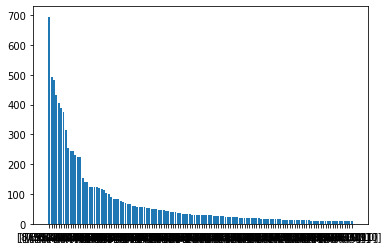

In [ ]:
plt.bar(x[:128],y[:128])

In [ ]:
abc

[('[8, 9, 10, 11]', 695),
 ('[7, 9, 10, 11]', 491),
 ('[7, 8, 10, 11]', 484),
 ('[6, 9, 10, 11]', 431),
 ('[6, 8, 10, 11]', 405),
 ('[5, 9, 10, 11]', 387),
 ('[5, 8, 10, 11]', 376),
 ('[6, 7, 10, 11]', 314),
 ('[5, 7, 10, 11]', 256),
 ('[5, 6, 10, 11]', 245),
 ('[4, 9, 10, 11]', 243),
 ('[3, 9, 10, 11]', 230),
 ('[4, 8, 10, 11]', 224),
 ('[3, 8, 10, 11]', 223),
 ('[7, 8, 9, 11]', 154),
 ('[4, 7, 10, 11]', 141),
 ('[3, 7, 10, 11]', 139),
 ('[2, 9, 10, 11]', 125),
 ('[2, 8, 10, 11]', 124),
 ('[4, 6, 10, 11]', 122),
 ('[3, 6, 10, 11]', 122),
 ('[6, 8, 9, 11]', 121),
 ('[4, 5, 10, 11]', 118),
 ('[7, 8, 9, 10]', 114),
 ('[3, 5, 10, 11]', 105),
 ('[5, 8, 9, 11]', 99),
 ('[6, 7, 8, 11]', 90),
 ('[6, 7, 9, 11]', 83),
 ('[6, 8, 9, 10]', 82),
 ('[2, 7, 10, 11]', 82),
 ('[2, 6, 10, 11]', 76),
 ('[5, 7, 9, 11]', 74),
 ('[5, 7, 8, 11]', 70),
 ('[3, 8, 9, 11]', 67),
 ('[5, 8, 9, 10]', 66),
 ('[4, 8, 9, 11]', 59),
 ('[2, 5, 10, 11]', 59),
 ('[5, 6, 9, 11]', 58),
 ('[1, 9, 10, 11]', 58),
 ('[5, 6, 8, 

In [ ]:
print(np.mean(means))
print(np.std(means))

8.055925
0.9561334343986722


In [ ]:
np.mean([8,9,10,11])

9.5

In [ ]:
mask = np.array(['10, 11' in i[0] for i in abc])
np.sum([int(i[1]) for i in np.array(abc)[mask]]) # all the ones that have svm and log

6608

so if I can find a lower bound for including svm and log, I can at least do 66% of all the ones... still pretty shoddy, though.

## Guaranteed accuracy vs test size

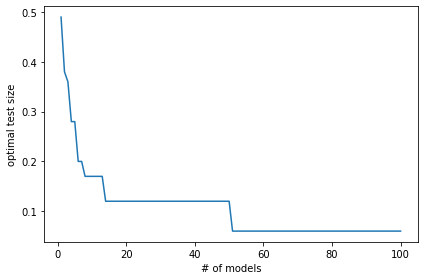

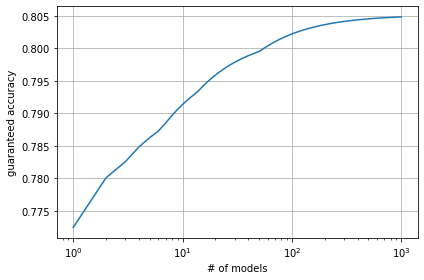

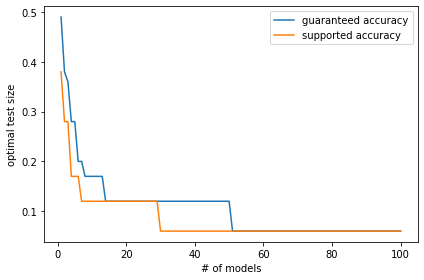

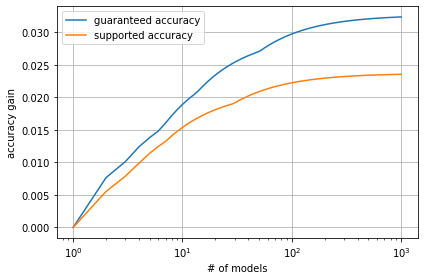

In [ ]:
import matplotlib.pyplot as plt

def guaranteed_accuracy(nr_models,means_2000,stds_2000,test_sizes_2000):
  means_2000 = means_2000[:-5] # test size < 5% is too uncertain even for 2000 models
  stds_2000 = stds_2000[:-5]
  test_sizes_2000 = test_sizes_2000[:-5]
  if nr_models > 1:
    loss = [i - 2*j*np.sqrt(1/nr_models+k/(nr_models/(nr_models-1)-k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]
  else:
    loss = [i - 2*j for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]
  return np.max(loss),(50-np.argmax(loss))/100

def supported_accuracy(nr_models,means_2000,stds_2000,test_sizes_2000):
  means_2000 = means_2000[:-5] # test size < 5% is too uncertain even for 2000 models
  stds_2000 = stds_2000[:-5]
  test_sizes_2000 = test_sizes_2000[:-5]
  if nr_models > 1:
    loss = [i - j*np.sqrt(1/nr_models+k/(nr_models/(nr_models-1)-k)) for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]
  else:
    loss = [i - j for i,j,k in zip(means_2000,stds_2000,test_sizes_2000)]
  return np.max(loss),(50-np.argmax(loss))/100

x = np.linspace(1,100,100)
y = [guaranteed_accuracy(i,means_2000,stds_2000,test_sizes_2000)[1] for i in x]
plt.plot(x,y)
plt.xlabel('# of models')
plt.ylabel('optimal test size')
plt.tight_layout()
plt.show()
x = np.linspace(1,1000,1000)
y = [guaranteed_accuracy(i,means_2000,stds_2000,test_sizes_2000)[0] for i in x]
plt.plot(x,y)
plt.xscale('log')
plt.xlabel('# of models')
plt.ylabel('guaranteed accuracy')
plt.grid()
plt.tight_layout()
plt.show()
x = np.linspace(1,100,100)
y = [guaranteed_accuracy(i,means_2000,stds_2000,test_sizes_2000)[1] for i in x]
plt.plot(x,y,label='guaranteed accuracy')
y = [supported_accuracy(i,means_2000,stds_2000,test_sizes_2000)[1] for i in x]
plt.plot(x,y,label='supported accuracy')
plt.xlabel('# of models')
plt.ylabel('optimal test size')
plt.tight_layout()
plt.legend()
plt.show()
x = np.linspace(1,1000,1000)
y_0 = guaranteed_accuracy(1,means_2000,stds_2000,test_sizes_2000)[0]
y = [guaranteed_accuracy(i,means_2000,stds_2000,test_sizes_2000)[0]- y_0 for i in x]
plt.plot(x,y,label='guaranteed accuracy')
y_0 = supported_accuracy(1,means_2000,stds_2000,test_sizes_2000)[0]
y = [supported_accuracy(i,means_2000,stds_2000,test_sizes_2000)[0]- y_0 for i in x]
plt.plot(x,y,label='supported accuracy')
plt.xscale('log')
plt.xlabel('# of models')
plt.ylabel('accuracy gain')
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

## Comparison with single instance

In [ ]:
# Let's see what these numbers are on a single instance

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


scaled_data = preprocessing.scale(X_encoded)
scaled_data = pd.DataFrame(data=scaled_data, columns=X_encoded.columns, index = X_encoded.index)
x_train, x_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y,test_size = 0.3, random_state = 1)
scaled_x_train, scaled_x_test, scaled_y_train, scaled_y_test = train_test_split(scaled_data, y, stratify=y,test_size = 0.3, random_state = 1)
#A_train, A_test, b_train, b_test = train_test_split(x_train, y_train, stratify=y_train,test_size = 0.3, random_state = 1)

def without_pca(x_train,y_train,x_test,y_test):
  path = DecisionTreeClassifier().cost_complexity_pruning_path(x_train,y_train)
  ccp_alphas = path.ccp_alphas 
  ccp_alphas = ccp_alphas[:-1]
  alphaResults = {}
  for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(ccp_alpha = alpha)
    scores = cross_val_score(tree,x_train,y_train,cv=10)
    alphaResults[alpha] = [scores.mean(),scores.std()]
  df = pd.DataFrame(alphaResults).T
  df.reset_index(inplace=True)
  df.columns = ['alpha','mean-accuracy','stdev']
  best_alpha = df.loc[df['mean-accuracy'].argmax(),'alpha']
  pruned_tree = DecisionTreeClassifier(ccp_alpha=best_alpha)
  pruned_tree.fit(x_train,y_train)
  return accuracy_score(y_test,pruned_tree.predict(x_test))

print(without_pca(scaled_x_train,scaled_y_train,scaled_x_test,scaled_y_test))

def with_pca(x_train,y_train,x_test,y_test):
  pca = PCA()
  pca.fit(x_train)
  pca_x_train = pca.transform(x_train)
  pca_x_test = pca.transform(x_test)
  path = DecisionTreeClassifier().cost_complexity_pruning_path(pca_x_train,y_train)
  ccp_alphas = path.ccp_alphas 
  ccp_alphas = ccp_alphas[:-1]
  alphaResults = {}
  for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(ccp_alpha = alpha)
    scores = cross_val_score(tree,pca_x_train,y_train,cv=10)
    alphaResults[alpha] = [scores.mean(),scores.std()]
  df = pd.DataFrame(alphaResults).T
  df.reset_index(inplace=True)
  df.columns = ['alpha','mean-accuracy','stdev']
  best_alpha = df.loc[df['mean-accuracy'].argmax(),'alpha']
  pruned_tree = DecisionTreeClassifier(ccp_alpha=best_alpha)
  pruned_tree.fit(pca_x_train,y_train)
  return accuracy_score(y_test,pruned_tree.predict(pca_x_test))

print(with_pca(scaled_x_train,scaled_y_train,scaled_x_test,scaled_y_test))

gbc = GradientBoostingClassifier()
gbc.fit(x_train,y_train)
print(accuracy_score(y_test,gbc.predict(x_test)))

def SVD(x_train,y_train,x_test):
  x_train = np.pad(x_train,[(0,0),(0,1)],constant_values=1)
  x_test = np.pad(x_test,[(0,0),(0,1)],constant_values=1)
  U,S,VT = np.linalg.svd(x_train,full_matrices=False)
  S = np.diag(S)
  x_train_inv = VT.T @ np.linalg.inv(S) @ U.T
  x_fit = x_train_inv @ y_train
  y_predicted_test = x_test @ x_fit
  y_predicted_test_2 = [int(row > 0.5) for row in y_predicted_test]
  y_predicted_train = x_train @ x_fit
  y_predicted_train_2 = [int(row > 0.5) for row in y_predicted_train]
  return y_predicted_train_2, y_predicted_test_2

y_pred_train,y_pred_test = SVD(x_train,y_train,x_test)
print(accuracy_score(y_test,y_pred_test))

from sklearn.ensemble import RandomForestClassifier

def RandomForest(x_train,y_train,x_test):
  clf = RandomForestClassifier(n_estimators=100,max_depth=4,min_samples_split=2)
  clf.fit(x_train, y_train)
  return clf.predict(x_train), clf.predict(x_test)

y_pred_train,y_pred_test = RandomForest(x_train,y_train,x_test)
print(accuracy_score(y_test,y_pred_test))

from sklearn.neighbors import KNeighborsClassifier

def knn(x_train,y_train,x_test):
  parameters = [{'n_neighbors':[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34]}]
  optimal_params = GridSearchCV(KNeighborsClassifier(),parameters,cv=30,scoring='accuracy',verbose=0)
  optimal_params.fit(x_train,y_train)
  n_neighbors = optimal_params.best_params_['n_neighbors']
  weights = "uniform"
  knn = KNeighborsClassifier(n_neighbors=n_neighbors,weights="uniform")
  knn.fit(x_train,y_train)
  y_train_pred = knn.predict(x_train)
  y_test_pred = knn.predict(x_test)
  return accuracy_score(y_test,y_test_pred)

print(knn(scaled_x_train,scaled_y_train,scaled_x_test))

def Logistic(x_train,y_train,x_test):
  clf = LogisticRegression(max_iter = 1000,fit_intercept=True,solver='liblinear',C=1)
  pca = PCA()
  pca.fit(x_train)
  pca_x_train = pca.transform(x_train)
  pca_x_test = pca.transform(x_test)
  clf.fit(pca_x_train, y_train)
  return clf.predict(pca_x_test)

print(accuracy_score(y_test,Logistic(scaled_x_train,scaled_y_train,scaled_x_test)))

from sklearn import svm

def SupportVectorMachines(x_train,y_train,x_test):
  clf = svm.SVC(kernel='rbf', gamma=0.002, C=0.35)
  clf.fit(x_train, y_train)
  return clf.predict(x_test)

print(accuracy_score(y_test,SupportVectorMachines(scaled_x_train,scaled_y_train,scaled_x_test)))


0.7555555555555555
0.8666666666666667
0.7777777777777778
0.8333333333333334
0.8
0.8
0.8333333333333334
0.8222222222222222


In [ ]:
index = ['Cost Complexity Trees','PCA Trees','XGBoost','Singular Value Decomposition','PCA Random Forest','KNearestNeighbors','PCA Logistic Regression', 'Support Vector Machines']
columns = ['Single Eval Accuracy(%)','Cross Correlation Accuracy(%)']
single_eval = pd.DataFrame(columns = columns, index = index)
single_eval['Single Eval Accuracy(%)'] = [75.6,86.7,77.8,83.3,80.0,80.0,83.3,82.2]
single_eval['Cross Correlation Accuracy(%)'] = [76.4,80.1,81.3,81.4,82.6,83.2,83.4,84.4]
single_eval


Single Eval Accuracy(%)  \
Cost Complexity Trees                            75.6   
PCA Trees                                        86.7   
XGBoost                                          77.8   
Singular Value Decomposition                     83.3   
PCA Random Forest                                80.0   
KNearestNeighbors                                80.0   
PCA Logistic Regression                          83.3   
Support Vector Machines                          82.2   

                              Cross Correlation Accuracy(%)  
Cost Complexity Trees                                  76.4  
PCA Trees                                              80.1  
XGBoost                                                81.3  
Singular Value Decomposition                           81.4  
PCA Random Forest                                      82.6  
KNearestNeighbors                                      83.2  
PCA Logistic Regression                                83.4  
Support Vector Machines                                84.4

## Visual Neural Network

In [ ]:
tml_acc = [0.8,0.78,0.87,0.75]
print(np.mean(tml_acc))
print(np.std(tml_acc))

0.8
0.044158804331639226
